In [1]:
# === 1번 셀: 공통 import 셀 ===

import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import torch
import torch.nn.functional as F  # A2C용 Softmax 등
import joblib
import warnings

# --- 1. (필수) 모든 사용자 정의 모듈 임포트 ---
from data_utils import (
    download_data, 
    add_indicators, 
    train_test_split_by_ratio, 
    build_state,
    get_feature_names_with_position,
    FEATURES,
)
from ac_model import A2CAgent  # ActorCriticNet는 직접 안 써서 생략해도 됨

# --- 2. (권장) 전역 설정 ---
# 경고 메시지 무시
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 한글 폰트 설정 (Mac: AppleGothic, Windows: Malgun Gothic)
try:
    plt.rcParams["font.family"] = "AppleGothic"  # Mac
    # plt.rcParams["font.family"] = "Malgun Gothic"  # Windows
    plt.rcParams["axes.unicode_minus"] = False  # 마이너스 부호 깨짐 방지
except Exception as e:
    print(f"폰트 설정 경고: {e} (한글이 깨질 수 있습니다)")

print("모든 패키지 임포트 완료.")

모든 패키지 임포트 완료.


/opt/anaconda3/envs/ml-new/lib/python3.10/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
# --- 2. 셀: 모델 학습 (A2C train.py) ---

import os
import yaml
import joblib
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

from data_utils import (
    download_data,
    add_indicators,
    train_test_split_last_10y_and_1y,  # 🔥 규칙 기반 분할 사용
    FEATURES,
)
from trading_env import TradingEnv
from ac_model import A2CAgent


# --- A2C용 검증(Validation) 함수 ---
def validate_agent(agent: A2CAgent, env_config: dict, scaler: StandardScaler = None):
    val_env = TradingEnv(**env_config)
    s = val_env.reset()
    done = False
    episode_reward = 0.0

    while not done:
        a, _ = agent.act(s, deterministic=True)
        ns, r, done, _ = val_env.step(a)
        episode_reward += r
        s = ns if not done else s

    return episode_reward


def run_training():
    print("A2C 모델 학습을 시작합니다...")

    # 1. 설정 로드
    with open("config.yaml", "r", encoding="utf-8") as f:
        cfg = yaml.safe_load(f)

    report_dir = cfg["report_dir"]
    os.makedirs(report_dir, exist_ok=True)

    window_size = cfg["window_size"]
    model_cfg = cfg["model_cfg"]
    reward_cfg = cfg.get("reward", {})
    validate_every = cfg.get("validate_every_n_episodes", 10)
    model_path = cfg["model_path"]

    # 2. 데이터 로드 및 전처리
    print("데이터 로딩 및 기술지표 계산 중...")
    raw = download_data(
        cfg["ticker"],
        cfg["kospi_ticker"],
        cfg["vix_ticker"],
        cfg["start_date"],
        cfg["end_date"],
    )
    df = add_indicators(raw)

    # 🔥 10년 + 최근 365일 규칙 기반 분할
    train_df, test_df = train_test_split_last_10y_and_1y(
        df,
        train_years=10,
        backtest_days=365,
    )

    print(f"[INFO] Train 기간: {train_df.index.min().date()} ~ {train_df.index.max().date()} "
          f"(총 {len(train_df)}일)")
    print(f"[INFO] Test  기간: {test_df.index.min().date()} ~ {test_df.index.max().date()} "
          f"(총 {len(test_df)}일, 거래일 기준)")

    # 3. 스케일링
    print("데이터 정규화(Scaling) 수행 중...")
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    train_df[FEATURES] = scaler.fit_transform(train_df[FEATURES])
    test_df[FEATURES] = scaler.transform(test_df[FEATURES])

    scaler_path = os.path.join(report_dir, "scaler.joblib")
    joblib.dump(scaler, scaler_path)
    print(f"Scaler 저장 완료: {scaler_path}")

    # 4. 환경/에이전트 생성
    print("환경 및 A2C 에이전트 생성 중...")
    train_env_config = {
        "data": train_df,
        "window_size": window_size,
        "trade_penalty": cfg["trade_penalty"],
        "use_daily_unrealized": cfg["use_daily_unrealized"],
        "reward_cfg": reward_cfg,
    }
    val_env_config = {
        "data": test_df,
        "window_size": window_size,
        "trade_penalty": cfg["trade_penalty"],
        "use_daily_unrealized": cfg["use_daily_unrealized"],
        "reward_cfg": reward_cfg,
    }

    env = TradingEnv(**train_env_config)

    agent = A2CAgent(
        state_dim=env.current_state_dim(),
        action_dim=3,
        hidden_dims=model_cfg.get("hidden_dims", [128, 128]),
        gamma=cfg["gamma"],
        lr=cfg["lr"],
        value_loss_coeff=cfg["value_loss_coeff"],
        entropy_coeff=cfg["entropy_coeff"],
        seed=cfg["seed"],
        device=cfg.get("device", "cpu"),
    )

    episodes = cfg["episodes"]
    best_val_reward = -np.inf
    print(f"A2C 학습 시작 (총 {episodes} 에피소드)...")

    episode_rewards = []
    val_rewards = []

    for ep in range(episodes):
        s = env.reset()
        done = False
        episode_reward = 0.0

        dbg_acc = {
            "base": 0.0,
            "r_t": 0.0,
            "rb_t": 0.0,
            "comp_beta": 0.0,
            "comp_R": 0.0,
            "comp_Ddown": 0.0,
            "comp_Dret": 0.0,
            "comp_Try": 0.0,
        }
        steps = 0

        desc = f"Episode {ep + 1}/{episodes}"
        from tqdm import tqdm
        pbar = tqdm(total=len(train_df) - window_size, desc=desc, leave=True)

        while not done:
            a, log_prob = agent.act(s, deterministic=False)
            value = agent.get_value(s)
            ns, r, done, info = env.step(a)

            agent.remember(s, a, r, ns, done, log_prob, value)

            episode_reward += r
            s = ns if not done else s
            pbar.update(1)

            for k in dbg_acc.keys():
                if k in info:
                    dbg_acc[k] += info[k]
            steps += 1

        pbar.close()

        loss_tuple = agent.train_step()
        episode_rewards.append(episode_reward)

        if steps > 0:
            avg_dbg = {k: v / steps for k, v in dbg_acc.items()}
            print(
                f"[DBG Ep {ep+1}] "
                f"base:{avg_dbg['base']:.5f} "
                f"r:{avg_dbg['r_t']:.5f} rb:{avg_dbg['rb_t']:.5f} "
                f"beta:{avg_dbg['comp_beta']:.3f} "
                f"R:{avg_dbg['comp_R']:.3f} D:{avg_dbg['comp_Ddown']:.3f} "
                f"Dret:{avg_dbg['comp_Dret']:.3f} Try:{avg_dbg['comp_Try']:.3f}"
            )

        if loss_tuple:
            actor_loss, critic_loss, entropy_loss = loss_tuple
            if not np.isfinite(actor_loss):
                print(f"[WARN] Ep {ep+1}: actor_loss is {actor_loss}")
            if not np.isfinite(critic_loss):
                print(f"[WARN] Ep {ep+1}: critic_loss is {critic_loss}")

            print(
                f"Ep {ep+1:4d} | "
                f"Reward: {episode_reward:12.2f} | "
                f"A_Loss: {actor_loss:10.4f} | "
                f"C_Loss: {critic_loss:14.4f} | "
                f"E_Loss: {entropy_loss:10.4f}"
            )
        else:
            print(
                f"Ep {ep+1:4d} | "
                f"Reward: {episode_reward:12.2f} | "
                "(버퍼가 비어 학습 스킵)"
            )

        # 검증
        if (ep + 1) % validate_every == 0:
            val_reward = validate_agent(agent, val_env_config)
            val_rewards.append(val_reward)

            print(f"--- Validation Ep {ep+1} | Reward: {val_reward:.2f} ---")
            if val_reward > best_val_reward:
                best_val_reward = val_reward
                print(f"*** New Best Model! Saving to {model_path} ***")
                agent.save(model_path)

    # 학습 요약
    if len(episode_rewards) > 0:
        ep_rewards_arr = np.array(episode_rewards, dtype=float)

        first_100_mean = ep_rewards_arr[:100].mean() if len(ep_rewards_arr) >= 100 else ep_rewards_arr.mean()
        last_100_mean = ep_rewards_arr[-100:].mean() if len(ep_rewards_arr) >= 100 else ep_rewards_arr.mean()
        best_ep_reward = ep_rewards_arr.max()
        best_val = best_val_reward if np.isfinite(best_val_reward) else (np.max(val_rewards) if val_rewards else np.nan)

        print("\n--- 학습 곡선 분석 ---")
        print(f"    - 초기 100 에피소드 평균: {first_100_mean:.2f}")
        print(f"    - 최종 100 에피소드 평균: {last_100_mean:.2f}")
        print(f"    - 최고 에피소드 보상: {best_ep_reward:.2f}")
        print(f"    - 최고 검증 보상: {best_val:.2f}")

        hist_path = os.path.join(report_dir, "a2c_train_history.npz")
        np.savez(
            hist_path,
            episode_rewards=ep_rewards_arr,
            val_rewards=np.array(val_rewards, dtype=float),
        )
        print(f"[INFO] 학습 로그 저장 완료: {hist_path}")

    print(
        f"\n[OK] A2C Training finished. "
        f"Best validation reward: {best_val_reward:.2f} (saved to {model_path})"
    )


run_training()

A2C 모델 학습을 시작합니다...
데이터 로딩 및 기술지표 계산 중...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[INFO] Train 기간: 2014-11-26 ~ 2024-11-25 (총 2377일)
[INFO] Test  기간: 2024-11-26 ~ 2025-11-25 (총 232일, 거래일 기준)
데이터 정규화(Scaling) 수행 중...
Scaler 저장 완료: reports/scaler.joblib
환경 및 A2C 에이전트 생성 중...
A2C 학습 시작 (총 2000 에피소드)...


Episode 1/2000: 100%|█████████████████████| 2372/2372 [00:00<00:00, 3969.93it/s]


[DBG Ep 1] base:-0.00126 r:-0.00061 rb:0.00058 beta:-0.017 R:-0.040 D:0.010 Dret:-0.003 Try:-0.003
Ep    1 | Reward:       -57.19 | A_Loss:    -0.0030 | C_Loss:         3.1529 | E_Loss:    -1.0922


Episode 2/2000: 100%|█████████████████████| 2372/2372 [00:00<00:00, 3966.47it/s]


[DBG Ep 2] base:-0.00073 r:-0.00008 rb:0.00058 beta:-0.021 R:0.009 D:0.010 Dret:-0.000 Try:-0.000
Ep    2 | Reward:       -18.12 | A_Loss:     0.0008 | C_Loss:         3.2106 | E_Loss:    -1.0916


Episode 3/2000: 100%|█████████████████████| 2372/2372 [00:00<00:00, 3981.04it/s]


[DBG Ep 3] base:-0.00023 r:0.00046 rb:0.00058 beta:-0.004 R:0.069 D:0.010 Dret:0.002 Try:0.002
Ep    3 | Reward:        31.00 | A_Loss:    -0.0007 | C_Loss:         2.6036 | E_Loss:    -1.0912


Episode 4/2000: 100%|█████████████████████| 2372/2372 [00:00<00:00, 3976.15it/s]


[DBG Ep 4] base:-0.00013 r:0.00050 rb:0.00058 beta:-0.018 R:0.063 D:0.010 Dret:0.002 Try:0.002
Ep    4 | Reward:        20.18 | A_Loss:    -0.0008 | C_Loss:         3.2472 | E_Loss:    -1.0897


Episode 5/2000: 100%|█████████████████████| 2372/2372 [00:00<00:00, 4000.22it/s]


[DBG Ep 5] base:-0.00083 r:-0.00022 rb:0.00058 beta:0.001 R:0.017 D:0.010 Dret:-0.001 Try:-0.001
Ep    5 | Reward:        -1.71 | A_Loss:     0.0022 | C_Loss:         3.5145 | E_Loss:    -1.0884


Episode 6/2000: 100%|█████████████████████| 2372/2372 [00:00<00:00, 3982.65it/s]


[DBG Ep 6] base:-0.00036 r:0.00031 rb:0.00058 beta:-0.002 R:0.038 D:0.010 Dret:0.001 Try:0.001
Ep    6 | Reward:        30.56 | A_Loss:    -0.0005 | C_Loss:         3.4896 | E_Loss:    -1.0876


Episode 7/2000: 100%|█████████████████████| 2372/2372 [00:00<00:00, 3983.03it/s]


[DBG Ep 7] base:-0.00017 r:0.00047 rb:0.00058 beta:-0.003 R:0.063 D:0.010 Dret:0.002 Try:0.002
Ep    7 | Reward:        13.28 | A_Loss:     0.0047 | C_Loss:         2.5333 | E_Loss:    -1.0866


Episode 8/2000: 100%|█████████████████████| 2372/2372 [00:00<00:00, 3993.04it/s]


[DBG Ep 8] base:-0.00026 r:0.00041 rb:0.00058 beta:-0.005 R:0.042 D:0.010 Dret:0.002 Try:0.002
Ep    8 | Reward:        15.36 | A_Loss:    -0.0020 | C_Loss:         2.4817 | E_Loss:    -1.0860


Episode 9/2000: 100%|█████████████████████| 2372/2372 [00:00<00:00, 4000.99it/s]


[DBG Ep 9] base:0.00021 r:0.00085 rb:0.00058 beta:-0.005 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep    9 | Reward:        64.36 | A_Loss:     0.0060 | C_Loss:         3.5548 | E_Loss:    -1.0853


Episode 10/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3929.29it/s]


[DBG Ep 10] base:0.00002 r:0.00069 rb:0.00058 beta:-0.015 R:0.073 D:0.010 Dret:0.003 Try:0.003
Ep   10 | Reward:        67.68 | A_Loss:     0.0041 | C_Loss:         4.0440 | E_Loss:    -1.0847
--- Validation Ep 10 | Reward: 15.31 ---
*** New Best Model! Saving to a2c_samsung.pt ***


Episode 11/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4014.71it/s]


[DBG Ep 11] base:-0.00021 r:0.00045 rb:0.00058 beta:0.008 R:0.058 D:0.010 Dret:0.002 Try:0.002
Ep   11 | Reward:        39.69 | A_Loss:     0.0031 | C_Loss:         3.6902 | E_Loss:    -1.0842


Episode 12/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4012.05it/s]


[DBG Ep 12] base:-0.00069 r:-0.00006 rb:0.00058 beta:-0.013 R:-0.002 D:0.010 Dret:-0.000 Try:-0.000
Ep   12 | Reward:       -15.56 | A_Loss:     0.0034 | C_Loss:         2.9120 | E_Loss:    -1.0838


Episode 13/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4010.26it/s]


[DBG Ep 13] base:-0.00109 r:-0.00043 rb:0.00058 beta:-0.013 R:-0.035 D:0.011 Dret:-0.002 Try:-0.002
Ep   13 | Reward:       -21.06 | A_Loss:     0.0032 | C_Loss:         3.0310 | E_Loss:    -1.0838


Episode 14/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4002.44it/s]


[DBG Ep 14] base:-0.00051 r:0.00017 rb:0.00058 beta:-0.017 R:0.024 D:0.010 Dret:0.001 Try:0.001
Ep   14 | Reward:        -2.02 | A_Loss:    -0.0054 | C_Loss:         2.8940 | E_Loss:    -1.0843


Episode 15/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3966.08it/s]


[DBG Ep 15] base:-0.00031 r:0.00035 rb:0.00058 beta:-0.008 R:0.043 D:0.010 Dret:0.002 Try:0.002
Ep   15 | Reward:        29.15 | A_Loss:    -0.0056 | C_Loss:         2.4788 | E_Loss:    -1.0845


Episode 16/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3966.69it/s]


[DBG Ep 16] base:-0.00062 r:0.00007 rb:0.00058 beta:-0.009 R:0.013 D:0.011 Dret:0.000 Try:0.000
Ep   16 | Reward:        -4.06 | A_Loss:    -0.0014 | C_Loss:         2.9750 | E_Loss:    -1.0840


Episode 17/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3984.89it/s]


[DBG Ep 17] base:-0.00039 r:0.00027 rb:0.00058 beta:0.004 R:0.030 D:0.010 Dret:0.001 Try:0.001
Ep   17 | Reward:        11.55 | A_Loss:     0.0012 | C_Loss:         2.7259 | E_Loss:    -1.0836


Episode 18/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3988.17it/s]


[DBG Ep 18] base:-0.00047 r:0.00019 rb:0.00058 beta:-0.007 R:0.060 D:0.010 Dret:0.001 Try:0.001
Ep   18 | Reward:        14.43 | A_Loss:    -0.0022 | C_Loss:         3.6301 | E_Loss:    -1.0834


Episode 19/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4017.53it/s]


[DBG Ep 19] base:-0.00082 r:-0.00014 rb:0.00058 beta:-0.009 R:-0.000 D:0.010 Dret:-0.001 Try:-0.001
Ep   19 | Reward:        -9.99 | A_Loss:    -0.0030 | C_Loss:         2.9678 | E_Loss:    -1.0829


Episode 20/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3983.70it/s]


[DBG Ep 20] base:-0.00072 r:-0.00008 rb:0.00058 beta:-0.014 R:-0.000 D:0.010 Dret:-0.000 Try:-0.000
Ep   20 | Reward:       -14.77 | A_Loss:    -0.0111 | C_Loss:         3.2103 | E_Loss:    -1.0824
--- Validation Ep 20 | Reward: 15.31 ---


Episode 21/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4002.23it/s]


[DBG Ep 21] base:-0.00074 r:-0.00006 rb:0.00058 beta:-0.012 R:0.013 D:0.010 Dret:-0.000 Try:-0.000
Ep   21 | Reward:        -4.37 | A_Loss:     0.0028 | C_Loss:         4.0313 | E_Loss:    -1.0810


Episode 22/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4002.25it/s]


[DBG Ep 22] base:-0.00077 r:-0.00013 rb:0.00058 beta:-0.003 R:-0.002 D:0.010 Dret:-0.001 Try:-0.001
Ep   22 | Reward:       -17.79 | A_Loss:    -0.0024 | C_Loss:         3.7362 | E_Loss:    -1.0805


Episode 23/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3998.85it/s]


[DBG Ep 23] base:-0.00097 r:-0.00030 rb:0.00058 beta:-0.010 R:-0.014 D:0.010 Dret:-0.001 Try:-0.001
Ep   23 | Reward:       -12.84 | A_Loss:    -0.0070 | C_Loss:         2.4142 | E_Loss:    -1.0798


Episode 24/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3990.57it/s]


[DBG Ep 24] base:-0.00054 r:0.00015 rb:0.00058 beta:-0.016 R:0.037 D:0.010 Dret:0.001 Try:0.001
Ep   24 | Reward:         3.51 | A_Loss:    -0.0066 | C_Loss:         3.0135 | E_Loss:    -1.0790


Episode 25/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4012.84it/s]


[DBG Ep 25] base:-0.00078 r:-0.00007 rb:0.00058 beta:-0.012 R:0.027 D:0.010 Dret:0.000 Try:0.000
Ep   25 | Reward:         4.52 | A_Loss:     0.0006 | C_Loss:         3.1769 | E_Loss:    -1.0778


Episode 26/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3968.10it/s]


[DBG Ep 26] base:-0.00039 r:0.00030 rb:0.00058 beta:-0.007 R:0.039 D:0.010 Dret:0.001 Try:0.001
Ep   26 | Reward:        14.68 | A_Loss:    -0.0068 | C_Loss:         2.6418 | E_Loss:    -1.0769


Episode 27/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3941.92it/s]


[DBG Ep 27] base:-0.00053 r:0.00021 rb:0.00058 beta:-0.010 R:0.059 D:0.010 Dret:0.001 Try:0.001
Ep   27 | Reward:        20.96 | A_Loss:    -0.0012 | C_Loss:         2.4418 | E_Loss:    -1.0755


Episode 28/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3969.63it/s]


[DBG Ep 28] base:-0.00106 r:-0.00041 rb:0.00058 beta:-0.020 R:-0.034 D:0.010 Dret:-0.002 Try:-0.002
Ep   28 | Reward:       -45.64 | A_Loss:    -0.0036 | C_Loss:         3.3793 | E_Loss:    -1.0735


Episode 29/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3994.67it/s]


[DBG Ep 29] base:-0.00011 r:0.00056 rb:0.00058 beta:-0.020 R:0.064 D:0.010 Dret:0.003 Try:0.003
Ep   29 | Reward:        33.27 | A_Loss:    -0.0156 | C_Loss:         3.2745 | E_Loss:    -1.0721


Episode 30/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4004.62it/s]


[DBG Ep 30] base:-0.00020 r:0.00046 rb:0.00058 beta:-0.012 R:0.054 D:0.010 Dret:0.002 Try:0.002
Ep   30 | Reward:        50.78 | A_Loss:    -0.0029 | C_Loss:         2.8389 | E_Loss:    -1.0704
--- Validation Ep 30 | Reward: 15.25 ---


Episode 31/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4025.80it/s]


[DBG Ep 31] base:-0.00040 r:0.00024 rb:0.00058 beta:-0.020 R:0.045 D:0.010 Dret:0.001 Try:0.001
Ep   31 | Reward:        44.62 | A_Loss:    -0.0098 | C_Loss:         2.5853 | E_Loss:    -1.0685


Episode 32/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4006.61it/s]


[DBG Ep 32] base:-0.00034 r:0.00034 rb:0.00058 beta:-0.022 R:0.047 D:0.010 Dret:0.002 Try:0.002
Ep   32 | Reward:        56.57 | A_Loss:     0.0014 | C_Loss:         2.7346 | E_Loss:    -1.0652


Episode 33/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3970.74it/s]


[DBG Ep 33] base:-0.00017 r:0.00053 rb:0.00058 beta:-0.030 R:0.052 D:0.010 Dret:0.002 Try:0.002
Ep   33 | Reward:        43.42 | A_Loss:     0.0060 | C_Loss:         2.1924 | E_Loss:    -1.0622


Episode 34/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3991.24it/s]


[DBG Ep 34] base:-0.00060 r:0.00008 rb:0.00058 beta:-0.027 R:0.022 D:0.011 Dret:0.001 Try:0.001
Ep   34 | Reward:       -11.26 | A_Loss:    -0.0200 | C_Loss:         3.7932 | E_Loss:    -1.0586


Episode 35/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3989.86it/s]


[DBG Ep 35] base:-0.00065 r:0.00004 rb:0.00058 beta:-0.037 R:0.040 D:0.010 Dret:0.001 Try:0.001
Ep   35 | Reward:        13.44 | A_Loss:    -0.0199 | C_Loss:         2.3663 | E_Loss:    -1.0535


Episode 36/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3998.48it/s]


[DBG Ep 36] base:-0.00078 r:-0.00012 rb:0.00058 beta:-0.031 R:0.006 D:0.011 Dret:-0.001 Try:-0.001
Ep   36 | Reward:        -4.40 | A_Loss:     0.0206 | C_Loss:         2.7428 | E_Loss:    -1.0465


Episode 37/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3973.89it/s]


[DBG Ep 37] base:-0.00055 r:0.00012 rb:0.00058 beta:-0.033 R:0.029 D:0.010 Dret:0.000 Try:0.000
Ep   37 | Reward:        -4.18 | A_Loss:    -0.0276 | C_Loss:         4.0182 | E_Loss:    -1.0414


Episode 38/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3976.22it/s]


[DBG Ep 38] base:-0.00062 r:0.00000 rb:0.00058 beta:-0.035 R:0.017 D:0.010 Dret:0.000 Try:0.000
Ep   38 | Reward:       -19.09 | A_Loss:    -0.0335 | C_Loss:         3.0957 | E_Loss:    -1.0373


Episode 39/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3988.05it/s]


[DBG Ep 39] base:-0.00032 r:0.00030 rb:0.00058 beta:-0.035 R:0.037 D:0.010 Dret:0.001 Try:0.001
Ep   39 | Reward:        20.91 | A_Loss:    -0.0146 | C_Loss:         2.7632 | E_Loss:    -1.0341


Episode 40/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3981.58it/s]


[DBG Ep 40] base:-0.00060 r:-0.00001 rb:0.00058 beta:-0.053 R:0.019 D:0.010 Dret:-0.000 Try:-0.000
Ep   40 | Reward:         3.23 | A_Loss:    -0.0020 | C_Loss:         2.5236 | E_Loss:    -1.0312
--- Validation Ep 40 | Reward: 15.25 ---


Episode 41/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3941.65it/s]


[DBG Ep 41] base:-0.00006 r:0.00055 rb:0.00058 beta:-0.031 R:0.055 D:0.010 Dret:0.002 Try:0.002
Ep   41 | Reward:        29.60 | A_Loss:    -0.0270 | C_Loss:         3.2628 | E_Loss:    -1.0281


Episode 42/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3985.17it/s]


[DBG Ep 42] base:-0.00040 r:0.00025 rb:0.00058 beta:-0.025 R:0.059 D:0.010 Dret:0.001 Try:0.001
Ep   42 | Reward:        18.05 | A_Loss:    -0.0040 | C_Loss:         2.8277 | E_Loss:    -1.0239


Episode 43/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4000.86it/s]


[DBG Ep 43] base:-0.00017 r:0.00049 rb:0.00058 beta:-0.033 R:0.063 D:0.010 Dret:0.002 Try:0.002
Ep   43 | Reward:        65.89 | A_Loss:    -0.0356 | C_Loss:         3.0802 | E_Loss:    -1.0205


Episode 44/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3970.58it/s]


[DBG Ep 44] base:0.00014 r:0.00076 rb:0.00058 beta:-0.035 R:0.093 D:0.010 Dret:0.003 Try:0.003
Ep   44 | Reward:        54.80 | A_Loss:    -0.0329 | C_Loss:         2.9298 | E_Loss:    -1.0140


Episode 45/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3987.21it/s]


[DBG Ep 45] base:-0.00038 r:0.00025 rb:0.00058 beta:-0.048 R:0.042 D:0.010 Dret:0.001 Try:0.001
Ep   45 | Reward:        24.95 | A_Loss:     0.0013 | C_Loss:         3.1423 | E_Loss:    -1.0075


Episode 46/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3988.34it/s]


[DBG Ep 46] base:0.00027 r:0.00090 rb:0.00058 beta:-0.035 R:0.097 D:0.010 Dret:0.004 Try:0.004
Ep   46 | Reward:        73.60 | A_Loss:     0.0102 | C_Loss:         3.3591 | E_Loss:    -1.0046


Episode 47/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4007.10it/s]


[DBG Ep 47] base:-0.00024 r:0.00037 rb:0.00058 beta:-0.033 R:0.057 D:0.010 Dret:0.002 Try:0.002
Ep   47 | Reward:        38.48 | A_Loss:     0.0484 | C_Loss:         2.6647 | E_Loss:    -1.0039


Episode 48/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3985.15it/s]


[DBG Ep 48] base:-0.00062 r:-0.00005 rb:0.00058 beta:-0.049 R:-0.001 D:0.010 Dret:-0.001 Try:-0.001
Ep   48 | Reward:       -12.95 | A_Loss:     0.0361 | C_Loss:         3.3106 | E_Loss:    -1.0039


Episode 49/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4006.36it/s]


[DBG Ep 49] base:-0.00037 r:0.00022 rb:0.00058 beta:-0.044 R:0.028 D:0.010 Dret:0.001 Try:0.001
Ep   49 | Reward:        22.35 | A_Loss:     0.0456 | C_Loss:         3.3850 | E_Loss:    -1.0048


Episode 50/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3963.63it/s]


[DBG Ep 50] base:-0.00028 r:0.00031 rb:0.00058 beta:-0.028 R:0.041 D:0.010 Dret:0.001 Try:0.001
Ep   50 | Reward:        40.15 | A_Loss:     0.0727 | C_Loss:         3.3145 | E_Loss:    -1.0089
--- Validation Ep 50 | Reward: 15.25 ---


Episode 51/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3980.33it/s]


[DBG Ep 51] base:-0.00022 r:0.00044 rb:0.00058 beta:-0.041 R:0.075 D:0.010 Dret:0.002 Try:0.002
Ep   51 | Reward:        50.02 | A_Loss:     0.0238 | C_Loss:         3.4645 | E_Loss:    -1.0173


Episode 52/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3980.99it/s]


[DBG Ep 52] base:0.00013 r:0.00073 rb:0.00058 beta:-0.044 R:0.092 D:0.010 Dret:0.004 Try:0.004
Ep   52 | Reward:        76.04 | A_Loss:     0.0260 | C_Loss:         2.5366 | E_Loss:    -1.0270


Episode 53/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3974.50it/s]


[DBG Ep 53] base:-0.00013 r:0.00051 rb:0.00058 beta:-0.039 R:0.059 D:0.010 Dret:0.002 Try:0.002
Ep   53 | Reward:        56.01 | A_Loss:     0.0192 | C_Loss:         3.1017 | E_Loss:    -1.0343


Episode 54/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3956.83it/s]


[DBG Ep 54] base:-0.00098 r:-0.00039 rb:0.00058 beta:-0.050 R:-0.024 D:0.011 Dret:-0.002 Try:-0.002
Ep   54 | Reward:       -49.44 | A_Loss:     0.0209 | C_Loss:         3.8900 | E_Loss:    -1.0405


Episode 55/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3981.60it/s]


[DBG Ep 55] base:-0.00030 r:0.00030 rb:0.00058 beta:-0.027 R:0.049 D:0.010 Dret:0.002 Try:0.002
Ep   55 | Reward:        42.24 | A_Loss:     0.0105 | C_Loss:         3.3230 | E_Loss:    -1.0467


Episode 56/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3982.49it/s]


[DBG Ep 56] base:-0.00038 r:0.00019 rb:0.00058 beta:-0.033 R:0.025 D:0.010 Dret:0.001 Try:0.001
Ep   56 | Reward:        30.38 | A_Loss:    -0.0101 | C_Loss:         2.3542 | E_Loss:    -1.0534


Episode 57/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4005.71it/s]


[DBG Ep 57] base:-0.00086 r:-0.00025 rb:0.00058 beta:-0.043 R:0.009 D:0.010 Dret:-0.001 Try:-0.001
Ep   57 | Reward:        -3.61 | A_Loss:     0.0098 | C_Loss:         3.1654 | E_Loss:    -1.0594


Episode 58/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3972.84it/s]


[DBG Ep 58] base:-0.00008 r:0.00054 rb:0.00058 beta:-0.032 R:0.073 D:0.010 Dret:0.002 Try:0.002
Ep   58 | Reward:        31.31 | A_Loss:     0.0124 | C_Loss:         3.8756 | E_Loss:    -1.0636


Episode 59/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3984.67it/s]


[DBG Ep 59] base:-0.00042 r:0.00019 rb:0.00058 beta:-0.023 R:0.038 D:0.011 Dret:0.001 Try:0.001
Ep   59 | Reward:        29.78 | A_Loss:    -0.0022 | C_Loss:         2.4894 | E_Loss:    -1.0682


Episode 60/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4000.55it/s]


[DBG Ep 60] base:-0.00035 r:0.00026 rb:0.00058 beta:-0.033 R:0.036 D:0.010 Dret:0.001 Try:0.001
Ep   60 | Reward:         0.93 | A_Loss:    -0.0035 | C_Loss:         3.6585 | E_Loss:    -1.0716
--- Validation Ep 60 | Reward: 15.08 ---


Episode 61/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3993.82it/s]


[DBG Ep 61] base:0.00010 r:0.00068 rb:0.00058 beta:-0.009 R:0.081 D:0.010 Dret:0.003 Try:0.003
Ep   61 | Reward:        45.60 | A_Loss:     0.0086 | C_Loss:         2.6667 | E_Loss:    -1.0735


Episode 62/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3981.93it/s]


[DBG Ep 62] base:-0.00009 r:0.00053 rb:0.00058 beta:-0.033 R:0.074 D:0.010 Dret:0.003 Try:0.003
Ep   62 | Reward:        52.94 | A_Loss:    -0.0069 | C_Loss:         2.5956 | E_Loss:    -1.0745


Episode 63/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3988.96it/s]


[DBG Ep 63] base:-0.00042 r:0.00017 rb:0.00058 beta:-0.008 R:0.026 D:0.010 Dret:0.001 Try:0.001
Ep   63 | Reward:        17.98 | A_Loss:    -0.0025 | C_Loss:         2.5895 | E_Loss:    -1.0746


Episode 64/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4008.25it/s]


[DBG Ep 64] base:-0.00028 r:0.00029 rb:0.00058 beta:-0.026 R:0.033 D:0.010 Dret:0.001 Try:0.001
Ep   64 | Reward:         8.06 | A_Loss:     0.0045 | C_Loss:         3.0433 | E_Loss:    -1.0744


Episode 65/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3921.32it/s]


[DBG Ep 65] base:-0.00032 r:0.00026 rb:0.00058 beta:-0.009 R:0.036 D:0.010 Dret:0.001 Try:0.001
Ep   65 | Reward:        36.77 | A_Loss:    -0.0114 | C_Loss:         3.0330 | E_Loss:    -1.0747


Episode 66/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3996.21it/s]


[DBG Ep 66] base:-0.00078 r:-0.00020 rb:0.00058 beta:-0.016 R:-0.019 D:0.011 Dret:-0.001 Try:-0.001
Ep   66 | Reward:       -32.85 | A_Loss:     0.0025 | C_Loss:         3.7422 | E_Loss:    -1.0740


Episode 67/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4001.57it/s]


[DBG Ep 67] base:-0.00058 r:0.00002 rb:0.00058 beta:-0.026 R:0.016 D:0.011 Dret:-0.000 Try:-0.000
Ep   67 | Reward:       -22.78 | A_Loss:    -0.0017 | C_Loss:         3.4685 | E_Loss:    -1.0735


Episode 68/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3961.49it/s]


[DBG Ep 68] base:-0.00055 r:0.00004 rb:0.00058 beta:-0.015 R:0.018 D:0.010 Dret:-0.000 Try:-0.000
Ep   68 | Reward:        20.04 | A_Loss:     0.0030 | C_Loss:         2.8104 | E_Loss:    -1.0729


Episode 69/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3980.64it/s]


[DBG Ep 69] base:-0.00057 r:0.00002 rb:0.00058 beta:-0.027 R:0.005 D:0.010 Dret:-0.001 Try:-0.001
Ep   69 | Reward:       -26.42 | A_Loss:    -0.0051 | C_Loss:         3.3801 | E_Loss:    -1.0719


Episode 70/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3960.75it/s]


[DBG Ep 70] base:-0.00071 r:-0.00011 rb:0.00058 beta:-0.026 R:-0.007 D:0.010 Dret:-0.001 Try:-0.001
Ep   70 | Reward:        -7.25 | A_Loss:     0.0117 | C_Loss:         2.9909 | E_Loss:    -1.0713
--- Validation Ep 70 | Reward: 11.74 ---


Episode 71/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3991.69it/s]


[DBG Ep 71] base:-0.00054 r:0.00004 rb:0.00058 beta:-0.024 R:0.012 D:0.010 Dret:0.000 Try:0.000
Ep   71 | Reward:       -10.25 | A_Loss:     0.0004 | C_Loss:         2.9620 | E_Loss:    -1.0712


Episode 72/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4005.00it/s]


[DBG Ep 72] base:0.00008 r:0.00066 rb:0.00058 beta:-0.008 R:0.085 D:0.010 Dret:0.003 Try:0.003
Ep   72 | Reward:        59.11 | A_Loss:    -0.0084 | C_Loss:         3.2465 | E_Loss:    -1.0711


Episode 73/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3987.79it/s]


[DBG Ep 73] base:-0.00066 r:-0.00006 rb:0.00058 beta:-0.029 R:0.002 D:0.010 Dret:-0.001 Try:-0.001
Ep   73 | Reward:        -5.11 | A_Loss:     0.0154 | C_Loss:         3.0105 | E_Loss:    -1.0705


Episode 74/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3995.52it/s]


[DBG Ep 74] base:-0.00027 r:0.00027 rb:0.00058 beta:-0.026 R:0.041 D:0.010 Dret:0.001 Try:0.001
Ep   74 | Reward:        29.99 | A_Loss:     0.0020 | C_Loss:         3.7672 | E_Loss:    -1.0702


Episode 75/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3931.83it/s]


[DBG Ep 75] base:-0.00017 r:0.00038 rb:0.00058 beta:-0.011 R:0.065 D:0.010 Dret:0.002 Try:0.002
Ep   75 | Reward:        32.28 | A_Loss:    -0.0030 | C_Loss:         3.0193 | E_Loss:    -1.0704


Episode 76/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3969.27it/s]


[DBG Ep 76] base:-0.00010 r:0.00049 rb:0.00058 beta:-0.029 R:0.049 D:0.010 Dret:0.002 Try:0.002
Ep   76 | Reward:        35.71 | A_Loss:    -0.0060 | C_Loss:         2.0669 | E_Loss:    -1.0701


Episode 77/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3990.80it/s]


[DBG Ep 77] base:-0.00017 r:0.00043 rb:0.00058 beta:-0.034 R:0.058 D:0.010 Dret:0.002 Try:0.002
Ep   77 | Reward:        59.18 | A_Loss:    -0.0027 | C_Loss:         2.8591 | E_Loss:    -1.0694


Episode 78/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4000.48it/s]


[DBG Ep 78] base:0.00019 r:0.00075 rb:0.00058 beta:-0.031 R:0.084 D:0.010 Dret:0.004 Try:0.004
Ep   78 | Reward:        58.89 | A_Loss:    -0.0107 | C_Loss:         3.1682 | E_Loss:    -1.0687


Episode 79/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4021.19it/s]


[DBG Ep 79] base:-0.00021 r:0.00036 rb:0.00058 beta:-0.026 R:0.050 D:0.011 Dret:0.002 Try:0.002
Ep   79 | Reward:        38.88 | A_Loss:    -0.0037 | C_Loss:         2.7133 | E_Loss:    -1.0676


Episode 80/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4014.18it/s]


[DBG Ep 80] base:-0.00023 r:0.00035 rb:0.00058 beta:-0.014 R:0.041 D:0.010 Dret:0.002 Try:0.002
Ep   80 | Reward:        20.52 | A_Loss:    -0.0137 | C_Loss:         2.5007 | E_Loss:    -1.0665
--- Validation Ep 80 | Reward: 15.03 ---


Episode 81/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4016.29it/s]


[DBG Ep 81] base:-0.00022 r:0.00035 rb:0.00058 beta:-0.026 R:0.045 D:0.010 Dret:0.002 Try:0.002
Ep   81 | Reward:        30.97 | A_Loss:     0.0008 | C_Loss:         2.9830 | E_Loss:    -1.0656


Episode 82/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4010.66it/s]


[DBG Ep 82] base:-0.00071 r:-0.00013 rb:0.00058 beta:-0.031 R:0.010 D:0.010 Dret:-0.000 Try:-0.000
Ep   82 | Reward:       -22.88 | A_Loss:    -0.0075 | C_Loss:         2.9875 | E_Loss:    -1.0643


Episode 83/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3995.71it/s]


[DBG Ep 83] base:-0.00033 r:0.00024 rb:0.00058 beta:-0.026 R:0.033 D:0.010 Dret:0.001 Try:0.001
Ep   83 | Reward:        16.23 | A_Loss:    -0.0052 | C_Loss:         2.8042 | E_Loss:    -1.0640


Episode 84/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3998.48it/s]


[DBG Ep 84] base:-0.00017 r:0.00042 rb:0.00058 beta:-0.031 R:0.061 D:0.010 Dret:0.002 Try:0.002
Ep   84 | Reward:        24.82 | A_Loss:     0.0123 | C_Loss:         3.0101 | E_Loss:    -1.0636


Episode 85/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4022.04it/s]


[DBG Ep 85] base:-0.00024 r:0.00030 rb:0.00058 beta:-0.034 R:0.051 D:0.010 Dret:0.001 Try:0.001
Ep   85 | Reward:        23.94 | A_Loss:    -0.0161 | C_Loss:         2.8760 | E_Loss:    -1.0632


Episode 86/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3923.53it/s]


[DBG Ep 86] base:-0.00147 r:-0.00089 rb:0.00058 beta:-0.034 R:-0.078 D:0.011 Dret:-0.004 Try:-0.004
Ep   86 | Reward:       -78.47 | A_Loss:    -0.0120 | C_Loss:         3.9352 | E_Loss:    -1.0620


Episode 87/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4016.34it/s]


[DBG Ep 87] base:0.00019 r:0.00077 rb:0.00058 beta:-0.030 R:0.099 D:0.010 Dret:0.004 Try:0.004
Ep   87 | Reward:        61.45 | A_Loss:    -0.0037 | C_Loss:         2.5917 | E_Loss:    -1.0615


Episode 88/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4014.12it/s]


[DBG Ep 88] base:-0.00024 r:0.00032 rb:0.00058 beta:-0.042 R:0.039 D:0.010 Dret:0.001 Try:0.001
Ep   88 | Reward:        26.41 | A_Loss:     0.0017 | C_Loss:         2.9888 | E_Loss:    -1.0600


Episode 89/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3988.09it/s]


[DBG Ep 89] base:0.00004 r:0.00055 rb:0.00058 beta:-0.029 R:0.079 D:0.010 Dret:0.003 Try:0.003
Ep   89 | Reward:        54.82 | A_Loss:    -0.0093 | C_Loss:         3.1270 | E_Loss:    -1.0580


Episode 90/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4029.60it/s]


[DBG Ep 90] base:0.00020 r:0.00074 rb:0.00058 beta:-0.036 R:0.088 D:0.010 Dret:0.003 Try:0.003
Ep   90 | Reward:        49.33 | A_Loss:     0.0051 | C_Loss:         2.8027 | E_Loss:    -1.0554
--- Validation Ep 90 | Reward: 15.09 ---


Episode 91/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4007.37it/s]


[DBG Ep 91] base:0.00017 r:0.00068 rb:0.00058 beta:-0.036 R:0.070 D:0.010 Dret:0.003 Try:0.003
Ep   91 | Reward:        52.85 | A_Loss:    -0.0061 | C_Loss:         3.3165 | E_Loss:    -1.0521


Episode 92/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4020.05it/s]


[DBG Ep 92] base:0.00003 r:0.00056 rb:0.00058 beta:-0.026 R:0.058 D:0.010 Dret:0.002 Try:0.002
Ep   92 | Reward:        30.70 | A_Loss:    -0.0147 | C_Loss:         2.6036 | E_Loss:    -1.0478


Episode 93/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4017.97it/s]


[DBG Ep 93] base:0.00017 r:0.00067 rb:0.00058 beta:-0.041 R:0.085 D:0.010 Dret:0.003 Try:0.003
Ep   93 | Reward:        64.29 | A_Loss:     0.0033 | C_Loss:         3.0586 | E_Loss:    -1.0429


Episode 94/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4023.11it/s]


[DBG Ep 94] base:-0.00004 r:0.00048 rb:0.00058 beta:-0.032 R:0.066 D:0.010 Dret:0.002 Try:0.002
Ep   94 | Reward:        55.42 | A_Loss:     0.0274 | C_Loss:         2.9838 | E_Loss:    -1.0381


Episode 95/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3896.97it/s]


[DBG Ep 95] base:-0.00010 r:0.00046 rb:0.00058 beta:-0.036 R:0.071 D:0.010 Dret:0.003 Try:0.003
Ep   95 | Reward:        66.84 | A_Loss:    -0.0000 | C_Loss:         3.3215 | E_Loss:    -1.0335


Episode 96/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3991.02it/s]


[DBG Ep 96] base:-0.00037 r:0.00013 rb:0.00058 beta:-0.050 R:0.021 D:0.010 Dret:0.000 Try:0.000
Ep   96 | Reward:        28.09 | A_Loss:     0.0055 | C_Loss:         3.7356 | E_Loss:    -1.0281


Episode 97/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4022.55it/s]


[DBG Ep 97] base:-0.00023 r:0.00023 rb:0.00058 beta:-0.045 R:0.032 D:0.010 Dret:0.001 Try:0.001
Ep   97 | Reward:        18.67 | A_Loss:     0.0108 | C_Loss:         2.6552 | E_Loss:    -1.0229


Episode 98/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 3970.40it/s]


[DBG Ep 98] base:-0.00017 r:0.00030 rb:0.00058 beta:-0.037 R:0.053 D:0.010 Dret:0.002 Try:0.002
Ep   98 | Reward:        29.61 | A_Loss:    -0.0008 | C_Loss:         2.1544 | E_Loss:    -1.0192


Episode 99/2000: 100%|████████████████████| 2372/2372 [00:00<00:00, 4006.56it/s]


[DBG Ep 99] base:0.00024 r:0.00071 rb:0.00058 beta:-0.043 R:0.068 D:0.010 Dret:0.003 Try:0.003
Ep   99 | Reward:        64.80 | A_Loss:     0.0271 | C_Loss:         3.0114 | E_Loss:    -1.0149


Episode 100/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4002.63it/s]


[DBG Ep 100] base:0.00029 r:0.00077 rb:0.00058 beta:-0.040 R:0.085 D:0.010 Dret:0.004 Try:0.004
Ep  100 | Reward:        72.43 | A_Loss:     0.0105 | C_Loss:         2.6763 | E_Loss:    -1.0110
--- Validation Ep 100 | Reward: 15.16 ---


Episode 101/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.37it/s]


[DBG Ep 101] base:-0.00015 r:0.00031 rb:0.00058 beta:-0.043 R:0.041 D:0.010 Dret:0.001 Try:0.001
Ep  101 | Reward:        31.53 | A_Loss:    -0.0072 | C_Loss:         3.0118 | E_Loss:    -1.0058


Episode 102/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4022.04it/s]


[DBG Ep 102] base:0.00046 r:0.00091 rb:0.00058 beta:-0.034 R:0.100 D:0.010 Dret:0.004 Try:0.004
Ep  102 | Reward:        84.17 | A_Loss:     0.0152 | C_Loss:         3.7412 | E_Loss:    -1.0004


Episode 103/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3946.90it/s]


[DBG Ep 103] base:0.00003 r:0.00044 rb:0.00058 beta:-0.056 R:0.064 D:0.010 Dret:0.002 Try:0.002
Ep  103 | Reward:        23.67 | A_Loss:    -0.0536 | C_Loss:         3.2059 | E_Loss:    -0.9942


Episode 104/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3968.13it/s]


[DBG Ep 104] base:-0.00043 r:0.00001 rb:0.00058 beta:-0.050 R:0.014 D:0.010 Dret:0.000 Try:0.000
Ep  104 | Reward:        19.79 | A_Loss:     0.0066 | C_Loss:         2.8435 | E_Loss:    -0.9869


Episode 105/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4004.84it/s]


[DBG Ep 105] base:-0.00008 r:0.00034 rb:0.00058 beta:-0.044 R:0.042 D:0.010 Dret:0.002 Try:0.002
Ep  105 | Reward:        32.55 | A_Loss:     0.0038 | C_Loss:         3.5003 | E_Loss:    -0.9791


Episode 106/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4017.15it/s]


[DBG Ep 106] base:0.00029 r:0.00072 rb:0.00058 beta:-0.049 R:0.085 D:0.010 Dret:0.004 Try:0.004
Ep  106 | Reward:        70.07 | A_Loss:     0.0054 | C_Loss:         2.7580 | E_Loss:    -0.9719


Episode 107/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.57it/s]


[DBG Ep 107] base:0.00015 r:0.00058 rb:0.00058 beta:-0.042 R:0.082 D:0.010 Dret:0.003 Try:0.003
Ep  107 | Reward:        54.36 | A_Loss:     0.0255 | C_Loss:         4.1531 | E_Loss:    -0.9634


Episode 108/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3977.76it/s]


[DBG Ep 108] base:0.00023 r:0.00064 rb:0.00058 beta:-0.048 R:0.101 D:0.010 Dret:0.003 Try:0.003
Ep  108 | Reward:        75.67 | A_Loss:     0.0422 | C_Loss:         3.0002 | E_Loss:    -0.9555


Episode 109/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4002.84it/s]


[DBG Ep 109] base:0.00030 r:0.00070 rb:0.00058 beta:-0.053 R:0.085 D:0.010 Dret:0.003 Try:0.003
Ep  109 | Reward:        69.11 | A_Loss:    -0.0045 | C_Loss:         3.1259 | E_Loss:    -0.9454


Episode 110/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4027.54it/s]


[DBG Ep 110] base:0.00021 r:0.00063 rb:0.00058 beta:-0.049 R:0.057 D:0.010 Dret:0.002 Try:0.002
Ep  110 | Reward:        49.41 | A_Loss:    -0.0117 | C_Loss:         3.2410 | E_Loss:    -0.9343
--- Validation Ep 110 | Reward: 15.31 ---


Episode 111/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.74it/s]


[DBG Ep 111] base:0.00020 r:0.00058 rb:0.00058 beta:-0.053 R:0.064 D:0.010 Dret:0.003 Try:0.003
Ep  111 | Reward:        47.44 | A_Loss:    -0.0610 | C_Loss:         2.2276 | E_Loss:    -0.9239


Episode 112/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3949.97it/s]


[DBG Ep 112] base:0.00016 r:0.00051 rb:0.00058 beta:-0.060 R:0.058 D:0.010 Dret:0.002 Try:0.002
Ep  112 | Reward:        55.13 | A_Loss:    -0.0186 | C_Loss:         2.4962 | E_Loss:    -0.9105


Episode 113/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.27it/s]


[DBG Ep 113] base:0.00022 r:0.00057 rb:0.00058 beta:-0.051 R:0.059 D:0.010 Dret:0.003 Try:0.003
Ep  113 | Reward:        53.26 | A_Loss:     0.0236 | C_Loss:         2.0942 | E_Loss:    -0.8965


Episode 114/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4031.71it/s]


[DBG Ep 114] base:0.00016 r:0.00048 rb:0.00058 beta:-0.050 R:0.080 D:0.010 Dret:0.002 Try:0.002
Ep  114 | Reward:        44.85 | A_Loss:     0.0148 | C_Loss:         3.1970 | E_Loss:    -0.8863


Episode 115/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.54it/s]


[DBG Ep 115] base:0.00013 r:0.00048 rb:0.00058 beta:-0.054 R:0.066 D:0.010 Dret:0.002 Try:0.002
Ep  115 | Reward:        35.81 | A_Loss:     0.0476 | C_Loss:         3.5645 | E_Loss:    -0.8806


Episode 116/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4016.03it/s]


[DBG Ep 116] base:0.00038 r:0.00071 rb:0.00058 beta:-0.057 R:0.085 D:0.010 Dret:0.003 Try:0.003
Ep  116 | Reward:        72.78 | A_Loss:     0.0151 | C_Loss:         2.5145 | E_Loss:    -0.8774


Episode 117/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4035.18it/s]


[DBG Ep 117] base:-0.00003 r:0.00031 rb:0.00058 beta:-0.053 R:0.058 D:0.010 Dret:0.001 Try:0.001
Ep  117 | Reward:        25.15 | A_Loss:    -0.0075 | C_Loss:         3.3922 | E_Loss:    -0.8709


Episode 118/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3989.18it/s]


[DBG Ep 118] base:0.00044 r:0.00079 rb:0.00058 beta:-0.060 R:0.096 D:0.010 Dret:0.004 Try:0.004
Ep  118 | Reward:        77.86 | A_Loss:     0.0887 | C_Loss:         2.0283 | E_Loss:    -0.8691


Episode 119/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3970.06it/s]


[DBG Ep 119] base:0.00029 r:0.00061 rb:0.00058 beta:-0.052 R:0.087 D:0.010 Dret:0.003 Try:0.003
Ep  119 | Reward:        74.39 | A_Loss:     0.0431 | C_Loss:         3.0425 | E_Loss:    -0.8651


Episode 120/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4029.40it/s]


[DBG Ep 120] base:0.00049 r:0.00082 rb:0.00058 beta:-0.055 R:0.094 D:0.010 Dret:0.004 Try:0.004
Ep  120 | Reward:        79.16 | A_Loss:     0.0841 | C_Loss:         2.6601 | E_Loss:    -0.8592
--- Validation Ep 120 | Reward: 15.31 ---


Episode 121/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4018.34it/s]


[DBG Ep 121] base:0.00041 r:0.00072 rb:0.00058 beta:-0.053 R:0.081 D:0.010 Dret:0.003 Try:0.003
Ep  121 | Reward:        80.01 | A_Loss:     0.0690 | C_Loss:         2.8512 | E_Loss:    -0.8596


Episode 122/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4013.30it/s]


[DBG Ep 122] base:0.00054 r:0.00086 rb:0.00058 beta:-0.048 R:0.108 D:0.010 Dret:0.004 Try:0.004
Ep  122 | Reward:       107.89 | A_Loss:     0.0648 | C_Loss:         3.5447 | E_Loss:    -0.8560


Episode 123/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4022.92it/s]


[DBG Ep 123] base:0.00045 r:0.00076 rb:0.00058 beta:-0.054 R:0.105 D:0.010 Dret:0.004 Try:0.004
Ep  123 | Reward:        76.66 | A_Loss:     0.0433 | C_Loss:         2.4701 | E_Loss:    -0.8526


Episode 124/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4018.86it/s]


[DBG Ep 124] base:0.00005 r:0.00036 rb:0.00058 beta:-0.050 R:0.053 D:0.010 Dret:0.002 Try:0.002
Ep  124 | Reward:        46.63 | A_Loss:    -0.0377 | C_Loss:         2.4165 | E_Loss:    -0.8555


Episode 125/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.25it/s]


[DBG Ep 125] base:0.00011 r:0.00045 rb:0.00058 beta:-0.052 R:0.056 D:0.010 Dret:0.002 Try:0.002
Ep  125 | Reward:        30.50 | A_Loss:     0.0017 | C_Loss:         3.3068 | E_Loss:    -0.8588


Episode 126/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4015.95it/s]


[DBG Ep 126] base:0.00058 r:0.00092 rb:0.00058 beta:-0.055 R:0.110 D:0.010 Dret:0.004 Try:0.004
Ep  126 | Reward:        81.50 | A_Loss:     0.0557 | C_Loss:         2.8376 | E_Loss:    -0.8695


Episode 127/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4003.81it/s]


[DBG Ep 127] base:0.00064 r:0.00098 rb:0.00058 beta:-0.047 R:0.133 D:0.009 Dret:0.005 Try:0.005
Ep  127 | Reward:        99.87 | A_Loss:     0.0867 | C_Loss:         3.1216 | E_Loss:    -0.8773


Episode 128/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.97it/s]


[DBG Ep 128] base:0.00031 r:0.00066 rb:0.00058 beta:-0.056 R:0.079 D:0.010 Dret:0.003 Try:0.003
Ep  128 | Reward:        72.28 | A_Loss:     0.0268 | C_Loss:         2.8422 | E_Loss:    -0.8894


Episode 129/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3942.68it/s]


[DBG Ep 129] base:-0.00002 r:0.00036 rb:0.00058 beta:-0.049 R:0.054 D:0.010 Dret:0.002 Try:0.002
Ep  129 | Reward:        18.61 | A_Loss:    -0.0294 | C_Loss:         3.5489 | E_Loss:    -0.9011


Episode 130/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.55it/s]


[DBG Ep 130] base:0.00041 r:0.00078 rb:0.00058 beta:-0.049 R:0.117 D:0.010 Dret:0.004 Try:0.004
Ep  130 | Reward:        74.00 | A_Loss:     0.0266 | C_Loss:         2.6026 | E_Loss:    -0.9138
--- Validation Ep 130 | Reward: 15.31 ---


Episode 131/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4023.12it/s]


[DBG Ep 131] base:0.00051 r:0.00084 rb:0.00058 beta:-0.053 R:0.088 D:0.010 Dret:0.004 Try:0.004
Ep  131 | Reward:        93.51 | A_Loss:     0.0274 | C_Loss:         2.1921 | E_Loss:    -0.9223


Episode 132/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4019.15it/s]


[DBG Ep 132] base:-0.00015 r:0.00024 rb:0.00058 beta:-0.050 R:0.030 D:0.010 Dret:0.001 Try:0.001
Ep  132 | Reward:        28.41 | A_Loss:    -0.0055 | C_Loss:         2.9319 | E_Loss:    -0.9311


Episode 133/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4032.63it/s]


[DBG Ep 133] base:-0.00027 r:0.00011 rb:0.00058 beta:-0.051 R:0.036 D:0.010 Dret:0.000 Try:0.000
Ep  133 | Reward:        26.06 | A_Loss:    -0.0606 | C_Loss:         2.7506 | E_Loss:    -0.9404


Episode 134/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3989.69it/s]


[DBG Ep 134] base:0.00036 r:0.00074 rb:0.00058 beta:-0.050 R:0.106 D:0.010 Dret:0.004 Try:0.004
Ep  134 | Reward:        83.06 | A_Loss:     0.0059 | C_Loss:         3.0711 | E_Loss:    -0.9455


Episode 135/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.90it/s]


[DBG Ep 135] base:0.00042 r:0.00082 rb:0.00058 beta:-0.043 R:0.109 D:0.010 Dret:0.004 Try:0.004
Ep  135 | Reward:        66.87 | A_Loss:     0.0074 | C_Loss:         2.7286 | E_Loss:    -0.9489


Episode 136/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3939.88it/s]


[DBG Ep 136] base:-0.00021 r:0.00022 rb:0.00058 beta:-0.042 R:0.038 D:0.010 Dret:0.001 Try:0.001
Ep  136 | Reward:        22.46 | A_Loss:    -0.0213 | C_Loss:         3.1247 | E_Loss:    -0.9487


Episode 137/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.37it/s]


[DBG Ep 137] base:0.00032 r:0.00070 rb:0.00058 beta:-0.051 R:0.091 D:0.010 Dret:0.003 Try:0.003
Ep  137 | Reward:        77.66 | A_Loss:    -0.0365 | C_Loss:         3.0018 | E_Loss:    -0.9485


Episode 138/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.24it/s]


[DBG Ep 138] base:0.00029 r:0.00066 rb:0.00058 beta:-0.046 R:0.077 D:0.010 Dret:0.003 Try:0.003
Ep  138 | Reward:        66.29 | A_Loss:    -0.0152 | C_Loss:         2.0710 | E_Loss:    -0.9434


Episode 139/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.90it/s]


[DBG Ep 139] base:0.00021 r:0.00062 rb:0.00058 beta:-0.052 R:0.082 D:0.010 Dret:0.003 Try:0.003
Ep  139 | Reward:        56.79 | A_Loss:    -0.0004 | C_Loss:         2.8235 | E_Loss:    -0.9395


Episode 140/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4015.19it/s]


[DBG Ep 140] base:0.00076 r:0.00113 rb:0.00058 beta:-0.051 R:0.125 D:0.010 Dret:0.005 Try:0.005
Ep  140 | Reward:        96.86 | A_Loss:     0.0099 | C_Loss:         3.0826 | E_Loss:    -0.9398
--- Validation Ep 140 | Reward: 15.31 ---


Episode 141/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3988.59it/s]


[DBG Ep 141] base:-0.00005 r:0.00033 rb:0.00058 beta:-0.050 R:0.036 D:0.010 Dret:0.001 Try:0.001
Ep  141 | Reward:        39.82 | A_Loss:    -0.0004 | C_Loss:         2.2762 | E_Loss:    -0.9387


Episode 142/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3969.36it/s]


[DBG Ep 142] base:-0.00002 r:0.00035 rb:0.00058 beta:-0.051 R:0.060 D:0.010 Dret:0.002 Try:0.002
Ep  142 | Reward:        46.31 | A_Loss:    -0.0176 | C_Loss:         2.5355 | E_Loss:    -0.9423


Episode 143/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3993.46it/s]


[DBG Ep 143] base:-0.00006 r:0.00037 rb:0.00058 beta:-0.056 R:0.037 D:0.010 Dret:0.001 Try:0.001
Ep  143 | Reward:        30.32 | A_Loss:    -0.0003 | C_Loss:         2.9415 | E_Loss:    -0.9468


Episode 144/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3951.72it/s]


[DBG Ep 144] base:0.00030 r:0.00071 rb:0.00058 beta:-0.056 R:0.088 D:0.010 Dret:0.003 Try:0.003
Ep  144 | Reward:        58.26 | A_Loss:     0.0033 | C_Loss:         2.8589 | E_Loss:    -0.9542


Episode 145/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.52it/s]


[DBG Ep 145] base:0.00032 r:0.00073 rb:0.00058 beta:-0.055 R:0.089 D:0.010 Dret:0.003 Try:0.003
Ep  145 | Reward:        68.09 | A_Loss:     0.0212 | C_Loss:         1.8912 | E_Loss:    -0.9622


Episode 146/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.91it/s]


[DBG Ep 146] base:-0.00029 r:0.00012 rb:0.00058 beta:-0.060 R:0.020 D:0.010 Dret:0.000 Try:0.000
Ep  146 | Reward:        11.54 | A_Loss:    -0.0277 | C_Loss:         2.6032 | E_Loss:    -0.9682


Episode 147/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.50it/s]


[DBG Ep 147] base:0.00009 r:0.00048 rb:0.00058 beta:-0.054 R:0.067 D:0.010 Dret:0.002 Try:0.002
Ep  147 | Reward:        41.84 | A_Loss:    -0.0250 | C_Loss:         2.5219 | E_Loss:    -0.9737


Episode 148/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4002.72it/s]


[DBG Ep 148] base:0.00023 r:0.00065 rb:0.00058 beta:-0.058 R:0.090 D:0.010 Dret:0.003 Try:0.003
Ep  148 | Reward:        51.19 | A_Loss:    -0.0125 | C_Loss:         3.3174 | E_Loss:    -0.9790


Episode 149/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3982.39it/s]


[DBG Ep 149] base:0.00063 r:0.00107 rb:0.00058 beta:-0.049 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep  149 | Reward:       100.13 | A_Loss:     0.0267 | C_Loss:         2.9395 | E_Loss:    -0.9843


Episode 150/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3983.37it/s]


[DBG Ep 150] base:-0.00037 r:0.00005 rb:0.00058 beta:-0.062 R:0.019 D:0.010 Dret:0.000 Try:0.000
Ep  150 | Reward:        19.26 | A_Loss:    -0.0072 | C_Loss:         2.5785 | E_Loss:    -0.9876
--- Validation Ep 150 | Reward: 14.70 ---


Episode 151/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3942.93it/s]


[DBG Ep 151] base:0.00029 r:0.00073 rb:0.00058 beta:-0.057 R:0.078 D:0.010 Dret:0.003 Try:0.003
Ep  151 | Reward:        70.68 | A_Loss:     0.0062 | C_Loss:         2.2974 | E_Loss:    -0.9907


Episode 152/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4021.69it/s]


[DBG Ep 152] base:0.00016 r:0.00061 rb:0.00058 beta:-0.061 R:0.070 D:0.010 Dret:0.002 Try:0.002
Ep  152 | Reward:        51.18 | A_Loss:     0.0527 | C_Loss:         2.8366 | E_Loss:    -0.9916


Episode 153/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3984.07it/s]


[DBG Ep 153] base:-0.00009 r:0.00034 rb:0.00058 beta:-0.059 R:0.052 D:0.010 Dret:0.002 Try:0.002
Ep  153 | Reward:        28.21 | A_Loss:     0.0176 | C_Loss:         2.8371 | E_Loss:    -0.9922


Episode 154/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3985.58it/s]


[DBG Ep 154] base:0.00009 r:0.00052 rb:0.00058 beta:-0.055 R:0.073 D:0.010 Dret:0.003 Try:0.003
Ep  154 | Reward:        66.92 | A_Loss:     0.0373 | C_Loss:         3.2352 | E_Loss:    -0.9917


Episode 155/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4011.37it/s]


[DBG Ep 155] base:0.00030 r:0.00072 rb:0.00058 beta:-0.056 R:0.090 D:0.010 Dret:0.004 Try:0.004
Ep  155 | Reward:        75.39 | A_Loss:    -0.0276 | C_Loss:         2.3407 | E_Loss:    -0.9921


Episode 156/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4015.68it/s]


[DBG Ep 156] base:0.00029 r:0.00073 rb:0.00058 beta:-0.048 R:0.073 D:0.010 Dret:0.003 Try:0.003
Ep  156 | Reward:        58.69 | A_Loss:     0.0055 | C_Loss:         2.3979 | E_Loss:    -0.9893


Episode 157/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3972.92it/s]


[DBG Ep 157] base:0.00039 r:0.00084 rb:0.00058 beta:-0.044 R:0.097 D:0.010 Dret:0.004 Try:0.004
Ep  157 | Reward:        51.08 | A_Loss:     0.0185 | C_Loss:         2.6545 | E_Loss:    -0.9823


Episode 158/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3989.43it/s]


[DBG Ep 158] base:-0.00011 r:0.00030 rb:0.00058 beta:-0.059 R:0.043 D:0.010 Dret:0.001 Try:0.001
Ep  158 | Reward:        18.95 | A_Loss:    -0.0314 | C_Loss:         2.7591 | E_Loss:    -0.9759


Episode 159/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3922.69it/s]


[DBG Ep 159] base:0.00094 r:0.00134 rb:0.00058 beta:-0.050 R:0.144 D:0.010 Dret:0.006 Try:0.006
Ep  159 | Reward:       126.37 | A_Loss:     0.0426 | C_Loss:         3.3996 | E_Loss:    -0.9688


Episode 160/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3983.54it/s]


[DBG Ep 160] base:0.00049 r:0.00087 rb:0.00058 beta:-0.041 R:0.115 D:0.010 Dret:0.004 Try:0.004
Ep  160 | Reward:        72.38 | A_Loss:     0.0576 | C_Loss:         3.2987 | E_Loss:    -0.9598
--- Validation Ep 160 | Reward: -2.11 ---


Episode 161/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4037.40it/s]


[DBG Ep 161] base:0.00014 r:0.00054 rb:0.00058 beta:-0.058 R:0.071 D:0.010 Dret:0.003 Try:0.003
Ep  161 | Reward:        27.78 | A_Loss:     0.0322 | C_Loss:         3.5133 | E_Loss:    -0.9503


Episode 162/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4014.81it/s]


[DBG Ep 162] base:0.00042 r:0.00081 rb:0.00058 beta:-0.050 R:0.080 D:0.010 Dret:0.004 Try:0.004
Ep  162 | Reward:        60.93 | A_Loss:    -0.0136 | C_Loss:         2.8940 | E_Loss:    -0.9432


Episode 163/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.28it/s]


[DBG Ep 163] base:-0.00001 r:0.00037 rb:0.00058 beta:-0.046 R:0.047 D:0.010 Dret:0.002 Try:0.002
Ep  163 | Reward:        46.27 | A_Loss:     0.0706 | C_Loss:         2.2983 | E_Loss:    -0.9367


Episode 164/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3971.75it/s]


[DBG Ep 164] base:-0.00027 r:0.00013 rb:0.00058 beta:-0.050 R:0.026 D:0.010 Dret:0.001 Try:0.001
Ep  164 | Reward:        19.26 | A_Loss:    -0.0293 | C_Loss:         2.5307 | E_Loss:    -0.9308


Episode 165/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3962.90it/s]


[DBG Ep 165] base:0.00034 r:0.00074 rb:0.00058 beta:-0.049 R:0.090 D:0.010 Dret:0.004 Try:0.004
Ep  165 | Reward:        52.38 | A_Loss:    -0.0292 | C_Loss:         3.1634 | E_Loss:    -0.9283


Episode 166/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3920.60it/s]


[DBG Ep 166] base:0.00002 r:0.00041 rb:0.00058 beta:-0.034 R:0.048 D:0.010 Dret:0.002 Try:0.002
Ep  166 | Reward:        54.84 | A_Loss:    -0.0411 | C_Loss:         2.9869 | E_Loss:    -0.9246


Episode 167/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3971.46it/s]


[DBG Ep 167] base:0.00050 r:0.00090 rb:0.00058 beta:-0.053 R:0.091 D:0.010 Dret:0.004 Try:0.004
Ep  167 | Reward:        72.08 | A_Loss:     0.0694 | C_Loss:         2.4696 | E_Loss:    -0.9173


Episode 168/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3945.72it/s]


[DBG Ep 168] base:0.00030 r:0.00070 rb:0.00058 beta:-0.038 R:0.083 D:0.010 Dret:0.003 Try:0.003
Ep  168 | Reward:        44.46 | A_Loss:    -0.0453 | C_Loss:         2.6970 | E_Loss:    -0.9136


Episode 169/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3972.25it/s]


[DBG Ep 169] base:-0.00001 r:0.00035 rb:0.00058 beta:-0.054 R:0.046 D:0.010 Dret:0.002 Try:0.002
Ep  169 | Reward:        51.24 | A_Loss:    -0.0403 | C_Loss:         3.4365 | E_Loss:    -0.9076


Episode 170/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.05it/s]


[DBG Ep 170] base:-0.00056 r:-0.00016 rb:0.00058 beta:-0.040 R:0.003 D:0.010 Dret:-0.001 Try:-0.001
Ep  170 | Reward:       -24.64 | A_Loss:    -0.0522 | C_Loss:         3.5636 | E_Loss:    -0.9023
--- Validation Ep 170 | Reward: 1.53 ---


Episode 171/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3981.40it/s]


[DBG Ep 171] base:-0.00006 r:0.00031 rb:0.00058 beta:-0.057 R:0.065 D:0.010 Dret:0.002 Try:0.002
Ep  171 | Reward:        29.04 | A_Loss:     0.0042 | C_Loss:         2.6612 | E_Loss:    -0.9006


Episode 172/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3971.39it/s]


[DBG Ep 172] base:0.00056 r:0.00095 rb:0.00058 beta:-0.046 R:0.102 D:0.010 Dret:0.004 Try:0.004
Ep  172 | Reward:        87.28 | A_Loss:     0.0068 | C_Loss:         3.1412 | E_Loss:    -0.8964


Episode 173/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3950.85it/s]


[DBG Ep 173] base:0.00052 r:0.00093 rb:0.00058 beta:-0.057 R:0.109 D:0.010 Dret:0.004 Try:0.004
Ep  173 | Reward:        89.24 | A_Loss:     0.0426 | C_Loss:         2.7283 | E_Loss:    -0.8873


Episode 174/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3977.05it/s]


[DBG Ep 174] base:-0.00016 r:0.00024 rb:0.00058 beta:-0.034 R:0.040 D:0.010 Dret:0.001 Try:0.001
Ep  174 | Reward:        26.92 | A_Loss:     0.0672 | C_Loss:         2.5061 | E_Loss:    -0.8814


Episode 175/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3973.32it/s]


[DBG Ep 175] base:0.00033 r:0.00071 rb:0.00058 beta:-0.046 R:0.079 D:0.010 Dret:0.003 Try:0.003
Ep  175 | Reward:        53.80 | A_Loss:    -0.0647 | C_Loss:         3.1432 | E_Loss:    -0.8782


Episode 176/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3973.40it/s]


[DBG Ep 176] base:-0.00023 r:0.00013 rb:0.00058 beta:-0.052 R:0.022 D:0.010 Dret:0.000 Try:0.000
Ep  176 | Reward:        22.94 | A_Loss:     0.0100 | C_Loss:         2.8458 | E_Loss:    -0.8728


Episode 177/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3964.38it/s]


[DBG Ep 177] base:0.00035 r:0.00072 rb:0.00058 beta:-0.039 R:0.092 D:0.010 Dret:0.004 Try:0.004
Ep  177 | Reward:        62.75 | A_Loss:     0.0713 | C_Loss:         2.8607 | E_Loss:    -0.8678


Episode 178/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3976.44it/s]


[DBG Ep 178] base:0.00002 r:0.00038 rb:0.00058 beta:-0.045 R:0.070 D:0.010 Dret:0.002 Try:0.002
Ep  178 | Reward:        50.61 | A_Loss:    -0.0151 | C_Loss:         3.2549 | E_Loss:    -0.8653


Episode 179/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3953.23it/s]


[DBG Ep 179] base:0.00047 r:0.00082 rb:0.00058 beta:-0.054 R:0.090 D:0.010 Dret:0.004 Try:0.004
Ep  179 | Reward:        87.00 | A_Loss:     0.0521 | C_Loss:         2.6598 | E_Loss:    -0.8547


Episode 180/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3945.55it/s]


[DBG Ep 180] base:0.00024 r:0.00056 rb:0.00058 beta:-0.061 R:0.091 D:0.010 Dret:0.003 Try:0.003
Ep  180 | Reward:        57.19 | A_Loss:     0.0286 | C_Loss:         3.3502 | E_Loss:    -0.8453
--- Validation Ep 180 | Reward: 6.37 ---


Episode 181/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.50it/s]


[DBG Ep 181] base:0.00054 r:0.00089 rb:0.00058 beta:-0.047 R:0.104 D:0.010 Dret:0.004 Try:0.004
Ep  181 | Reward:        67.05 | A_Loss:    -0.0063 | C_Loss:         2.8988 | E_Loss:    -0.8410


Episode 182/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3974.58it/s]


[DBG Ep 182] base:-0.00003 r:0.00030 rb:0.00058 beta:-0.048 R:0.050 D:0.010 Dret:0.001 Try:0.001
Ep  182 | Reward:        31.44 | A_Loss:    -0.0395 | C_Loss:         2.9773 | E_Loss:    -0.8335


Episode 183/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3944.03it/s]


[DBG Ep 183] base:0.00060 r:0.00088 rb:0.00058 beta:-0.056 R:0.116 D:0.010 Dret:0.004 Try:0.004
Ep  183 | Reward:        97.73 | A_Loss:     0.0344 | C_Loss:         2.8706 | E_Loss:    -0.8284


Episode 184/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3968.91it/s]


[DBG Ep 184] base:0.00028 r:0.00062 rb:0.00058 beta:-0.047 R:0.070 D:0.010 Dret:0.003 Try:0.003
Ep  184 | Reward:        75.58 | A_Loss:     0.0577 | C_Loss:         2.5207 | E_Loss:    -0.8258


Episode 185/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3971.78it/s]


[DBG Ep 185] base:0.00078 r:0.00108 rb:0.00058 beta:-0.056 R:0.135 D:0.010 Dret:0.005 Try:0.005
Ep  185 | Reward:       119.70 | A_Loss:     0.0466 | C_Loss:         3.0361 | E_Loss:    -0.8155


Episode 186/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4000.21it/s]


[DBG Ep 186] base:0.00071 r:0.00100 rb:0.00058 beta:-0.044 R:0.115 D:0.010 Dret:0.004 Try:0.004
Ep  186 | Reward:        85.08 | A_Loss:    -0.0293 | C_Loss:         2.6349 | E_Loss:    -0.8077


Episode 187/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3915.06it/s]


[DBG Ep 187] base:0.00009 r:0.00040 rb:0.00058 beta:-0.052 R:0.043 D:0.010 Dret:0.002 Try:0.002
Ep  187 | Reward:        41.98 | A_Loss:    -0.0011 | C_Loss:         1.8434 | E_Loss:    -0.7981


Episode 188/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3952.37it/s]


[DBG Ep 188] base:0.00010 r:0.00038 rb:0.00058 beta:-0.065 R:0.068 D:0.010 Dret:0.002 Try:0.002
Ep  188 | Reward:        45.10 | A_Loss:    -0.0216 | C_Loss:         3.0472 | E_Loss:    -0.7902


Episode 189/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3961.41it/s]


[DBG Ep 189] base:0.00008 r:0.00035 rb:0.00058 beta:-0.051 R:0.048 D:0.010 Dret:0.002 Try:0.002
Ep  189 | Reward:        37.07 | A_Loss:     0.0222 | C_Loss:         2.5478 | E_Loss:    -0.7866


Episode 190/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3940.61it/s]


[DBG Ep 190] base:0.00065 r:0.00092 rb:0.00058 beta:-0.053 R:0.098 D:0.010 Dret:0.004 Try:0.004
Ep  190 | Reward:        90.82 | A_Loss:     0.0504 | C_Loss:         2.3178 | E_Loss:    -0.7821
--- Validation Ep 190 | Reward: 15.31 ---


Episode 191/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.83it/s]


[DBG Ep 191] base:0.00039 r:0.00068 rb:0.00058 beta:-0.050 R:0.093 D:0.010 Dret:0.003 Try:0.003
Ep  191 | Reward:        65.02 | A_Loss:     0.0118 | C_Loss:         2.7868 | E_Loss:    -0.7775


Episode 192/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3938.73it/s]


[DBG Ep 192] base:0.00054 r:0.00079 rb:0.00058 beta:-0.045 R:0.101 D:0.010 Dret:0.004 Try:0.004
Ep  192 | Reward:        85.03 | A_Loss:    -0.0305 | C_Loss:         2.5727 | E_Loss:    -0.7729


Episode 193/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3978.62it/s]


[DBG Ep 193] base:0.00034 r:0.00062 rb:0.00058 beta:-0.049 R:0.093 D:0.010 Dret:0.003 Try:0.003
Ep  193 | Reward:        54.76 | A_Loss:     0.0392 | C_Loss:         3.2124 | E_Loss:    -0.7688


Episode 194/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3887.74it/s]


[DBG Ep 194] base:0.00047 r:0.00073 rb:0.00058 beta:-0.056 R:0.105 D:0.010 Dret:0.004 Try:0.004
Ep  194 | Reward:        74.45 | A_Loss:     0.0337 | C_Loss:         2.5489 | E_Loss:    -0.7629


Episode 195/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3964.30it/s]


[DBG Ep 195] base:0.00016 r:0.00042 rb:0.00058 beta:-0.053 R:0.061 D:0.010 Dret:0.002 Try:0.002
Ep  195 | Reward:        43.75 | A_Loss:     0.0030 | C_Loss:         3.1214 | E_Loss:    -0.7578


Episode 196/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3957.92it/s]


[DBG Ep 196] base:0.00061 r:0.00085 rb:0.00058 beta:-0.056 R:0.104 D:0.010 Dret:0.004 Try:0.004
Ep  196 | Reward:        83.94 | A_Loss:     0.0461 | C_Loss:         2.2924 | E_Loss:    -0.7514


Episode 197/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3973.23it/s]


[DBG Ep 197] base:0.00009 r:0.00033 rb:0.00058 beta:-0.049 R:0.051 D:0.010 Dret:0.002 Try:0.002
Ep  197 | Reward:        47.69 | A_Loss:    -0.0158 | C_Loss:         1.9254 | E_Loss:    -0.7463


Episode 198/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3928.08it/s]


[DBG Ep 198] base:0.00076 r:0.00101 rb:0.00058 beta:-0.054 R:0.113 D:0.010 Dret:0.005 Try:0.005
Ep  198 | Reward:       113.00 | A_Loss:     0.0156 | C_Loss:         2.9290 | E_Loss:    -0.7403


Episode 199/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3967.23it/s]


[DBG Ep 199] base:0.00043 r:0.00067 rb:0.00058 beta:-0.047 R:0.080 D:0.010 Dret:0.003 Try:0.003
Ep  199 | Reward:        56.23 | A_Loss:     0.1068 | C_Loss:         2.7997 | E_Loss:    -0.7315


Episode 200/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3950.27it/s]


[DBG Ep 200] base:0.00008 r:0.00032 rb:0.00058 beta:-0.058 R:0.052 D:0.010 Dret:0.001 Try:0.001
Ep  200 | Reward:        32.15 | A_Loss:     0.0566 | C_Loss:         2.4646 | E_Loss:    -0.7289
--- Validation Ep 200 | Reward: 0.00 ---


Episode 201/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3946.81it/s]


[DBG Ep 201] base:0.00059 r:0.00083 rb:0.00058 beta:-0.054 R:0.119 D:0.010 Dret:0.004 Try:0.004
Ep  201 | Reward:        78.60 | A_Loss:    -0.0265 | C_Loss:         2.9187 | E_Loss:    -0.7274


Episode 202/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3963.72it/s]


[DBG Ep 202] base:0.00090 r:0.00112 rb:0.00058 beta:-0.055 R:0.111 D:0.010 Dret:0.005 Try:0.005
Ep  202 | Reward:       108.08 | A_Loss:     0.0668 | C_Loss:         2.4022 | E_Loss:    -0.7245


Episode 203/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.39it/s]


[DBG Ep 203] base:0.00035 r:0.00060 rb:0.00058 beta:-0.058 R:0.086 D:0.010 Dret:0.003 Try:0.003
Ep  203 | Reward:        85.43 | A_Loss:     0.0152 | C_Loss:         2.2577 | E_Loss:    -0.7202


Episode 204/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3947.54it/s]


[DBG Ep 204] base:-0.00009 r:0.00012 rb:0.00058 beta:-0.059 R:0.033 D:0.010 Dret:0.000 Try:0.000
Ep  204 | Reward:        10.90 | A_Loss:    -0.1171 | C_Loss:         3.1763 | E_Loss:    -0.7107


Episode 205/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3938.12it/s]


[DBG Ep 205] base:0.00051 r:0.00074 rb:0.00058 beta:-0.055 R:0.088 D:0.010 Dret:0.003 Try:0.003
Ep  205 | Reward:        54.88 | A_Loss:     0.0622 | C_Loss:         2.7178 | E_Loss:    -0.7078


Episode 206/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3971.33it/s]


[DBG Ep 206] base:0.00040 r:0.00064 rb:0.00058 beta:-0.049 R:0.076 D:0.010 Dret:0.003 Try:0.003
Ep  206 | Reward:        63.83 | A_Loss:    -0.0076 | C_Loss:         2.8531 | E_Loss:    -0.7079


Episode 207/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3848.10it/s]


[DBG Ep 207] base:-0.00010 r:0.00012 rb:0.00058 beta:-0.062 R:0.023 D:0.010 Dret:0.000 Try:0.000
Ep  207 | Reward:        14.61 | A_Loss:     0.0033 | C_Loss:         3.1245 | E_Loss:    -0.7070


Episode 208/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3833.74it/s]


[DBG Ep 208] base:0.00061 r:0.00084 rb:0.00058 beta:-0.052 R:0.108 D:0.010 Dret:0.005 Try:0.005
Ep  208 | Reward:        75.29 | A_Loss:     0.0525 | C_Loss:         2.5230 | E_Loss:    -0.7100


Episode 209/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3851.56it/s]


[DBG Ep 209] base:0.00013 r:0.00035 rb:0.00058 beta:-0.061 R:0.047 D:0.010 Dret:0.002 Try:0.002
Ep  209 | Reward:        44.84 | A_Loss:     0.0275 | C_Loss:         2.3413 | E_Loss:    -0.7131


Episode 210/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3889.07it/s]


[DBG Ep 210] base:0.00031 r:0.00052 rb:0.00058 beta:-0.056 R:0.084 D:0.010 Dret:0.003 Try:0.003
Ep  210 | Reward:        52.60 | A_Loss:    -0.0266 | C_Loss:         2.8781 | E_Loss:    -0.7204
--- Validation Ep 210 | Reward: 0.00 ---


Episode 211/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3768.28it/s]


[DBG Ep 211] base:0.00014 r:0.00038 rb:0.00058 beta:-0.062 R:0.049 D:0.010 Dret:0.002 Try:0.002
Ep  211 | Reward:        21.39 | A_Loss:     0.0615 | C_Loss:         2.7819 | E_Loss:    -0.7271


Episode 212/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3725.12it/s]


[DBG Ep 212] base:0.00000 r:0.00023 rb:0.00058 beta:-0.054 R:0.045 D:0.010 Dret:0.001 Try:0.001
Ep  212 | Reward:        18.48 | A_Loss:    -0.0457 | C_Loss:         3.1892 | E_Loss:    -0.7371


Episode 213/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3881.99it/s]


[DBG Ep 213] base:0.00011 r:0.00038 rb:0.00058 beta:-0.065 R:0.058 D:0.010 Dret:0.002 Try:0.002
Ep  213 | Reward:        64.13 | A_Loss:     0.0069 | C_Loss:         2.4594 | E_Loss:    -0.7498


Episode 214/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3898.78it/s]


[DBG Ep 214] base:0.00052 r:0.00077 rb:0.00058 beta:-0.056 R:0.094 D:0.010 Dret:0.003 Try:0.003
Ep  214 | Reward:        70.86 | A_Loss:    -0.0235 | C_Loss:         2.2722 | E_Loss:    -0.7603


Episode 215/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3766.24it/s]


[DBG Ep 215] base:0.00030 r:0.00055 rb:0.00058 beta:-0.060 R:0.065 D:0.010 Dret:0.002 Try:0.002
Ep  215 | Reward:        42.70 | A_Loss:     0.0231 | C_Loss:         2.0632 | E_Loss:    -0.7648


Episode 216/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3685.45it/s]


[DBG Ep 216] base:0.00081 r:0.00108 rb:0.00058 beta:-0.053 R:0.129 D:0.010 Dret:0.005 Try:0.005
Ep  216 | Reward:        91.35 | A_Loss:     0.0429 | C_Loss:         2.6903 | E_Loss:    -0.7736


Episode 217/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3818.63it/s]


[DBG Ep 217] base:0.00044 r:0.00071 rb:0.00058 beta:-0.057 R:0.084 D:0.010 Dret:0.003 Try:0.003
Ep  217 | Reward:        54.32 | A_Loss:     0.0019 | C_Loss:         2.2481 | E_Loss:    -0.7796


Episode 218/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3942.61it/s]


[DBG Ep 218] base:0.00033 r:0.00058 rb:0.00058 beta:-0.056 R:0.086 D:0.010 Dret:0.003 Try:0.003
Ep  218 | Reward:        64.49 | A_Loss:    -0.0569 | C_Loss:         2.4116 | E_Loss:    -0.7846


Episode 219/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3959.03it/s]


[DBG Ep 219] base:0.00016 r:0.00040 rb:0.00058 beta:-0.052 R:0.055 D:0.010 Dret:0.002 Try:0.002
Ep  219 | Reward:        40.24 | A_Loss:    -0.0695 | C_Loss:         2.7367 | E_Loss:    -0.7878


Episode 220/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3979.49it/s]


[DBG Ep 220] base:0.00045 r:0.00071 rb:0.00058 beta:-0.053 R:0.073 D:0.010 Dret:0.003 Try:0.003
Ep  220 | Reward:        45.36 | A_Loss:    -0.0530 | C_Loss:         2.5819 | E_Loss:    -0.7947
--- Validation Ep 220 | Reward: -4.93 ---


Episode 221/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3979.09it/s]


[DBG Ep 221] base:0.00084 r:0.00111 rb:0.00058 beta:-0.060 R:0.137 D:0.009 Dret:0.005 Try:0.005
Ep  221 | Reward:        98.03 | A_Loss:     0.1165 | C_Loss:         2.7227 | E_Loss:    -0.7973


Episode 222/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3898.13it/s]


[DBG Ep 222] base:0.00021 r:0.00050 rb:0.00058 beta:-0.053 R:0.062 D:0.010 Dret:0.002 Try:0.002
Ep  222 | Reward:        31.34 | A_Loss:     0.0477 | C_Loss:         2.8332 | E_Loss:    -0.8002


Episode 223/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3831.86it/s]


[DBG Ep 223] base:0.00047 r:0.00074 rb:0.00058 beta:-0.062 R:0.085 D:0.010 Dret:0.003 Try:0.003
Ep  223 | Reward:        53.26 | A_Loss:     0.0122 | C_Loss:         1.9915 | E_Loss:    -0.8030


Episode 224/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3941.49it/s]


[DBG Ep 224] base:0.00054 r:0.00080 rb:0.00058 beta:-0.051 R:0.107 D:0.010 Dret:0.004 Try:0.004
Ep  224 | Reward:        80.53 | A_Loss:    -0.0246 | C_Loss:         2.4132 | E_Loss:    -0.8090


Episode 225/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3824.91it/s]


[DBG Ep 225] base:0.00094 r:0.00118 rb:0.00058 beta:-0.045 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep  225 | Reward:       115.99 | A_Loss:     0.0488 | C_Loss:         2.8866 | E_Loss:    -0.8127


Episode 226/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3857.63it/s]


[DBG Ep 226] base:0.00094 r:0.00120 rb:0.00058 beta:-0.066 R:0.139 D:0.010 Dret:0.005 Try:0.005
Ep  226 | Reward:        97.72 | A_Loss:     0.0607 | C_Loss:         3.4758 | E_Loss:    -0.8144


Episode 227/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3857.50it/s]


[DBG Ep 227] base:0.00026 r:0.00053 rb:0.00058 beta:-0.043 R:0.077 D:0.010 Dret:0.003 Try:0.003
Ep  227 | Reward:        63.79 | A_Loss:    -0.0232 | C_Loss:         2.6619 | E_Loss:    -0.8135


Episode 228/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3929.64it/s]


[DBG Ep 228] base:0.00030 r:0.00055 rb:0.00058 beta:-0.058 R:0.077 D:0.010 Dret:0.003 Try:0.003
Ep  228 | Reward:        49.07 | A_Loss:     0.0143 | C_Loss:         2.4401 | E_Loss:    -0.8115


Episode 229/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3847.92it/s]


[DBG Ep 229] base:0.00032 r:0.00059 rb:0.00058 beta:-0.069 R:0.071 D:0.010 Dret:0.003 Try:0.003
Ep  229 | Reward:        56.23 | A_Loss:     0.0936 | C_Loss:         2.9508 | E_Loss:    -0.8170


Episode 230/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3883.04it/s]


[DBG Ep 230] base:0.00054 r:0.00079 rb:0.00058 beta:-0.060 R:0.090 D:0.010 Dret:0.003 Try:0.003
Ep  230 | Reward:        68.58 | A_Loss:     0.0474 | C_Loss:         1.7952 | E_Loss:    -0.8213
--- Validation Ep 230 | Reward: -9.20 ---


Episode 231/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3925.15it/s]


[DBG Ep 231] base:0.00001 r:0.00026 rb:0.00058 beta:-0.068 R:0.050 D:0.010 Dret:0.001 Try:0.001
Ep  231 | Reward:        56.35 | A_Loss:    -0.0111 | C_Loss:         2.4325 | E_Loss:    -0.8342


Episode 232/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3868.39it/s]


[DBG Ep 232] base:0.00003 r:0.00029 rb:0.00058 beta:-0.065 R:0.052 D:0.010 Dret:0.001 Try:0.001
Ep  232 | Reward:        55.91 | A_Loss:     0.0198 | C_Loss:         2.8789 | E_Loss:    -0.8411


Episode 233/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3893.08it/s]


[DBG Ep 233] base:0.00068 r:0.00094 rb:0.00058 beta:-0.057 R:0.109 D:0.010 Dret:0.004 Try:0.004
Ep  233 | Reward:        99.86 | A_Loss:     0.0377 | C_Loss:         2.1341 | E_Loss:    -0.8519


Episode 234/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3943.34it/s]


[DBG Ep 234] base:-0.00011 r:0.00015 rb:0.00058 beta:-0.058 R:0.039 D:0.010 Dret:0.001 Try:0.001
Ep  234 | Reward:         7.16 | A_Loss:    -0.0525 | C_Loss:         3.1798 | E_Loss:    -0.8614


Episode 235/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3879.49it/s]


[DBG Ep 235] base:0.00012 r:0.00041 rb:0.00058 beta:-0.060 R:0.058 D:0.010 Dret:0.002 Try:0.002
Ep  235 | Reward:        38.17 | A_Loss:    -0.0102 | C_Loss:         2.2125 | E_Loss:    -0.8678


Episode 236/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3907.02it/s]


[DBG Ep 236] base:0.00027 r:0.00053 rb:0.00058 beta:-0.062 R:0.066 D:0.010 Dret:0.003 Try:0.003
Ep  236 | Reward:        63.77 | A_Loss:     0.0032 | C_Loss:         2.5268 | E_Loss:    -0.8745


Episode 237/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3872.67it/s]


[DBG Ep 237] base:0.00010 r:0.00037 rb:0.00058 beta:-0.068 R:0.052 D:0.010 Dret:0.002 Try:0.002
Ep  237 | Reward:        44.82 | A_Loss:     0.0338 | C_Loss:         2.7011 | E_Loss:    -0.8783


Episode 238/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3868.48it/s]


[DBG Ep 238] base:0.00078 r:0.00105 rb:0.00058 beta:-0.059 R:0.125 D:0.010 Dret:0.005 Try:0.005
Ep  238 | Reward:       100.60 | A_Loss:     0.0182 | C_Loss:         2.9560 | E_Loss:    -0.8835


Episode 239/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3926.18it/s]


[DBG Ep 239] base:0.00093 r:0.00121 rb:0.00058 beta:-0.059 R:0.133 D:0.010 Dret:0.006 Try:0.006
Ep  239 | Reward:       118.93 | A_Loss:     0.0410 | C_Loss:         3.1182 | E_Loss:    -0.8864


Episode 240/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3898.05it/s]


[DBG Ep 240] base:0.00066 r:0.00095 rb:0.00058 beta:-0.063 R:0.120 D:0.010 Dret:0.004 Try:0.004
Ep  240 | Reward:        98.80 | A_Loss:     0.0135 | C_Loss:         2.8330 | E_Loss:    -0.8872
--- Validation Ep 240 | Reward: -3.28 ---


Episode 241/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3843.56it/s]


[DBG Ep 241] base:0.00018 r:0.00043 rb:0.00058 beta:-0.066 R:0.063 D:0.010 Dret:0.002 Try:0.002
Ep  241 | Reward:        51.03 | A_Loss:    -0.0107 | C_Loss:         2.6069 | E_Loss:    -0.8859


Episode 242/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3829.79it/s]


[DBG Ep 242] base:0.00010 r:0.00039 rb:0.00058 beta:-0.064 R:0.060 D:0.010 Dret:0.002 Try:0.002
Ep  242 | Reward:        26.82 | A_Loss:    -0.0048 | C_Loss:         3.4740 | E_Loss:    -0.8881


Episode 243/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3837.60it/s]


[DBG Ep 243] base:0.00015 r:0.00042 rb:0.00058 beta:-0.062 R:0.066 D:0.010 Dret:0.002 Try:0.002
Ep  243 | Reward:        44.89 | A_Loss:    -0.0118 | C_Loss:         2.5839 | E_Loss:    -0.8901


Episode 244/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3858.18it/s]


[DBG Ep 244] base:0.00055 r:0.00081 rb:0.00058 beta:-0.066 R:0.106 D:0.010 Dret:0.004 Try:0.004
Ep  244 | Reward:        65.38 | A_Loss:     0.0176 | C_Loss:         2.1893 | E_Loss:    -0.8969


Episode 245/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3838.08it/s]


[DBG Ep 245] base:0.00021 r:0.00049 rb:0.00058 beta:-0.068 R:0.072 D:0.010 Dret:0.002 Try:0.002
Ep  245 | Reward:        45.73 | A_Loss:     0.0009 | C_Loss:         2.3784 | E_Loss:    -0.9012


Episode 246/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3921.44it/s]


[DBG Ep 246] base:-0.00001 r:0.00028 rb:0.00058 beta:-0.064 R:0.047 D:0.010 Dret:0.001 Try:0.001
Ep  246 | Reward:        33.80 | A_Loss:    -0.0546 | C_Loss:         2.4581 | E_Loss:    -0.9043


Episode 247/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3907.03it/s]


[DBG Ep 247] base:0.00021 r:0.00049 rb:0.00058 beta:-0.050 R:0.066 D:0.010 Dret:0.002 Try:0.002
Ep  247 | Reward:        36.95 | A_Loss:    -0.0281 | C_Loss:         2.2426 | E_Loss:    -0.9062


Episode 248/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3756.46it/s]


[DBG Ep 248] base:0.00049 r:0.00080 rb:0.00058 beta:-0.059 R:0.094 D:0.010 Dret:0.003 Try:0.003
Ep  248 | Reward:        90.43 | A_Loss:    -0.0083 | C_Loss:         2.3650 | E_Loss:    -0.9084


Episode 249/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3871.27it/s]


[DBG Ep 249] base:0.00043 r:0.00071 rb:0.00058 beta:-0.057 R:0.082 D:0.010 Dret:0.003 Try:0.003
Ep  249 | Reward:        63.20 | A_Loss:     0.0066 | C_Loss:         2.3474 | E_Loss:    -0.9090


Episode 250/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3884.23it/s]


[DBG Ep 250] base:0.00044 r:0.00074 rb:0.00058 beta:-0.055 R:0.099 D:0.010 Dret:0.004 Try:0.004
Ep  250 | Reward:        77.60 | A_Loss:    -0.0465 | C_Loss:         2.1064 | E_Loss:    -0.9071
--- Validation Ep 250 | Reward: -9.20 ---


Episode 251/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3940.30it/s]


[DBG Ep 251] base:0.00039 r:0.00065 rb:0.00058 beta:-0.061 R:0.081 D:0.010 Dret:0.003 Try:0.003
Ep  251 | Reward:        51.13 | A_Loss:    -0.0001 | C_Loss:         2.3131 | E_Loss:    -0.9033


Episode 252/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3936.92it/s]


[DBG Ep 252] base:0.00077 r:0.00105 rb:0.00058 beta:-0.061 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep  252 | Reward:        94.25 | A_Loss:     0.0206 | C_Loss:         3.1570 | E_Loss:    -0.9044


Episode 253/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3890.49it/s]


[DBG Ep 253] base:0.00059 r:0.00087 rb:0.00058 beta:-0.060 R:0.106 D:0.010 Dret:0.004 Try:0.004
Ep  253 | Reward:        86.74 | A_Loss:     0.0157 | C_Loss:         2.4274 | E_Loss:    -0.9038


Episode 254/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3900.77it/s]


[DBG Ep 254] base:0.00057 r:0.00085 rb:0.00058 beta:-0.060 R:0.101 D:0.010 Dret:0.004 Try:0.004
Ep  254 | Reward:        91.72 | A_Loss:     0.0037 | C_Loss:         3.0036 | E_Loss:    -0.9017


Episode 255/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3909.30it/s]


[DBG Ep 255] base:0.00056 r:0.00086 rb:0.00058 beta:-0.054 R:0.113 D:0.010 Dret:0.004 Try:0.004
Ep  255 | Reward:        81.45 | A_Loss:     0.0189 | C_Loss:         2.2922 | E_Loss:    -0.9018


Episode 256/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3956.68it/s]


[DBG Ep 256] base:0.00040 r:0.00065 rb:0.00058 beta:-0.065 R:0.083 D:0.010 Dret:0.003 Try:0.003
Ep  256 | Reward:        83.39 | A_Loss:     0.0315 | C_Loss:         2.6097 | E_Loss:    -0.8994


Episode 257/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3955.22it/s]


[DBG Ep 257] base:0.00037 r:0.00066 rb:0.00058 beta:-0.044 R:0.091 D:0.010 Dret:0.003 Try:0.003
Ep  257 | Reward:        77.31 | A_Loss:    -0.0101 | C_Loss:         2.8388 | E_Loss:    -0.8966


Episode 258/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3855.85it/s]


[DBG Ep 258] base:0.00044 r:0.00068 rb:0.00058 beta:-0.066 R:0.086 D:0.010 Dret:0.003 Try:0.003
Ep  258 | Reward:        73.81 | A_Loss:     0.0149 | C_Loss:         2.9388 | E_Loss:    -0.8928


Episode 259/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3831.18it/s]


[DBG Ep 259] base:0.00046 r:0.00071 rb:0.00058 beta:-0.062 R:0.089 D:0.010 Dret:0.003 Try:0.003
Ep  259 | Reward:        63.36 | A_Loss:    -0.0343 | C_Loss:         2.4957 | E_Loss:    -0.8876


Episode 260/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3837.49it/s]


[DBG Ep 260] base:0.00072 r:0.00098 rb:0.00058 beta:-0.059 R:0.106 D:0.010 Dret:0.004 Try:0.004
Ep  260 | Reward:        80.17 | A_Loss:     0.0150 | C_Loss:         2.1793 | E_Loss:    -0.8844
--- Validation Ep 260 | Reward: -7.29 ---


Episode 261/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3872.87it/s]


[DBG Ep 261] base:0.00047 r:0.00072 rb:0.00058 beta:-0.062 R:0.098 D:0.010 Dret:0.003 Try:0.003
Ep  261 | Reward:        62.49 | A_Loss:    -0.0042 | C_Loss:         2.8271 | E_Loss:    -0.8795


Episode 262/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3912.17it/s]


[DBG Ep 262] base:0.00015 r:0.00042 rb:0.00058 beta:-0.059 R:0.053 D:0.010 Dret:0.002 Try:0.002
Ep  262 | Reward:        31.03 | A_Loss:    -0.0492 | C_Loss:         2.9547 | E_Loss:    -0.8768


Episode 263/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3926.24it/s]


[DBG Ep 263] base:0.00024 r:0.00049 rb:0.00058 beta:-0.054 R:0.073 D:0.010 Dret:0.002 Try:0.002
Ep  263 | Reward:        42.47 | A_Loss:    -0.0139 | C_Loss:         2.7443 | E_Loss:    -0.8771


Episode 264/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3965.56it/s]


[DBG Ep 264] base:0.00061 r:0.00085 rb:0.00058 beta:-0.058 R:0.108 D:0.010 Dret:0.004 Try:0.004
Ep  264 | Reward:        87.13 | A_Loss:     0.0132 | C_Loss:         2.7953 | E_Loss:    -0.8776


Episode 265/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3999.63it/s]


[DBG Ep 265] base:0.00040 r:0.00065 rb:0.00058 beta:-0.063 R:0.074 D:0.010 Dret:0.003 Try:0.003
Ep  265 | Reward:        30.71 | A_Loss:    -0.0094 | C_Loss:         2.9670 | E_Loss:    -0.8781


Episode 266/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4014.18it/s]


[DBG Ep 266] base:0.00028 r:0.00052 rb:0.00058 beta:-0.062 R:0.067 D:0.010 Dret:0.002 Try:0.002
Ep  266 | Reward:        60.48 | A_Loss:     0.0202 | C_Loss:         2.4641 | E_Loss:    -0.8784


Episode 267/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3980.52it/s]


[DBG Ep 267] base:0.00041 r:0.00066 rb:0.00058 beta:-0.061 R:0.105 D:0.010 Dret:0.003 Try:0.003
Ep  267 | Reward:        68.91 | A_Loss:     0.0431 | C_Loss:         2.6602 | E_Loss:    -0.8809


Episode 268/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4015.66it/s]


[DBG Ep 268] base:0.00022 r:0.00046 rb:0.00058 beta:-0.075 R:0.051 D:0.010 Dret:0.002 Try:0.002
Ep  268 | Reward:        37.36 | A_Loss:    -0.0052 | C_Loss:         2.8345 | E_Loss:    -0.8825


Episode 269/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4006.99it/s]


[DBG Ep 269] base:0.00055 r:0.00079 rb:0.00058 beta:-0.068 R:0.096 D:0.010 Dret:0.004 Try:0.004
Ep  269 | Reward:        96.55 | A_Loss:     0.0404 | C_Loss:         2.2712 | E_Loss:    -0.8850


Episode 270/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3982.83it/s]


[DBG Ep 270] base:0.00065 r:0.00091 rb:0.00058 beta:-0.067 R:0.119 D:0.010 Dret:0.004 Try:0.004
Ep  270 | Reward:       103.67 | A_Loss:     0.0636 | C_Loss:         2.9968 | E_Loss:    -0.8864
--- Validation Ep 270 | Reward: -8.96 ---


Episode 271/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.80it/s]


[DBG Ep 271] base:0.00056 r:0.00081 rb:0.00058 beta:-0.069 R:0.092 D:0.010 Dret:0.003 Try:0.003
Ep  271 | Reward:        70.91 | A_Loss:     0.0291 | C_Loss:         2.3044 | E_Loss:    -0.8878


Episode 272/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4000.69it/s]


[DBG Ep 272] base:0.00013 r:0.00037 rb:0.00058 beta:-0.064 R:0.086 D:0.010 Dret:0.002 Try:0.002
Ep  272 | Reward:        53.59 | A_Loss:    -0.0310 | C_Loss:         2.2857 | E_Loss:    -0.8906


Episode 273/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4004.07it/s]


[DBG Ep 273] base:0.00041 r:0.00067 rb:0.00058 beta:-0.069 R:0.092 D:0.010 Dret:0.003 Try:0.003
Ep  273 | Reward:        59.07 | A_Loss:     0.0238 | C_Loss:         2.5357 | E_Loss:    -0.8932


Episode 274/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3992.90it/s]


[DBG Ep 274] base:0.00073 r:0.00101 rb:0.00058 beta:-0.070 R:0.110 D:0.010 Dret:0.005 Try:0.005
Ep  274 | Reward:        95.25 | A_Loss:     0.0278 | C_Loss:         2.4579 | E_Loss:    -0.8975


Episode 275/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.17it/s]


[DBG Ep 275] base:0.00053 r:0.00078 rb:0.00058 beta:-0.070 R:0.094 D:0.010 Dret:0.003 Try:0.003
Ep  275 | Reward:        82.55 | A_Loss:     0.0112 | C_Loss:         2.4693 | E_Loss:    -0.8983


Episode 276/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.44it/s]


[DBG Ep 276] base:0.00042 r:0.00070 rb:0.00058 beta:-0.072 R:0.093 D:0.010 Dret:0.003 Try:0.003
Ep  276 | Reward:        55.56 | A_Loss:    -0.0327 | C_Loss:         2.7579 | E_Loss:    -0.8988


Episode 277/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.16it/s]


[DBG Ep 277] base:0.00058 r:0.00084 rb:0.00058 beta:-0.070 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep  277 | Reward:        61.39 | A_Loss:    -0.0001 | C_Loss:         2.4928 | E_Loss:    -0.8991


Episode 278/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3946.56it/s]


[DBG Ep 278] base:0.00041 r:0.00065 rb:0.00058 beta:-0.072 R:0.095 D:0.010 Dret:0.003 Try:0.003
Ep  278 | Reward:        66.20 | A_Loss:     0.0115 | C_Loss:         2.2693 | E_Loss:    -0.8999


Episode 279/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3961.46it/s]


[DBG Ep 279] base:0.00010 r:0.00038 rb:0.00058 beta:-0.072 R:0.062 D:0.010 Dret:0.002 Try:0.002
Ep  279 | Reward:        49.92 | A_Loss:     0.0415 | C_Loss:         2.2712 | E_Loss:    -0.9020


Episode 280/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.76it/s]


[DBG Ep 280] base:0.00063 r:0.00089 rb:0.00058 beta:-0.060 R:0.111 D:0.010 Dret:0.004 Try:0.004
Ep  280 | Reward:        92.16 | A_Loss:     0.0091 | C_Loss:         1.9619 | E_Loss:    -0.9028
--- Validation Ep 280 | Reward: -1.95 ---


Episode 281/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4022.54it/s]


[DBG Ep 281] base:0.00012 r:0.00041 rb:0.00058 beta:-0.061 R:0.069 D:0.010 Dret:0.002 Try:0.002
Ep  281 | Reward:        47.96 | A_Loss:     0.0048 | C_Loss:         2.5941 | E_Loss:    -0.9045


Episode 282/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3993.64it/s]


[DBG Ep 282] base:0.00055 r:0.00081 rb:0.00058 beta:-0.062 R:0.111 D:0.010 Dret:0.004 Try:0.004
Ep  282 | Reward:        90.63 | A_Loss:     0.0003 | C_Loss:         2.8648 | E_Loss:    -0.9058


Episode 283/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.00it/s]


[DBG Ep 283] base:0.00030 r:0.00057 rb:0.00058 beta:-0.060 R:0.073 D:0.010 Dret:0.003 Try:0.003
Ep  283 | Reward:        67.39 | A_Loss:     0.0142 | C_Loss:         2.4055 | E_Loss:    -0.9082


Episode 284/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4018.04it/s]


[DBG Ep 284] base:0.00068 r:0.00099 rb:0.00058 beta:-0.071 R:0.114 D:0.010 Dret:0.004 Try:0.004
Ep  284 | Reward:        93.24 | A_Loss:     0.0417 | C_Loss:         2.6059 | E_Loss:    -0.9080


Episode 285/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4003.61it/s]


[DBG Ep 285] base:0.00040 r:0.00070 rb:0.00058 beta:-0.053 R:0.080 D:0.010 Dret:0.003 Try:0.003
Ep  285 | Reward:        60.87 | A_Loss:     0.0229 | C_Loss:         2.1380 | E_Loss:    -0.9096


Episode 286/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3960.89it/s]


[DBG Ep 286] base:0.00011 r:0.00038 rb:0.00058 beta:-0.055 R:0.068 D:0.010 Dret:0.002 Try:0.002
Ep  286 | Reward:        42.91 | A_Loss:    -0.0227 | C_Loss:         3.4921 | E_Loss:    -0.9101


Episode 287/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4002.77it/s]


[DBG Ep 287] base:0.00027 r:0.00056 rb:0.00058 beta:-0.063 R:0.076 D:0.010 Dret:0.003 Try:0.003
Ep  287 | Reward:        65.44 | A_Loss:     0.0858 | C_Loss:         2.5406 | E_Loss:    -0.9097


Episode 288/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3964.31it/s]


[DBG Ep 288] base:0.00034 r:0.00062 rb:0.00058 beta:-0.062 R:0.072 D:0.010 Dret:0.003 Try:0.003
Ep  288 | Reward:        51.66 | A_Loss:    -0.0358 | C_Loss:         2.5369 | E_Loss:    -0.9095


Episode 289/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3862.07it/s]


[DBG Ep 289] base:0.00023 r:0.00053 rb:0.00058 beta:-0.066 R:0.076 D:0.010 Dret:0.002 Try:0.002
Ep  289 | Reward:        45.99 | A_Loss:    -0.0406 | C_Loss:         2.6412 | E_Loss:    -0.9075


Episode 290/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3900.73it/s]


[DBG Ep 290] base:0.00034 r:0.00064 rb:0.00058 beta:-0.064 R:0.075 D:0.010 Dret:0.003 Try:0.003
Ep  290 | Reward:        52.79 | A_Loss:     0.0209 | C_Loss:         2.6984 | E_Loss:    -0.9061
--- Validation Ep 290 | Reward: -2.62 ---


Episode 291/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3821.38it/s]


[DBG Ep 291] base:0.00027 r:0.00054 rb:0.00058 beta:-0.064 R:0.071 D:0.010 Dret:0.003 Try:0.003
Ep  291 | Reward:        46.20 | A_Loss:    -0.0120 | C_Loss:         2.7856 | E_Loss:    -0.9037


Episode 292/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3823.65it/s]


[DBG Ep 292] base:0.00064 r:0.00093 rb:0.00058 beta:-0.059 R:0.110 D:0.009 Dret:0.004 Try:0.004
Ep  292 | Reward:        92.13 | A_Loss:     0.0185 | C_Loss:         2.0593 | E_Loss:    -0.9041


Episode 293/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3821.83it/s]


[DBG Ep 293] base:0.00043 r:0.00075 rb:0.00058 beta:-0.070 R:0.091 D:0.010 Dret:0.004 Try:0.004
Ep  293 | Reward:        54.18 | A_Loss:     0.0257 | C_Loss:         2.9336 | E_Loss:    -0.9044


Episode 294/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3926.85it/s]


[DBG Ep 294] base:0.00065 r:0.00094 rb:0.00058 beta:-0.070 R:0.111 D:0.010 Dret:0.004 Try:0.004
Ep  294 | Reward:       101.26 | A_Loss:     0.0491 | C_Loss:         2.1611 | E_Loss:    -0.9055


Episode 295/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3988.02it/s]


[DBG Ep 295] base:0.00097 r:0.00127 rb:0.00058 beta:-0.064 R:0.156 D:0.010 Dret:0.006 Try:0.006
Ep  295 | Reward:       125.70 | A_Loss:     0.0808 | C_Loss:         3.0021 | E_Loss:    -0.9069


Episode 296/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3981.32it/s]


[DBG Ep 296] base:0.00050 r:0.00078 rb:0.00058 beta:-0.071 R:0.100 D:0.010 Dret:0.004 Try:0.004
Ep  296 | Reward:        77.04 | A_Loss:    -0.0030 | C_Loss:         3.0317 | E_Loss:    -0.9055


Episode 297/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.54it/s]


[DBG Ep 297] base:0.00065 r:0.00095 rb:0.00058 beta:-0.064 R:0.106 D:0.010 Dret:0.004 Try:0.004
Ep  297 | Reward:        92.11 | A_Loss:    -0.0310 | C_Loss:         2.6736 | E_Loss:    -0.9037


Episode 298/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3981.13it/s]


[DBG Ep 298] base:0.00070 r:0.00101 rb:0.00058 beta:-0.059 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep  298 | Reward:        93.28 | A_Loss:    -0.0144 | C_Loss:         2.5877 | E_Loss:    -0.9000


Episode 299/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3983.49it/s]


[DBG Ep 299] base:0.00041 r:0.00069 rb:0.00058 beta:-0.064 R:0.079 D:0.010 Dret:0.003 Try:0.003
Ep  299 | Reward:        62.04 | A_Loss:    -0.0295 | C_Loss:         2.7171 | E_Loss:    -0.8946


Episode 300/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3959.25it/s]


[DBG Ep 300] base:-0.00006 r:0.00020 rb:0.00058 beta:-0.059 R:0.049 D:0.010 Dret:0.001 Try:0.001
Ep  300 | Reward:        27.77 | A_Loss:    -0.0466 | C_Loss:         2.9186 | E_Loss:    -0.8885
--- Validation Ep 300 | Reward: -3.27 ---


Episode 301/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3988.30it/s]


[DBG Ep 301] base:0.00045 r:0.00072 rb:0.00058 beta:-0.069 R:0.085 D:0.010 Dret:0.003 Try:0.003
Ep  301 | Reward:        71.89 | A_Loss:    -0.0302 | C_Loss:         1.7337 | E_Loss:    -0.8828


Episode 302/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.02it/s]


[DBG Ep 302] base:0.00048 r:0.00073 rb:0.00058 beta:-0.067 R:0.094 D:0.010 Dret:0.004 Try:0.004
Ep  302 | Reward:        77.45 | A_Loss:    -0.0023 | C_Loss:         2.1006 | E_Loss:    -0.8783


Episode 303/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.56it/s]


[DBG Ep 303] base:0.00042 r:0.00069 rb:0.00058 beta:-0.064 R:0.099 D:0.010 Dret:0.003 Try:0.003
Ep  303 | Reward:        90.92 | A_Loss:     0.0138 | C_Loss:         2.2828 | E_Loss:    -0.8758


Episode 304/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4009.91it/s]


[DBG Ep 304] base:0.00031 r:0.00055 rb:0.00058 beta:-0.076 R:0.070 D:0.010 Dret:0.002 Try:0.002
Ep  304 | Reward:        61.99 | A_Loss:    -0.0421 | C_Loss:         2.9245 | E_Loss:    -0.8728


Episode 305/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.08it/s]


[DBG Ep 305] base:0.00081 r:0.00108 rb:0.00058 beta:-0.076 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep  305 | Reward:        99.42 | A_Loss:     0.0101 | C_Loss:         2.3639 | E_Loss:    -0.8686


Episode 306/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4002.55it/s]


[DBG Ep 306] base:0.00095 r:0.00119 rb:0.00058 beta:-0.074 R:0.137 D:0.010 Dret:0.006 Try:0.006
Ep  306 | Reward:       112.11 | A_Loss:     0.0593 | C_Loss:         2.6196 | E_Loss:    -0.8660


Episode 307/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4030.70it/s]


[DBG Ep 307] base:-0.00003 r:0.00024 rb:0.00058 beta:-0.077 R:0.042 D:0.010 Dret:0.001 Try:0.001
Ep  307 | Reward:        31.24 | A_Loss:    -0.0283 | C_Loss:         2.6973 | E_Loss:    -0.8630


Episode 308/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4027.75it/s]


[DBG Ep 308] base:0.00052 r:0.00078 rb:0.00058 beta:-0.075 R:0.102 D:0.010 Dret:0.004 Try:0.004
Ep  308 | Reward:        80.70 | A_Loss:     0.0240 | C_Loss:         2.2049 | E_Loss:    -0.8603


Episode 309/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3979.77it/s]


[DBG Ep 309] base:0.00065 r:0.00088 rb:0.00058 beta:-0.075 R:0.103 D:0.010 Dret:0.004 Try:0.004
Ep  309 | Reward:        75.96 | A_Loss:     0.0209 | C_Loss:         2.4498 | E_Loss:    -0.8578


Episode 310/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4033.15it/s]


[DBG Ep 310] base:0.00059 r:0.00083 rb:0.00058 beta:-0.073 R:0.090 D:0.010 Dret:0.004 Try:0.004
Ep  310 | Reward:        70.44 | A_Loss:    -0.0045 | C_Loss:         2.7797 | E_Loss:    -0.8566
--- Validation Ep 310 | Reward: -5.19 ---


Episode 311/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.95it/s]


[DBG Ep 311] base:0.00016 r:0.00044 rb:0.00058 beta:-0.080 R:0.060 D:0.010 Dret:0.002 Try:0.002
Ep  311 | Reward:        38.61 | A_Loss:     0.0060 | C_Loss:         2.6933 | E_Loss:    -0.8565


Episode 312/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3992.28it/s]


[DBG Ep 312] base:0.00092 r:0.00114 rb:0.00058 beta:-0.085 R:0.127 D:0.010 Dret:0.005 Try:0.005
Ep  312 | Reward:       123.61 | A_Loss:     0.0944 | C_Loss:         2.9573 | E_Loss:    -0.8548


Episode 313/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.46it/s]


[DBG Ep 313] base:0.00054 r:0.00079 rb:0.00058 beta:-0.080 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep  313 | Reward:        66.81 | A_Loss:     0.0313 | C_Loss:         2.6541 | E_Loss:    -0.8542


Episode 314/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.54it/s]


[DBG Ep 314] base:0.00066 r:0.00089 rb:0.00058 beta:-0.075 R:0.101 D:0.010 Dret:0.004 Try:0.004
Ep  314 | Reward:        76.23 | A_Loss:     0.0135 | C_Loss:         2.0728 | E_Loss:    -0.8510


Episode 315/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3941.19it/s]


[DBG Ep 315] base:0.00089 r:0.00115 rb:0.00058 beta:-0.075 R:0.126 D:0.010 Dret:0.005 Try:0.005
Ep  315 | Reward:        91.16 | A_Loss:     0.0159 | C_Loss:         2.2929 | E_Loss:    -0.8538


Episode 316/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3991.66it/s]


[DBG Ep 316] base:0.00090 r:0.00116 rb:0.00058 beta:-0.070 R:0.129 D:0.010 Dret:0.005 Try:0.005
Ep  316 | Reward:       113.05 | A_Loss:     0.0602 | C_Loss:         2.6986 | E_Loss:    -0.8559


Episode 317/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3975.74it/s]


[DBG Ep 317] base:0.00076 r:0.00103 rb:0.00058 beta:-0.073 R:0.117 D:0.010 Dret:0.005 Try:0.005
Ep  317 | Reward:        94.80 | A_Loss:     0.0556 | C_Loss:         2.1603 | E_Loss:    -0.8589


Episode 318/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4003.24it/s]


[DBG Ep 318] base:0.00077 r:0.00103 rb:0.00058 beta:-0.077 R:0.117 D:0.010 Dret:0.005 Try:0.005
Ep  318 | Reward:       103.23 | A_Loss:     0.0444 | C_Loss:         2.4852 | E_Loss:    -0.8658


Episode 319/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.48it/s]


[DBG Ep 319] base:0.00060 r:0.00086 rb:0.00058 beta:-0.079 R:0.105 D:0.010 Dret:0.004 Try:0.004
Ep  319 | Reward:        76.30 | A_Loss:     0.0138 | C_Loss:         3.0198 | E_Loss:    -0.8707


Episode 320/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4024.07it/s]


[DBG Ep 320] base:0.00033 r:0.00057 rb:0.00058 beta:-0.078 R:0.071 D:0.010 Dret:0.003 Try:0.003
Ep  320 | Reward:        63.04 | A_Loss:     0.0255 | C_Loss:         2.3767 | E_Loss:    -0.8717
--- Validation Ep 320 | Reward: -5.19 ---


Episode 321/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4030.65it/s]


[DBG Ep 321] base:0.00101 r:0.00124 rb:0.00058 beta:-0.074 R:0.136 D:0.010 Dret:0.006 Try:0.006
Ep  321 | Reward:       111.91 | A_Loss:     0.0245 | C_Loss:         2.3027 | E_Loss:    -0.8744


Episode 322/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3982.80it/s]


[DBG Ep 322] base:0.00059 r:0.00083 rb:0.00058 beta:-0.078 R:0.086 D:0.010 Dret:0.004 Try:0.004
Ep  322 | Reward:        51.55 | A_Loss:    -0.0488 | C_Loss:         2.8585 | E_Loss:    -0.8769


Episode 323/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4002.11it/s]


[DBG Ep 323] base:0.00072 r:0.00095 rb:0.00058 beta:-0.084 R:0.102 D:0.010 Dret:0.004 Try:0.004
Ep  323 | Reward:       102.97 | A_Loss:     0.0451 | C_Loss:         1.9437 | E_Loss:    -0.8794


Episode 324/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.07it/s]


[DBG Ep 324] base:0.00041 r:0.00064 rb:0.00058 beta:-0.066 R:0.079 D:0.010 Dret:0.003 Try:0.003
Ep  324 | Reward:        50.50 | A_Loss:    -0.0259 | C_Loss:         2.5062 | E_Loss:    -0.8802


Episode 325/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4041.15it/s]


[DBG Ep 325] base:0.00062 r:0.00089 rb:0.00058 beta:-0.076 R:0.122 D:0.010 Dret:0.004 Try:0.004
Ep  325 | Reward:        91.93 | A_Loss:    -0.0038 | C_Loss:         2.2730 | E_Loss:    -0.8828


Episode 326/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.36it/s]


[DBG Ep 326] base:0.00051 r:0.00076 rb:0.00058 beta:-0.078 R:0.100 D:0.010 Dret:0.003 Try:0.003
Ep  326 | Reward:        47.37 | A_Loss:    -0.0046 | C_Loss:         3.2216 | E_Loss:    -0.8830


Episode 327/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4002.73it/s]


[DBG Ep 327] base:0.00044 r:0.00069 rb:0.00058 beta:-0.087 R:0.089 D:0.010 Dret:0.003 Try:0.003
Ep  327 | Reward:        49.26 | A_Loss:     0.0235 | C_Loss:         2.1063 | E_Loss:    -0.8834


Episode 328/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.44it/s]


[DBG Ep 328] base:0.00090 r:0.00116 rb:0.00058 beta:-0.080 R:0.132 D:0.010 Dret:0.005 Try:0.005
Ep  328 | Reward:       110.38 | A_Loss:     0.0032 | C_Loss:         2.6275 | E_Loss:    -0.8852


Episode 329/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3992.65it/s]


[DBG Ep 329] base:0.00035 r:0.00057 rb:0.00058 beta:-0.087 R:0.082 D:0.010 Dret:0.003 Try:0.003
Ep  329 | Reward:        67.20 | A_Loss:    -0.0425 | C_Loss:         2.3979 | E_Loss:    -0.8831


Episode 330/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.39it/s]


[DBG Ep 330] base:0.00085 r:0.00107 rb:0.00058 beta:-0.082 R:0.141 D:0.010 Dret:0.005 Try:0.005
Ep  330 | Reward:        98.31 | A_Loss:     0.0294 | C_Loss:         2.4205 | E_Loss:    -0.8814
--- Validation Ep 330 | Reward: -14.99 ---


Episode 331/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4019.51it/s]


[DBG Ep 331] base:0.00037 r:0.00065 rb:0.00058 beta:-0.087 R:0.091 D:0.010 Dret:0.003 Try:0.003
Ep  331 | Reward:        82.28 | A_Loss:    -0.0380 | C_Loss:         2.3385 | E_Loss:    -0.8813


Episode 332/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4041.71it/s]


[DBG Ep 332] base:0.00085 r:0.00106 rb:0.00058 beta:-0.087 R:0.119 D:0.010 Dret:0.005 Try:0.005
Ep  332 | Reward:       123.51 | A_Loss:     0.0474 | C_Loss:         2.4497 | E_Loss:    -0.8769


Episode 333/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4019.94it/s]


[DBG Ep 333] base:0.00055 r:0.00078 rb:0.00058 beta:-0.089 R:0.097 D:0.010 Dret:0.004 Try:0.004
Ep  333 | Reward:        91.55 | A_Loss:    -0.0343 | C_Loss:         2.4473 | E_Loss:    -0.8731


Episode 334/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3992.65it/s]


[DBG Ep 334] base:0.00049 r:0.00073 rb:0.00058 beta:-0.085 R:0.106 D:0.010 Dret:0.003 Try:0.003
Ep  334 | Reward:        72.56 | A_Loss:    -0.0055 | C_Loss:         2.7405 | E_Loss:    -0.8675


Episode 335/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4020.63it/s]


[DBG Ep 335] base:0.00041 r:0.00063 rb:0.00058 beta:-0.084 R:0.084 D:0.010 Dret:0.003 Try:0.003
Ep  335 | Reward:        76.20 | A_Loss:     0.0066 | C_Loss:         3.2338 | E_Loss:    -0.8649


Episode 336/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4003.47it/s]


[DBG Ep 336] base:0.00059 r:0.00082 rb:0.00058 beta:-0.085 R:0.099 D:0.010 Dret:0.004 Try:0.004
Ep  336 | Reward:        76.20 | A_Loss:    -0.0101 | C_Loss:         2.7520 | E_Loss:    -0.8607


Episode 337/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.65it/s]


[DBG Ep 337] base:0.00063 r:0.00082 rb:0.00058 beta:-0.085 R:0.097 D:0.010 Dret:0.004 Try:0.004
Ep  337 | Reward:        75.02 | A_Loss:    -0.0032 | C_Loss:         1.9363 | E_Loss:    -0.8581


Episode 338/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4016.28it/s]


[DBG Ep 338] base:0.00032 r:0.00051 rb:0.00058 beta:-0.089 R:0.077 D:0.010 Dret:0.003 Try:0.003
Ep  338 | Reward:        57.37 | A_Loss:    -0.0185 | C_Loss:         2.7183 | E_Loss:    -0.8570


Episode 339/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3996.60it/s]


[DBG Ep 339] base:0.00020 r:0.00041 rb:0.00058 beta:-0.086 R:0.055 D:0.010 Dret:0.002 Try:0.002
Ep  339 | Reward:        38.79 | A_Loss:    -0.0276 | C_Loss:         3.1000 | E_Loss:    -0.8581


Episode 340/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3976.10it/s]


[DBG Ep 340] base:0.00032 r:0.00054 rb:0.00058 beta:-0.085 R:0.070 D:0.010 Dret:0.002 Try:0.002
Ep  340 | Reward:        47.03 | A_Loss:     0.0014 | C_Loss:         2.6636 | E_Loss:    -0.8604
--- Validation Ep 340 | Reward: -14.19 ---


Episode 341/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3929.74it/s]


[DBG Ep 341] base:0.00093 r:0.00112 rb:0.00058 beta:-0.088 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep  341 | Reward:       102.42 | A_Loss:    -0.0195 | C_Loss:         1.6777 | E_Loss:    -0.8612


Episode 342/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.02it/s]


[DBG Ep 342] base:0.00100 r:0.00119 rb:0.00058 beta:-0.091 R:0.134 D:0.010 Dret:0.005 Try:0.005
Ep  342 | Reward:       125.15 | A_Loss:     0.0586 | C_Loss:         2.3356 | E_Loss:    -0.8636


Episode 343/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4015.47it/s]


[DBG Ep 343] base:0.00073 r:0.00096 rb:0.00058 beta:-0.085 R:0.118 D:0.010 Dret:0.005 Try:0.005
Ep  343 | Reward:       111.23 | A_Loss:     0.0252 | C_Loss:         1.9152 | E_Loss:    -0.8631


Episode 344/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3979.90it/s]


[DBG Ep 344] base:0.00055 r:0.00078 rb:0.00058 beta:-0.084 R:0.097 D:0.010 Dret:0.004 Try:0.004
Ep  344 | Reward:        94.79 | A_Loss:    -0.0135 | C_Loss:         2.4131 | E_Loss:    -0.8622


Episode 345/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3966.38it/s]


[DBG Ep 345] base:0.00018 r:0.00037 rb:0.00058 beta:-0.091 R:0.059 D:0.010 Dret:0.002 Try:0.002
Ep  345 | Reward:        56.93 | A_Loss:    -0.0181 | C_Loss:         2.6516 | E_Loss:    -0.8600


Episode 346/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3985.79it/s]


[DBG Ep 346] base:0.00087 r:0.00107 rb:0.00058 beta:-0.084 R:0.110 D:0.010 Dret:0.004 Try:0.004
Ep  346 | Reward:        86.58 | A_Loss:    -0.0006 | C_Loss:         2.0942 | E_Loss:    -0.8603


Episode 347/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3953.21it/s]


[DBG Ep 347] base:0.00112 r:0.00133 rb:0.00058 beta:-0.086 R:0.162 D:0.010 Dret:0.006 Try:0.006
Ep  347 | Reward:       126.74 | A_Loss:     0.0281 | C_Loss:         2.4135 | E_Loss:    -0.8577


Episode 348/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3978.38it/s]


[DBG Ep 348] base:0.00048 r:0.00069 rb:0.00058 beta:-0.086 R:0.069 D:0.010 Dret:0.003 Try:0.003
Ep  348 | Reward:        59.98 | A_Loss:    -0.0151 | C_Loss:         2.8059 | E_Loss:    -0.8566


Episode 349/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4022.99it/s]


[DBG Ep 349] base:0.00064 r:0.00084 rb:0.00058 beta:-0.091 R:0.085 D:0.010 Dret:0.003 Try:0.003
Ep  349 | Reward:        71.14 | A_Loss:     0.0353 | C_Loss:         2.1822 | E_Loss:    -0.8555


Episode 350/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4027.95it/s]


[DBG Ep 350] base:0.00042 r:0.00065 rb:0.00058 beta:-0.092 R:0.075 D:0.010 Dret:0.003 Try:0.003
Ep  350 | Reward:        58.06 | A_Loss:    -0.0434 | C_Loss:         2.5244 | E_Loss:    -0.8579
--- Validation Ep 350 | Reward: -14.86 ---


Episode 351/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4017.98it/s]


[DBG Ep 351] base:0.00083 r:0.00103 rb:0.00058 beta:-0.095 R:0.111 D:0.010 Dret:0.005 Try:0.005
Ep  351 | Reward:        85.37 | A_Loss:     0.0327 | C_Loss:         2.1507 | E_Loss:    -0.8581


Episode 352/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4000.18it/s]


[DBG Ep 352] base:0.00093 r:0.00115 rb:0.00058 beta:-0.094 R:0.130 D:0.010 Dret:0.006 Try:0.006
Ep  352 | Reward:       121.41 | A_Loss:     0.0643 | C_Loss:         2.0959 | E_Loss:    -0.8608


Episode 353/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.34it/s]


[DBG Ep 353] base:0.00079 r:0.00102 rb:0.00058 beta:-0.081 R:0.104 D:0.010 Dret:0.004 Try:0.004
Ep  353 | Reward:        92.52 | A_Loss:    -0.0169 | C_Loss:         2.0666 | E_Loss:    -0.8620


Episode 354/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.58it/s]


[DBG Ep 354] base:0.00095 r:0.00119 rb:0.00058 beta:-0.091 R:0.131 D:0.010 Dret:0.005 Try:0.005
Ep  354 | Reward:       115.21 | A_Loss:     0.0025 | C_Loss:         2.7977 | E_Loss:    -0.8613


Episode 355/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.10it/s]


[DBG Ep 355] base:0.00061 r:0.00084 rb:0.00058 beta:-0.083 R:0.109 D:0.010 Dret:0.004 Try:0.004
Ep  355 | Reward:       112.47 | A_Loss:     0.0193 | C_Loss:         1.9881 | E_Loss:    -0.8592


Episode 356/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4020.71it/s]


[DBG Ep 356] base:0.00040 r:0.00063 rb:0.00058 beta:-0.094 R:0.078 D:0.010 Dret:0.003 Try:0.003
Ep  356 | Reward:        59.10 | A_Loss:     0.0264 | C_Loss:         3.0518 | E_Loss:    -0.8558


Episode 357/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4025.50it/s]


[DBG Ep 357] base:0.00041 r:0.00061 rb:0.00058 beta:-0.092 R:0.079 D:0.010 Dret:0.003 Try:0.003
Ep  357 | Reward:        64.00 | A_Loss:    -0.0449 | C_Loss:         2.0687 | E_Loss:    -0.8540


Episode 358/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3984.75it/s]


[DBG Ep 358] base:0.00048 r:0.00070 rb:0.00058 beta:-0.088 R:0.081 D:0.010 Dret:0.003 Try:0.003
Ep  358 | Reward:        72.42 | A_Loss:    -0.0043 | C_Loss:         2.0264 | E_Loss:    -0.8518


Episode 359/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3966.25it/s]


[DBG Ep 359] base:0.00048 r:0.00071 rb:0.00058 beta:-0.087 R:0.089 D:0.010 Dret:0.003 Try:0.003
Ep  359 | Reward:        66.08 | A_Loss:     0.0117 | C_Loss:         2.0057 | E_Loss:    -0.8515


Episode 360/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3992.90it/s]


[DBG Ep 360] base:0.00031 r:0.00055 rb:0.00058 beta:-0.086 R:0.074 D:0.010 Dret:0.002 Try:0.002
Ep  360 | Reward:        50.01 | A_Loss:    -0.0230 | C_Loss:         2.3554 | E_Loss:    -0.8497
--- Validation Ep 360 | Reward: -15.41 ---


Episode 361/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.58it/s]


[DBG Ep 361] base:0.00060 r:0.00081 rb:0.00058 beta:-0.091 R:0.086 D:0.011 Dret:0.003 Try:0.003
Ep  361 | Reward:        49.93 | A_Loss:    -0.0568 | C_Loss:         2.7619 | E_Loss:    -0.8504


Episode 362/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.96it/s]


[DBG Ep 362] base:0.00079 r:0.00101 rb:0.00058 beta:-0.087 R:0.108 D:0.010 Dret:0.004 Try:0.004
Ep  362 | Reward:        85.84 | A_Loss:    -0.0035 | C_Loss:         2.1990 | E_Loss:    -0.8530


Episode 363/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3974.37it/s]


[DBG Ep 363] base:0.00074 r:0.00096 rb:0.00058 beta:-0.091 R:0.124 D:0.010 Dret:0.005 Try:0.005
Ep  363 | Reward:        88.84 | A_Loss:     0.0480 | C_Loss:         2.0594 | E_Loss:    -0.8566


Episode 364/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3978.11it/s]


[DBG Ep 364] base:0.00045 r:0.00067 rb:0.00058 beta:-0.088 R:0.082 D:0.010 Dret:0.003 Try:0.003
Ep  364 | Reward:        69.31 | A_Loss:     0.0228 | C_Loss:         1.9312 | E_Loss:    -0.8604


Episode 365/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3981.68it/s]


[DBG Ep 365] base:0.00071 r:0.00093 rb:0.00058 beta:-0.075 R:0.106 D:0.010 Dret:0.005 Try:0.005
Ep  365 | Reward:        80.47 | A_Loss:     0.0044 | C_Loss:         2.0173 | E_Loss:    -0.8683


Episode 366/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.15it/s]


[DBG Ep 366] base:0.00082 r:0.00101 rb:0.00058 beta:-0.089 R:0.109 D:0.010 Dret:0.005 Try:0.005
Ep  366 | Reward:        93.70 | A_Loss:     0.0037 | C_Loss:         2.5006 | E_Loss:    -0.8695


Episode 367/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4013.13it/s]


[DBG Ep 367] base:0.00063 r:0.00084 rb:0.00058 beta:-0.084 R:0.100 D:0.010 Dret:0.004 Try:0.004
Ep  367 | Reward:        90.22 | A_Loss:    -0.0347 | C_Loss:         1.8715 | E_Loss:    -0.8717


Episode 368/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4016.47it/s]


[DBG Ep 368] base:0.00102 r:0.00125 rb:0.00058 beta:-0.090 R:0.135 D:0.010 Dret:0.006 Try:0.006
Ep  368 | Reward:       119.10 | A_Loss:     0.0339 | C_Loss:         2.5075 | E_Loss:    -0.8716


Episode 369/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4004.60it/s]


[DBG Ep 369] base:0.00046 r:0.00068 rb:0.00058 beta:-0.081 R:0.081 D:0.010 Dret:0.003 Try:0.003
Ep  369 | Reward:        62.84 | A_Loss:    -0.0335 | C_Loss:         2.4871 | E_Loss:    -0.8697


Episode 370/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3993.21it/s]


[DBG Ep 370] base:0.00046 r:0.00067 rb:0.00058 beta:-0.089 R:0.082 D:0.010 Dret:0.003 Try:0.003
Ep  370 | Reward:        66.65 | A_Loss:    -0.0390 | C_Loss:         2.3640 | E_Loss:    -0.8681
--- Validation Ep 370 | Reward: -14.19 ---


Episode 371/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.96it/s]


[DBG Ep 371] base:0.00074 r:0.00096 rb:0.00058 beta:-0.083 R:0.116 D:0.010 Dret:0.004 Try:0.004
Ep  371 | Reward:       104.87 | A_Loss:    -0.0320 | C_Loss:         2.5687 | E_Loss:    -0.8650


Episode 372/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3974.35it/s]


[DBG Ep 372] base:0.00074 r:0.00095 rb:0.00058 beta:-0.082 R:0.106 D:0.010 Dret:0.004 Try:0.004
Ep  372 | Reward:        96.99 | A_Loss:     0.0336 | C_Loss:         1.7845 | E_Loss:    -0.8608


Episode 373/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4014.94it/s]


[DBG Ep 373] base:0.00083 r:0.00104 rb:0.00058 beta:-0.081 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep  373 | Reward:       102.69 | A_Loss:    -0.0231 | C_Loss:         2.5537 | E_Loss:    -0.8544


Episode 374/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4031.17it/s]


[DBG Ep 374] base:0.00048 r:0.00070 rb:0.00058 beta:-0.092 R:0.090 D:0.010 Dret:0.003 Try:0.003
Ep  374 | Reward:        65.66 | A_Loss:    -0.0380 | C_Loss:         1.9958 | E_Loss:    -0.8478


Episode 375/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.88it/s]


[DBG Ep 375] base:0.00077 r:0.00099 rb:0.00058 beta:-0.087 R:0.109 D:0.010 Dret:0.004 Try:0.004
Ep  375 | Reward:        87.37 | A_Loss:     0.0180 | C_Loss:         1.9257 | E_Loss:    -0.8419


Episode 376/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4018.40it/s]


[DBG Ep 376] base:0.00056 r:0.00076 rb:0.00058 beta:-0.092 R:0.092 D:0.010 Dret:0.003 Try:0.003
Ep  376 | Reward:        68.21 | A_Loss:    -0.0296 | C_Loss:         2.1936 | E_Loss:    -0.8350


Episode 377/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4024.54it/s]


[DBG Ep 377] base:0.00065 r:0.00083 rb:0.00058 beta:-0.090 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep  377 | Reward:        66.29 | A_Loss:    -0.0076 | C_Loss:         2.3942 | E_Loss:    -0.8319


Episode 378/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3992.25it/s]


[DBG Ep 378] base:0.00113 r:0.00133 rb:0.00058 beta:-0.090 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep  378 | Reward:       103.13 | A_Loss:     0.0289 | C_Loss:         1.9035 | E_Loss:    -0.8310


Episode 379/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4011.81it/s]


[DBG Ep 379] base:0.00078 r:0.00097 rb:0.00058 beta:-0.088 R:0.105 D:0.010 Dret:0.004 Try:0.004
Ep  379 | Reward:        86.92 | A_Loss:     0.0297 | C_Loss:         2.2308 | E_Loss:    -0.8284


Episode 380/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4014.19it/s]


[DBG Ep 380] base:0.00032 r:0.00052 rb:0.00058 beta:-0.085 R:0.061 D:0.010 Dret:0.002 Try:0.002
Ep  380 | Reward:        29.88 | A_Loss:    -0.0044 | C_Loss:         2.8289 | E_Loss:    -0.8334
--- Validation Ep 380 | Reward: -11.45 ---


Episode 381/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3969.79it/s]


[DBG Ep 381] base:0.00070 r:0.00090 rb:0.00058 beta:-0.089 R:0.113 D:0.010 Dret:0.004 Try:0.004
Ep  381 | Reward:        87.79 | A_Loss:     0.0266 | C_Loss:         1.8953 | E_Loss:    -0.8370


Episode 382/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3943.82it/s]


[DBG Ep 382] base:0.00074 r:0.00092 rb:0.00058 beta:-0.084 R:0.093 D:0.010 Dret:0.004 Try:0.004
Ep  382 | Reward:       101.85 | A_Loss:     0.0395 | C_Loss:         1.4795 | E_Loss:    -0.8439


Episode 383/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3925.58it/s]


[DBG Ep 383] base:0.00045 r:0.00065 rb:0.00058 beta:-0.091 R:0.079 D:0.010 Dret:0.003 Try:0.003
Ep  383 | Reward:        50.10 | A_Loss:    -0.0345 | C_Loss:         2.8449 | E_Loss:    -0.8511


Episode 384/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3974.30it/s]


[DBG Ep 384] base:0.00065 r:0.00084 rb:0.00058 beta:-0.091 R:0.104 D:0.010 Dret:0.004 Try:0.004
Ep  384 | Reward:        94.90 | A_Loss:     0.0324 | C_Loss:         2.2022 | E_Loss:    -0.8553


Episode 385/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4022.48it/s]


[DBG Ep 385] base:0.00083 r:0.00104 rb:0.00058 beta:-0.085 R:0.108 D:0.010 Dret:0.005 Try:0.005
Ep  385 | Reward:        92.77 | A_Loss:     0.0042 | C_Loss:         2.0153 | E_Loss:    -0.8587


Episode 386/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.53it/s]


[DBG Ep 386] base:0.00099 r:0.00120 rb:0.00058 beta:-0.089 R:0.140 D:0.010 Dret:0.006 Try:0.006
Ep  386 | Reward:       114.55 | A_Loss:     0.0324 | C_Loss:         2.3058 | E_Loss:    -0.8569


Episode 387/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3999.07it/s]


[DBG Ep 387] base:0.00044 r:0.00065 rb:0.00058 beta:-0.081 R:0.084 D:0.010 Dret:0.003 Try:0.003
Ep  387 | Reward:        76.02 | A_Loss:    -0.0070 | C_Loss:         2.0808 | E_Loss:    -0.8543


Episode 388/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3985.16it/s]


[DBG Ep 388] base:0.00106 r:0.00126 rb:0.00058 beta:-0.089 R:0.140 D:0.010 Dret:0.006 Try:0.006
Ep  388 | Reward:       108.85 | A_Loss:     0.0361 | C_Loss:         2.4679 | E_Loss:    -0.8522


Episode 389/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4022.23it/s]


[DBG Ep 389] base:0.00062 r:0.00083 rb:0.00058 beta:-0.089 R:0.109 D:0.010 Dret:0.004 Try:0.004
Ep  389 | Reward:        77.94 | A_Loss:    -0.0034 | C_Loss:         2.1776 | E_Loss:    -0.8490


Episode 390/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.84it/s]


[DBG Ep 390] base:0.00070 r:0.00090 rb:0.00058 beta:-0.092 R:0.110 D:0.010 Dret:0.004 Try:0.004
Ep  390 | Reward:        86.85 | A_Loss:     0.0015 | C_Loss:         2.2408 | E_Loss:    -0.8470
--- Validation Ep 390 | Reward: -10.61 ---


Episode 391/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4030.58it/s]


[DBG Ep 391] base:0.00067 r:0.00086 rb:0.00058 beta:-0.085 R:0.104 D:0.010 Dret:0.004 Try:0.004
Ep  391 | Reward:        72.75 | A_Loss:     0.0155 | C_Loss:         2.6702 | E_Loss:    -0.8456


Episode 392/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4021.14it/s]


[DBG Ep 392] base:0.00066 r:0.00087 rb:0.00058 beta:-0.091 R:0.096 D:0.010 Dret:0.004 Try:0.004
Ep  392 | Reward:        87.16 | A_Loss:     0.0004 | C_Loss:         2.0597 | E_Loss:    -0.8492


Episode 393/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4003.99it/s]


[DBG Ep 393] base:0.00099 r:0.00116 rb:0.00058 beta:-0.092 R:0.124 D:0.010 Dret:0.005 Try:0.005
Ep  393 | Reward:       112.89 | A_Loss:     0.0322 | C_Loss:         2.3760 | E_Loss:    -0.8528


Episode 394/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3964.89it/s]


[DBG Ep 394] base:0.00058 r:0.00080 rb:0.00058 beta:-0.091 R:0.080 D:0.010 Dret:0.003 Try:0.003
Ep  394 | Reward:        79.56 | A_Loss:    -0.0118 | C_Loss:         2.3206 | E_Loss:    -0.8539


Episode 395/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4006.57it/s]


[DBG Ep 395] base:0.00088 r:0.00110 rb:0.00058 beta:-0.084 R:0.121 D:0.010 Dret:0.005 Try:0.005
Ep  395 | Reward:       108.19 | A_Loss:     0.0502 | C_Loss:         2.1055 | E_Loss:    -0.8552


Episode 396/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3963.67it/s]


[DBG Ep 396] base:0.00075 r:0.00096 rb:0.00058 beta:-0.092 R:0.112 D:0.010 Dret:0.004 Try:0.004
Ep  396 | Reward:        78.81 | A_Loss:    -0.0267 | C_Loss:         1.9582 | E_Loss:    -0.8536


Episode 397/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4029.87it/s]


[DBG Ep 397] base:0.00066 r:0.00086 rb:0.00058 beta:-0.089 R:0.105 D:0.010 Dret:0.004 Try:0.004
Ep  397 | Reward:        76.64 | A_Loss:     0.0113 | C_Loss:         2.1180 | E_Loss:    -0.8527


Episode 398/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4044.46it/s]


[DBG Ep 398] base:0.00062 r:0.00084 rb:0.00058 beta:-0.087 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep  398 | Reward:        66.20 | A_Loss:     0.0004 | C_Loss:         1.7988 | E_Loss:    -0.8520


Episode 399/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3984.52it/s]


[DBG Ep 399] base:0.00069 r:0.00089 rb:0.00058 beta:-0.089 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep  399 | Reward:        71.35 | A_Loss:     0.0220 | C_Loss:         2.3879 | E_Loss:    -0.8519


Episode 400/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3984.16it/s]


[DBG Ep 400] base:0.00118 r:0.00140 rb:0.00058 beta:-0.089 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep  400 | Reward:       114.34 | A_Loss:     0.0074 | C_Loss:         1.8893 | E_Loss:    -0.8505
--- Validation Ep 400 | Reward: -17.17 ---


Episode 401/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4031.87it/s]


[DBG Ep 401] base:0.00106 r:0.00127 rb:0.00058 beta:-0.092 R:0.147 D:0.010 Dret:0.006 Try:0.006
Ep  401 | Reward:       117.83 | A_Loss:     0.0121 | C_Loss:         2.1716 | E_Loss:    -0.8460


Episode 402/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.02it/s]


[DBG Ep 402] base:0.00074 r:0.00096 rb:0.00058 beta:-0.090 R:0.109 D:0.010 Dret:0.004 Try:0.004
Ep  402 | Reward:        99.44 | A_Loss:     0.0507 | C_Loss:         2.2514 | E_Loss:    -0.8406


Episode 403/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4013.99it/s]


[DBG Ep 403] base:0.00066 r:0.00086 rb:0.00058 beta:-0.094 R:0.114 D:0.010 Dret:0.004 Try:0.004
Ep  403 | Reward:        88.27 | A_Loss:     0.0196 | C_Loss:         1.8422 | E_Loss:    -0.8318


Episode 404/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.28it/s]


[DBG Ep 404] base:0.00047 r:0.00068 rb:0.00058 beta:-0.089 R:0.077 D:0.010 Dret:0.003 Try:0.003
Ep  404 | Reward:        54.99 | A_Loss:    -0.0792 | C_Loss:         2.3367 | E_Loss:    -0.8236


Episode 405/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3912.08it/s]


[DBG Ep 405] base:0.00023 r:0.00048 rb:0.00058 beta:-0.089 R:0.065 D:0.010 Dret:0.002 Try:0.002
Ep  405 | Reward:        40.80 | A_Loss:    -0.0300 | C_Loss:         2.5645 | E_Loss:    -0.8182


Episode 406/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3936.19it/s]


[DBG Ep 406] base:0.00096 r:0.00122 rb:0.00058 beta:-0.085 R:0.140 D:0.010 Dret:0.006 Try:0.006
Ep  406 | Reward:       119.61 | A_Loss:     0.0143 | C_Loss:         1.8032 | E_Loss:    -0.8136


Episode 407/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3893.19it/s]


[DBG Ep 407] base:0.00077 r:0.00097 rb:0.00058 beta:-0.088 R:0.108 D:0.010 Dret:0.004 Try:0.004
Ep  407 | Reward:        86.46 | A_Loss:     0.0215 | C_Loss:         2.0147 | E_Loss:    -0.8063


Episode 408/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3957.58it/s]


[DBG Ep 408] base:0.00074 r:0.00099 rb:0.00058 beta:-0.085 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep  408 | Reward:        93.21 | A_Loss:     0.0326 | C_Loss:         2.5111 | E_Loss:    -0.8000


Episode 409/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4026.38it/s]


[DBG Ep 409] base:0.00063 r:0.00087 rb:0.00058 beta:-0.087 R:0.098 D:0.010 Dret:0.004 Try:0.004
Ep  409 | Reward:        87.63 | A_Loss:    -0.0098 | C_Loss:         2.3332 | E_Loss:    -0.7927


Episode 410/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4018.79it/s]


[DBG Ep 410] base:0.00056 r:0.00081 rb:0.00058 beta:-0.089 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep  410 | Reward:        69.53 | A_Loss:    -0.0042 | C_Loss:         2.4033 | E_Loss:    -0.7900
--- Validation Ep 410 | Reward: -17.26 ---


Episode 411/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.03it/s]


[DBG Ep 411] base:0.00066 r:0.00087 rb:0.00058 beta:-0.085 R:0.105 D:0.010 Dret:0.004 Try:0.004
Ep  411 | Reward:        66.74 | A_Loss:    -0.0430 | C_Loss:         2.4059 | E_Loss:    -0.7846


Episode 412/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3987.48it/s]


[DBG Ep 412] base:0.00092 r:0.00118 rb:0.00058 beta:-0.086 R:0.129 D:0.010 Dret:0.005 Try:0.005
Ep  412 | Reward:        91.44 | A_Loss:     0.1270 | C_Loss:         2.3535 | E_Loss:    -0.7851


Episode 413/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4003.97it/s]


[DBG Ep 413] base:0.00042 r:0.00066 rb:0.00058 beta:-0.088 R:0.084 D:0.010 Dret:0.003 Try:0.003
Ep  413 | Reward:        51.30 | A_Loss:    -0.0795 | C_Loss:         2.4947 | E_Loss:    -0.7865


Episode 414/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.91it/s]


[DBG Ep 414] base:0.00059 r:0.00084 rb:0.00058 beta:-0.081 R:0.101 D:0.010 Dret:0.003 Try:0.003
Ep  414 | Reward:        67.86 | A_Loss:    -0.0157 | C_Loss:         2.0390 | E_Loss:    -0.7911


Episode 415/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.88it/s]


[DBG Ep 415] base:0.00085 r:0.00111 rb:0.00058 beta:-0.089 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep  415 | Reward:        79.87 | A_Loss:    -0.0054 | C_Loss:         2.6238 | E_Loss:    -0.7968


Episode 416/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4027.24it/s]


[DBG Ep 416] base:0.00070 r:0.00095 rb:0.00058 beta:-0.083 R:0.106 D:0.010 Dret:0.004 Try:0.004
Ep  416 | Reward:        84.42 | A_Loss:    -0.0311 | C_Loss:         2.1083 | E_Loss:    -0.7999


Episode 417/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4022.09it/s]


[DBG Ep 417] base:0.00075 r:0.00102 rb:0.00058 beta:-0.087 R:0.106 D:0.010 Dret:0.004 Try:0.004
Ep  417 | Reward:        86.84 | A_Loss:     0.0009 | C_Loss:         2.2164 | E_Loss:    -0.8030


Episode 418/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3934.44it/s]


[DBG Ep 418] base:0.00062 r:0.00088 rb:0.00058 beta:-0.088 R:0.096 D:0.010 Dret:0.004 Try:0.004
Ep  418 | Reward:        70.92 | A_Loss:     0.0614 | C_Loss:         2.2650 | E_Loss:    -0.8060


Episode 419/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3944.55it/s]


[DBG Ep 419] base:0.00017 r:0.00044 rb:0.00058 beta:-0.083 R:0.066 D:0.010 Dret:0.002 Try:0.002
Ep  419 | Reward:        34.59 | A_Loss:    -0.0738 | C_Loss:         2.4825 | E_Loss:    -0.8159


Episode 420/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3949.78it/s]


[DBG Ep 420] base:0.00039 r:0.00067 rb:0.00058 beta:-0.088 R:0.069 D:0.010 Dret:0.003 Try:0.003
Ep  420 | Reward:        48.96 | A_Loss:    -0.0123 | C_Loss:         2.8317 | E_Loss:    -0.8256
--- Validation Ep 420 | Reward: -14.12 ---


Episode 421/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4020.65it/s]


[DBG Ep 421] base:0.00078 r:0.00106 rb:0.00058 beta:-0.086 R:0.107 D:0.010 Dret:0.004 Try:0.004
Ep  421 | Reward:        85.67 | A_Loss:    -0.0218 | C_Loss:         1.9977 | E_Loss:    -0.8381


Episode 422/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3918.57it/s]


[DBG Ep 422] base:0.00046 r:0.00074 rb:0.00058 beta:-0.085 R:0.096 D:0.010 Dret:0.004 Try:0.004
Ep  422 | Reward:        78.90 | A_Loss:    -0.0308 | C_Loss:         2.2109 | E_Loss:    -0.8477


Episode 423/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3948.16it/s]


[DBG Ep 423] base:0.00060 r:0.00088 rb:0.00058 beta:-0.086 R:0.105 D:0.010 Dret:0.004 Try:0.004
Ep  423 | Reward:        84.47 | A_Loss:     0.0333 | C_Loss:         2.9548 | E_Loss:    -0.8519


Episode 424/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.09it/s]


[DBG Ep 424] base:0.00087 r:0.00116 rb:0.00058 beta:-0.085 R:0.141 D:0.010 Dret:0.005 Try:0.005
Ep  424 | Reward:       125.51 | A_Loss:     0.0242 | C_Loss:         2.9317 | E_Loss:    -0.8561


Episode 425/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4003.78it/s]


[DBG Ep 425] base:0.00041 r:0.00069 rb:0.00058 beta:-0.076 R:0.087 D:0.010 Dret:0.003 Try:0.003
Ep  425 | Reward:        65.68 | A_Loss:    -0.0502 | C_Loss:         1.9955 | E_Loss:    -0.8564


Episode 426/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4006.89it/s]


[DBG Ep 426] base:0.00052 r:0.00076 rb:0.00058 beta:-0.090 R:0.096 D:0.010 Dret:0.003 Try:0.003
Ep  426 | Reward:        69.55 | A_Loss:     0.0023 | C_Loss:         2.4251 | E_Loss:    -0.8550


Episode 427/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4009.61it/s]


[DBG Ep 427] base:0.00033 r:0.00060 rb:0.00058 beta:-0.089 R:0.078 D:0.010 Dret:0.003 Try:0.003
Ep  427 | Reward:        72.24 | A_Loss:    -0.0016 | C_Loss:         2.5295 | E_Loss:    -0.8584


Episode 428/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4010.73it/s]


[DBG Ep 428] base:0.00088 r:0.00115 rb:0.00058 beta:-0.085 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep  428 | Reward:       110.39 | A_Loss:     0.0410 | C_Loss:         2.0895 | E_Loss:    -0.8594


Episode 429/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.19it/s]


[DBG Ep 429] base:0.00054 r:0.00079 rb:0.00058 beta:-0.089 R:0.087 D:0.010 Dret:0.004 Try:0.004
Ep  429 | Reward:        79.16 | A_Loss:    -0.0088 | C_Loss:         2.1220 | E_Loss:    -0.8587


Episode 430/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.24it/s]


[DBG Ep 430] base:0.00050 r:0.00077 rb:0.00058 beta:-0.087 R:0.090 D:0.010 Dret:0.003 Try:0.003
Ep  430 | Reward:        71.43 | A_Loss:     0.0080 | C_Loss:         1.7850 | E_Loss:    -0.8568
--- Validation Ep 430 | Reward: -14.86 ---


Episode 431/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4014.01it/s]


[DBG Ep 431] base:-0.00005 r:0.00019 rb:0.00058 beta:-0.096 R:0.040 D:0.010 Dret:0.001 Try:0.001
Ep  431 | Reward:        28.56 | A_Loss:    -0.0543 | C_Loss:         2.4483 | E_Loss:    -0.8574


Episode 432/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4011.77it/s]


[DBG Ep 432] base:0.00031 r:0.00055 rb:0.00058 beta:-0.090 R:0.072 D:0.010 Dret:0.003 Try:0.003
Ep  432 | Reward:        55.52 | A_Loss:     0.0189 | C_Loss:         2.7042 | E_Loss:    -0.8591


Episode 433/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4019.94it/s]


[DBG Ep 433] base:0.00027 r:0.00049 rb:0.00058 beta:-0.095 R:0.064 D:0.010 Dret:0.003 Try:0.003
Ep  433 | Reward:        51.14 | A_Loss:    -0.0708 | C_Loss:         2.5578 | E_Loss:    -0.8641


Episode 434/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4032.79it/s]


[DBG Ep 434] base:0.00015 r:0.00041 rb:0.00058 beta:-0.093 R:0.052 D:0.011 Dret:0.001 Try:0.001
Ep  434 | Reward:        39.54 | A_Loss:     0.0002 | C_Loss:         2.5219 | E_Loss:    -0.8672


Episode 435/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3980.15it/s]


[DBG Ep 435] base:0.00035 r:0.00060 rb:0.00058 beta:-0.093 R:0.076 D:0.010 Dret:0.003 Try:0.003
Ep  435 | Reward:        77.02 | A_Loss:     0.0020 | C_Loss:         2.6726 | E_Loss:    -0.8727


Episode 436/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3978.91it/s]


[DBG Ep 436] base:0.00059 r:0.00085 rb:0.00058 beta:-0.092 R:0.094 D:0.010 Dret:0.004 Try:0.004
Ep  436 | Reward:        88.28 | A_Loss:    -0.0435 | C_Loss:         2.2085 | E_Loss:    -0.8768


Episode 437/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.82it/s]


[DBG Ep 437] base:0.00041 r:0.00070 rb:0.00058 beta:-0.094 R:0.079 D:0.010 Dret:0.003 Try:0.003
Ep  437 | Reward:        72.99 | A_Loss:    -0.0180 | C_Loss:         2.3330 | E_Loss:    -0.8801


Episode 438/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3988.05it/s]


[DBG Ep 438] base:0.00070 r:0.00096 rb:0.00058 beta:-0.090 R:0.105 D:0.010 Dret:0.005 Try:0.005
Ep  438 | Reward:        87.03 | A_Loss:    -0.0082 | C_Loss:         2.2888 | E_Loss:    -0.8789


Episode 439/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4017.15it/s]


[DBG Ep 439] base:0.00059 r:0.00082 rb:0.00058 beta:-0.096 R:0.098 D:0.010 Dret:0.004 Try:0.004
Ep  439 | Reward:        83.75 | A_Loss:     0.0073 | C_Loss:         2.1624 | E_Loss:    -0.8758


Episode 440/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4032.48it/s]


[DBG Ep 440] base:0.00041 r:0.00066 rb:0.00058 beta:-0.092 R:0.077 D:0.011 Dret:0.003 Try:0.003
Ep  440 | Reward:        69.58 | A_Loss:    -0.0021 | C_Loss:         1.8685 | E_Loss:    -0.8717
--- Validation Ep 440 | Reward: -14.86 ---


Episode 441/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4040.36it/s]


[DBG Ep 441] base:0.00076 r:0.00099 rb:0.00058 beta:-0.088 R:0.108 D:0.010 Dret:0.005 Try:0.005
Ep  441 | Reward:        80.14 | A_Loss:    -0.0130 | C_Loss:         1.9237 | E_Loss:    -0.8675


Episode 442/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.71it/s]


[DBG Ep 442] base:0.00075 r:0.00100 rb:0.00058 beta:-0.098 R:0.098 D:0.010 Dret:0.004 Try:0.004
Ep  442 | Reward:        87.65 | A_Loss:     0.0027 | C_Loss:         1.9181 | E_Loss:    -0.8645


Episode 443/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3996.87it/s]


[DBG Ep 443] base:0.00051 r:0.00075 rb:0.00058 beta:-0.097 R:0.086 D:0.010 Dret:0.004 Try:0.004
Ep  443 | Reward:        75.71 | A_Loss:     0.0187 | C_Loss:         2.4153 | E_Loss:    -0.8564


Episode 444/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3957.91it/s]


[DBG Ep 444] base:0.00086 r:0.00112 rb:0.00058 beta:-0.093 R:0.100 D:0.010 Dret:0.005 Try:0.005
Ep  444 | Reward:        85.47 | A_Loss:     0.0127 | C_Loss:         2.1819 | E_Loss:    -0.8519


Episode 445/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.26it/s]


[DBG Ep 445] base:0.00036 r:0.00058 rb:0.00058 beta:-0.092 R:0.063 D:0.010 Dret:0.002 Try:0.002
Ep  445 | Reward:        45.60 | A_Loss:    -0.0234 | C_Loss:         2.6816 | E_Loss:    -0.8460


Episode 446/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4009.01it/s]


[DBG Ep 446] base:0.00043 r:0.00064 rb:0.00058 beta:-0.098 R:0.081 D:0.010 Dret:0.003 Try:0.003
Ep  446 | Reward:        70.52 | A_Loss:    -0.0058 | C_Loss:         1.5441 | E_Loss:    -0.8416


Episode 447/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3981.92it/s]


[DBG Ep 447] base:0.00120 r:0.00141 rb:0.00058 beta:-0.087 R:0.146 D:0.010 Dret:0.007 Try:0.007
Ep  447 | Reward:       139.17 | A_Loss:     0.0312 | C_Loss:         2.2983 | E_Loss:    -0.8384


Episode 448/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4003.13it/s]


[DBG Ep 448] base:0.00060 r:0.00081 rb:0.00058 beta:-0.086 R:0.094 D:0.010 Dret:0.004 Try:0.004
Ep  448 | Reward:        66.30 | A_Loss:    -0.0348 | C_Loss:         2.3800 | E_Loss:    -0.8345


Episode 449/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3987.24it/s]


[DBG Ep 449] base:0.00056 r:0.00077 rb:0.00058 beta:-0.086 R:0.093 D:0.010 Dret:0.003 Try:0.003
Ep  449 | Reward:        72.76 | A_Loss:     0.0007 | C_Loss:         2.3554 | E_Loss:    -0.8292


Episode 450/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4002.05it/s]


[DBG Ep 450] base:0.00082 r:0.00103 rb:0.00058 beta:-0.097 R:0.129 D:0.010 Dret:0.005 Try:0.005
Ep  450 | Reward:        77.89 | A_Loss:     0.0088 | C_Loss:         3.0769 | E_Loss:    -0.8234
--- Validation Ep 450 | Reward: -14.86 ---


Episode 451/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4056.41it/s]


[DBG Ep 451] base:0.00060 r:0.00082 rb:0.00058 beta:-0.091 R:0.104 D:0.010 Dret:0.004 Try:0.004
Ep  451 | Reward:        87.36 | A_Loss:     0.0101 | C_Loss:         1.8206 | E_Loss:    -0.8196


Episode 452/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4024.60it/s]


[DBG Ep 452] base:0.00073 r:0.00093 rb:0.00058 beta:-0.091 R:0.092 D:0.010 Dret:0.004 Try:0.004
Ep  452 | Reward:        92.85 | A_Loss:    -0.0381 | C_Loss:         2.5287 | E_Loss:    -0.8139


Episode 453/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4006.86it/s]


[DBG Ep 453] base:0.00085 r:0.00105 rb:0.00058 beta:-0.091 R:0.112 D:0.010 Dret:0.005 Try:0.005
Ep  453 | Reward:       110.35 | A_Loss:     0.0023 | C_Loss:         2.1065 | E_Loss:    -0.8096


Episode 454/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4002.10it/s]


[DBG Ep 454] base:0.00057 r:0.00077 rb:0.00058 beta:-0.098 R:0.091 D:0.010 Dret:0.004 Try:0.004
Ep  454 | Reward:        72.59 | A_Loss:    -0.0319 | C_Loss:         2.1573 | E_Loss:    -0.8035


Episode 455/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4024.66it/s]


[DBG Ep 455] base:0.00081 r:0.00099 rb:0.00058 beta:-0.094 R:0.117 D:0.010 Dret:0.005 Try:0.005
Ep  455 | Reward:        92.21 | A_Loss:    -0.0269 | C_Loss:         2.6331 | E_Loss:    -0.7969


Episode 456/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3975.84it/s]


[DBG Ep 456] base:0.00060 r:0.00079 rb:0.00058 beta:-0.099 R:0.085 D:0.010 Dret:0.003 Try:0.003
Ep  456 | Reward:        88.17 | A_Loss:    -0.0178 | C_Loss:         1.7885 | E_Loss:    -0.7903


Episode 457/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4006.43it/s]


[DBG Ep 457] base:0.00054 r:0.00073 rb:0.00058 beta:-0.097 R:0.077 D:0.010 Dret:0.003 Try:0.003
Ep  457 | Reward:        61.82 | A_Loss:     0.0552 | C_Loss:         2.2232 | E_Loss:    -0.7842


Episode 458/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4011.74it/s]


[DBG Ep 458] base:0.00076 r:0.00096 rb:0.00058 beta:-0.089 R:0.107 D:0.010 Dret:0.004 Try:0.004
Ep  458 | Reward:        90.38 | A_Loss:     0.0003 | C_Loss:         1.9425 | E_Loss:    -0.7799


Episode 459/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4011.57it/s]


[DBG Ep 459] base:0.00071 r:0.00088 rb:0.00058 beta:-0.091 R:0.102 D:0.010 Dret:0.004 Try:0.004
Ep  459 | Reward:        96.06 | A_Loss:    -0.0066 | C_Loss:         1.9607 | E_Loss:    -0.7798


Episode 460/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3974.78it/s]


[DBG Ep 460] base:0.00106 r:0.00123 rb:0.00058 beta:-0.094 R:0.132 D:0.010 Dret:0.006 Try:0.006
Ep  460 | Reward:       105.54 | A_Loss:     0.0260 | C_Loss:         1.8995 | E_Loss:    -0.7794
--- Validation Ep 460 | Reward: -14.86 ---


Episode 461/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4011.60it/s]


[DBG Ep 461] base:0.00073 r:0.00089 rb:0.00058 beta:-0.091 R:0.092 D:0.010 Dret:0.004 Try:0.004
Ep  461 | Reward:        67.16 | A_Loss:    -0.0287 | C_Loss:         2.4529 | E_Loss:    -0.7775


Episode 462/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4000.32it/s]


[DBG Ep 462] base:0.00063 r:0.00081 rb:0.00058 beta:-0.101 R:0.088 D:0.010 Dret:0.004 Try:0.004
Ep  462 | Reward:        68.30 | A_Loss:    -0.0581 | C_Loss:         2.1439 | E_Loss:    -0.7789


Episode 463/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.20it/s]


[DBG Ep 463] base:0.00050 r:0.00069 rb:0.00058 beta:-0.093 R:0.076 D:0.010 Dret:0.003 Try:0.003
Ep  463 | Reward:        60.10 | A_Loss:    -0.0108 | C_Loss:         2.7054 | E_Loss:    -0.7818


Episode 464/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.44it/s]


[DBG Ep 464] base:0.00051 r:0.00069 rb:0.00058 beta:-0.095 R:0.079 D:0.010 Dret:0.003 Try:0.003
Ep  464 | Reward:        44.72 | A_Loss:    -0.0628 | C_Loss:         2.7868 | E_Loss:    -0.7874


Episode 465/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4002.91it/s]


[DBG Ep 465] base:0.00076 r:0.00096 rb:0.00058 beta:-0.093 R:0.110 D:0.010 Dret:0.004 Try:0.004
Ep  465 | Reward:        89.22 | A_Loss:     0.0182 | C_Loss:         1.8300 | E_Loss:    -0.7935


Episode 466/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3996.53it/s]


[DBG Ep 466] base:0.00093 r:0.00108 rb:0.00058 beta:-0.099 R:0.121 D:0.010 Dret:0.005 Try:0.005
Ep  466 | Reward:       117.58 | A_Loss:     0.0241 | C_Loss:         2.0329 | E_Loss:    -0.7984


Episode 467/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3974.60it/s]


[DBG Ep 467] base:0.00022 r:0.00041 rb:0.00058 beta:-0.097 R:0.045 D:0.010 Dret:0.001 Try:0.001
Ep  467 | Reward:        41.59 | A_Loss:    -0.0087 | C_Loss:         2.3847 | E_Loss:    -0.8012


Episode 468/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.60it/s]


[DBG Ep 468] base:0.00097 r:0.00115 rb:0.00058 beta:-0.089 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep  468 | Reward:       108.94 | A_Loss:     0.0202 | C_Loss:         2.0746 | E_Loss:    -0.8042


Episode 469/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4010.97it/s]


[DBG Ep 469] base:0.00087 r:0.00105 rb:0.00058 beta:-0.097 R:0.121 D:0.010 Dret:0.005 Try:0.005
Ep  469 | Reward:        90.42 | A_Loss:    -0.0051 | C_Loss:         1.9923 | E_Loss:    -0.8067


Episode 470/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4031.68it/s]


[DBG Ep 470] base:0.00069 r:0.00091 rb:0.00058 beta:-0.097 R:0.101 D:0.010 Dret:0.004 Try:0.004
Ep  470 | Reward:        78.22 | A_Loss:    -0.0007 | C_Loss:         2.1321 | E_Loss:    -0.8088
--- Validation Ep 470 | Reward: -14.12 ---


Episode 471/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4014.97it/s]


[DBG Ep 471] base:0.00064 r:0.00084 rb:0.00058 beta:-0.092 R:0.104 D:0.010 Dret:0.004 Try:0.004
Ep  471 | Reward:        78.94 | A_Loss:     0.0121 | C_Loss:         2.2847 | E_Loss:    -0.8131


Episode 472/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3965.10it/s]


[DBG Ep 472] base:0.00069 r:0.00088 rb:0.00058 beta:-0.093 R:0.114 D:0.010 Dret:0.004 Try:0.004
Ep  472 | Reward:        95.00 | A_Loss:     0.0189 | C_Loss:         1.6611 | E_Loss:    -0.8166


Episode 473/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3974.48it/s]


[DBG Ep 473] base:0.00093 r:0.00116 rb:0.00058 beta:-0.089 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep  473 | Reward:       120.61 | A_Loss:    -0.0069 | C_Loss:         1.9958 | E_Loss:    -0.8187


Episode 474/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3996.29it/s]


[DBG Ep 474] base:0.00047 r:0.00069 rb:0.00058 beta:-0.095 R:0.078 D:0.010 Dret:0.003 Try:0.003
Ep  474 | Reward:        58.17 | A_Loss:    -0.0506 | C_Loss:         1.9127 | E_Loss:    -0.8187


Episode 475/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4027.82it/s]


[DBG Ep 475] base:0.00063 r:0.00083 rb:0.00058 beta:-0.099 R:0.098 D:0.010 Dret:0.004 Try:0.004
Ep  475 | Reward:        91.73 | A_Loss:    -0.0042 | C_Loss:         2.7986 | E_Loss:    -0.8195


Episode 476/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4047.64it/s]


[DBG Ep 476] base:0.00071 r:0.00093 rb:0.00058 beta:-0.085 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep  476 | Reward:        88.69 | A_Loss:    -0.0552 | C_Loss:         2.5123 | E_Loss:    -0.8190


Episode 477/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3967.02it/s]


[DBG Ep 477] base:0.00067 r:0.00090 rb:0.00058 beta:-0.094 R:0.111 D:0.010 Dret:0.004 Try:0.004
Ep  477 | Reward:        90.26 | A_Loss:     0.0377 | C_Loss:         2.1860 | E_Loss:    -0.8195


Episode 478/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4003.45it/s]


[DBG Ep 478] base:0.00077 r:0.00099 rb:0.00058 beta:-0.088 R:0.108 D:0.010 Dret:0.005 Try:0.005
Ep  478 | Reward:       104.39 | A_Loss:     0.0022 | C_Loss:         1.8038 | E_Loss:    -0.8202


Episode 479/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4011.10it/s]


[DBG Ep 479] base:0.00052 r:0.00074 rb:0.00058 beta:-0.090 R:0.083 D:0.010 Dret:0.003 Try:0.003
Ep  479 | Reward:        71.19 | A_Loss:    -0.0029 | C_Loss:         2.1059 | E_Loss:    -0.8201


Episode 480/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.83it/s]


[DBG Ep 480] base:0.00042 r:0.00067 rb:0.00058 beta:-0.094 R:0.078 D:0.010 Dret:0.003 Try:0.003
Ep  480 | Reward:        63.17 | A_Loss:     0.0343 | C_Loss:         1.8666 | E_Loss:    -0.8182
--- Validation Ep 480 | Reward: -14.30 ---


Episode 481/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4039.98it/s]


[DBG Ep 481] base:0.00052 r:0.00075 rb:0.00058 beta:-0.091 R:0.080 D:0.010 Dret:0.003 Try:0.003
Ep  481 | Reward:        69.13 | A_Loss:     0.0318 | C_Loss:         2.1294 | E_Loss:    -0.8187


Episode 482/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4030.04it/s]


[DBG Ep 482] base:0.00066 r:0.00087 rb:0.00058 beta:-0.095 R:0.092 D:0.010 Dret:0.004 Try:0.004
Ep  482 | Reward:        95.19 | A_Loss:     0.0302 | C_Loss:         2.3432 | E_Loss:    -0.8206


Episode 483/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4022.92it/s]


[DBG Ep 483] base:0.00014 r:0.00036 rb:0.00058 beta:-0.097 R:0.053 D:0.010 Dret:0.001 Try:0.001
Ep  483 | Reward:        34.50 | A_Loss:    -0.0508 | C_Loss:         2.3774 | E_Loss:    -0.8198


Episode 484/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3962.81it/s]


[DBG Ep 484] base:0.00059 r:0.00082 rb:0.00058 beta:-0.095 R:0.094 D:0.010 Dret:0.004 Try:0.004
Ep  484 | Reward:        88.81 | A_Loss:     0.0409 | C_Loss:         2.6203 | E_Loss:    -0.8203


Episode 485/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3889.27it/s]


[DBG Ep 485] base:0.00047 r:0.00072 rb:0.00058 beta:-0.089 R:0.082 D:0.010 Dret:0.003 Try:0.003
Ep  485 | Reward:        74.89 | A_Loss:     0.0081 | C_Loss:         1.6839 | E_Loss:    -0.8215


Episode 486/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3959.67it/s]


[DBG Ep 486] base:0.00063 r:0.00087 rb:0.00058 beta:-0.095 R:0.097 D:0.010 Dret:0.004 Try:0.004
Ep  486 | Reward:        95.23 | A_Loss:     0.0218 | C_Loss:         2.3235 | E_Loss:    -0.8229


Episode 487/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4015.13it/s]


[DBG Ep 487] base:0.00033 r:0.00058 rb:0.00058 beta:-0.094 R:0.062 D:0.010 Dret:0.002 Try:0.002
Ep  487 | Reward:        61.53 | A_Loss:     0.0004 | C_Loss:         2.5963 | E_Loss:    -0.8214


Episode 488/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4029.17it/s]


[DBG Ep 488] base:0.00036 r:0.00058 rb:0.00058 beta:-0.096 R:0.069 D:0.010 Dret:0.002 Try:0.002
Ep  488 | Reward:        59.40 | A_Loss:    -0.0247 | C_Loss:         1.8437 | E_Loss:    -0.8200


Episode 489/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.19it/s]


[DBG Ep 489] base:0.00111 r:0.00136 rb:0.00058 beta:-0.091 R:0.158 D:0.010 Dret:0.007 Try:0.007
Ep  489 | Reward:       126.31 | A_Loss:     0.0733 | C_Loss:         2.6213 | E_Loss:    -0.8181


Episode 490/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3984.44it/s]


[DBG Ep 490] base:0.00079 r:0.00102 rb:0.00058 beta:-0.098 R:0.111 D:0.010 Dret:0.005 Try:0.005
Ep  490 | Reward:       102.05 | A_Loss:     0.0091 | C_Loss:         1.8209 | E_Loss:    -0.8140
--- Validation Ep 490 | Reward: -14.30 ---


Episode 491/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.60it/s]


[DBG Ep 491] base:0.00074 r:0.00101 rb:0.00058 beta:-0.094 R:0.121 D:0.010 Dret:0.005 Try:0.005
Ep  491 | Reward:       103.87 | A_Loss:     0.0294 | C_Loss:         1.9432 | E_Loss:    -0.8097


Episode 492/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3982.42it/s]


[DBG Ep 492] base:0.00063 r:0.00085 rb:0.00058 beta:-0.100 R:0.091 D:0.010 Dret:0.004 Try:0.004
Ep  492 | Reward:        76.50 | A_Loss:    -0.0438 | C_Loss:         2.8660 | E_Loss:    -0.8032


Episode 493/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3989.27it/s]


[DBG Ep 493] base:0.00070 r:0.00091 rb:0.00058 beta:-0.091 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep  493 | Reward:        80.20 | A_Loss:     0.0117 | C_Loss:         2.1921 | E_Loss:    -0.7968


Episode 494/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.94it/s]


[DBG Ep 494] base:0.00049 r:0.00072 rb:0.00058 beta:-0.094 R:0.083 D:0.010 Dret:0.003 Try:0.003
Ep  494 | Reward:        66.89 | A_Loss:     0.0410 | C_Loss:         1.9866 | E_Loss:    -0.7922


Episode 495/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.02it/s]


[DBG Ep 495] base:0.00070 r:0.00094 rb:0.00058 beta:-0.090 R:0.104 D:0.010 Dret:0.004 Try:0.004
Ep  495 | Reward:       108.92 | A_Loss:     0.0057 | C_Loss:         2.0187 | E_Loss:    -0.7912


Episode 496/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.23it/s]


[DBG Ep 496] base:0.00094 r:0.00116 rb:0.00058 beta:-0.092 R:0.127 D:0.010 Dret:0.005 Try:0.005
Ep  496 | Reward:       120.54 | A_Loss:    -0.0204 | C_Loss:         2.7616 | E_Loss:    -0.7870


Episode 497/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4034.00it/s]


[DBG Ep 497] base:0.00088 r:0.00111 rb:0.00058 beta:-0.091 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep  497 | Reward:       112.25 | A_Loss:     0.0566 | C_Loss:         2.1192 | E_Loss:    -0.7822


Episode 498/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.46it/s]


[DBG Ep 498] base:0.00099 r:0.00123 rb:0.00058 beta:-0.088 R:0.140 D:0.010 Dret:0.005 Try:0.005
Ep  498 | Reward:       106.11 | A_Loss:     0.0738 | C_Loss:         1.8571 | E_Loss:    -0.7770


Episode 499/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4030.74it/s]


[DBG Ep 499] base:0.00103 r:0.00123 rb:0.00058 beta:-0.092 R:0.141 D:0.010 Dret:0.006 Try:0.006
Ep  499 | Reward:       126.12 | A_Loss:     0.1034 | C_Loss:         2.3375 | E_Loss:    -0.7745


Episode 500/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.89it/s]


[DBG Ep 500] base:0.00072 r:0.00095 rb:0.00058 beta:-0.093 R:0.114 D:0.010 Dret:0.004 Try:0.004
Ep  500 | Reward:        67.61 | A_Loss:     0.0047 | C_Loss:         2.1705 | E_Loss:    -0.7735
--- Validation Ep 500 | Reward: -13.08 ---


Episode 501/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4023.52it/s]


[DBG Ep 501] base:0.00069 r:0.00090 rb:0.00058 beta:-0.093 R:0.099 D:0.010 Dret:0.004 Try:0.004
Ep  501 | Reward:        95.21 | A_Loss:     0.0607 | C_Loss:         2.2351 | E_Loss:    -0.7730


Episode 502/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4006.61it/s]


[DBG Ep 502] base:0.00055 r:0.00076 rb:0.00058 beta:-0.101 R:0.076 D:0.010 Dret:0.003 Try:0.003
Ep  502 | Reward:        71.08 | A_Loss:    -0.0278 | C_Loss:         1.8001 | E_Loss:    -0.7754


Episode 503/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.44it/s]


[DBG Ep 503] base:0.00071 r:0.00094 rb:0.00058 beta:-0.095 R:0.096 D:0.010 Dret:0.004 Try:0.004
Ep  503 | Reward:        78.08 | A_Loss:     0.0007 | C_Loss:         2.2424 | E_Loss:    -0.7803


Episode 504/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3992.33it/s]


[DBG Ep 504] base:0.00082 r:0.00106 rb:0.00058 beta:-0.095 R:0.108 D:0.010 Dret:0.005 Try:0.005
Ep  504 | Reward:        85.37 | A_Loss:     0.0044 | C_Loss:         1.4341 | E_Loss:    -0.7869


Episode 505/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.17it/s]


[DBG Ep 505] base:0.00084 r:0.00107 rb:0.00058 beta:-0.093 R:0.113 D:0.010 Dret:0.005 Try:0.005
Ep  505 | Reward:        89.57 | A_Loss:     0.0371 | C_Loss:         1.9352 | E_Loss:    -0.7934


Episode 506/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.46it/s]


[DBG Ep 506] base:0.00089 r:0.00112 rb:0.00058 beta:-0.097 R:0.128 D:0.010 Dret:0.006 Try:0.006
Ep  506 | Reward:       116.97 | A_Loss:     0.0661 | C_Loss:         1.9556 | E_Loss:    -0.8014


Episode 507/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.60it/s]


[DBG Ep 507] base:0.00079 r:0.00103 rb:0.00058 beta:-0.091 R:0.112 D:0.010 Dret:0.005 Try:0.005
Ep  507 | Reward:        94.19 | A_Loss:     0.0437 | C_Loss:         1.9702 | E_Loss:    -0.8039


Episode 508/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.67it/s]


[DBG Ep 508] base:0.00058 r:0.00081 rb:0.00058 beta:-0.093 R:0.087 D:0.010 Dret:0.004 Try:0.004
Ep  508 | Reward:        82.27 | A_Loss:    -0.0431 | C_Loss:         2.2712 | E_Loss:    -0.8078


Episode 509/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3967.21it/s]


[DBG Ep 509] base:0.00097 r:0.00119 rb:0.00058 beta:-0.087 R:0.129 D:0.010 Dret:0.005 Try:0.005
Ep  509 | Reward:       109.06 | A_Loss:     0.0332 | C_Loss:         2.3604 | E_Loss:    -0.8089


Episode 510/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3949.42it/s]


[DBG Ep 510] base:0.00066 r:0.00090 rb:0.00058 beta:-0.098 R:0.098 D:0.010 Dret:0.004 Try:0.004
Ep  510 | Reward:        91.85 | A_Loss:     0.0132 | C_Loss:         1.7143 | E_Loss:    -0.8060
--- Validation Ep 510 | Reward: -7.75 ---


Episode 511/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4049.74it/s]


[DBG Ep 511] base:0.00040 r:0.00065 rb:0.00058 beta:-0.092 R:0.083 D:0.010 Dret:0.003 Try:0.003
Ep  511 | Reward:        78.88 | A_Loss:     0.0453 | C_Loss:         2.0628 | E_Loss:    -0.8059


Episode 512/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4016.94it/s]


[DBG Ep 512] base:0.00072 r:0.00094 rb:0.00058 beta:-0.088 R:0.108 D:0.010 Dret:0.004 Try:0.004
Ep  512 | Reward:        82.12 | A_Loss:    -0.0217 | C_Loss:         2.2354 | E_Loss:    -0.8082


Episode 513/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3991.11it/s]


[DBG Ep 513] base:0.00065 r:0.00089 rb:0.00058 beta:-0.086 R:0.088 D:0.010 Dret:0.004 Try:0.004
Ep  513 | Reward:        69.73 | A_Loss:    -0.0346 | C_Loss:         2.4376 | E_Loss:    -0.8077


Episode 514/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3965.55it/s]


[DBG Ep 514] base:0.00080 r:0.00104 rb:0.00058 beta:-0.088 R:0.114 D:0.010 Dret:0.004 Try:0.004
Ep  514 | Reward:        85.50 | A_Loss:     0.0448 | C_Loss:         1.8433 | E_Loss:    -0.8085


Episode 515/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3980.81it/s]


[DBG Ep 515] base:0.00069 r:0.00093 rb:0.00058 beta:-0.083 R:0.113 D:0.010 Dret:0.004 Try:0.004
Ep  515 | Reward:        99.03 | A_Loss:     0.0436 | C_Loss:         2.3634 | E_Loss:    -0.8113


Episode 516/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3988.48it/s]


[DBG Ep 516] base:0.00074 r:0.00096 rb:0.00058 beta:-0.095 R:0.101 D:0.010 Dret:0.004 Try:0.004
Ep  516 | Reward:        98.66 | A_Loss:    -0.0106 | C_Loss:         1.6015 | E_Loss:    -0.8125


Episode 517/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4020.56it/s]


[DBG Ep 517] base:0.00080 r:0.00105 rb:0.00058 beta:-0.092 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep  517 | Reward:        94.31 | A_Loss:     0.0606 | C_Loss:         1.9928 | E_Loss:    -0.8142


Episode 518/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4033.47it/s]


[DBG Ep 518] base:0.00083 r:0.00107 rb:0.00058 beta:-0.085 R:0.116 D:0.010 Dret:0.005 Try:0.005
Ep  518 | Reward:        78.68 | A_Loss:     0.0262 | C_Loss:         2.0019 | E_Loss:    -0.8176


Episode 519/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3978.57it/s]


[DBG Ep 519] base:0.00066 r:0.00089 rb:0.00058 beta:-0.087 R:0.100 D:0.010 Dret:0.004 Try:0.004
Ep  519 | Reward:        75.41 | A_Loss:     0.0080 | C_Loss:         2.2421 | E_Loss:    -0.8219


Episode 520/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3975.97it/s]


[DBG Ep 520] base:0.00096 r:0.00116 rb:0.00058 beta:-0.087 R:0.146 D:0.010 Dret:0.006 Try:0.006
Ep  520 | Reward:       109.93 | A_Loss:     0.0196 | C_Loss:         2.3213 | E_Loss:    -0.8270
--- Validation Ep 520 | Reward: -14.12 ---


Episode 521/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4019.93it/s]


[DBG Ep 521] base:0.00113 r:0.00136 rb:0.00058 beta:-0.092 R:0.151 D:0.010 Dret:0.006 Try:0.006
Ep  521 | Reward:       127.24 | A_Loss:    -0.0000 | C_Loss:         2.6760 | E_Loss:    -0.8313


Episode 522/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3984.39it/s]


[DBG Ep 522] base:0.00102 r:0.00126 rb:0.00058 beta:-0.092 R:0.136 D:0.010 Dret:0.006 Try:0.006
Ep  522 | Reward:       112.10 | A_Loss:     0.0426 | C_Loss:         2.2723 | E_Loss:    -0.8343


Episode 523/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.37it/s]


[DBG Ep 523] base:0.00073 r:0.00099 rb:0.00058 beta:-0.083 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep  523 | Reward:       100.44 | A_Loss:     0.0130 | C_Loss:         1.3695 | E_Loss:    -0.8341


Episode 524/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4032.50it/s]


[DBG Ep 524] base:0.00075 r:0.00096 rb:0.00058 beta:-0.079 R:0.114 D:0.010 Dret:0.004 Try:0.004
Ep  524 | Reward:       103.81 | A_Loss:     0.0504 | C_Loss:         2.0602 | E_Loss:    -0.8335


Episode 525/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4045.12it/s]


[DBG Ep 525] base:0.00066 r:0.00091 rb:0.00058 beta:-0.087 R:0.112 D:0.010 Dret:0.004 Try:0.004
Ep  525 | Reward:        98.17 | A_Loss:    -0.0125 | C_Loss:         2.5961 | E_Loss:    -0.8317


Episode 526/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3972.29it/s]


[DBG Ep 526] base:0.00055 r:0.00080 rb:0.00058 beta:-0.089 R:0.082 D:0.010 Dret:0.004 Try:0.004
Ep  526 | Reward:        83.27 | A_Loss:     0.0234 | C_Loss:         2.3507 | E_Loss:    -0.8292


Episode 527/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3974.36it/s]


[DBG Ep 527] base:0.00112 r:0.00134 rb:0.00058 beta:-0.091 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep  527 | Reward:       127.05 | A_Loss:     0.0304 | C_Loss:         1.9516 | E_Loss:    -0.8261


Episode 528/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3985.45it/s]


[DBG Ep 528] base:0.00087 r:0.00110 rb:0.00058 beta:-0.092 R:0.117 D:0.010 Dret:0.005 Try:0.005
Ep  528 | Reward:        86.07 | A_Loss:     0.0727 | C_Loss:         1.8611 | E_Loss:    -0.8235


Episode 529/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4020.79it/s]


[DBG Ep 529] base:0.00085 r:0.00109 rb:0.00058 beta:-0.085 R:0.132 D:0.010 Dret:0.005 Try:0.005
Ep  529 | Reward:       107.08 | A_Loss:     0.0215 | C_Loss:         2.3020 | E_Loss:    -0.8218


Episode 530/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4018.08it/s]


[DBG Ep 530] base:0.00092 r:0.00115 rb:0.00058 beta:-0.084 R:0.120 D:0.010 Dret:0.005 Try:0.005
Ep  530 | Reward:       124.56 | A_Loss:     0.0758 | C_Loss:         2.1092 | E_Loss:    -0.8205
--- Validation Ep 530 | Reward: -14.41 ---


Episode 531/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4038.91it/s]


[DBG Ep 531] base:0.00008 r:0.00033 rb:0.00058 beta:-0.079 R:0.042 D:0.010 Dret:0.001 Try:0.001
Ep  531 | Reward:        30.34 | A_Loss:    -0.0450 | C_Loss:         3.4070 | E_Loss:    -0.8199


Episode 532/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3980.30it/s]


[DBG Ep 532] base:0.00060 r:0.00082 rb:0.00058 beta:-0.086 R:0.086 D:0.010 Dret:0.003 Try:0.003
Ep  532 | Reward:        80.20 | A_Loss:    -0.0328 | C_Loss:         2.1891 | E_Loss:    -0.8180


Episode 533/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.86it/s]


[DBG Ep 533] base:0.00080 r:0.00101 rb:0.00058 beta:-0.091 R:0.104 D:0.010 Dret:0.004 Try:0.004
Ep  533 | Reward:       103.11 | A_Loss:     0.0504 | C_Loss:         1.6609 | E_Loss:    -0.8169


Episode 534/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3971.87it/s]


[DBG Ep 534] base:0.00073 r:0.00097 rb:0.00058 beta:-0.088 R:0.108 D:0.010 Dret:0.004 Try:0.004
Ep  534 | Reward:       108.81 | A_Loss:     0.0416 | C_Loss:         2.5037 | E_Loss:    -0.8214


Episode 535/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4019.45it/s]


[DBG Ep 535] base:0.00064 r:0.00089 rb:0.00058 beta:-0.081 R:0.091 D:0.010 Dret:0.004 Try:0.004
Ep  535 | Reward:        84.48 | A_Loss:     0.0164 | C_Loss:         2.1387 | E_Loss:    -0.8240


Episode 536/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4024.31it/s]


[DBG Ep 536] base:0.00044 r:0.00070 rb:0.00058 beta:-0.078 R:0.096 D:0.010 Dret:0.003 Try:0.003
Ep  536 | Reward:        76.99 | A_Loss:    -0.0419 | C_Loss:         1.9413 | E_Loss:    -0.8297


Episode 537/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.13it/s]


[DBG Ep 537] base:0.00015 r:0.00040 rb:0.00058 beta:-0.080 R:0.047 D:0.010 Dret:0.002 Try:0.002
Ep  537 | Reward:        53.28 | A_Loss:    -0.0300 | C_Loss:         2.5652 | E_Loss:    -0.8338


Episode 538/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.39it/s]


[DBG Ep 538] base:0.00062 r:0.00084 rb:0.00058 beta:-0.084 R:0.087 D:0.010 Dret:0.004 Try:0.004
Ep  538 | Reward:        80.32 | A_Loss:    -0.0547 | C_Loss:         2.0712 | E_Loss:    -0.8385


Episode 539/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4000.48it/s]


[DBG Ep 539] base:0.00048 r:0.00073 rb:0.00058 beta:-0.081 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep  539 | Reward:        86.81 | A_Loss:     0.0049 | C_Loss:         1.6756 | E_Loss:    -0.8422


Episode 540/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.40it/s]


[DBG Ep 540] base:0.00057 r:0.00083 rb:0.00058 beta:-0.080 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep  540 | Reward:        82.82 | A_Loss:     0.0039 | C_Loss:         3.0560 | E_Loss:    -0.8467
--- Validation Ep 540 | Reward: -16.52 ---


Episode 541/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4032.42it/s]


[DBG Ep 541] base:0.00102 r:0.00125 rb:0.00058 beta:-0.084 R:0.135 D:0.010 Dret:0.006 Try:0.006
Ep  541 | Reward:       113.84 | A_Loss:     0.0295 | C_Loss:         1.8450 | E_Loss:    -0.8492


Episode 542/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4026.74it/s]


[DBG Ep 542] base:0.00056 r:0.00078 rb:0.00058 beta:-0.078 R:0.109 D:0.010 Dret:0.004 Try:0.004
Ep  542 | Reward:        88.52 | A_Loss:    -0.0090 | C_Loss:         1.6664 | E_Loss:    -0.8513


Episode 543/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3981.98it/s]


[DBG Ep 543] base:0.00114 r:0.00140 rb:0.00058 beta:-0.068 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep  543 | Reward:       131.10 | A_Loss:     0.0504 | C_Loss:         2.4386 | E_Loss:    -0.8528


Episode 544/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3977.82it/s]


[DBG Ep 544] base:0.00060 r:0.00087 rb:0.00058 beta:-0.082 R:0.098 D:0.010 Dret:0.004 Try:0.004
Ep  544 | Reward:       105.66 | A_Loss:    -0.0089 | C_Loss:         1.7943 | E_Loss:    -0.8517


Episode 545/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.72it/s]


[DBG Ep 545] base:0.00072 r:0.00095 rb:0.00058 beta:-0.070 R:0.100 D:0.010 Dret:0.004 Try:0.004
Ep  545 | Reward:        99.72 | A_Loss:    -0.0325 | C_Loss:         1.7218 | E_Loss:    -0.8481


Episode 546/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3972.43it/s]


[DBG Ep 546] base:0.00065 r:0.00089 rb:0.00058 beta:-0.074 R:0.111 D:0.010 Dret:0.004 Try:0.004
Ep  546 | Reward:        72.31 | A_Loss:     0.0199 | C_Loss:         2.1550 | E_Loss:    -0.8447


Episode 547/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3947.19it/s]


[DBG Ep 547] base:0.00031 r:0.00054 rb:0.00058 beta:-0.079 R:0.068 D:0.010 Dret:0.002 Try:0.002
Ep  547 | Reward:        56.01 | A_Loss:    -0.0082 | C_Loss:         3.0222 | E_Loss:    -0.8425


Episode 548/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3955.41it/s]


[DBG Ep 548] base:0.00034 r:0.00057 rb:0.00058 beta:-0.077 R:0.070 D:0.010 Dret:0.002 Try:0.002
Ep  548 | Reward:        59.36 | A_Loss:    -0.0528 | C_Loss:         1.9321 | E_Loss:    -0.8389


Episode 549/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3970.88it/s]


[DBG Ep 549] base:0.00073 r:0.00095 rb:0.00058 beta:-0.081 R:0.110 D:0.010 Dret:0.005 Try:0.005
Ep  549 | Reward:       100.02 | A_Loss:     0.0278 | C_Loss:         2.1007 | E_Loss:    -0.8392


Episode 550/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3969.70it/s]


[DBG Ep 550] base:0.00048 r:0.00074 rb:0.00058 beta:-0.073 R:0.087 D:0.010 Dret:0.003 Try:0.003
Ep  550 | Reward:        72.56 | A_Loss:     0.0127 | C_Loss:         2.1724 | E_Loss:    -0.8411
--- Validation Ep 550 | Reward: -16.80 ---


Episode 551/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.64it/s]


[DBG Ep 551] base:0.00047 r:0.00073 rb:0.00058 beta:-0.083 R:0.080 D:0.010 Dret:0.003 Try:0.003
Ep  551 | Reward:        80.04 | A_Loss:    -0.0106 | C_Loss:         2.1707 | E_Loss:    -0.8413


Episode 552/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3985.98it/s]


[DBG Ep 552] base:0.00075 r:0.00098 rb:0.00058 beta:-0.072 R:0.130 D:0.010 Dret:0.005 Try:0.005
Ep  552 | Reward:       113.64 | A_Loss:     0.0122 | C_Loss:         2.0752 | E_Loss:    -0.8429


Episode 553/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3981.47it/s]


[DBG Ep 553] base:0.00084 r:0.00109 rb:0.00058 beta:-0.080 R:0.135 D:0.010 Dret:0.005 Try:0.005
Ep  553 | Reward:       100.07 | A_Loss:    -0.0369 | C_Loss:         2.0851 | E_Loss:    -0.8425


Episode 554/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4014.36it/s]


[DBG Ep 554] base:0.00077 r:0.00101 rb:0.00058 beta:-0.076 R:0.118 D:0.010 Dret:0.005 Try:0.005
Ep  554 | Reward:        92.86 | A_Loss:     0.0169 | C_Loss:         1.9757 | E_Loss:    -0.8405


Episode 555/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4014.98it/s]


[DBG Ep 555] base:0.00052 r:0.00077 rb:0.00058 beta:-0.072 R:0.088 D:0.010 Dret:0.003 Try:0.003
Ep  555 | Reward:        72.98 | A_Loss:     0.0036 | C_Loss:         1.9895 | E_Loss:    -0.8378


Episode 556/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4003.81it/s]


[DBG Ep 556] base:0.00042 r:0.00067 rb:0.00058 beta:-0.077 R:0.076 D:0.010 Dret:0.003 Try:0.003
Ep  556 | Reward:        61.03 | A_Loss:    -0.0124 | C_Loss:         2.1242 | E_Loss:    -0.8358


Episode 557/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.73it/s]


[DBG Ep 557] base:0.00069 r:0.00091 rb:0.00058 beta:-0.075 R:0.111 D:0.010 Dret:0.004 Try:0.004
Ep  557 | Reward:        93.93 | A_Loss:     0.0172 | C_Loss:         1.9049 | E_Loss:    -0.8348


Episode 558/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3979.12it/s]


[DBG Ep 558] base:0.00063 r:0.00087 rb:0.00058 beta:-0.074 R:0.106 D:0.010 Dret:0.004 Try:0.004
Ep  558 | Reward:        86.74 | A_Loss:     0.0386 | C_Loss:         2.4256 | E_Loss:    -0.8313


Episode 559/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3971.86it/s]


[DBG Ep 559] base:0.00118 r:0.00139 rb:0.00058 beta:-0.076 R:0.147 D:0.010 Dret:0.007 Try:0.007
Ep  559 | Reward:       133.84 | A_Loss:     0.0812 | C_Loss:         2.2339 | E_Loss:    -0.8294


Episode 560/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3948.05it/s]


[DBG Ep 560] base:0.00104 r:0.00127 rb:0.00058 beta:-0.067 R:0.133 D:0.010 Dret:0.006 Try:0.006
Ep  560 | Reward:       106.78 | A_Loss:     0.0306 | C_Loss:         1.7978 | E_Loss:    -0.8259
--- Validation Ep 560 | Reward: -10.67 ---


Episode 561/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4015.56it/s]


[DBG Ep 561] base:0.00058 r:0.00082 rb:0.00058 beta:-0.069 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep  561 | Reward:        79.56 | A_Loss:    -0.0672 | C_Loss:         1.8191 | E_Loss:    -0.8225


Episode 562/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.32it/s]


[DBG Ep 562] base:0.00107 r:0.00130 rb:0.00058 beta:-0.079 R:0.183 D:0.010 Dret:0.007 Try:0.007
Ep  562 | Reward:       124.01 | A_Loss:     0.0635 | C_Loss:         2.7088 | E_Loss:    -0.8196


Episode 563/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4000.24it/s]


[DBG Ep 563] base:0.00064 r:0.00085 rb:0.00058 beta:-0.075 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep  563 | Reward:        77.71 | A_Loss:    -0.0310 | C_Loss:         1.7042 | E_Loss:    -0.8155


Episode 564/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.59it/s]


[DBG Ep 564] base:0.00056 r:0.00077 rb:0.00058 beta:-0.076 R:0.110 D:0.010 Dret:0.004 Try:0.004
Ep  564 | Reward:        91.49 | A_Loss:    -0.0055 | C_Loss:         1.9382 | E_Loss:    -0.8099


Episode 565/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4002.64it/s]


[DBG Ep 565] base:0.00057 r:0.00080 rb:0.00058 beta:-0.068 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep  565 | Reward:        73.81 | A_Loss:    -0.0026 | C_Loss:         1.6976 | E_Loss:    -0.8048


Episode 566/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3984.30it/s]


[DBG Ep 566] base:0.00041 r:0.00064 rb:0.00058 beta:-0.076 R:0.078 D:0.010 Dret:0.003 Try:0.003
Ep  566 | Reward:        64.69 | A_Loss:    -0.0371 | C_Loss:         2.2150 | E_Loss:    -0.7997


Episode 567/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.69it/s]


[DBG Ep 567] base:0.00101 r:0.00125 rb:0.00058 beta:-0.074 R:0.143 D:0.010 Dret:0.006 Try:0.006
Ep  567 | Reward:       115.97 | A_Loss:     0.0947 | C_Loss:         2.1048 | E_Loss:    -0.7974


Episode 568/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.32it/s]


[DBG Ep 568] base:0.00072 r:0.00094 rb:0.00058 beta:-0.070 R:0.109 D:0.010 Dret:0.004 Try:0.004
Ep  568 | Reward:        92.49 | A_Loss:     0.0242 | C_Loss:         1.7039 | E_Loss:    -0.7969


Episode 569/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3978.50it/s]


[DBG Ep 569] base:0.00044 r:0.00066 rb:0.00058 beta:-0.069 R:0.094 D:0.010 Dret:0.003 Try:0.003
Ep  569 | Reward:        60.61 | A_Loss:    -0.0880 | C_Loss:         2.5230 | E_Loss:    -0.7947


Episode 570/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.92it/s]


[DBG Ep 570] base:0.00071 r:0.00093 rb:0.00058 beta:-0.078 R:0.106 D:0.010 Dret:0.004 Try:0.004
Ep  570 | Reward:        94.67 | A_Loss:     0.0196 | C_Loss:         2.0408 | E_Loss:    -0.7911
--- Validation Ep 570 | Reward: -0.63 ---


Episode 571/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4035.47it/s]


[DBG Ep 571] base:0.00068 r:0.00088 rb:0.00058 beta:-0.077 R:0.117 D:0.010 Dret:0.004 Try:0.004
Ep  571 | Reward:        87.32 | A_Loss:     0.0730 | C_Loss:         2.3284 | E_Loss:    -0.7868


Episode 572/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3988.74it/s]


[DBG Ep 572] base:0.00038 r:0.00062 rb:0.00058 beta:-0.070 R:0.085 D:0.010 Dret:0.003 Try:0.003
Ep  572 | Reward:        75.32 | A_Loss:    -0.0338 | C_Loss:         1.3674 | E_Loss:    -0.7838


Episode 573/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4034.01it/s]


[DBG Ep 573] base:0.00061 r:0.00085 rb:0.00058 beta:-0.064 R:0.115 D:0.010 Dret:0.004 Try:0.004
Ep  573 | Reward:        87.19 | A_Loss:    -0.0224 | C_Loss:         1.9848 | E_Loss:    -0.7814


Episode 574/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4031.86it/s]


[DBG Ep 574] base:0.00065 r:0.00088 rb:0.00058 beta:-0.068 R:0.120 D:0.010 Dret:0.004 Try:0.004
Ep  574 | Reward:        77.10 | A_Loss:    -0.0576 | C_Loss:         1.8294 | E_Loss:    -0.7767


Episode 575/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.82it/s]


[DBG Ep 575] base:0.00027 r:0.00051 rb:0.00058 beta:-0.061 R:0.067 D:0.010 Dret:0.002 Try:0.002
Ep  575 | Reward:        49.77 | A_Loss:    -0.0065 | C_Loss:         2.2725 | E_Loss:    -0.7691


Episode 576/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3932.24it/s]


[DBG Ep 576] base:0.00057 r:0.00079 rb:0.00058 beta:-0.064 R:0.112 D:0.010 Dret:0.004 Try:0.004
Ep  576 | Reward:        78.33 | A_Loss:    -0.0393 | C_Loss:         2.0927 | E_Loss:    -0.7639


Episode 577/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.24it/s]


[DBG Ep 577] base:0.00092 r:0.00114 rb:0.00058 beta:-0.074 R:0.131 D:0.010 Dret:0.005 Try:0.005
Ep  577 | Reward:       112.45 | A_Loss:     0.0139 | C_Loss:         2.7629 | E_Loss:    -0.7574


Episode 578/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3983.98it/s]


[DBG Ep 578] base:0.00110 r:0.00133 rb:0.00058 beta:-0.059 R:0.154 D:0.010 Dret:0.006 Try:0.006
Ep  578 | Reward:       136.64 | A_Loss:     0.0948 | C_Loss:         2.7566 | E_Loss:    -0.7491


Episode 579/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4030.20it/s]


[DBG Ep 579] base:0.00056 r:0.00081 rb:0.00058 beta:-0.071 R:0.093 D:0.010 Dret:0.004 Try:0.004
Ep  579 | Reward:        87.29 | A_Loss:     0.0233 | C_Loss:         2.3093 | E_Loss:    -0.7394


Episode 580/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4006.09it/s]


[DBG Ep 580] base:0.00091 r:0.00113 rb:0.00058 beta:-0.061 R:0.127 D:0.010 Dret:0.005 Try:0.005
Ep  580 | Reward:       114.27 | A_Loss:     0.0975 | C_Loss:         2.0639 | E_Loss:    -0.7281
--- Validation Ep 580 | Reward: -5.92 ---


Episode 581/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4015.87it/s]


[DBG Ep 581] base:0.00074 r:0.00094 rb:0.00058 beta:-0.070 R:0.112 D:0.010 Dret:0.004 Try:0.004
Ep  581 | Reward:        97.41 | A_Loss:     0.0616 | C_Loss:         1.6432 | E_Loss:    -0.7154


Episode 582/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3970.47it/s]


[DBG Ep 582] base:0.00060 r:0.00083 rb:0.00058 beta:-0.069 R:0.113 D:0.010 Dret:0.004 Try:0.004
Ep  582 | Reward:        64.02 | A_Loss:     0.0215 | C_Loss:         2.4735 | E_Loss:    -0.7061


Episode 583/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3979.27it/s]


[DBG Ep 583] base:0.00066 r:0.00084 rb:0.00058 beta:-0.068 R:0.100 D:0.010 Dret:0.004 Try:0.004
Ep  583 | Reward:        81.36 | A_Loss:     0.0707 | C_Loss:         2.3147 | E_Loss:    -0.7019


Episode 584/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3974.62it/s]


[DBG Ep 584] base:0.00097 r:0.00117 rb:0.00058 beta:-0.073 R:0.136 D:0.010 Dret:0.005 Try:0.005
Ep  584 | Reward:       105.74 | A_Loss:     0.0836 | C_Loss:         2.0899 | E_Loss:    -0.7012


Episode 585/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4017.89it/s]


[DBG Ep 585] base:0.00027 r:0.00051 rb:0.00058 beta:-0.070 R:0.071 D:0.010 Dret:0.002 Try:0.002
Ep  585 | Reward:        43.72 | A_Loss:    -0.0510 | C_Loss:         2.4937 | E_Loss:    -0.7054


Episode 586/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3980.00it/s]


[DBG Ep 586] base:0.00083 r:0.00105 rb:0.00058 beta:-0.065 R:0.136 D:0.010 Dret:0.005 Try:0.005
Ep  586 | Reward:       105.38 | A_Loss:     0.0593 | C_Loss:         1.7855 | E_Loss:    -0.7099


Episode 587/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4027.57it/s]


[DBG Ep 587] base:0.00071 r:0.00091 rb:0.00058 beta:-0.068 R:0.100 D:0.010 Dret:0.004 Try:0.004
Ep  587 | Reward:        83.09 | A_Loss:     0.0332 | C_Loss:         1.7249 | E_Loss:    -0.7134


Episode 588/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4017.02it/s]


[DBG Ep 588] base:0.00048 r:0.00071 rb:0.00058 beta:-0.063 R:0.106 D:0.010 Dret:0.003 Try:0.003
Ep  588 | Reward:        72.86 | A_Loss:    -0.0298 | C_Loss:         2.3666 | E_Loss:    -0.7206


Episode 589/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.29it/s]


[DBG Ep 589] base:0.00060 r:0.00084 rb:0.00058 beta:-0.065 R:0.089 D:0.010 Dret:0.004 Try:0.004
Ep  589 | Reward:        90.65 | A_Loss:    -0.0106 | C_Loss:         1.9423 | E_Loss:    -0.7305


Episode 590/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3980.59it/s]


[DBG Ep 590] base:0.00076 r:0.00099 rb:0.00058 beta:-0.060 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep  590 | Reward:        92.70 | A_Loss:    -0.0430 | C_Loss:         1.9584 | E_Loss:    -0.7384
--- Validation Ep 590 | Reward: -3.46 ---


Episode 591/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.24it/s]


[DBG Ep 591] base:0.00063 r:0.00087 rb:0.00058 beta:-0.061 R:0.105 D:0.009 Dret:0.004 Try:0.004
Ep  591 | Reward:        79.54 | A_Loss:    -0.0301 | C_Loss:         1.7084 | E_Loss:    -0.7442


Episode 592/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4004.98it/s]


[DBG Ep 592] base:0.00056 r:0.00081 rb:0.00058 beta:-0.066 R:0.097 D:0.010 Dret:0.003 Try:0.003
Ep  592 | Reward:        62.06 | A_Loss:    -0.0571 | C_Loss:         2.3005 | E_Loss:    -0.7515


Episode 593/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3973.64it/s]


[DBG Ep 593] base:0.00077 r:0.00102 rb:0.00058 beta:-0.072 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep  593 | Reward:        97.12 | A_Loss:    -0.0054 | C_Loss:         2.1608 | E_Loss:    -0.7581


Episode 594/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3975.15it/s]


[DBG Ep 594] base:0.00040 r:0.00064 rb:0.00058 beta:-0.071 R:0.091 D:0.010 Dret:0.003 Try:0.003
Ep  594 | Reward:        75.92 | A_Loss:    -0.0162 | C_Loss:         1.6000 | E_Loss:    -0.7600


Episode 595/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.96it/s]


[DBG Ep 595] base:0.00088 r:0.00113 rb:0.00058 beta:-0.075 R:0.130 D:0.010 Dret:0.005 Try:0.005
Ep  595 | Reward:       114.04 | A_Loss:     0.0632 | C_Loss:         2.1207 | E_Loss:    -0.7699


Episode 596/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4018.00it/s]


[DBG Ep 596] base:0.00063 r:0.00088 rb:0.00058 beta:-0.073 R:0.114 D:0.010 Dret:0.004 Try:0.004
Ep  596 | Reward:        90.28 | A_Loss:    -0.0158 | C_Loss:         2.0032 | E_Loss:    -0.7761


Episode 597/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.62it/s]


[DBG Ep 597] base:0.00111 r:0.00135 rb:0.00058 beta:-0.075 R:0.156 D:0.010 Dret:0.006 Try:0.006
Ep  597 | Reward:       122.63 | A_Loss:     0.0921 | C_Loss:         1.7422 | E_Loss:    -0.7775


Episode 598/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4011.63it/s]


[DBG Ep 598] base:0.00081 r:0.00105 rb:0.00058 beta:-0.079 R:0.130 D:0.010 Dret:0.005 Try:0.005
Ep  598 | Reward:        94.31 | A_Loss:     0.0710 | C_Loss:         1.4744 | E_Loss:    -0.7768


Episode 599/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4015.09it/s]


[DBG Ep 599] base:0.00118 r:0.00144 rb:0.00058 beta:-0.077 R:0.168 D:0.010 Dret:0.006 Try:0.006
Ep  599 | Reward:       107.20 | A_Loss:     0.0194 | C_Loss:         2.6108 | E_Loss:    -0.7775


Episode 600/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.33it/s]


[DBG Ep 600] base:0.00074 r:0.00097 rb:0.00058 beta:-0.080 R:0.111 D:0.010 Dret:0.004 Try:0.004
Ep  600 | Reward:        85.31 | A_Loss:    -0.0335 | C_Loss:         1.4729 | E_Loss:    -0.7793
--- Validation Ep 600 | Reward: -1.81 ---


Episode 601/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4013.62it/s]


[DBG Ep 601] base:0.00091 r:0.00117 rb:0.00058 beta:-0.074 R:0.132 D:0.010 Dret:0.006 Try:0.006
Ep  601 | Reward:       125.22 | A_Loss:     0.1056 | C_Loss:         1.5538 | E_Loss:    -0.7793


Episode 602/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4025.92it/s]


[DBG Ep 602] base:0.00070 r:0.00095 rb:0.00058 beta:-0.082 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep  602 | Reward:        81.26 | A_Loss:     0.0222 | C_Loss:         2.1282 | E_Loss:    -0.7770


Episode 603/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.13it/s]


[DBG Ep 603] base:0.00090 r:0.00116 rb:0.00058 beta:-0.084 R:0.135 D:0.010 Dret:0.005 Try:0.005
Ep  603 | Reward:       107.62 | A_Loss:     0.0519 | C_Loss:         2.4417 | E_Loss:    -0.7784


Episode 604/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4017.48it/s]


[DBG Ep 604] base:0.00090 r:0.00114 rb:0.00058 beta:-0.080 R:0.126 D:0.010 Dret:0.005 Try:0.005
Ep  604 | Reward:       102.55 | A_Loss:     0.0199 | C_Loss:         1.3784 | E_Loss:    -0.7826


Episode 605/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3984.06it/s]


[DBG Ep 605] base:0.00107 r:0.00135 rb:0.00058 beta:-0.082 R:0.155 D:0.010 Dret:0.006 Try:0.006
Ep  605 | Reward:       142.09 | A_Loss:     0.1085 | C_Loss:         2.0414 | E_Loss:    -0.7874


Episode 606/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4018.14it/s]


[DBG Ep 606] base:0.00064 r:0.00089 rb:0.00058 beta:-0.086 R:0.106 D:0.010 Dret:0.004 Try:0.004
Ep  606 | Reward:        75.68 | A_Loss:    -0.0124 | C_Loss:         2.2324 | E_Loss:    -0.7900


Episode 607/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3981.81it/s]


[DBG Ep 607] base:0.00088 r:0.00114 rb:0.00058 beta:-0.075 R:0.156 D:0.010 Dret:0.006 Try:0.006
Ep  607 | Reward:       116.67 | A_Loss:    -0.0386 | C_Loss:         1.9337 | E_Loss:    -0.7932


Episode 608/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.00it/s]


[DBG Ep 608] base:0.00096 r:0.00121 rb:0.00058 beta:-0.083 R:0.144 D:0.010 Dret:0.005 Try:0.005
Ep  608 | Reward:       117.61 | A_Loss:     0.0437 | C_Loss:         1.7482 | E_Loss:    -0.7931


Episode 609/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3977.09it/s]


[DBG Ep 609] base:0.00091 r:0.00119 rb:0.00058 beta:-0.079 R:0.144 D:0.010 Dret:0.006 Try:0.006
Ep  609 | Reward:       114.54 | A_Loss:     0.0114 | C_Loss:         2.1290 | E_Loss:    -0.7933


Episode 610/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.09it/s]


[DBG Ep 610] base:0.00081 r:0.00107 rb:0.00058 beta:-0.079 R:0.127 D:0.009 Dret:0.005 Try:0.005
Ep  610 | Reward:        90.60 | A_Loss:     0.0011 | C_Loss:         2.4829 | E_Loss:    -0.7976
--- Validation Ep 610 | Reward: -4.66 ---


Episode 611/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4036.54it/s]


[DBG Ep 611] base:0.00079 r:0.00104 rb:0.00058 beta:-0.081 R:0.112 D:0.010 Dret:0.005 Try:0.005
Ep  611 | Reward:       109.92 | A_Loss:    -0.0402 | C_Loss:         2.3750 | E_Loss:    -0.8038


Episode 612/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4017.11it/s]


[DBG Ep 612] base:0.00107 r:0.00133 rb:0.00058 beta:-0.083 R:0.154 D:0.010 Dret:0.006 Try:0.006
Ep  612 | Reward:       118.04 | A_Loss:     0.0106 | C_Loss:         2.2893 | E_Loss:    -0.8103


Episode 613/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4011.26it/s]


[DBG Ep 613] base:0.00057 r:0.00079 rb:0.00058 beta:-0.082 R:0.099 D:0.010 Dret:0.004 Try:0.004
Ep  613 | Reward:        97.66 | A_Loss:     0.0240 | C_Loss:         1.5607 | E_Loss:    -0.8141


Episode 614/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.69it/s]


[DBG Ep 614] base:0.00126 r:0.00148 rb:0.00058 beta:-0.085 R:0.153 D:0.010 Dret:0.006 Try:0.006
Ep  614 | Reward:       121.37 | A_Loss:     0.0323 | C_Loss:         1.8308 | E_Loss:    -0.8236


Episode 615/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3964.72it/s]


[DBG Ep 615] base:0.00098 r:0.00123 rb:0.00058 beta:-0.086 R:0.146 D:0.010 Dret:0.006 Try:0.006
Ep  615 | Reward:       134.62 | A_Loss:     0.0239 | C_Loss:         2.0622 | E_Loss:    -0.8308


Episode 616/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4000.53it/s]


[DBG Ep 616] base:0.00086 r:0.00110 rb:0.00058 beta:-0.091 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep  616 | Reward:       104.96 | A_Loss:    -0.0025 | C_Loss:         1.6008 | E_Loss:    -0.8345


Episode 617/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4009.96it/s]


[DBG Ep 617] base:0.00091 r:0.00114 rb:0.00058 beta:-0.082 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep  617 | Reward:       105.17 | A_Loss:    -0.0117 | C_Loss:         1.6690 | E_Loss:    -0.8356


Episode 618/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.18it/s]


[DBG Ep 618] base:0.00054 r:0.00076 rb:0.00058 beta:-0.088 R:0.090 D:0.010 Dret:0.003 Try:0.003
Ep  618 | Reward:        85.07 | A_Loss:    -0.0131 | C_Loss:         1.9538 | E_Loss:    -0.8378


Episode 619/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.81it/s]


[DBG Ep 619] base:0.00038 r:0.00061 rb:0.00058 beta:-0.089 R:0.076 D:0.010 Dret:0.003 Try:0.003
Ep  619 | Reward:        48.87 | A_Loss:    -0.0796 | C_Loss:         2.8879 | E_Loss:    -0.8406


Episode 620/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4009.95it/s]


[DBG Ep 620] base:0.00041 r:0.00066 rb:0.00058 beta:-0.088 R:0.077 D:0.010 Dret:0.003 Try:0.003
Ep  620 | Reward:        76.42 | A_Loss:    -0.0008 | C_Loss:         2.0268 | E_Loss:    -0.8458
--- Validation Ep 620 | Reward: -15.42 ---


Episode 621/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4031.91it/s]


[DBG Ep 621] base:0.00039 r:0.00063 rb:0.00058 beta:-0.090 R:0.085 D:0.010 Dret:0.003 Try:0.003
Ep  621 | Reward:        74.69 | A_Loss:     0.0017 | C_Loss:         2.0586 | E_Loss:    -0.8516


Episode 622/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3974.66it/s]


[DBG Ep 622] base:0.00084 r:0.00108 rb:0.00058 beta:-0.085 R:0.126 D:0.010 Dret:0.005 Try:0.005
Ep  622 | Reward:       100.58 | A_Loss:     0.0275 | C_Loss:         1.8482 | E_Loss:    -0.8567


Episode 623/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4027.21it/s]


[DBG Ep 623] base:0.00058 r:0.00083 rb:0.00058 beta:-0.084 R:0.084 D:0.010 Dret:0.003 Try:0.003
Ep  623 | Reward:        77.99 | A_Loss:     0.0017 | C_Loss:         2.6141 | E_Loss:    -0.8634


Episode 624/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4040.87it/s]


[DBG Ep 624] base:0.00098 r:0.00121 rb:0.00058 beta:-0.082 R:0.135 D:0.010 Dret:0.006 Try:0.006
Ep  624 | Reward:       122.66 | A_Loss:     0.0496 | C_Loss:         1.7370 | E_Loss:    -0.8688


Episode 625/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.17it/s]


[DBG Ep 625] base:0.00083 r:0.00109 rb:0.00058 beta:-0.089 R:0.120 D:0.010 Dret:0.005 Try:0.005
Ep  625 | Reward:        77.52 | A_Loss:    -0.0447 | C_Loss:         2.2566 | E_Loss:    -0.8730


Episode 626/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3968.92it/s]


[DBG Ep 626] base:0.00040 r:0.00065 rb:0.00058 beta:-0.083 R:0.075 D:0.010 Dret:0.003 Try:0.003
Ep  626 | Reward:        72.30 | A_Loss:    -0.0506 | C_Loss:         2.8929 | E_Loss:    -0.8757


Episode 627/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.59it/s]


[DBG Ep 627] base:0.00068 r:0.00093 rb:0.00058 beta:-0.084 R:0.109 D:0.010 Dret:0.005 Try:0.005
Ep  627 | Reward:        91.88 | A_Loss:     0.0318 | C_Loss:         2.5118 | E_Loss:    -0.8765


Episode 628/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.26it/s]


[DBG Ep 628] base:0.00031 r:0.00057 rb:0.00058 beta:-0.083 R:0.070 D:0.010 Dret:0.002 Try:0.002
Ep  628 | Reward:        46.99 | A_Loss:     0.0062 | C_Loss:         2.0958 | E_Loss:    -0.8727


Episode 629/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3988.69it/s]


[DBG Ep 629] base:0.00072 r:0.00100 rb:0.00058 beta:-0.083 R:0.106 D:0.010 Dret:0.004 Try:0.004
Ep  629 | Reward:        95.49 | A_Loss:     0.0260 | C_Loss:         1.8908 | E_Loss:    -0.8728


Episode 630/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3978.62it/s]


[DBG Ep 630] base:0.00081 r:0.00108 rb:0.00058 beta:-0.081 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep  630 | Reward:        97.94 | A_Loss:     0.0422 | C_Loss:         2.5720 | E_Loss:    -0.8731
--- Validation Ep 630 | Reward: -15.42 ---


Episode 631/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4047.78it/s]


[DBG Ep 631] base:0.00068 r:0.00092 rb:0.00058 beta:-0.089 R:0.111 D:0.010 Dret:0.004 Try:0.004
Ep  631 | Reward:        88.60 | A_Loss:    -0.0085 | C_Loss:         2.1962 | E_Loss:    -0.8725


Episode 632/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3989.56it/s]


[DBG Ep 632] base:0.00032 r:0.00059 rb:0.00058 beta:-0.079 R:0.069 D:0.010 Dret:0.003 Try:0.003
Ep  632 | Reward:        62.56 | A_Loss:    -0.0726 | C_Loss:         2.2655 | E_Loss:    -0.8732


Episode 633/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.98it/s]


[DBG Ep 633] base:0.00027 r:0.00054 rb:0.00058 beta:-0.087 R:0.076 D:0.010 Dret:0.003 Try:0.003
Ep  633 | Reward:        47.46 | A_Loss:     0.0298 | C_Loss:         2.3806 | E_Loss:    -0.8701


Episode 634/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.11it/s]


[DBG Ep 634] base:0.00087 r:0.00116 rb:0.00058 beta:-0.085 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep  634 | Reward:       122.75 | A_Loss:     0.0232 | C_Loss:         1.9061 | E_Loss:    -0.8710


Episode 635/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3993.93it/s]


[DBG Ep 635] base:0.00114 r:0.00142 rb:0.00058 beta:-0.088 R:0.152 D:0.010 Dret:0.007 Try:0.007
Ep  635 | Reward:       123.54 | A_Loss:    -0.0056 | C_Loss:         3.3597 | E_Loss:    -0.8692


Episode 636/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4023.43it/s]


[DBG Ep 636] base:0.00056 r:0.00084 rb:0.00058 beta:-0.092 R:0.091 D:0.010 Dret:0.004 Try:0.004
Ep  636 | Reward:        80.93 | A_Loss:     0.0407 | C_Loss:         2.1694 | E_Loss:    -0.8676


Episode 637/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.12it/s]


[DBG Ep 637] base:0.00038 r:0.00066 rb:0.00058 beta:-0.084 R:0.084 D:0.011 Dret:0.003 Try:0.003
Ep  637 | Reward:        72.25 | A_Loss:     0.0087 | C_Loss:         2.4355 | E_Loss:    -0.8696


Episode 638/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.65it/s]


[DBG Ep 638] base:0.00104 r:0.00132 rb:0.00058 beta:-0.087 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep  638 | Reward:       137.87 | A_Loss:     0.0223 | C_Loss:         3.0051 | E_Loss:    -0.8720


Episode 639/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.99it/s]


[DBG Ep 639] base:0.00091 r:0.00117 rb:0.00058 beta:-0.089 R:0.145 D:0.010 Dret:0.006 Try:0.006
Ep  639 | Reward:       123.67 | A_Loss:     0.0131 | C_Loss:         2.0832 | E_Loss:    -0.8724


Episode 640/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.32it/s]


[DBG Ep 640] base:0.00045 r:0.00075 rb:0.00058 beta:-0.092 R:0.081 D:0.010 Dret:0.003 Try:0.003
Ep  640 | Reward:        79.79 | A_Loss:    -0.0232 | C_Loss:         1.9856 | E_Loss:    -0.8716
--- Validation Ep 640 | Reward: -15.42 ---


Episode 641/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4017.22it/s]


[DBG Ep 641] base:0.00045 r:0.00074 rb:0.00058 beta:-0.088 R:0.101 D:0.010 Dret:0.004 Try:0.004
Ep  641 | Reward:       100.20 | A_Loss:     0.0332 | C_Loss:         2.5214 | E_Loss:    -0.8732


Episode 642/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3993.82it/s]


[DBG Ep 642] base:0.00072 r:0.00098 rb:0.00058 beta:-0.089 R:0.111 D:0.010 Dret:0.005 Try:0.005
Ep  642 | Reward:       120.84 | A_Loss:     0.0224 | C_Loss:         2.1759 | E_Loss:    -0.8758


Episode 643/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3968.12it/s]


[DBG Ep 643] base:0.00060 r:0.00091 rb:0.00058 beta:-0.087 R:0.111 D:0.010 Dret:0.004 Try:0.004
Ep  643 | Reward:       116.18 | A_Loss:    -0.0489 | C_Loss:         2.1426 | E_Loss:    -0.8783


Episode 644/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3984.75it/s]


[DBG Ep 644] base:0.00005 r:0.00037 rb:0.00058 beta:-0.086 R:0.050 D:0.010 Dret:0.002 Try:0.002
Ep  644 | Reward:        67.25 | A_Loss:    -0.0347 | C_Loss:         2.7111 | E_Loss:    -0.8788


Episode 645/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4017.54it/s]


[DBG Ep 645] base:0.00064 r:0.00094 rb:0.00058 beta:-0.072 R:0.107 D:0.010 Dret:0.004 Try:0.004
Ep  645 | Reward:        84.22 | A_Loss:    -0.0450 | C_Loss:         2.4908 | E_Loss:    -0.8774


Episode 646/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3992.32it/s]


[DBG Ep 646] base:0.00078 r:0.00105 rb:0.00058 beta:-0.088 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep  646 | Reward:        94.68 | A_Loss:     0.0092 | C_Loss:         1.9755 | E_Loss:    -0.8751


Episode 647/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.29it/s]


[DBG Ep 647] base:0.00100 r:0.00131 rb:0.00058 beta:-0.068 R:0.144 D:0.010 Dret:0.006 Try:0.006
Ep  647 | Reward:       119.89 | A_Loss:     0.0217 | C_Loss:         2.6220 | E_Loss:    -0.8736


Episode 648/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3988.58it/s]


[DBG Ep 648] base:0.00078 r:0.00105 rb:0.00058 beta:-0.082 R:0.118 D:0.010 Dret:0.005 Try:0.005
Ep  648 | Reward:        96.90 | A_Loss:    -0.0460 | C_Loss:         2.7650 | E_Loss:    -0.8703


Episode 649/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.24it/s]


[DBG Ep 649] base:0.00079 r:0.00105 rb:0.00058 beta:-0.078 R:0.133 D:0.010 Dret:0.005 Try:0.005
Ep  649 | Reward:        87.14 | A_Loss:    -0.0456 | C_Loss:         2.0552 | E_Loss:    -0.8653


Episode 650/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3980.10it/s]


[DBG Ep 650] base:0.00101 r:0.00127 rb:0.00058 beta:-0.078 R:0.147 D:0.010 Dret:0.006 Try:0.006
Ep  650 | Reward:       103.39 | A_Loss:     0.0163 | C_Loss:         1.6980 | E_Loss:    -0.8596
--- Validation Ep 650 | Reward: -17.35 ---


Episode 651/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.95it/s]


[DBG Ep 651] base:0.00062 r:0.00087 rb:0.00058 beta:-0.072 R:0.088 D:0.010 Dret:0.004 Try:0.004
Ep  651 | Reward:        93.49 | A_Loss:     0.0211 | C_Loss:         1.9800 | E_Loss:    -0.8549


Episode 652/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4014.77it/s]


[DBG Ep 652] base:0.00060 r:0.00084 rb:0.00058 beta:-0.082 R:0.091 D:0.010 Dret:0.004 Try:0.004
Ep  652 | Reward:        72.55 | A_Loss:     0.0016 | C_Loss:         2.3547 | E_Loss:    -0.8510


Episode 653/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3996.17it/s]


[DBG Ep 653] base:0.00086 r:0.00110 rb:0.00058 beta:-0.082 R:0.127 D:0.010 Dret:0.005 Try:0.005
Ep  653 | Reward:       105.29 | A_Loss:     0.0243 | C_Loss:         2.6175 | E_Loss:    -0.8478


Episode 654/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4024.57it/s]


[DBG Ep 654] base:0.00098 r:0.00121 rb:0.00058 beta:-0.085 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep  654 | Reward:       116.30 | A_Loss:     0.0525 | C_Loss:         1.7631 | E_Loss:    -0.8444


Episode 655/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4019.89it/s]


[DBG Ep 655] base:0.00059 r:0.00083 rb:0.00058 beta:-0.086 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep  655 | Reward:        76.14 | A_Loss:    -0.0668 | C_Loss:         2.1294 | E_Loss:    -0.8429


Episode 656/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4014.62it/s]


[DBG Ep 656] base:0.00034 r:0.00056 rb:0.00058 beta:-0.087 R:0.072 D:0.010 Dret:0.002 Try:0.002
Ep  656 | Reward:        51.58 | A_Loss:    -0.0620 | C_Loss:         2.9045 | E_Loss:    -0.8399


Episode 657/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.45it/s]


[DBG Ep 657] base:0.00021 r:0.00047 rb:0.00058 beta:-0.085 R:0.064 D:0.010 Dret:0.002 Try:0.002
Ep  657 | Reward:        37.50 | A_Loss:    -0.0262 | C_Loss:         3.0350 | E_Loss:    -0.8388


Episode 658/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3975.70it/s]


[DBG Ep 658] base:0.00129 r:0.00153 rb:0.00058 beta:-0.080 R:0.158 D:0.010 Dret:0.007 Try:0.007
Ep  658 | Reward:       128.68 | A_Loss:     0.0118 | C_Loss:         1.7514 | E_Loss:    -0.8378


Episode 659/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3964.73it/s]


[DBG Ep 659] base:0.00071 r:0.00093 rb:0.00058 beta:-0.091 R:0.117 D:0.010 Dret:0.004 Try:0.004
Ep  659 | Reward:       108.55 | A_Loss:    -0.0046 | C_Loss:         2.2140 | E_Loss:    -0.8359


Episode 660/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3977.87it/s]


[DBG Ep 660] base:0.00075 r:0.00099 rb:0.00058 beta:-0.088 R:0.106 D:0.010 Dret:0.005 Try:0.005
Ep  660 | Reward:        83.19 | A_Loss:     0.0266 | C_Loss:         2.5171 | E_Loss:    -0.8360
--- Validation Ep 660 | Reward: -16.36 ---


Episode 661/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4027.69it/s]


[DBG Ep 661] base:0.00124 r:0.00149 rb:0.00058 beta:-0.083 R:0.156 D:0.010 Dret:0.007 Try:0.007
Ep  661 | Reward:       133.04 | A_Loss:     0.0366 | C_Loss:         1.5684 | E_Loss:    -0.8385


Episode 662/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3984.11it/s]


[DBG Ep 662] base:0.00083 r:0.00105 rb:0.00058 beta:-0.081 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep  662 | Reward:       100.93 | A_Loss:     0.0041 | C_Loss:         1.6521 | E_Loss:    -0.8376


Episode 663/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3989.02it/s]


[DBG Ep 663] base:0.00075 r:0.00099 rb:0.00058 beta:-0.080 R:0.113 D:0.010 Dret:0.004 Try:0.004
Ep  663 | Reward:        84.83 | A_Loss:    -0.0092 | C_Loss:         1.9030 | E_Loss:    -0.8401


Episode 664/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3964.04it/s]


[DBG Ep 664] base:0.00076 r:0.00101 rb:0.00058 beta:-0.087 R:0.109 D:0.010 Dret:0.004 Try:0.004
Ep  664 | Reward:        82.71 | A_Loss:    -0.0121 | C_Loss:         2.0624 | E_Loss:    -0.8434


Episode 665/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.68it/s]


[DBG Ep 665] base:0.00086 r:0.00109 rb:0.00058 beta:-0.081 R:0.132 D:0.010 Dret:0.005 Try:0.005
Ep  665 | Reward:        98.37 | A_Loss:    -0.0008 | C_Loss:         2.1407 | E_Loss:    -0.8458


Episode 666/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3981.49it/s]


[DBG Ep 666] base:0.00072 r:0.00097 rb:0.00058 beta:-0.082 R:0.112 D:0.010 Dret:0.004 Try:0.004
Ep  666 | Reward:       110.05 | A_Loss:    -0.0245 | C_Loss:         1.8173 | E_Loss:    -0.8482


Episode 667/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3980.58it/s]


[DBG Ep 667] base:0.00077 r:0.00103 rb:0.00058 beta:-0.077 R:0.129 D:0.010 Dret:0.005 Try:0.005
Ep  667 | Reward:       120.63 | A_Loss:     0.0348 | C_Loss:         2.2220 | E_Loss:    -0.8505


Episode 668/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.25it/s]


[DBG Ep 668] base:0.00072 r:0.00095 rb:0.00058 beta:-0.089 R:0.116 D:0.010 Dret:0.004 Try:0.004
Ep  668 | Reward:       103.29 | A_Loss:    -0.0218 | C_Loss:         1.6807 | E_Loss:    -0.8497


Episode 669/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.40it/s]


[DBG Ep 669] base:0.00091 r:0.00118 rb:0.00058 beta:-0.078 R:0.126 D:0.010 Dret:0.005 Try:0.005
Ep  669 | Reward:        91.57 | A_Loss:    -0.0259 | C_Loss:         2.4762 | E_Loss:    -0.8491


Episode 670/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.31it/s]


[DBG Ep 670] base:0.00089 r:0.00115 rb:0.00058 beta:-0.086 R:0.146 D:0.010 Dret:0.005 Try:0.005
Ep  670 | Reward:       125.51 | A_Loss:     0.0281 | C_Loss:         2.0769 | E_Loss:    -0.8465
--- Validation Ep 670 | Reward: -17.28 ---


Episode 671/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4021.29it/s]


[DBG Ep 671] base:0.00092 r:0.00120 rb:0.00058 beta:-0.075 R:0.133 D:0.010 Dret:0.006 Try:0.006
Ep  671 | Reward:       110.86 | A_Loss:    -0.0144 | C_Loss:         1.9858 | E_Loss:    -0.8446


Episode 672/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4026.64it/s]


[DBG Ep 672] base:0.00086 r:0.00111 rb:0.00058 beta:-0.083 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep  672 | Reward:       102.93 | A_Loss:     0.0260 | C_Loss:         1.6203 | E_Loss:    -0.8408


Episode 673/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.99it/s]


[DBG Ep 673] base:0.00033 r:0.00058 rb:0.00058 beta:-0.082 R:0.085 D:0.010 Dret:0.003 Try:0.003
Ep  673 | Reward:        75.71 | A_Loss:    -0.0007 | C_Loss:         2.1707 | E_Loss:    -0.8400


Episode 674/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4021.23it/s]


[DBG Ep 674] base:0.00041 r:0.00064 rb:0.00058 beta:-0.081 R:0.085 D:0.010 Dret:0.003 Try:0.003
Ep  674 | Reward:        73.70 | A_Loss:    -0.0502 | C_Loss:         2.2760 | E_Loss:    -0.8382


Episode 675/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3989.91it/s]


[DBG Ep 675] base:0.00094 r:0.00119 rb:0.00058 beta:-0.084 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep  675 | Reward:       116.20 | A_Loss:     0.0321 | C_Loss:         1.0682 | E_Loss:    -0.8406


Episode 676/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3999.35it/s]


[DBG Ep 676] base:0.00061 r:0.00086 rb:0.00058 beta:-0.080 R:0.104 D:0.010 Dret:0.004 Try:0.004
Ep  676 | Reward:       108.73 | A_Loss:     0.0217 | C_Loss:         2.1701 | E_Loss:    -0.8424


Episode 677/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3973.19it/s]


[DBG Ep 677] base:0.00089 r:0.00114 rb:0.00058 beta:-0.085 R:0.130 D:0.010 Dret:0.005 Try:0.005
Ep  677 | Reward:       111.21 | A_Loss:     0.0218 | C_Loss:         1.9029 | E_Loss:    -0.8469


Episode 678/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4020.84it/s]


[DBG Ep 678] base:0.00102 r:0.00127 rb:0.00058 beta:-0.081 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep  678 | Reward:       119.28 | A_Loss:     0.0009 | C_Loss:         2.0641 | E_Loss:    -0.8507


Episode 679/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4015.34it/s]


[DBG Ep 679] base:0.00029 r:0.00057 rb:0.00058 beta:-0.082 R:0.054 D:0.010 Dret:0.002 Try:0.002
Ep  679 | Reward:        49.67 | A_Loss:    -0.0176 | C_Loss:         3.4307 | E_Loss:    -0.8534


Episode 680/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4020.71it/s]


[DBG Ep 680] base:0.00041 r:0.00064 rb:0.00058 beta:-0.083 R:0.080 D:0.010 Dret:0.003 Try:0.003
Ep  680 | Reward:        86.49 | A_Loss:    -0.0303 | C_Loss:         2.5482 | E_Loss:    -0.8550
--- Validation Ep 680 | Reward: -14.14 ---


Episode 681/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.60it/s]


[DBG Ep 681] base:0.00091 r:0.00118 rb:0.00058 beta:-0.086 R:0.128 D:0.010 Dret:0.006 Try:0.006
Ep  681 | Reward:        99.29 | A_Loss:     0.0189 | C_Loss:         2.0092 | E_Loss:    -0.8576


Episode 682/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3993.31it/s]


[DBG Ep 682] base:0.00070 r:0.00097 rb:0.00058 beta:-0.081 R:0.111 D:0.010 Dret:0.004 Try:0.004
Ep  682 | Reward:        85.87 | A_Loss:     0.0082 | C_Loss:         2.6535 | E_Loss:    -0.8591


Episode 683/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3983.02it/s]


[DBG Ep 683] base:0.00089 r:0.00114 rb:0.00058 beta:-0.086 R:0.129 D:0.010 Dret:0.005 Try:0.005
Ep  683 | Reward:       105.83 | A_Loss:     0.0189 | C_Loss:         1.7898 | E_Loss:    -0.8634


Episode 684/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4022.65it/s]


[DBG Ep 684] base:0.00043 r:0.00068 rb:0.00058 beta:-0.084 R:0.092 D:0.010 Dret:0.003 Try:0.003
Ep  684 | Reward:        59.34 | A_Loss:    -0.0583 | C_Loss:         2.7303 | E_Loss:    -0.8690


Episode 685/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3999.70it/s]


[DBG Ep 685] base:0.00068 r:0.00095 rb:0.00058 beta:-0.089 R:0.103 D:0.010 Dret:0.004 Try:0.004
Ep  685 | Reward:        86.68 | A_Loss:    -0.0050 | C_Loss:         1.8768 | E_Loss:    -0.8736


Episode 686/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3980.64it/s]


[DBG Ep 686] base:0.00083 r:0.00110 rb:0.00058 beta:-0.076 R:0.129 D:0.010 Dret:0.005 Try:0.005
Ep  686 | Reward:        92.30 | A_Loss:     0.0189 | C_Loss:         1.8092 | E_Loss:    -0.8746


Episode 687/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.30it/s]


[DBG Ep 687] base:0.00081 r:0.00109 rb:0.00058 beta:-0.076 R:0.129 D:0.010 Dret:0.006 Try:0.006
Ep  687 | Reward:       122.87 | A_Loss:     0.0514 | C_Loss:         2.2793 | E_Loss:    -0.8733


Episode 688/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3962.69it/s]


[DBG Ep 688] base:0.00104 r:0.00132 rb:0.00058 beta:-0.080 R:0.145 D:0.010 Dret:0.006 Try:0.006
Ep  688 | Reward:       125.55 | A_Loss:     0.0257 | C_Loss:         2.7364 | E_Loss:    -0.8724


Episode 689/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.83it/s]


[DBG Ep 689] base:0.00062 r:0.00090 rb:0.00058 beta:-0.087 R:0.099 D:0.010 Dret:0.004 Try:0.004
Ep  689 | Reward:       105.17 | A_Loss:    -0.0437 | C_Loss:         3.4928 | E_Loss:    -0.8680


Episode 690/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4028.90it/s]


[DBG Ep 690] base:0.00076 r:0.00105 rb:0.00058 beta:-0.083 R:0.120 D:0.010 Dret:0.005 Try:0.005
Ep  690 | Reward:       108.02 | A_Loss:     0.0438 | C_Loss:         2.1787 | E_Loss:    -0.8627
--- Validation Ep 690 | Reward: -15.39 ---


Episode 691/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4056.45it/s]


[DBG Ep 691] base:0.00056 r:0.00083 rb:0.00058 beta:-0.088 R:0.083 D:0.010 Dret:0.004 Try:0.004
Ep  691 | Reward:        81.51 | A_Loss:    -0.0559 | C_Loss:         3.0905 | E_Loss:    -0.8578


Episode 692/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3971.60it/s]


[DBG Ep 692] base:0.00062 r:0.00090 rb:0.00058 beta:-0.090 R:0.095 D:0.011 Dret:0.004 Try:0.004
Ep  692 | Reward:        83.68 | A_Loss:    -0.0025 | C_Loss:         2.0191 | E_Loss:    -0.8508


Episode 693/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3988.73it/s]


[DBG Ep 693] base:0.00064 r:0.00088 rb:0.00058 beta:-0.089 R:0.103 D:0.010 Dret:0.004 Try:0.004
Ep  693 | Reward:        84.98 | A_Loss:     0.0080 | C_Loss:         2.1042 | E_Loss:    -0.8459


Episode 694/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.29it/s]


[DBG Ep 694] base:0.00053 r:0.00080 rb:0.00058 beta:-0.091 R:0.081 D:0.010 Dret:0.003 Try:0.003
Ep  694 | Reward:        72.36 | A_Loss:     0.0175 | C_Loss:         1.9504 | E_Loss:    -0.8425


Episode 695/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3972.95it/s]


[DBG Ep 695] base:0.00059 r:0.00085 rb:0.00058 beta:-0.092 R:0.097 D:0.010 Dret:0.004 Try:0.004
Ep  695 | Reward:       101.46 | A_Loss:     0.0007 | C_Loss:         2.1023 | E_Loss:    -0.8406


Episode 696/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3983.54it/s]


[DBG Ep 696] base:0.00036 r:0.00061 rb:0.00058 beta:-0.097 R:0.078 D:0.010 Dret:0.003 Try:0.003
Ep  696 | Reward:        53.18 | A_Loss:    -0.0240 | C_Loss:         2.3855 | E_Loss:    -0.8387


Episode 697/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4024.88it/s]


[DBG Ep 697] base:0.00084 r:0.00112 rb:0.00058 beta:-0.091 R:0.107 D:0.010 Dret:0.005 Try:0.005
Ep  697 | Reward:       117.90 | A_Loss:     0.0208 | C_Loss:         2.2609 | E_Loss:    -0.8404


Episode 698/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.74it/s]


[DBG Ep 698] base:0.00048 r:0.00075 rb:0.00058 beta:-0.086 R:0.080 D:0.010 Dret:0.003 Try:0.003
Ep  698 | Reward:        79.07 | A_Loss:    -0.0001 | C_Loss:         1.8791 | E_Loss:    -0.8413


Episode 699/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.38it/s]


[DBG Ep 699] base:0.00024 r:0.00051 rb:0.00058 beta:-0.092 R:0.063 D:0.010 Dret:0.003 Try:0.003
Ep  699 | Reward:        56.74 | A_Loss:    -0.0101 | C_Loss:         1.9926 | E_Loss:    -0.8435


Episode 700/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3989.87it/s]


[DBG Ep 700] base:0.00036 r:0.00064 rb:0.00058 beta:-0.091 R:0.073 D:0.010 Dret:0.003 Try:0.003
Ep  700 | Reward:        82.09 | A_Loss:    -0.0202 | C_Loss:         2.3739 | E_Loss:    -0.8487
--- Validation Ep 700 | Reward: -15.39 ---


Episode 701/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4027.43it/s]


[DBG Ep 701] base:0.00052 r:0.00082 rb:0.00058 beta:-0.073 R:0.105 D:0.010 Dret:0.004 Try:0.004
Ep  701 | Reward:        93.49 | A_Loss:     0.0220 | C_Loss:         2.5293 | E_Loss:    -0.8537


Episode 702/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3969.87it/s]


[DBG Ep 702] base:0.00067 r:0.00096 rb:0.00058 beta:-0.079 R:0.098 D:0.010 Dret:0.004 Try:0.004
Ep  702 | Reward:        95.13 | A_Loss:     0.0307 | C_Loss:         2.2067 | E_Loss:    -0.8569


Episode 703/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4029.22it/s]


[DBG Ep 703] base:0.00082 r:0.00113 rb:0.00058 beta:-0.078 R:0.131 D:0.010 Dret:0.006 Try:0.006
Ep  703 | Reward:       131.54 | A_Loss:    -0.0179 | C_Loss:         3.0313 | E_Loss:    -0.8589


Episode 704/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.88it/s]


[DBG Ep 704] base:0.00047 r:0.00078 rb:0.00058 beta:-0.078 R:0.097 D:0.010 Dret:0.004 Try:0.004
Ep  704 | Reward:        56.58 | A_Loss:    -0.0191 | C_Loss:         2.3203 | E_Loss:    -0.8601


Episode 705/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3999.95it/s]


[DBG Ep 705] base:0.00048 r:0.00079 rb:0.00058 beta:-0.083 R:0.091 D:0.010 Dret:0.004 Try:0.004
Ep  705 | Reward:        74.75 | A_Loss:    -0.0084 | C_Loss:         2.2620 | E_Loss:    -0.8611


Episode 706/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.05it/s]


[DBG Ep 706] base:-0.00004 r:0.00029 rb:0.00058 beta:-0.073 R:0.049 D:0.011 Dret:0.002 Try:0.002
Ep  706 | Reward:        22.33 | A_Loss:    -0.0437 | C_Loss:         2.8003 | E_Loss:    -0.8619


Episode 707/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3991.89it/s]


[DBG Ep 707] base:0.00019 r:0.00054 rb:0.00058 beta:-0.073 R:0.068 D:0.010 Dret:0.002 Try:0.002
Ep  707 | Reward:        47.16 | A_Loss:    -0.0483 | C_Loss:         3.3093 | E_Loss:    -0.8639


Episode 708/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.99it/s]


[DBG Ep 708] base:0.00027 r:0.00061 rb:0.00058 beta:-0.077 R:0.056 D:0.011 Dret:0.002 Try:0.002
Ep  708 | Reward:        61.32 | A_Loss:    -0.0205 | C_Loss:         1.8113 | E_Loss:    -0.8642


Episode 709/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3961.82it/s]


[DBG Ep 709] base:0.00044 r:0.00076 rb:0.00058 beta:-0.064 R:0.091 D:0.011 Dret:0.003 Try:0.003
Ep  709 | Reward:        69.72 | A_Loss:     0.0344 | C_Loss:         3.2010 | E_Loss:    -0.8659


Episode 710/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.83it/s]


[DBG Ep 710] base:0.00037 r:0.00074 rb:0.00058 beta:-0.057 R:0.083 D:0.011 Dret:0.003 Try:0.003
Ep  710 | Reward:        66.39 | A_Loss:    -0.0301 | C_Loss:         2.6977 | E_Loss:    -0.8673
--- Validation Ep 710 | Reward: -15.39 ---


Episode 711/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4047.70it/s]


[DBG Ep 711] base:-0.00006 r:0.00026 rb:0.00058 beta:-0.080 R:0.036 D:0.011 Dret:0.001 Try:0.001
Ep  711 | Reward:        18.59 | A_Loss:    -0.0900 | C_Loss:         2.8025 | E_Loss:    -0.8694


Episode 712/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4015.28it/s]


[DBG Ep 712] base:0.00049 r:0.00087 rb:0.00058 beta:-0.072 R:0.119 D:0.010 Dret:0.005 Try:0.005
Ep  712 | Reward:       106.72 | A_Loss:     0.0064 | C_Loss:         3.1370 | E_Loss:    -0.8730


Episode 713/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.19it/s]


[DBG Ep 713] base:0.00037 r:0.00073 rb:0.00058 beta:-0.079 R:0.090 D:0.010 Dret:0.004 Try:0.004
Ep  713 | Reward:        72.42 | A_Loss:    -0.0056 | C_Loss:         3.3097 | E_Loss:    -0.8738


Episode 714/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4010.04it/s]


[DBG Ep 714] base:0.00084 r:0.00118 rb:0.00058 beta:-0.068 R:0.121 D:0.010 Dret:0.006 Try:0.006
Ep  714 | Reward:       107.03 | A_Loss:     0.0007 | C_Loss:         2.5348 | E_Loss:    -0.8759


Episode 715/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4034.44it/s]


[DBG Ep 715] base:0.00015 r:0.00050 rb:0.00058 beta:-0.075 R:0.065 D:0.011 Dret:0.002 Try:0.002
Ep  715 | Reward:        51.86 | A_Loss:    -0.0132 | C_Loss:         2.9881 | E_Loss:    -0.8752


Episode 716/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3984.10it/s]


[DBG Ep 716] base:0.00018 r:0.00056 rb:0.00058 beta:-0.076 R:0.054 D:0.011 Dret:0.002 Try:0.002
Ep  716 | Reward:        32.90 | A_Loss:    -0.0040 | C_Loss:         2.8789 | E_Loss:    -0.8775


Episode 717/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.14it/s]


[DBG Ep 717] base:0.00009 r:0.00044 rb:0.00058 beta:-0.080 R:0.052 D:0.010 Dret:0.002 Try:0.002
Ep  717 | Reward:        48.82 | A_Loss:     0.0204 | C_Loss:         2.6895 | E_Loss:    -0.8809


Episode 718/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3957.34it/s]


[DBG Ep 718] base:0.00019 r:0.00056 rb:0.00058 beta:-0.084 R:0.053 D:0.011 Dret:0.002 Try:0.002
Ep  718 | Reward:        45.81 | A_Loss:    -0.0405 | C_Loss:         3.4125 | E_Loss:    -0.8842


Episode 719/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.87it/s]


[DBG Ep 719] base:0.00007 r:0.00040 rb:0.00058 beta:-0.073 R:0.053 D:0.011 Dret:0.002 Try:0.002
Ep  719 | Reward:        38.99 | A_Loss:    -0.0096 | C_Loss:         2.2939 | E_Loss:    -0.8855


Episode 720/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4016.44it/s]


[DBG Ep 720] base:0.00050 r:0.00084 rb:0.00058 beta:-0.087 R:0.089 D:0.010 Dret:0.004 Try:0.004
Ep  720 | Reward:        88.83 | A_Loss:    -0.0240 | C_Loss:         2.6881 | E_Loss:    -0.8877
--- Validation Ep 720 | Reward: -12.41 ---


Episode 721/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4046.74it/s]


[DBG Ep 721] base:0.00063 r:0.00098 rb:0.00058 beta:-0.088 R:0.106 D:0.010 Dret:0.005 Try:0.005
Ep  721 | Reward:        94.79 | A_Loss:    -0.0542 | C_Loss:         2.3658 | E_Loss:    -0.8910


Episode 722/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4020.36it/s]


[DBG Ep 722] base:0.00056 r:0.00092 rb:0.00058 beta:-0.083 R:0.092 D:0.010 Dret:0.004 Try:0.004
Ep  722 | Reward:        84.25 | A_Loss:    -0.0413 | C_Loss:         2.7692 | E_Loss:    -0.8919


Episode 723/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3968.88it/s]


[DBG Ep 723] base:0.00055 r:0.00089 rb:0.00058 beta:-0.082 R:0.096 D:0.010 Dret:0.004 Try:0.004
Ep  723 | Reward:        98.60 | A_Loss:     0.0212 | C_Loss:         2.9381 | E_Loss:    -0.8911


Episode 724/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3988.93it/s]


[DBG Ep 724] base:0.00048 r:0.00079 rb:0.00058 beta:-0.091 R:0.088 D:0.010 Dret:0.004 Try:0.004
Ep  724 | Reward:        69.95 | A_Loss:    -0.0118 | C_Loss:         1.9724 | E_Loss:    -0.8882


Episode 725/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3979.77it/s]


[DBG Ep 725] base:0.00024 r:0.00057 rb:0.00058 beta:-0.086 R:0.078 D:0.010 Dret:0.003 Try:0.003
Ep  725 | Reward:        68.76 | A_Loss:    -0.0556 | C_Loss:         2.8625 | E_Loss:    -0.8855


Episode 726/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.47it/s]


[DBG Ep 726] base:0.00027 r:0.00059 rb:0.00058 beta:-0.091 R:0.082 D:0.011 Dret:0.003 Try:0.003
Ep  726 | Reward:        57.85 | A_Loss:    -0.0155 | C_Loss:         1.9094 | E_Loss:    -0.8820


Episode 727/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.92it/s]


[DBG Ep 727] base:0.00006 r:0.00040 rb:0.00058 beta:-0.078 R:0.046 D:0.010 Dret:0.002 Try:0.002
Ep  727 | Reward:        55.01 | A_Loss:    -0.0320 | C_Loss:         2.0980 | E_Loss:    -0.8777


Episode 728/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3981.56it/s]


[DBG Ep 728] base:0.00073 r:0.00105 rb:0.00058 beta:-0.095 R:0.120 D:0.010 Dret:0.005 Try:0.005
Ep  728 | Reward:       122.42 | A_Loss:     0.0565 | C_Loss:         2.3958 | E_Loss:    -0.8738


Episode 729/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4013.45it/s]


[DBG Ep 729] base:0.00062 r:0.00095 rb:0.00058 beta:-0.081 R:0.103 D:0.010 Dret:0.004 Try:0.004
Ep  729 | Reward:        94.81 | A_Loss:     0.0017 | C_Loss:         2.3142 | E_Loss:    -0.8709


Episode 730/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3972.30it/s]


[DBG Ep 730] base:0.00046 r:0.00076 rb:0.00058 beta:-0.089 R:0.079 D:0.010 Dret:0.003 Try:0.003
Ep  730 | Reward:        78.78 | A_Loss:    -0.0050 | C_Loss:         2.0333 | E_Loss:    -0.8641
--- Validation Ep 730 | Reward: -13.78 ---


Episode 731/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4013.42it/s]


[DBG Ep 731] base:0.00047 r:0.00080 rb:0.00058 beta:-0.090 R:0.103 D:0.010 Dret:0.004 Try:0.004
Ep  731 | Reward:        90.73 | A_Loss:     0.0244 | C_Loss:         2.1224 | E_Loss:    -0.8605


Episode 732/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4027.08it/s]


[DBG Ep 732] base:0.00086 r:0.00116 rb:0.00058 beta:-0.085 R:0.126 D:0.010 Dret:0.005 Try:0.005
Ep  732 | Reward:       108.26 | A_Loss:     0.0398 | C_Loss:         2.3240 | E_Loss:    -0.8542


Episode 733/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4037.16it/s]


[DBG Ep 733] base:0.00074 r:0.00106 rb:0.00058 beta:-0.088 R:0.119 D:0.010 Dret:0.005 Try:0.005
Ep  733 | Reward:        99.11 | A_Loss:    -0.0407 | C_Loss:         2.5362 | E_Loss:    -0.8481


Episode 734/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4003.50it/s]


[DBG Ep 734] base:0.00055 r:0.00086 rb:0.00058 beta:-0.084 R:0.089 D:0.011 Dret:0.004 Try:0.004
Ep  734 | Reward:        69.33 | A_Loss:     0.0139 | C_Loss:         2.2353 | E_Loss:    -0.8417


Episode 735/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4004.21it/s]


[DBG Ep 735] base:0.00034 r:0.00064 rb:0.00058 beta:-0.093 R:0.076 D:0.010 Dret:0.003 Try:0.003
Ep  735 | Reward:        78.44 | A_Loss:     0.0026 | C_Loss:         2.2411 | E_Loss:    -0.8368


Episode 736/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4009.43it/s]


[DBG Ep 736] base:0.00108 r:0.00134 rb:0.00058 beta:-0.091 R:0.137 D:0.010 Dret:0.006 Try:0.006
Ep  736 | Reward:       106.84 | A_Loss:     0.0716 | C_Loss:         2.5464 | E_Loss:    -0.8351


Episode 737/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3972.69it/s]


[DBG Ep 737] base:0.00096 r:0.00124 rb:0.00058 beta:-0.096 R:0.131 D:0.010 Dret:0.006 Try:0.006
Ep  737 | Reward:       129.94 | A_Loss:     0.0065 | C_Loss:         2.6376 | E_Loss:    -0.8326


Episode 738/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.62it/s]


[DBG Ep 738] base:0.00048 r:0.00076 rb:0.00058 beta:-0.093 R:0.091 D:0.010 Dret:0.004 Try:0.004
Ep  738 | Reward:        81.44 | A_Loss:     0.0195 | C_Loss:         1.7587 | E_Loss:    -0.8292


Episode 739/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4006.69it/s]


[DBG Ep 739] base:0.00063 r:0.00089 rb:0.00058 beta:-0.091 R:0.103 D:0.010 Dret:0.004 Try:0.004
Ep  739 | Reward:        83.92 | A_Loss:    -0.0213 | C_Loss:         2.6206 | E_Loss:    -0.8283


Episode 740/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.72it/s]


[DBG Ep 740] base:0.00067 r:0.00092 rb:0.00058 beta:-0.096 R:0.091 D:0.010 Dret:0.004 Try:0.004
Ep  740 | Reward:        75.55 | A_Loss:    -0.0098 | C_Loss:         2.5564 | E_Loss:    -0.8284
--- Validation Ep 740 | Reward: -16.51 ---


Episode 741/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3967.84it/s]


[DBG Ep 741] base:0.00086 r:0.00114 rb:0.00058 beta:-0.091 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep  741 | Reward:       130.24 | A_Loss:     0.0659 | C_Loss:         2.9693 | E_Loss:    -0.8312


Episode 742/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.58it/s]


[DBG Ep 742] base:0.00058 r:0.00083 rb:0.00058 beta:-0.091 R:0.096 D:0.010 Dret:0.004 Try:0.004
Ep  742 | Reward:       102.87 | A_Loss:     0.0251 | C_Loss:         1.9920 | E_Loss:    -0.8320


Episode 743/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3977.31it/s]


[DBG Ep 743] base:0.00049 r:0.00078 rb:0.00058 beta:-0.096 R:0.086 D:0.010 Dret:0.004 Try:0.004
Ep  743 | Reward:        92.01 | A_Loss:     0.0525 | C_Loss:         2.2239 | E_Loss:    -0.8311


Episode 744/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3992.41it/s]


[DBG Ep 744] base:0.00094 r:0.00120 rb:0.00058 beta:-0.090 R:0.124 D:0.010 Dret:0.006 Try:0.006
Ep  744 | Reward:       123.93 | A_Loss:     0.0772 | C_Loss:         1.9231 | E_Loss:    -0.8319


Episode 745/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.26it/s]


[DBG Ep 745] base:0.00096 r:0.00120 rb:0.00058 beta:-0.088 R:0.132 D:0.010 Dret:0.005 Try:0.005
Ep  745 | Reward:       102.37 | A_Loss:    -0.0554 | C_Loss:         2.3091 | E_Loss:    -0.8330


Episode 746/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.96it/s]


[DBG Ep 746] base:0.00058 r:0.00082 rb:0.00058 beta:-0.092 R:0.110 D:0.010 Dret:0.004 Try:0.004
Ep  746 | Reward:        86.38 | A_Loss:    -0.0101 | C_Loss:         2.3433 | E_Loss:    -0.8330


Episode 747/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.94it/s]


[DBG Ep 747] base:0.00052 r:0.00077 rb:0.00058 beta:-0.096 R:0.082 D:0.010 Dret:0.003 Try:0.003
Ep  747 | Reward:        66.07 | A_Loss:    -0.0122 | C_Loss:         2.0893 | E_Loss:    -0.8372


Episode 748/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4013.21it/s]


[DBG Ep 748] base:0.00067 r:0.00091 rb:0.00058 beta:-0.081 R:0.092 D:0.010 Dret:0.004 Try:0.004
Ep  748 | Reward:        96.63 | A_Loss:    -0.0027 | C_Loss:         1.6659 | E_Loss:    -0.8394


Episode 749/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3982.23it/s]


[DBG Ep 749] base:0.00082 r:0.00106 rb:0.00058 beta:-0.089 R:0.108 D:0.010 Dret:0.005 Try:0.005
Ep  749 | Reward:       120.84 | A_Loss:    -0.0326 | C_Loss:         1.9755 | E_Loss:    -0.8437


Episode 750/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4030.67it/s]


[DBG Ep 750] base:0.00093 r:0.00119 rb:0.00058 beta:-0.081 R:0.133 D:0.010 Dret:0.006 Try:0.006
Ep  750 | Reward:       117.39 | A_Loss:    -0.0004 | C_Loss:         2.5010 | E_Loss:    -0.8436
--- Validation Ep 750 | Reward: -16.77 ---


Episode 751/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4029.41it/s]


[DBG Ep 751] base:0.00129 r:0.00155 rb:0.00058 beta:-0.081 R:0.168 D:0.010 Dret:0.007 Try:0.007
Ep  751 | Reward:       154.70 | A_Loss:     0.0478 | C_Loss:         2.4479 | E_Loss:    -0.8426


Episode 752/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3985.11it/s]


[DBG Ep 752] base:0.00095 r:0.00120 rb:0.00058 beta:-0.084 R:0.124 D:0.011 Dret:0.006 Try:0.006
Ep  752 | Reward:        99.60 | A_Loss:    -0.0085 | C_Loss:         1.5663 | E_Loss:    -0.8387


Episode 753/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3987.85it/s]


[DBG Ep 753] base:0.00080 r:0.00106 rb:0.00058 beta:-0.083 R:0.125 D:0.010 Dret:0.005 Try:0.005
Ep  753 | Reward:       105.47 | A_Loss:     0.0102 | C_Loss:         2.0544 | E_Loss:    -0.8326


Episode 754/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.12it/s]


[DBG Ep 754] base:0.00088 r:0.00115 rb:0.00058 beta:-0.081 R:0.126 D:0.010 Dret:0.005 Try:0.005
Ep  754 | Reward:       104.19 | A_Loss:     0.0278 | C_Loss:         2.4704 | E_Loss:    -0.8247


Episode 755/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.39it/s]


[DBG Ep 755] base:0.00097 r:0.00122 rb:0.00058 beta:-0.088 R:0.134 D:0.010 Dret:0.005 Try:0.005
Ep  755 | Reward:       104.35 | A_Loss:     0.0116 | C_Loss:         1.6422 | E_Loss:    -0.8192


Episode 756/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4034.39it/s]


[DBG Ep 756] base:0.00102 r:0.00126 rb:0.00058 beta:-0.087 R:0.148 D:0.010 Dret:0.006 Try:0.006
Ep  756 | Reward:       132.46 | A_Loss:     0.0387 | C_Loss:         1.8889 | E_Loss:    -0.8125


Episode 757/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4013.28it/s]


[DBG Ep 757] base:0.00080 r:0.00105 rb:0.00058 beta:-0.080 R:0.133 D:0.010 Dret:0.005 Try:0.005
Ep  757 | Reward:       123.29 | A_Loss:     0.0308 | C_Loss:         2.0532 | E_Loss:    -0.8079


Episode 758/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3996.89it/s]


[DBG Ep 758] base:0.00092 r:0.00114 rb:0.00058 beta:-0.089 R:0.129 D:0.010 Dret:0.005 Try:0.005
Ep  758 | Reward:        93.63 | A_Loss:    -0.0368 | C_Loss:         2.0226 | E_Loss:    -0.8029


Episode 759/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3981.50it/s]


[DBG Ep 759] base:0.00105 r:0.00127 rb:0.00058 beta:-0.084 R:0.146 D:0.010 Dret:0.006 Try:0.006
Ep  759 | Reward:       133.03 | A_Loss:    -0.0297 | C_Loss:         2.2957 | E_Loss:    -0.8015


Episode 760/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3979.17it/s]


[DBG Ep 760] base:0.00052 r:0.00075 rb:0.00058 beta:-0.084 R:0.114 D:0.010 Dret:0.004 Try:0.004
Ep  760 | Reward:        69.60 | A_Loss:     0.0276 | C_Loss:         2.6929 | E_Loss:    -0.8013
--- Validation Ep 760 | Reward: -17.30 ---


Episode 761/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.59it/s]


[DBG Ep 761] base:0.00067 r:0.00090 rb:0.00058 beta:-0.083 R:0.104 D:0.010 Dret:0.004 Try:0.004
Ep  761 | Reward:        90.26 | A_Loss:     0.0186 | C_Loss:         1.7030 | E_Loss:    -0.8004


Episode 762/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.70it/s]


[DBG Ep 762] base:0.00097 r:0.00117 rb:0.00058 beta:-0.074 R:0.132 D:0.010 Dret:0.005 Try:0.005
Ep  762 | Reward:       104.58 | A_Loss:    -0.0504 | C_Loss:         1.6247 | E_Loss:    -0.8046


Episode 763/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4028.88it/s]


[DBG Ep 763] base:0.00075 r:0.00099 rb:0.00058 beta:-0.075 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep  763 | Reward:       100.02 | A_Loss:    -0.0255 | C_Loss:         1.3276 | E_Loss:    -0.8096


Episode 764/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3999.57it/s]


[DBG Ep 764] base:0.00087 r:0.00111 rb:0.00058 beta:-0.076 R:0.134 D:0.010 Dret:0.005 Try:0.005
Ep  764 | Reward:        98.78 | A_Loss:    -0.0496 | C_Loss:         1.5260 | E_Loss:    -0.8138


Episode 765/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3974.11it/s]


[DBG Ep 765] base:0.00062 r:0.00085 rb:0.00058 beta:-0.076 R:0.105 D:0.010 Dret:0.004 Try:0.004
Ep  765 | Reward:        90.68 | A_Loss:    -0.0417 | C_Loss:         1.9836 | E_Loss:    -0.8191


Episode 766/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3971.38it/s]


[DBG Ep 766] base:0.00083 r:0.00106 rb:0.00058 beta:-0.073 R:0.121 D:0.010 Dret:0.005 Try:0.005
Ep  766 | Reward:        99.68 | A_Loss:    -0.0238 | C_Loss:         1.9530 | E_Loss:    -0.8222


Episode 767/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3981.36it/s]


[DBG Ep 767] base:0.00053 r:0.00079 rb:0.00058 beta:-0.081 R:0.098 D:0.010 Dret:0.004 Try:0.004
Ep  767 | Reward:        98.26 | A_Loss:     0.0065 | C_Loss:         1.7502 | E_Loss:    -0.8264


Episode 768/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4011.35it/s]


[DBG Ep 768] base:0.00064 r:0.00091 rb:0.00058 beta:-0.072 R:0.101 D:0.010 Dret:0.004 Try:0.004
Ep  768 | Reward:        80.19 | A_Loss:    -0.0528 | C_Loss:         2.0685 | E_Loss:    -0.8314


Episode 769/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.52it/s]


[DBG Ep 769] base:0.00083 r:0.00109 rb:0.00058 beta:-0.074 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep  769 | Reward:        85.95 | A_Loss:    -0.0051 | C_Loss:         2.6273 | E_Loss:    -0.8349


Episode 770/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3985.76it/s]


[DBG Ep 770] base:0.00055 r:0.00080 rb:0.00058 beta:-0.073 R:0.087 D:0.010 Dret:0.003 Try:0.003
Ep  770 | Reward:        63.70 | A_Loss:    -0.0975 | C_Loss:         3.4358 | E_Loss:    -0.8405
--- Validation Ep 770 | Reward: -17.29 ---


Episode 771/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4025.52it/s]


[DBG Ep 771] base:0.00070 r:0.00097 rb:0.00058 beta:-0.084 R:0.108 D:0.010 Dret:0.005 Try:0.005
Ep  771 | Reward:       100.12 | A_Loss:    -0.0159 | C_Loss:         1.8047 | E_Loss:    -0.8437


Episode 772/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3996.78it/s]


[DBG Ep 772] base:0.00075 r:0.00103 rb:0.00058 beta:-0.080 R:0.113 D:0.010 Dret:0.005 Try:0.005
Ep  772 | Reward:        85.44 | A_Loss:    -0.0790 | C_Loss:         2.5385 | E_Loss:    -0.8479


Episode 773/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4004.65it/s]


[DBG Ep 773] base:0.00080 r:0.00109 rb:0.00058 beta:-0.071 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep  773 | Reward:        78.79 | A_Loss:     0.0229 | C_Loss:         2.5247 | E_Loss:    -0.8487


Episode 774/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4020.73it/s]


[DBG Ep 774] base:0.00092 r:0.00118 rb:0.00058 beta:-0.084 R:0.131 D:0.010 Dret:0.006 Try:0.006
Ep  774 | Reward:       128.09 | A_Loss:     0.0423 | C_Loss:         3.0353 | E_Loss:    -0.8520


Episode 775/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.80it/s]


[DBG Ep 775] base:0.00072 r:0.00098 rb:0.00058 beta:-0.079 R:0.107 D:0.010 Dret:0.004 Try:0.004
Ep  775 | Reward:        79.47 | A_Loss:    -0.0332 | C_Loss:         1.8396 | E_Loss:    -0.8519


Episode 776/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3996.07it/s]


[DBG Ep 776] base:0.00084 r:0.00113 rb:0.00058 beta:-0.082 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep  776 | Reward:        93.77 | A_Loss:    -0.0192 | C_Loss:         2.7167 | E_Loss:    -0.8497


Episode 777/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4024.19it/s]


[DBG Ep 777] base:0.00056 r:0.00084 rb:0.00058 beta:-0.075 R:0.100 D:0.010 Dret:0.004 Try:0.004
Ep  777 | Reward:       106.05 | A_Loss:    -0.0303 | C_Loss:         2.7851 | E_Loss:    -0.8460


Episode 778/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4011.88it/s]


[DBG Ep 778] base:0.00091 r:0.00118 rb:0.00058 beta:-0.076 R:0.131 D:0.010 Dret:0.005 Try:0.005
Ep  778 | Reward:       106.94 | A_Loss:    -0.0010 | C_Loss:         2.2681 | E_Loss:    -0.8393


Episode 779/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3987.69it/s]


[DBG Ep 779] base:0.00067 r:0.00094 rb:0.00058 beta:-0.086 R:0.112 D:0.010 Dret:0.005 Try:0.005
Ep  779 | Reward:        92.32 | A_Loss:    -0.0286 | C_Loss:         1.8050 | E_Loss:    -0.8351


Episode 780/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4014.88it/s]


[DBG Ep 780] base:0.00097 r:0.00121 rb:0.00058 beta:-0.087 R:0.150 D:0.010 Dret:0.006 Try:0.006
Ep  780 | Reward:       127.67 | A_Loss:     0.0358 | C_Loss:         1.8610 | E_Loss:    -0.8288
--- Validation Ep 780 | Reward: -13.80 ---


Episode 781/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4048.22it/s]


[DBG Ep 781] base:0.00072 r:0.00100 rb:0.00058 beta:-0.088 R:0.113 D:0.010 Dret:0.004 Try:0.004
Ep  781 | Reward:        91.62 | A_Loss:     0.0303 | C_Loss:         2.4085 | E_Loss:    -0.8247


Episode 782/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.48it/s]


[DBG Ep 782] base:0.00048 r:0.00074 rb:0.00058 beta:-0.083 R:0.080 D:0.010 Dret:0.003 Try:0.003
Ep  782 | Reward:        83.86 | A_Loss:     0.0273 | C_Loss:         2.2380 | E_Loss:    -0.8219


Episode 783/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3976.03it/s]


[DBG Ep 783] base:0.00076 r:0.00102 rb:0.00058 beta:-0.089 R:0.131 D:0.010 Dret:0.005 Try:0.005
Ep  783 | Reward:       107.83 | A_Loss:     0.0757 | C_Loss:         1.8788 | E_Loss:    -0.8204


Episode 784/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4013.36it/s]


[DBG Ep 784] base:0.00095 r:0.00119 rb:0.00058 beta:-0.087 R:0.149 D:0.010 Dret:0.006 Try:0.006
Ep  784 | Reward:       114.56 | A_Loss:     0.0352 | C_Loss:         2.1859 | E_Loss:    -0.8231


Episode 785/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.47it/s]


[DBG Ep 785] base:0.00087 r:0.00110 rb:0.00058 beta:-0.084 R:0.136 D:0.010 Dret:0.005 Try:0.005
Ep  785 | Reward:       124.93 | A_Loss:     0.0465 | C_Loss:         2.1052 | E_Loss:    -0.8266


Episode 786/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3953.76it/s]


[DBG Ep 786] base:0.00063 r:0.00089 rb:0.00058 beta:-0.079 R:0.116 D:0.010 Dret:0.005 Try:0.005
Ep  786 | Reward:       112.42 | A_Loss:    -0.0098 | C_Loss:         1.9487 | E_Loss:    -0.8288


Episode 787/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3999.64it/s]


[DBG Ep 787] base:0.00051 r:0.00080 rb:0.00058 beta:-0.082 R:0.085 D:0.010 Dret:0.003 Try:0.003
Ep  787 | Reward:        71.23 | A_Loss:    -0.0474 | C_Loss:         2.5833 | E_Loss:    -0.8340


Episode 788/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3996.34it/s]


[DBG Ep 788] base:0.00058 r:0.00086 rb:0.00058 beta:-0.083 R:0.092 D:0.010 Dret:0.003 Try:0.003
Ep  788 | Reward:        58.87 | A_Loss:    -0.0595 | C_Loss:         2.2880 | E_Loss:    -0.8364


Episode 789/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4027.55it/s]


[DBG Ep 789] base:0.00030 r:0.00059 rb:0.00058 beta:-0.079 R:0.082 D:0.010 Dret:0.003 Try:0.003
Ep  789 | Reward:        63.69 | A_Loss:    -0.0010 | C_Loss:         2.6058 | E_Loss:    -0.8400


Episode 790/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3964.59it/s]


[DBG Ep 790] base:0.00076 r:0.00105 rb:0.00058 beta:-0.075 R:0.139 D:0.010 Dret:0.005 Try:0.005
Ep  790 | Reward:        96.39 | A_Loss:    -0.0146 | C_Loss:         1.6564 | E_Loss:    -0.8444
--- Validation Ep 790 | Reward: -10.84 ---


Episode 791/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.44it/s]


[DBG Ep 791] base:0.00121 r:0.00147 rb:0.00058 beta:-0.080 R:0.163 D:0.010 Dret:0.007 Try:0.007
Ep  791 | Reward:       146.00 | A_Loss:     0.0708 | C_Loss:         2.3459 | E_Loss:    -0.8449


Episode 792/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3968.61it/s]


[DBG Ep 792] base:0.00087 r:0.00112 rb:0.00058 beta:-0.078 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep  792 | Reward:        86.10 | A_Loss:    -0.0272 | C_Loss:         1.4778 | E_Loss:    -0.8450


Episode 793/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4003.40it/s]


[DBG Ep 793] base:0.00095 r:0.00121 rb:0.00058 beta:-0.075 R:0.126 D:0.010 Dret:0.006 Try:0.006
Ep  793 | Reward:       105.52 | A_Loss:    -0.0117 | C_Loss:         2.0569 | E_Loss:    -0.8442


Episode 794/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3987.08it/s]


[DBG Ep 794] base:0.00098 r:0.00126 rb:0.00058 beta:-0.086 R:0.133 D:0.010 Dret:0.005 Try:0.005
Ep  794 | Reward:       100.04 | A_Loss:    -0.0030 | C_Loss:         2.0405 | E_Loss:    -0.8429


Episode 795/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3991.80it/s]


[DBG Ep 795] base:0.00058 r:0.00086 rb:0.00058 beta:-0.081 R:0.112 D:0.010 Dret:0.004 Try:0.004
Ep  795 | Reward:        80.08 | A_Loss:    -0.0054 | C_Loss:         1.5941 | E_Loss:    -0.8406


Episode 796/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3989.95it/s]


[DBG Ep 796] base:0.00064 r:0.00093 rb:0.00058 beta:-0.077 R:0.111 D:0.010 Dret:0.005 Try:0.005
Ep  796 | Reward:        97.70 | A_Loss:     0.0042 | C_Loss:         1.4905 | E_Loss:    -0.8404


Episode 797/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3981.95it/s]


[DBG Ep 797] base:0.00043 r:0.00071 rb:0.00058 beta:-0.074 R:0.102 D:0.010 Dret:0.003 Try:0.003
Ep  797 | Reward:        76.98 | A_Loss:    -0.0173 | C_Loss:         1.9964 | E_Loss:    -0.8384


Episode 798/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.11it/s]


[DBG Ep 798] base:0.00099 r:0.00126 rb:0.00058 beta:-0.081 R:0.129 D:0.010 Dret:0.006 Try:0.006
Ep  798 | Reward:       101.99 | A_Loss:     0.0030 | C_Loss:         2.4592 | E_Loss:    -0.8387


Episode 799/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4020.62it/s]


[DBG Ep 799] base:0.00116 r:0.00146 rb:0.00058 beta:-0.081 R:0.157 D:0.010 Dret:0.007 Try:0.007
Ep  799 | Reward:       155.89 | A_Loss:     0.0497 | C_Loss:         2.3546 | E_Loss:    -0.8404


Episode 800/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4021.29it/s]


[DBG Ep 800] base:0.00070 r:0.00099 rb:0.00058 beta:-0.081 R:0.124 D:0.010 Dret:0.005 Try:0.005
Ep  800 | Reward:        89.79 | A_Loss:     0.0522 | C_Loss:         1.6508 | E_Loss:    -0.8426
--- Validation Ep 800 | Reward: -15.19 ---


Episode 801/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.38it/s]


[DBG Ep 801] base:0.00009 r:0.00037 rb:0.00058 beta:-0.069 R:0.047 D:0.011 Dret:0.002 Try:0.002
Ep  801 | Reward:        33.16 | A_Loss:    -0.0532 | C_Loss:         3.0082 | E_Loss:    -0.8439


Episode 802/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4023.67it/s]


[DBG Ep 802] base:0.00057 r:0.00085 rb:0.00058 beta:-0.081 R:0.112 D:0.010 Dret:0.004 Try:0.004
Ep  802 | Reward:        73.67 | A_Loss:    -0.0046 | C_Loss:         2.6504 | E_Loss:    -0.8454


Episode 803/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4016.73it/s]


[DBG Ep 803] base:0.00084 r:0.00111 rb:0.00058 beta:-0.076 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep  803 | Reward:       100.59 | A_Loss:    -0.0394 | C_Loss:         1.8630 | E_Loss:    -0.8500


Episode 804/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4006.45it/s]


[DBG Ep 804] base:0.00025 r:0.00058 rb:0.00058 beta:-0.078 R:0.073 D:0.010 Dret:0.003 Try:0.003
Ep  804 | Reward:        68.49 | A_Loss:     0.0148 | C_Loss:         1.7964 | E_Loss:    -0.8505


Episode 805/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.38it/s]


[DBG Ep 805] base:0.00043 r:0.00074 rb:0.00058 beta:-0.081 R:0.089 D:0.010 Dret:0.003 Try:0.003
Ep  805 | Reward:        73.25 | A_Loss:    -0.0123 | C_Loss:         1.8054 | E_Loss:    -0.8530


Episode 806/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4002.43it/s]


[DBG Ep 806] base:0.00098 r:0.00127 rb:0.00058 beta:-0.071 R:0.129 D:0.010 Dret:0.006 Try:0.006
Ep  806 | Reward:       116.50 | A_Loss:    -0.0469 | C_Loss:         2.1320 | E_Loss:    -0.8566


Episode 807/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4039.60it/s]


[DBG Ep 807] base:0.00086 r:0.00118 rb:0.00058 beta:-0.072 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep  807 | Reward:       106.08 | A_Loss:    -0.0364 | C_Loss:         2.0301 | E_Loss:    -0.8609


Episode 808/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3987.67it/s]


[DBG Ep 808] base:0.00082 r:0.00111 rb:0.00058 beta:-0.067 R:0.127 D:0.010 Dret:0.005 Try:0.005
Ep  808 | Reward:       101.24 | A_Loss:     0.0213 | C_Loss:         2.6164 | E_Loss:    -0.8630


Episode 809/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4022.10it/s]


[DBG Ep 809] base:0.00107 r:0.00137 rb:0.00058 beta:-0.075 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep  809 | Reward:       114.17 | A_Loss:     0.0346 | C_Loss:         1.9135 | E_Loss:    -0.8614


Episode 810/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4009.47it/s]


[DBG Ep 810] base:0.00068 r:0.00100 rb:0.00058 beta:-0.075 R:0.114 D:0.010 Dret:0.005 Try:0.005
Ep  810 | Reward:        99.72 | A_Loss:    -0.0182 | C_Loss:         1.8525 | E_Loss:    -0.8623
--- Validation Ep 810 | Reward: -17.11 ---


Episode 811/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3955.94it/s]


[DBG Ep 811] base:0.00049 r:0.00079 rb:0.00058 beta:-0.080 R:0.087 D:0.010 Dret:0.003 Try:0.003
Ep  811 | Reward:        63.01 | A_Loss:    -0.0373 | C_Loss:         1.6101 | E_Loss:    -0.8591


Episode 812/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3956.30it/s]


[DBG Ep 812] base:0.00125 r:0.00154 rb:0.00058 beta:-0.075 R:0.173 D:0.010 Dret:0.007 Try:0.007
Ep  812 | Reward:       164.46 | A_Loss:    -0.0337 | C_Loss:         2.5997 | E_Loss:    -0.8588


Episode 813/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.90it/s]


[DBG Ep 813] base:0.00057 r:0.00085 rb:0.00058 beta:-0.086 R:0.101 D:0.010 Dret:0.004 Try:0.004
Ep  813 | Reward:        81.09 | A_Loss:    -0.0184 | C_Loss:         2.0567 | E_Loss:    -0.8555


Episode 814/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3980.69it/s]


[DBG Ep 814] base:0.00116 r:0.00144 rb:0.00058 beta:-0.077 R:0.155 D:0.010 Dret:0.006 Try:0.006
Ep  814 | Reward:       126.29 | A_Loss:    -0.0140 | C_Loss:         2.0546 | E_Loss:    -0.8544


Episode 815/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3991.43it/s]


[DBG Ep 815] base:0.00083 r:0.00114 rb:0.00058 beta:-0.083 R:0.124 D:0.010 Dret:0.005 Try:0.005
Ep  815 | Reward:       100.38 | A_Loss:     0.0298 | C_Loss:         1.9923 | E_Loss:    -0.8522


Episode 816/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3981.83it/s]


[DBG Ep 816] base:0.00080 r:0.00110 rb:0.00058 beta:-0.077 R:0.119 D:0.010 Dret:0.005 Try:0.005
Ep  816 | Reward:       100.20 | A_Loss:     0.0021 | C_Loss:         1.7393 | E_Loss:    -0.8481


Episode 817/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.99it/s]


[DBG Ep 817] base:0.00074 r:0.00101 rb:0.00058 beta:-0.082 R:0.124 D:0.010 Dret:0.005 Try:0.005
Ep  817 | Reward:        99.67 | A_Loss:    -0.0321 | C_Loss:         1.7317 | E_Loss:    -0.8424


Episode 818/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.77it/s]


[DBG Ep 818] base:0.00083 r:0.00110 rb:0.00058 beta:-0.086 R:0.126 D:0.010 Dret:0.005 Try:0.005
Ep  818 | Reward:       106.00 | A_Loss:     0.0098 | C_Loss:         2.2328 | E_Loss:    -0.8376


Episode 819/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4018.79it/s]


[DBG Ep 819] base:0.00080 r:0.00108 rb:0.00058 beta:-0.076 R:0.116 D:0.010 Dret:0.005 Try:0.005
Ep  819 | Reward:        78.97 | A_Loss:    -0.0280 | C_Loss:         2.5602 | E_Loss:    -0.8324


Episode 820/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4004.41it/s]


[DBG Ep 820] base:0.00083 r:0.00108 rb:0.00058 beta:-0.087 R:0.118 D:0.010 Dret:0.005 Try:0.005
Ep  820 | Reward:        86.94 | A_Loss:     0.0050 | C_Loss:         1.8353 | E_Loss:    -0.8257
--- Validation Ep 820 | Reward: -17.19 ---


Episode 821/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4037.19it/s]


[DBG Ep 821] base:0.00093 r:0.00121 rb:0.00058 beta:-0.081 R:0.147 D:0.010 Dret:0.006 Try:0.006
Ep  821 | Reward:       107.52 | A_Loss:     0.0402 | C_Loss:         1.5470 | E_Loss:    -0.8228


Episode 822/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4010.00it/s]


[DBG Ep 822] base:0.00065 r:0.00096 rb:0.00058 beta:-0.088 R:0.100 D:0.010 Dret:0.004 Try:0.004
Ep  822 | Reward:        67.23 | A_Loss:    -0.0537 | C_Loss:         2.1626 | E_Loss:    -0.8200


Episode 823/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4025.94it/s]


[DBG Ep 823] base:0.00085 r:0.00113 rb:0.00058 beta:-0.083 R:0.119 D:0.010 Dret:0.005 Try:0.005
Ep  823 | Reward:        90.35 | A_Loss:     0.0086 | C_Loss:         2.5783 | E_Loss:    -0.8180


Episode 824/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4020.56it/s]


[DBG Ep 824] base:0.00062 r:0.00091 rb:0.00058 beta:-0.077 R:0.104 D:0.010 Dret:0.004 Try:0.004
Ep  824 | Reward:       112.04 | A_Loss:    -0.0191 | C_Loss:         1.7291 | E_Loss:    -0.8206


Episode 825/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3975.87it/s]


[DBG Ep 825] base:0.00058 r:0.00086 rb:0.00058 beta:-0.084 R:0.092 D:0.010 Dret:0.004 Try:0.004
Ep  825 | Reward:        94.45 | A_Loss:     0.0128 | C_Loss:         2.1988 | E_Loss:    -0.8220


Episode 826/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3974.58it/s]


[DBG Ep 826] base:0.00057 r:0.00085 rb:0.00058 beta:-0.084 R:0.096 D:0.010 Dret:0.004 Try:0.004
Ep  826 | Reward:        75.79 | A_Loss:    -0.0438 | C_Loss:         2.6979 | E_Loss:    -0.8226


Episode 827/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.39it/s]


[DBG Ep 827] base:0.00097 r:0.00125 rb:0.00058 beta:-0.064 R:0.145 D:0.010 Dret:0.006 Try:0.006
Ep  827 | Reward:       153.46 | A_Loss:     0.0746 | C_Loss:         2.3944 | E_Loss:    -0.8300


Episode 828/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3969.32it/s]


[DBG Ep 828] base:0.00073 r:0.00101 rb:0.00058 beta:-0.079 R:0.106 D:0.010 Dret:0.004 Try:0.004
Ep  828 | Reward:        86.33 | A_Loss:     0.0005 | C_Loss:         2.0843 | E_Loss:    -0.8355


Episode 829/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4004.54it/s]


[DBG Ep 829] base:0.00069 r:0.00099 rb:0.00058 beta:-0.070 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep  829 | Reward:       102.60 | A_Loss:    -0.0781 | C_Loss:         2.7731 | E_Loss:    -0.8371


Episode 830/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4018.26it/s]


[DBG Ep 830] base:0.00041 r:0.00070 rb:0.00058 beta:-0.082 R:0.094 D:0.010 Dret:0.004 Try:0.004
Ep  830 | Reward:        78.68 | A_Loss:    -0.0527 | C_Loss:         1.7786 | E_Loss:    -0.8385
--- Validation Ep 830 | Reward: -17.23 ---


Episode 831/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4043.51it/s]


[DBG Ep 831] base:0.00070 r:0.00101 rb:0.00058 beta:-0.065 R:0.108 D:0.010 Dret:0.005 Try:0.005
Ep  831 | Reward:        90.40 | A_Loss:    -0.0111 | C_Loss:         2.0357 | E_Loss:    -0.8440


Episode 832/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3974.22it/s]


[DBG Ep 832] base:0.00087 r:0.00116 rb:0.00058 beta:-0.073 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep  832 | Reward:       112.73 | A_Loss:    -0.0130 | C_Loss:         1.7199 | E_Loss:    -0.8456


Episode 833/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3985.57it/s]


[DBG Ep 833] base:0.00022 r:0.00052 rb:0.00058 beta:-0.063 R:0.061 D:0.010 Dret:0.002 Try:0.002
Ep  833 | Reward:        42.08 | A_Loss:     0.0067 | C_Loss:         2.4362 | E_Loss:    -0.8498


Episode 834/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.87it/s]


[DBG Ep 834] base:0.00084 r:0.00115 rb:0.00058 beta:-0.077 R:0.116 D:0.010 Dret:0.005 Try:0.005
Ep  834 | Reward:       100.24 | A_Loss:     0.0574 | C_Loss:         2.0525 | E_Loss:    -0.8537


Episode 835/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.42it/s]


[DBG Ep 835] base:0.00077 r:0.00111 rb:0.00058 beta:-0.063 R:0.120 D:0.010 Dret:0.005 Try:0.005
Ep  835 | Reward:       109.46 | A_Loss:    -0.0265 | C_Loss:         2.1172 | E_Loss:    -0.8594


Episode 836/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3984.47it/s]


[DBG Ep 836] base:0.00131 r:0.00166 rb:0.00058 beta:-0.066 R:0.183 D:0.010 Dret:0.008 Try:0.008
Ep  836 | Reward:       135.72 | A_Loss:    -0.0231 | C_Loss:         3.0339 | E_Loss:    -0.8588


Episode 837/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4009.57it/s]


[DBG Ep 837] base:0.00087 r:0.00119 rb:0.00058 beta:-0.068 R:0.135 D:0.010 Dret:0.006 Try:0.006
Ep  837 | Reward:       120.92 | A_Loss:    -0.0318 | C_Loss:         2.4936 | E_Loss:    -0.8585


Episode 838/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.55it/s]


[DBG Ep 838] base:0.00052 r:0.00082 rb:0.00058 beta:-0.069 R:0.092 D:0.010 Dret:0.004 Try:0.004
Ep  838 | Reward:        83.58 | A_Loss:     0.0101 | C_Loss:         2.0458 | E_Loss:    -0.8539


Episode 839/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3988.57it/s]


[DBG Ep 839] base:0.00068 r:0.00100 rb:0.00058 beta:-0.058 R:0.129 D:0.010 Dret:0.005 Try:0.005
Ep  839 | Reward:        92.45 | A_Loss:     0.0188 | C_Loss:         2.1934 | E_Loss:    -0.8508


Episode 840/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3978.58it/s]


[DBG Ep 840] base:0.00111 r:0.00142 rb:0.00058 beta:-0.074 R:0.144 D:0.010 Dret:0.007 Try:0.007
Ep  840 | Reward:       117.15 | A_Loss:    -0.0154 | C_Loss:         2.0990 | E_Loss:    -0.8455
--- Validation Ep 840 | Reward: -17.20 ---


Episode 841/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4022.37it/s]


[DBG Ep 841] base:0.00086 r:0.00116 rb:0.00058 beta:-0.080 R:0.127 D:0.010 Dret:0.006 Try:0.006
Ep  841 | Reward:       114.13 | A_Loss:     0.0360 | C_Loss:         2.3812 | E_Loss:    -0.8405


Episode 842/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3991.38it/s]


[DBG Ep 842] base:0.00059 r:0.00089 rb:0.00058 beta:-0.078 R:0.116 D:0.010 Dret:0.004 Try:0.004
Ep  842 | Reward:        97.43 | A_Loss:     0.0288 | C_Loss:         2.6825 | E_Loss:    -0.8341


Episode 843/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3979.43it/s]


[DBG Ep 843] base:0.00056 r:0.00085 rb:0.00058 beta:-0.082 R:0.096 D:0.010 Dret:0.004 Try:0.004
Ep  843 | Reward:        91.40 | A_Loss:    -0.0659 | C_Loss:         2.3776 | E_Loss:    -0.8270


Episode 844/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.82it/s]


[DBG Ep 844] base:0.00117 r:0.00143 rb:0.00058 beta:-0.080 R:0.150 D:0.010 Dret:0.006 Try:0.006
Ep  844 | Reward:       119.31 | A_Loss:    -0.0190 | C_Loss:         1.9573 | E_Loss:    -0.8187


Episode 845/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3988.73it/s]


[DBG Ep 845] base:0.00074 r:0.00101 rb:0.00058 beta:-0.075 R:0.127 D:0.010 Dret:0.005 Try:0.005
Ep  845 | Reward:       112.43 | A_Loss:    -0.0268 | C_Loss:         2.5884 | E_Loss:    -0.8091


Episode 846/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3978.76it/s]


[DBG Ep 846] base:0.00085 r:0.00111 rb:0.00058 beta:-0.081 R:0.129 D:0.010 Dret:0.005 Try:0.005
Ep  846 | Reward:        88.33 | A_Loss:     0.0674 | C_Loss:         2.2028 | E_Loss:    -0.7971


Episode 847/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4011.84it/s]


[DBG Ep 847] base:0.00039 r:0.00062 rb:0.00058 beta:-0.086 R:0.092 D:0.010 Dret:0.003 Try:0.003
Ep  847 | Reward:        64.42 | A_Loss:     0.0148 | C_Loss:         2.2009 | E_Loss:    -0.7892


Episode 848/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4018.54it/s]


[DBG Ep 848] base:0.00071 r:0.00092 rb:0.00058 beta:-0.082 R:0.103 D:0.010 Dret:0.004 Try:0.004
Ep  848 | Reward:        83.50 | A_Loss:    -0.0383 | C_Loss:         1.9090 | E_Loss:    -0.7839


Episode 849/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4019.52it/s]


[DBG Ep 849] base:0.00105 r:0.00129 rb:0.00058 beta:-0.084 R:0.141 D:0.010 Dret:0.006 Try:0.006
Ep  849 | Reward:       126.51 | A_Loss:     0.0796 | C_Loss:         1.8866 | E_Loss:    -0.7823


Episode 850/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3999.47it/s]


[DBG Ep 850] base:0.00092 r:0.00116 rb:0.00058 beta:-0.088 R:0.133 D:0.010 Dret:0.005 Try:0.005
Ep  850 | Reward:       112.45 | A_Loss:     0.0612 | C_Loss:         1.6355 | E_Loss:    -0.7799
--- Validation Ep 850 | Reward: -17.23 ---


Episode 851/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4022.36it/s]


[DBG Ep 851] base:0.00085 r:0.00109 rb:0.00058 beta:-0.086 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep  851 | Reward:       106.37 | A_Loss:    -0.0651 | C_Loss:         1.4671 | E_Loss:    -0.7781


Episode 852/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3989.28it/s]


[DBG Ep 852] base:0.00106 r:0.00130 rb:0.00058 beta:-0.083 R:0.136 D:0.010 Dret:0.006 Try:0.006
Ep  852 | Reward:       106.51 | A_Loss:    -0.0113 | C_Loss:         2.0819 | E_Loss:    -0.7778


Episode 853/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3958.10it/s]


[DBG Ep 853] base:0.00083 r:0.00105 rb:0.00058 beta:-0.081 R:0.108 D:0.010 Dret:0.005 Try:0.005
Ep  853 | Reward:       105.51 | A_Loss:     0.0429 | C_Loss:         2.4482 | E_Loss:    -0.7770


Episode 854/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3966.42it/s]


[DBG Ep 854] base:0.00088 r:0.00112 rb:0.00058 beta:-0.084 R:0.130 D:0.010 Dret:0.005 Try:0.005
Ep  854 | Reward:       116.92 | A_Loss:     0.0158 | C_Loss:         1.6245 | E_Loss:    -0.7778


Episode 855/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.13it/s]


[DBG Ep 855] base:0.00091 r:0.00114 rb:0.00058 beta:-0.077 R:0.132 D:0.010 Dret:0.005 Try:0.005
Ep  855 | Reward:       105.81 | A_Loss:     0.0291 | C_Loss:         2.2344 | E_Loss:    -0.7806


Episode 856/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.83it/s]


[DBG Ep 856] base:0.00055 r:0.00078 rb:0.00058 beta:-0.086 R:0.091 D:0.010 Dret:0.004 Try:0.004
Ep  856 | Reward:        80.54 | A_Loss:     0.0073 | C_Loss:         1.5207 | E_Loss:    -0.7796


Episode 857/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3969.99it/s]


[DBG Ep 857] base:0.00054 r:0.00076 rb:0.00058 beta:-0.086 R:0.090 D:0.010 Dret:0.004 Try:0.004
Ep  857 | Reward:        85.86 | A_Loss:     0.0349 | C_Loss:         2.0297 | E_Loss:    -0.7786


Episode 858/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3970.85it/s]


[DBG Ep 858] base:0.00053 r:0.00073 rb:0.00058 beta:-0.086 R:0.088 D:0.010 Dret:0.003 Try:0.003
Ep  858 | Reward:        81.43 | A_Loss:    -0.0890 | C_Loss:         2.4144 | E_Loss:    -0.7761


Episode 859/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4028.57it/s]


[DBG Ep 859] base:0.00080 r:0.00105 rb:0.00058 beta:-0.080 R:0.117 D:0.010 Dret:0.005 Try:0.005
Ep  859 | Reward:       103.94 | A_Loss:    -0.0220 | C_Loss:         2.0513 | E_Loss:    -0.7739


Episode 860/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4005.75it/s]


[DBG Ep 860] base:0.00073 r:0.00097 rb:0.00058 beta:-0.078 R:0.119 D:0.010 Dret:0.005 Try:0.005
Ep  860 | Reward:       105.10 | A_Loss:    -0.0285 | C_Loss:         1.5659 | E_Loss:    -0.7674
--- Validation Ep 860 | Reward: -17.43 ---


Episode 861/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4017.21it/s]


[DBG Ep 861] base:0.00069 r:0.00093 rb:0.00058 beta:-0.082 R:0.107 D:0.010 Dret:0.004 Try:0.004
Ep  861 | Reward:        68.75 | A_Loss:    -0.0074 | C_Loss:         2.4454 | E_Loss:    -0.7606


Episode 862/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3993.71it/s]


[DBG Ep 862] base:0.00042 r:0.00065 rb:0.00058 beta:-0.089 R:0.089 D:0.010 Dret:0.003 Try:0.003
Ep  862 | Reward:        70.47 | A_Loss:    -0.0248 | C_Loss:         1.7728 | E_Loss:    -0.7594


Episode 863/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.21it/s]


[DBG Ep 863] base:0.00088 r:0.00110 rb:0.00058 beta:-0.093 R:0.120 D:0.010 Dret:0.005 Try:0.005
Ep  863 | Reward:       109.93 | A_Loss:    -0.0102 | C_Loss:         2.4576 | E_Loss:    -0.7617


Episode 864/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3992.23it/s]


[DBG Ep 864] base:0.00065 r:0.00088 rb:0.00058 beta:-0.091 R:0.099 D:0.010 Dret:0.004 Try:0.004
Ep  864 | Reward:        72.06 | A_Loss:    -0.0405 | C_Loss:         2.3753 | E_Loss:    -0.7624


Episode 865/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.91it/s]


[DBG Ep 865] base:0.00101 r:0.00126 rb:0.00058 beta:-0.071 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep  865 | Reward:       124.79 | A_Loss:     0.0802 | C_Loss:         1.9224 | E_Loss:    -0.7680


Episode 866/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.40it/s]


[DBG Ep 866] base:0.00068 r:0.00093 rb:0.00058 beta:-0.086 R:0.093 D:0.010 Dret:0.004 Try:0.004
Ep  866 | Reward:        81.89 | A_Loss:    -0.0764 | C_Loss:         2.8759 | E_Loss:    -0.7681


Episode 867/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.31it/s]


[DBG Ep 867] base:0.00123 r:0.00149 rb:0.00058 beta:-0.083 R:0.171 D:0.010 Dret:0.007 Try:0.007
Ep  867 | Reward:       127.98 | A_Loss:     0.0746 | C_Loss:         2.2041 | E_Loss:    -0.7675


Episode 868/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4003.02it/s]


[DBG Ep 868] base:0.00068 r:0.00094 rb:0.00058 beta:-0.086 R:0.113 D:0.010 Dret:0.004 Try:0.004
Ep  868 | Reward:        78.89 | A_Loss:    -0.0493 | C_Loss:         2.5690 | E_Loss:    -0.7659


Episode 869/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.66it/s]


[DBG Ep 869] base:0.00089 r:0.00111 rb:0.00058 beta:-0.078 R:0.118 D:0.010 Dret:0.005 Try:0.005
Ep  869 | Reward:       109.70 | A_Loss:    -0.0223 | C_Loss:         1.8872 | E_Loss:    -0.7633


Episode 870/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.88it/s]


[DBG Ep 870] base:0.00070 r:0.00093 rb:0.00058 beta:-0.084 R:0.103 D:0.010 Dret:0.004 Try:0.004
Ep  870 | Reward:        79.97 | A_Loss:    -0.1196 | C_Loss:         2.1418 | E_Loss:    -0.7590
--- Validation Ep 870 | Reward: -17.41 ---


Episode 871/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4030.80it/s]


[DBG Ep 871] base:0.00100 r:0.00124 rb:0.00058 beta:-0.092 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep  871 | Reward:        97.90 | A_Loss:     0.0584 | C_Loss:         2.3359 | E_Loss:    -0.7553


Episode 872/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4010.19it/s]


[DBG Ep 872] base:0.00084 r:0.00107 rb:0.00058 beta:-0.086 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep  872 | Reward:       116.23 | A_Loss:     0.0655 | C_Loss:         1.8505 | E_Loss:    -0.7500


Episode 873/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4011.35it/s]


[DBG Ep 873] base:0.00084 r:0.00105 rb:0.00058 beta:-0.086 R:0.107 D:0.010 Dret:0.005 Try:0.005
Ep  873 | Reward:       115.67 | A_Loss:     0.0790 | C_Loss:         1.7996 | E_Loss:    -0.7445


Episode 874/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3963.07it/s]


[DBG Ep 874] base:0.00059 r:0.00083 rb:0.00058 beta:-0.087 R:0.093 D:0.011 Dret:0.004 Try:0.004
Ep  874 | Reward:        68.85 | A_Loss:    -0.0661 | C_Loss:         2.2849 | E_Loss:    -0.7390


Episode 875/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3977.63it/s]


[DBG Ep 875] base:0.00090 r:0.00111 rb:0.00058 beta:-0.089 R:0.117 D:0.010 Dret:0.005 Try:0.005
Ep  875 | Reward:        88.52 | A_Loss:     0.0791 | C_Loss:         1.5258 | E_Loss:    -0.7369


Episode 876/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3984.11it/s]


[DBG Ep 876] base:0.00093 r:0.00112 rb:0.00058 beta:-0.094 R:0.126 D:0.010 Dret:0.005 Try:0.005
Ep  876 | Reward:        97.22 | A_Loss:     0.0499 | C_Loss:         1.8141 | E_Loss:    -0.7385


Episode 877/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4026.78it/s]


[DBG Ep 877] base:0.00064 r:0.00087 rb:0.00058 beta:-0.081 R:0.096 D:0.010 Dret:0.004 Try:0.004
Ep  877 | Reward:        65.88 | A_Loss:    -0.0126 | C_Loss:         1.8656 | E_Loss:    -0.7429


Episode 878/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4031.14it/s]


[DBG Ep 878] base:0.00106 r:0.00130 rb:0.00058 beta:-0.089 R:0.137 D:0.010 Dret:0.006 Try:0.006
Ep  878 | Reward:       111.18 | A_Loss:     0.0453 | C_Loss:         1.8036 | E_Loss:    -0.7430


Episode 879/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4016.70it/s]


[DBG Ep 879] base:0.00124 r:0.00145 rb:0.00058 beta:-0.075 R:0.162 D:0.010 Dret:0.007 Try:0.007
Ep  879 | Reward:       123.98 | A_Loss:     0.0577 | C_Loss:         2.3848 | E_Loss:    -0.7404


Episode 880/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3984.50it/s]


[DBG Ep 880] base:0.00085 r:0.00107 rb:0.00058 beta:-0.081 R:0.103 D:0.010 Dret:0.005 Try:0.005
Ep  880 | Reward:        95.01 | A_Loss:    -0.0399 | C_Loss:         1.9685 | E_Loss:    -0.7372
--- Validation Ep 880 | Reward: -14.86 ---


Episode 881/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4003.87it/s]


[DBG Ep 881] base:0.00088 r:0.00109 rb:0.00058 beta:-0.092 R:0.125 D:0.010 Dret:0.005 Try:0.005
Ep  881 | Reward:       110.50 | A_Loss:     0.0284 | C_Loss:         1.6680 | E_Loss:    -0.7297


Episode 882/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3999.99it/s]


[DBG Ep 882] base:0.00031 r:0.00054 rb:0.00058 beta:-0.080 R:0.063 D:0.011 Dret:0.002 Try:0.002
Ep  882 | Reward:        72.29 | A_Loss:    -0.0144 | C_Loss:         2.9418 | E_Loss:    -0.7255


Episode 883/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4016.43it/s]


[DBG Ep 883] base:0.00094 r:0.00117 rb:0.00058 beta:-0.087 R:0.132 D:0.010 Dret:0.005 Try:0.005
Ep  883 | Reward:       125.05 | A_Loss:     0.0335 | C_Loss:         1.7240 | E_Loss:    -0.7205


Episode 884/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4023.56it/s]


[DBG Ep 884] base:0.00075 r:0.00094 rb:0.00058 beta:-0.087 R:0.101 D:0.010 Dret:0.004 Try:0.004
Ep  884 | Reward:        93.13 | A_Loss:     0.0387 | C_Loss:         2.0584 | E_Loss:    -0.7160


Episode 885/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3984.48it/s]


[DBG Ep 885] base:0.00089 r:0.00111 rb:0.00058 beta:-0.075 R:0.125 D:0.010 Dret:0.005 Try:0.005
Ep  885 | Reward:       113.26 | A_Loss:    -0.0511 | C_Loss:         2.3562 | E_Loss:    -0.7131


Episode 886/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4000.80it/s]


[DBG Ep 886] base:0.00084 r:0.00102 rb:0.00058 beta:-0.091 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep  886 | Reward:        94.02 | A_Loss:     0.0556 | C_Loss:         2.1229 | E_Loss:    -0.7076


Episode 887/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4014.49it/s]


[DBG Ep 887] base:0.00081 r:0.00100 rb:0.00058 beta:-0.081 R:0.126 D:0.010 Dret:0.005 Try:0.005
Ep  887 | Reward:        95.42 | A_Loss:    -0.0794 | C_Loss:         2.0016 | E_Loss:    -0.7052


Episode 888/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4002.71it/s]


[DBG Ep 888] base:0.00092 r:0.00109 rb:0.00058 beta:-0.095 R:0.111 D:0.010 Dret:0.004 Try:0.004
Ep  888 | Reward:        90.50 | A_Loss:     0.0078 | C_Loss:         2.1340 | E_Loss:    -0.7026


Episode 889/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4013.55it/s]


[DBG Ep 889] base:0.00131 r:0.00151 rb:0.00058 beta:-0.096 R:0.160 D:0.010 Dret:0.007 Try:0.007
Ep  889 | Reward:       145.06 | A_Loss:     0.0368 | C_Loss:         1.7353 | E_Loss:    -0.6969


Episode 890/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4012.71it/s]


[DBG Ep 890] base:0.00066 r:0.00086 rb:0.00058 beta:-0.090 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep  890 | Reward:        81.94 | A_Loss:    -0.0102 | C_Loss:         1.7601 | E_Loss:    -0.6929
--- Validation Ep 890 | Reward: -15.42 ---


Episode 891/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4018.41it/s]


[DBG Ep 891] base:0.00082 r:0.00102 rb:0.00058 beta:-0.087 R:0.105 D:0.011 Dret:0.004 Try:0.004
Ep  891 | Reward:        89.61 | A_Loss:    -0.0018 | C_Loss:         2.0495 | E_Loss:    -0.6911


Episode 892/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3969.43it/s]


[DBG Ep 892] base:0.00097 r:0.00116 rb:0.00058 beta:-0.097 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep  892 | Reward:       105.75 | A_Loss:     0.0057 | C_Loss:         1.2356 | E_Loss:    -0.6870


Episode 893/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3985.32it/s]


[DBG Ep 893] base:0.00091 r:0.00111 rb:0.00058 beta:-0.084 R:0.124 D:0.010 Dret:0.005 Try:0.005
Ep  893 | Reward:        97.52 | A_Loss:    -0.0327 | C_Loss:         1.7975 | E_Loss:    -0.6838


Episode 894/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3951.15it/s]


[DBG Ep 894] base:0.00098 r:0.00115 rb:0.00058 beta:-0.089 R:0.133 D:0.010 Dret:0.005 Try:0.005
Ep  894 | Reward:        99.98 | A_Loss:     0.0708 | C_Loss:         2.5207 | E_Loss:    -0.6818


Episode 895/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4016.55it/s]


[DBG Ep 895] base:0.00107 r:0.00125 rb:0.00058 beta:-0.084 R:0.135 D:0.010 Dret:0.006 Try:0.006
Ep  895 | Reward:       110.68 | A_Loss:    -0.0653 | C_Loss:         1.7771 | E_Loss:    -0.6811


Episode 896/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3982.73it/s]


[DBG Ep 896] base:0.00156 r:0.00174 rb:0.00058 beta:-0.084 R:0.171 D:0.010 Dret:0.008 Try:0.008
Ep  896 | Reward:       154.68 | A_Loss:    -0.0167 | C_Loss:         1.9694 | E_Loss:    -0.6757


Episode 897/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3989.28it/s]


[DBG Ep 897] base:0.00078 r:0.00095 rb:0.00058 beta:-0.093 R:0.107 D:0.010 Dret:0.004 Try:0.004
Ep  897 | Reward:        95.85 | A_Loss:    -0.0792 | C_Loss:         1.9410 | E_Loss:    -0.6701


Episode 898/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3977.34it/s]


[DBG Ep 898] base:0.00067 r:0.00086 rb:0.00058 beta:-0.085 R:0.094 D:0.010 Dret:0.004 Try:0.004
Ep  898 | Reward:        81.85 | A_Loss:     0.0990 | C_Loss:         2.1001 | E_Loss:    -0.6664


Episode 899/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3968.05it/s]


[DBG Ep 899] base:0.00081 r:0.00102 rb:0.00058 beta:-0.083 R:0.121 D:0.010 Dret:0.005 Try:0.005
Ep  899 | Reward:       110.80 | A_Loss:     0.0197 | C_Loss:         2.0790 | E_Loss:    -0.6643


Episode 900/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3975.48it/s]


[DBG Ep 900] base:0.00125 r:0.00142 rb:0.00058 beta:-0.091 R:0.155 D:0.010 Dret:0.007 Try:0.007
Ep  900 | Reward:       129.56 | A_Loss:     0.0870 | C_Loss:         1.8974 | E_Loss:    -0.6652
--- Validation Ep 900 | Reward: -14.86 ---


Episode 901/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4039.36it/s]


[DBG Ep 901] base:0.00097 r:0.00115 rb:0.00058 beta:-0.087 R:0.136 D:0.010 Dret:0.006 Try:0.006
Ep  901 | Reward:       110.70 | A_Loss:     0.0949 | C_Loss:         1.7913 | E_Loss:    -0.6677


Episode 902/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4030.53it/s]


[DBG Ep 902] base:0.00098 r:0.00117 rb:0.00058 beta:-0.088 R:0.135 D:0.010 Dret:0.006 Try:0.006
Ep  902 | Reward:       119.34 | A_Loss:    -0.0552 | C_Loss:         1.8185 | E_Loss:    -0.6675


Episode 903/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4000.98it/s]


[DBG Ep 903] base:0.00106 r:0.00126 rb:0.00058 beta:-0.089 R:0.141 D:0.010 Dret:0.006 Try:0.006
Ep  903 | Reward:       118.26 | A_Loss:     0.0604 | C_Loss:         1.6450 | E_Loss:    -0.6677


Episode 904/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.74it/s]


[DBG Ep 904] base:0.00093 r:0.00113 rb:0.00058 beta:-0.088 R:0.120 D:0.010 Dret:0.005 Try:0.005
Ep  904 | Reward:       124.20 | A_Loss:    -0.0090 | C_Loss:         2.0561 | E_Loss:    -0.6722


Episode 905/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3992.82it/s]


[DBG Ep 905] base:0.00143 r:0.00160 rb:0.00058 beta:-0.090 R:0.179 D:0.010 Dret:0.007 Try:0.007
Ep  905 | Reward:       142.13 | A_Loss:     0.1225 | C_Loss:         1.7859 | E_Loss:    -0.6724


Episode 906/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.70it/s]


[DBG Ep 906] base:0.00087 r:0.00105 rb:0.00058 beta:-0.090 R:0.112 D:0.010 Dret:0.005 Try:0.005
Ep  906 | Reward:        93.65 | A_Loss:    -0.0060 | C_Loss:         2.1254 | E_Loss:    -0.6746


Episode 907/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4008.27it/s]


[DBG Ep 907] base:0.00095 r:0.00115 rb:0.00058 beta:-0.082 R:0.124 D:0.010 Dret:0.005 Try:0.005
Ep  907 | Reward:       113.40 | A_Loss:     0.0296 | C_Loss:         2.2525 | E_Loss:    -0.6824


Episode 908/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3974.37it/s]


[DBG Ep 908] base:0.00107 r:0.00125 rb:0.00058 beta:-0.080 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep  908 | Reward:       114.12 | A_Loss:     0.0419 | C_Loss:         2.1129 | E_Loss:    -0.6878


Episode 909/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3974.38it/s]


[DBG Ep 909] base:0.00087 r:0.00109 rb:0.00058 beta:-0.074 R:0.121 D:0.010 Dret:0.005 Try:0.005
Ep  909 | Reward:        96.05 | A_Loss:     0.0060 | C_Loss:         2.4484 | E_Loss:    -0.6999


Episode 910/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3960.88it/s]


[DBG Ep 910] base:0.00068 r:0.00089 rb:0.00058 beta:-0.066 R:0.114 D:0.010 Dret:0.004 Try:0.004
Ep  910 | Reward:        90.33 | A_Loss:    -0.0689 | C_Loss:         2.1805 | E_Loss:    -0.7104
--- Validation Ep 910 | Reward: -14.86 ---


Episode 911/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.41it/s]


[DBG Ep 911] base:0.00119 r:0.00141 rb:0.00058 beta:-0.078 R:0.172 D:0.010 Dret:0.007 Try:0.007
Ep  911 | Reward:       146.63 | A_Loss:     0.0223 | C_Loss:         2.0562 | E_Loss:    -0.7201


Episode 912/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3983.21it/s]


[DBG Ep 912] base:0.00096 r:0.00113 rb:0.00058 beta:-0.081 R:0.131 D:0.010 Dret:0.005 Try:0.005
Ep  912 | Reward:       107.68 | A_Loss:    -0.0496 | C_Loss:         1.3917 | E_Loss:    -0.7272


Episode 913/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.45it/s]


[DBG Ep 913] base:0.00126 r:0.00147 rb:0.00058 beta:-0.084 R:0.159 D:0.010 Dret:0.007 Try:0.007
Ep  913 | Reward:       135.28 | A_Loss:    -0.0375 | C_Loss:         1.7944 | E_Loss:    -0.7346


Episode 914/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.60it/s]


[DBG Ep 914] base:0.00101 r:0.00123 rb:0.00058 beta:-0.075 R:0.137 D:0.010 Dret:0.006 Try:0.006
Ep  914 | Reward:        98.35 | A_Loss:    -0.0319 | C_Loss:         3.0208 | E_Loss:    -0.7393


Episode 915/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3913.56it/s]


[DBG Ep 915] base:0.00105 r:0.00125 rb:0.00058 beta:-0.079 R:0.135 D:0.010 Dret:0.006 Try:0.006
Ep  915 | Reward:       102.42 | A_Loss:    -0.0357 | C_Loss:         2.3105 | E_Loss:    -0.7425


Episode 916/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3980.23it/s]


[DBG Ep 916] base:0.00129 r:0.00149 rb:0.00058 beta:-0.076 R:0.156 D:0.010 Dret:0.007 Try:0.007
Ep  916 | Reward:       145.33 | A_Loss:     0.0334 | C_Loss:         2.0694 | E_Loss:    -0.7449


Episode 917/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3960.31it/s]


[DBG Ep 917] base:0.00092 r:0.00116 rb:0.00058 beta:-0.084 R:0.125 D:0.010 Dret:0.005 Try:0.005
Ep  917 | Reward:       114.31 | A_Loss:    -0.0564 | C_Loss:         2.0556 | E_Loss:    -0.7460


Episode 918/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3922.61it/s]


[DBG Ep 918] base:0.00105 r:0.00124 rb:0.00058 beta:-0.087 R:0.126 D:0.010 Dret:0.005 Try:0.005
Ep  918 | Reward:       107.63 | A_Loss:     0.0332 | C_Loss:         1.4982 | E_Loss:    -0.7445


Episode 919/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3912.74it/s]


[DBG Ep 919] base:0.00053 r:0.00074 rb:0.00058 beta:-0.075 R:0.078 D:0.010 Dret:0.003 Try:0.003
Ep  919 | Reward:        76.34 | A_Loss:     0.0139 | C_Loss:         2.0732 | E_Loss:    -0.7481


Episode 920/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3958.97it/s]


[DBG Ep 920] base:0.00100 r:0.00120 rb:0.00058 beta:-0.078 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep  920 | Reward:       117.75 | A_Loss:    -0.0560 | C_Loss:         1.8783 | E_Loss:    -0.7532
--- Validation Ep 920 | Reward: -14.86 ---


Episode 921/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4011.30it/s]


[DBG Ep 921] base:0.00095 r:0.00115 rb:0.00058 beta:-0.072 R:0.119 D:0.010 Dret:0.005 Try:0.005
Ep  921 | Reward:        98.71 | A_Loss:    -0.0044 | C_Loss:         2.2188 | E_Loss:    -0.7593


Episode 922/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4017.53it/s]


[DBG Ep 922] base:0.00127 r:0.00148 rb:0.00058 beta:-0.073 R:0.164 D:0.010 Dret:0.007 Try:0.007
Ep  922 | Reward:       128.63 | A_Loss:     0.0470 | C_Loss:         2.2814 | E_Loss:    -0.7642


Episode 923/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3973.33it/s]


[DBG Ep 923] base:0.00094 r:0.00114 rb:0.00058 beta:-0.091 R:0.118 D:0.010 Dret:0.005 Try:0.005
Ep  923 | Reward:       117.25 | A_Loss:     0.0026 | C_Loss:         1.6072 | E_Loss:    -0.7710


Episode 924/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3964.71it/s]


[DBG Ep 924] base:0.00091 r:0.00112 rb:0.00058 beta:-0.078 R:0.125 D:0.010 Dret:0.005 Try:0.005
Ep  924 | Reward:       124.48 | A_Loss:     0.0247 | C_Loss:         1.3908 | E_Loss:    -0.7758


Episode 925/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4018.26it/s]


[DBG Ep 925] base:0.00082 r:0.00100 rb:0.00058 beta:-0.080 R:0.109 D:0.010 Dret:0.005 Try:0.005
Ep  925 | Reward:        92.15 | A_Loss:    -0.0638 | C_Loss:         2.3362 | E_Loss:    -0.7809


Episode 926/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4010.38it/s]


[DBG Ep 926] base:0.00093 r:0.00113 rb:0.00058 beta:-0.077 R:0.124 D:0.010 Dret:0.005 Try:0.005
Ep  926 | Reward:       118.38 | A_Loss:    -0.0468 | C_Loss:         1.9312 | E_Loss:    -0.7826


Episode 927/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4015.45it/s]


[DBG Ep 927] base:0.00095 r:0.00116 rb:0.00058 beta:-0.084 R:0.125 D:0.010 Dret:0.005 Try:0.005
Ep  927 | Reward:       109.73 | A_Loss:     0.0232 | C_Loss:         1.8508 | E_Loss:    -0.7836


Episode 928/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3992.72it/s]


[DBG Ep 928] base:0.00069 r:0.00091 rb:0.00058 beta:-0.082 R:0.107 D:0.010 Dret:0.004 Try:0.004
Ep  928 | Reward:        80.14 | A_Loss:     0.0135 | C_Loss:         2.4416 | E_Loss:    -0.7854


Episode 929/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4011.55it/s]


[DBG Ep 929] base:0.00049 r:0.00071 rb:0.00058 beta:-0.082 R:0.082 D:0.010 Dret:0.003 Try:0.003
Ep  929 | Reward:        71.59 | A_Loss:    -0.0897 | C_Loss:         2.9069 | E_Loss:    -0.7891


Episode 930/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4004.71it/s]


[DBG Ep 930] base:0.00142 r:0.00165 rb:0.00058 beta:-0.072 R:0.191 D:0.010 Dret:0.008 Try:0.008
Ep  930 | Reward:       174.43 | A_Loss:     0.0726 | C_Loss:         2.2194 | E_Loss:    -0.7927
--- Validation Ep 930 | Reward: -15.43 ---


Episode 931/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4015.40it/s]


[DBG Ep 931] base:0.00103 r:0.00123 rb:0.00058 beta:-0.085 R:0.135 D:0.010 Dret:0.006 Try:0.006
Ep  931 | Reward:       134.31 | A_Loss:     0.0232 | C_Loss:         1.0824 | E_Loss:    -0.7944


Episode 932/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4017.86it/s]


[DBG Ep 932] base:0.00133 r:0.00155 rb:0.00058 beta:-0.084 R:0.146 D:0.010 Dret:0.007 Try:0.007
Ep  932 | Reward:       119.37 | A_Loss:     0.0448 | C_Loss:         1.5978 | E_Loss:    -0.7958


Episode 933/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4007.98it/s]


[DBG Ep 933] base:0.00091 r:0.00112 rb:0.00058 beta:-0.089 R:0.117 D:0.010 Dret:0.005 Try:0.005
Ep  933 | Reward:        95.32 | A_Loss:     0.0496 | C_Loss:         2.1262 | E_Loss:    -0.7936


Episode 934/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.83it/s]


[DBG Ep 934] base:0.00133 r:0.00153 rb:0.00058 beta:-0.081 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep  934 | Reward:       146.92 | A_Loss:     0.0145 | C_Loss:         2.0098 | E_Loss:    -0.7934


Episode 935/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3979.69it/s]


[DBG Ep 935] base:0.00085 r:0.00106 rb:0.00058 beta:-0.089 R:0.119 D:0.010 Dret:0.005 Try:0.005
Ep  935 | Reward:       101.58 | A_Loss:    -0.0379 | C_Loss:         1.5047 | E_Loss:    -0.7926


Episode 936/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3993.46it/s]


[DBG Ep 936] base:0.00055 r:0.00075 rb:0.00058 beta:-0.093 R:0.089 D:0.010 Dret:0.003 Try:0.003
Ep  936 | Reward:        72.93 | A_Loss:     0.0043 | C_Loss:         2.2859 | E_Loss:    -0.7887


Episode 937/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.37it/s]


[DBG Ep 937] base:0.00104 r:0.00124 rb:0.00058 beta:-0.090 R:0.123 D:0.010 Dret:0.006 Try:0.006
Ep  937 | Reward:       133.02 | A_Loss:     0.0679 | C_Loss:         2.1417 | E_Loss:    -0.7876


Episode 938/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.49it/s]


[DBG Ep 938] base:0.00086 r:0.00106 rb:0.00058 beta:-0.089 R:0.112 D:0.010 Dret:0.005 Try:0.005
Ep  938 | Reward:        92.63 | A_Loss:     0.0126 | C_Loss:         2.5153 | E_Loss:    -0.7864


Episode 939/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.44it/s]


[DBG Ep 939] base:0.00098 r:0.00120 rb:0.00058 beta:-0.085 R:0.116 D:0.010 Dret:0.005 Try:0.005
Ep  939 | Reward:       106.16 | A_Loss:    -0.0166 | C_Loss:         2.0863 | E_Loss:    -0.7886


Episode 940/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3965.10it/s]


[DBG Ep 940] base:0.00069 r:0.00091 rb:0.00058 beta:-0.084 R:0.091 D:0.010 Dret:0.004 Try:0.004
Ep  940 | Reward:        96.05 | A_Loss:    -0.0548 | C_Loss:         1.7780 | E_Loss:    -0.7916
--- Validation Ep 940 | Reward: -15.41 ---


Episode 941/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3956.35it/s]


[DBG Ep 941] base:0.00124 r:0.00149 rb:0.00058 beta:-0.083 R:0.147 D:0.010 Dret:0.007 Try:0.007
Ep  941 | Reward:       153.33 | A_Loss:     0.0687 | C_Loss:         2.4736 | E_Loss:    -0.7932


Episode 942/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3976.46it/s]


[DBG Ep 942] base:0.00069 r:0.00092 rb:0.00058 beta:-0.095 R:0.099 D:0.010 Dret:0.005 Try:0.005
Ep  942 | Reward:       107.28 | A_Loss:    -0.0121 | C_Loss:         1.6502 | E_Loss:    -0.7960


Episode 943/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4010.24it/s]


[DBG Ep 943] base:0.00116 r:0.00139 rb:0.00058 beta:-0.087 R:0.149 D:0.010 Dret:0.006 Try:0.006
Ep  943 | Reward:       130.51 | A_Loss:     0.0255 | C_Loss:         2.2200 | E_Loss:    -0.7973


Episode 944/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4021.06it/s]


[DBG Ep 944] base:0.00110 r:0.00133 rb:0.00058 beta:-0.093 R:0.141 D:0.010 Dret:0.006 Try:0.006
Ep  944 | Reward:       116.30 | A_Loss:     0.0483 | C_Loss:         2.2435 | E_Loss:    -0.8017


Episode 945/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3987.60it/s]


[DBG Ep 945] base:0.00114 r:0.00138 rb:0.00058 beta:-0.081 R:0.155 D:0.010 Dret:0.007 Try:0.007
Ep  945 | Reward:       156.77 | A_Loss:     0.0633 | C_Loss:         2.8074 | E_Loss:    -0.8035


Episode 946/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3977.06it/s]


[DBG Ep 946] base:0.00121 r:0.00144 rb:0.00058 beta:-0.082 R:0.146 D:0.010 Dret:0.007 Try:0.007
Ep  946 | Reward:       137.04 | A_Loss:     0.0418 | C_Loss:         1.6580 | E_Loss:    -0.8080


Episode 947/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.42it/s]


[DBG Ep 947] base:0.00083 r:0.00106 rb:0.00058 beta:-0.082 R:0.120 D:0.010 Dret:0.005 Try:0.005
Ep  947 | Reward:       116.80 | A_Loss:    -0.0173 | C_Loss:         1.5786 | E_Loss:    -0.8118


Episode 948/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3977.49it/s]


[DBG Ep 948] base:0.00090 r:0.00111 rb:0.00058 beta:-0.082 R:0.135 D:0.010 Dret:0.005 Try:0.005
Ep  948 | Reward:        95.49 | A_Loss:    -0.0391 | C_Loss:         1.7532 | E_Loss:    -0.8139


Episode 949/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3994.54it/s]


[DBG Ep 949] base:0.00084 r:0.00105 rb:0.00058 beta:-0.077 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep  949 | Reward:        87.86 | A_Loss:     0.0253 | C_Loss:         2.3023 | E_Loss:    -0.8179


Episode 950/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.73it/s]


[DBG Ep 950] base:0.00059 r:0.00080 rb:0.00058 beta:-0.075 R:0.090 D:0.010 Dret:0.003 Try:0.003
Ep  950 | Reward:        87.55 | A_Loss:    -0.0724 | C_Loss:         2.4017 | E_Loss:    -0.8224
--- Validation Ep 950 | Reward: -14.84 ---


Episode 951/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4018.72it/s]


[DBG Ep 951] base:0.00090 r:0.00113 rb:0.00058 beta:-0.085 R:0.125 D:0.010 Dret:0.005 Try:0.005
Ep  951 | Reward:       117.28 | A_Loss:     0.0308 | C_Loss:         1.4367 | E_Loss:    -0.8262


Episode 952/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4001.84it/s]


[DBG Ep 952] base:0.00098 r:0.00122 rb:0.00058 beta:-0.080 R:0.144 D:0.010 Dret:0.006 Try:0.006
Ep  952 | Reward:       106.28 | A_Loss:    -0.0333 | C_Loss:         1.6729 | E_Loss:    -0.8302


Episode 953/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.59it/s]


[DBG Ep 953] base:0.00094 r:0.00118 rb:0.00058 beta:-0.086 R:0.130 D:0.010 Dret:0.006 Try:0.006
Ep  953 | Reward:       134.43 | A_Loss:     0.0689 | C_Loss:         2.2320 | E_Loss:    -0.8332


Episode 954/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3996.42it/s]


[DBG Ep 954] base:0.00115 r:0.00141 rb:0.00058 beta:-0.078 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep  954 | Reward:       143.26 | A_Loss:     0.0126 | C_Loss:         1.7383 | E_Loss:    -0.8393


Episode 955/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3999.66it/s]


[DBG Ep 955] base:0.00101 r:0.00122 rb:0.00058 beta:-0.083 R:0.129 D:0.010 Dret:0.006 Try:0.006
Ep  955 | Reward:       135.92 | A_Loss:     0.0026 | C_Loss:         1.7113 | E_Loss:    -0.8395


Episode 956/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4018.60it/s]


[DBG Ep 956] base:0.00079 r:0.00102 rb:0.00058 beta:-0.079 R:0.114 D:0.010 Dret:0.005 Try:0.005
Ep  956 | Reward:        91.55 | A_Loss:    -0.0368 | C_Loss:         2.2742 | E_Loss:    -0.8410


Episode 957/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3976.25it/s]


[DBG Ep 957] base:0.00078 r:0.00104 rb:0.00058 beta:-0.073 R:0.119 D:0.010 Dret:0.005 Try:0.005
Ep  957 | Reward:       102.68 | A_Loss:    -0.0114 | C_Loss:         1.5745 | E_Loss:    -0.8430


Episode 958/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3985.96it/s]


[DBG Ep 958] base:0.00107 r:0.00133 rb:0.00058 beta:-0.087 R:0.143 D:0.010 Dret:0.006 Try:0.006
Ep  958 | Reward:       142.38 | A_Loss:     0.0235 | C_Loss:         1.3073 | E_Loss:    -0.8449


Episode 959/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3950.32it/s]


[DBG Ep 959] base:0.00096 r:0.00120 rb:0.00058 beta:-0.083 R:0.134 D:0.010 Dret:0.005 Try:0.005
Ep  959 | Reward:       116.74 | A_Loss:    -0.0601 | C_Loss:         1.9941 | E_Loss:    -0.8447


Episode 960/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3993.81it/s]


[DBG Ep 960] base:0.00081 r:0.00105 rb:0.00058 beta:-0.086 R:0.124 D:0.010 Dret:0.005 Try:0.005
Ep  960 | Reward:       111.24 | A_Loss:     0.0261 | C_Loss:         1.7184 | E_Loss:    -0.8439
--- Validation Ep 960 | Reward: -7.70 ---


Episode 961/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3981.86it/s]


[DBG Ep 961] base:0.00088 r:0.00113 rb:0.00058 beta:-0.079 R:0.136 D:0.010 Dret:0.005 Try:0.005
Ep  961 | Reward:       121.93 | A_Loss:     0.0226 | C_Loss:         1.4019 | E_Loss:    -0.8451


Episode 962/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3971.19it/s]


[DBG Ep 962] base:0.00102 r:0.00127 rb:0.00058 beta:-0.085 R:0.128 D:0.010 Dret:0.006 Try:0.006
Ep  962 | Reward:        99.91 | A_Loss:    -0.0248 | C_Loss:         2.3011 | E_Loss:    -0.8453


Episode 963/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3999.95it/s]


[DBG Ep 963] base:0.00069 r:0.00093 rb:0.00058 beta:-0.080 R:0.108 D:0.010 Dret:0.005 Try:0.005
Ep  963 | Reward:        98.59 | A_Loss:     0.0048 | C_Loss:         2.3769 | E_Loss:    -0.8451


Episode 964/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.36it/s]


[DBG Ep 964] base:0.00049 r:0.00075 rb:0.00058 beta:-0.083 R:0.086 D:0.010 Dret:0.003 Try:0.003
Ep  964 | Reward:        75.80 | A_Loss:    -0.0611 | C_Loss:         2.3282 | E_Loss:    -0.8466


Episode 965/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.27it/s]


[DBG Ep 965] base:0.00096 r:0.00122 rb:0.00058 beta:-0.074 R:0.123 D:0.010 Dret:0.006 Try:0.006
Ep  965 | Reward:       121.40 | A_Loss:    -0.0280 | C_Loss:         1.5770 | E_Loss:    -0.8474


Episode 966/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3969.63it/s]


[DBG Ep 966] base:0.00110 r:0.00136 rb:0.00058 beta:-0.073 R:0.144 D:0.010 Dret:0.006 Try:0.006
Ep  966 | Reward:       113.25 | A_Loss:    -0.0268 | C_Loss:         1.8636 | E_Loss:    -0.8483


Episode 967/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4013.60it/s]


[DBG Ep 967] base:0.00133 r:0.00159 rb:0.00058 beta:-0.077 R:0.168 D:0.010 Dret:0.007 Try:0.007
Ep  967 | Reward:       136.57 | A_Loss:     0.0655 | C_Loss:         2.3214 | E_Loss:    -0.8468


Episode 968/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4017.49it/s]


[DBG Ep 968] base:0.00105 r:0.00132 rb:0.00058 beta:-0.072 R:0.137 D:0.010 Dret:0.006 Try:0.006
Ep  968 | Reward:       121.79 | A_Loss:     0.0325 | C_Loss:         1.9634 | E_Loss:    -0.8464


Episode 969/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3973.07it/s]


[DBG Ep 969] base:0.00092 r:0.00117 rb:0.00058 beta:-0.071 R:0.135 D:0.010 Dret:0.006 Try:0.006
Ep  969 | Reward:       104.49 | A_Loss:     0.0019 | C_Loss:         1.6883 | E_Loss:    -0.8461


Episode 970/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.78it/s]


[DBG Ep 970] base:0.00120 r:0.00145 rb:0.00058 beta:-0.084 R:0.156 D:0.010 Dret:0.006 Try:0.006
Ep  970 | Reward:       126.19 | A_Loss:     0.0361 | C_Loss:         1.4317 | E_Loss:    -0.8461
--- Validation Ep 970 | Reward: -10.04 ---


Episode 971/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3962.06it/s]


[DBG Ep 971] base:0.00058 r:0.00086 rb:0.00058 beta:-0.075 R:0.107 D:0.010 Dret:0.004 Try:0.004
Ep  971 | Reward:        94.01 | A_Loss:     0.0185 | C_Loss:         1.9208 | E_Loss:    -0.8481


Episode 972/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4017.78it/s]


[DBG Ep 972] base:0.00100 r:0.00124 rb:0.00058 beta:-0.081 R:0.137 D:0.010 Dret:0.006 Try:0.006
Ep  972 | Reward:       127.64 | A_Loss:     0.0220 | C_Loss:         1.4172 | E_Loss:    -0.8502


Episode 973/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3991.43it/s]


[DBG Ep 973] base:0.00056 r:0.00080 rb:0.00058 beta:-0.075 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep  973 | Reward:        80.86 | A_Loss:    -0.0481 | C_Loss:         2.2741 | E_Loss:    -0.8526


Episode 974/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3961.06it/s]


[DBG Ep 974] base:0.00082 r:0.00108 rb:0.00058 beta:-0.076 R:0.119 D:0.010 Dret:0.005 Try:0.005
Ep  974 | Reward:       113.40 | A_Loss:    -0.0444 | C_Loss:         1.4840 | E_Loss:    -0.8555


Episode 975/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3973.11it/s]


[DBG Ep 975] base:0.00122 r:0.00150 rb:0.00058 beta:-0.080 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep  975 | Reward:       129.41 | A_Loss:    -0.0404 | C_Loss:         1.5054 | E_Loss:    -0.8570


Episode 976/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3987.78it/s]


[DBG Ep 976] base:0.00117 r:0.00144 rb:0.00058 beta:-0.070 R:0.171 D:0.009 Dret:0.007 Try:0.007
Ep  976 | Reward:       132.53 | A_Loss:     0.0053 | C_Loss:         1.8416 | E_Loss:    -0.8566


Episode 977/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3988.87it/s]


[DBG Ep 977] base:0.00105 r:0.00133 rb:0.00058 beta:-0.079 R:0.152 D:0.010 Dret:0.006 Try:0.006
Ep  977 | Reward:       136.75 | A_Loss:     0.0163 | C_Loss:         1.7273 | E_Loss:    -0.8569


Episode 978/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4003.41it/s]


[DBG Ep 978] base:0.00104 r:0.00133 rb:0.00058 beta:-0.081 R:0.145 D:0.010 Dret:0.006 Try:0.006
Ep  978 | Reward:       123.76 | A_Loss:     0.0024 | C_Loss:         1.7890 | E_Loss:    -0.8544


Episode 979/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3986.24it/s]


[DBG Ep 979] base:0.00079 r:0.00106 rb:0.00058 beta:-0.078 R:0.131 D:0.010 Dret:0.005 Try:0.005
Ep  979 | Reward:        98.98 | A_Loss:     0.0281 | C_Loss:         2.4868 | E_Loss:    -0.8508


Episode 980/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4021.36it/s]


[DBG Ep 980] base:0.00086 r:0.00115 rb:0.00058 beta:-0.079 R:0.133 D:0.010 Dret:0.006 Try:0.006
Ep  980 | Reward:        97.85 | A_Loss:     0.0158 | C_Loss:         2.2428 | E_Loss:    -0.8480
--- Validation Ep 980 | Reward: -2.38 ---


Episode 981/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4021.79it/s]


[DBG Ep 981] base:0.00091 r:0.00117 rb:0.00058 beta:-0.074 R:0.137 D:0.010 Dret:0.005 Try:0.005
Ep  981 | Reward:       124.13 | A_Loss:     0.0330 | C_Loss:         1.8394 | E_Loss:    -0.8453


Episode 982/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.32it/s]


[DBG Ep 982] base:0.00066 r:0.00094 rb:0.00058 beta:-0.081 R:0.115 D:0.010 Dret:0.004 Try:0.004
Ep  982 | Reward:       100.10 | A_Loss:    -0.0187 | C_Loss:         1.8513 | E_Loss:    -0.8453


Episode 983/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3995.53it/s]


[DBG Ep 983] base:0.00106 r:0.00131 rb:0.00058 beta:-0.079 R:0.138 D:0.010 Dret:0.006 Try:0.006
Ep  983 | Reward:       128.29 | A_Loss:    -0.0285 | C_Loss:         1.3833 | E_Loss:    -0.8458


Episode 984/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3987.83it/s]


[DBG Ep 984] base:0.00108 r:0.00132 rb:0.00058 beta:-0.082 R:0.140 D:0.010 Dret:0.006 Try:0.006
Ep  984 | Reward:       148.34 | A_Loss:     0.0364 | C_Loss:         1.5094 | E_Loss:    -0.8458


Episode 985/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3998.51it/s]


[DBG Ep 985] base:0.00071 r:0.00098 rb:0.00058 beta:-0.081 R:0.111 D:0.010 Dret:0.004 Try:0.004
Ep  985 | Reward:        82.97 | A_Loss:    -0.0256 | C_Loss:         2.3334 | E_Loss:    -0.8453


Episode 986/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4010.86it/s]


[DBG Ep 986] base:0.00056 r:0.00082 rb:0.00058 beta:-0.085 R:0.100 D:0.010 Dret:0.004 Try:0.004
Ep  986 | Reward:        82.61 | A_Loss:    -0.0044 | C_Loss:         2.3449 | E_Loss:    -0.8448


Episode 987/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3990.17it/s]


[DBG Ep 987] base:0.00089 r:0.00116 rb:0.00058 beta:-0.079 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep  987 | Reward:        96.43 | A_Loss:    -0.0176 | C_Loss:         2.7609 | E_Loss:    -0.8483


Episode 988/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3976.36it/s]


[DBG Ep 988] base:0.00080 r:0.00106 rb:0.00058 beta:-0.089 R:0.116 D:0.010 Dret:0.005 Try:0.005
Ep  988 | Reward:       110.85 | A_Loss:     0.0040 | C_Loss:         1.4703 | E_Loss:    -0.8506


Episode 989/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4022.13it/s]


[DBG Ep 989] base:0.00109 r:0.00137 rb:0.00058 beta:-0.085 R:0.150 D:0.010 Dret:0.006 Try:0.006
Ep  989 | Reward:       122.80 | A_Loss:     0.0318 | C_Loss:         2.1494 | E_Loss:    -0.8540


Episode 990/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3952.29it/s]


[DBG Ep 990] base:0.00102 r:0.00130 rb:0.00058 beta:-0.071 R:0.152 D:0.010 Dret:0.006 Try:0.006
Ep  990 | Reward:       129.04 | A_Loss:     0.0098 | C_Loss:         2.2111 | E_Loss:    -0.8571
--- Validation Ep 990 | Reward: -3.57 ---


Episode 991/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3971.52it/s]


[DBG Ep 991] base:0.00080 r:0.00109 rb:0.00058 beta:-0.085 R:0.111 D:0.010 Dret:0.005 Try:0.005
Ep  991 | Reward:       104.18 | A_Loss:     0.0387 | C_Loss:         2.0851 | E_Loss:    -0.8607


Episode 992/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3989.03it/s]


[DBG Ep 992] base:0.00112 r:0.00142 rb:0.00058 beta:-0.075 R:0.145 D:0.010 Dret:0.006 Try:0.006
Ep  992 | Reward:       124.96 | A_Loss:    -0.0004 | C_Loss:         1.8708 | E_Loss:    -0.8613


Episode 993/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3954.84it/s]


[DBG Ep 993] base:0.00124 r:0.00153 rb:0.00058 beta:-0.067 R:0.150 D:0.010 Dret:0.007 Try:0.007
Ep  993 | Reward:       122.23 | A_Loss:    -0.0529 | C_Loss:         2.1302 | E_Loss:    -0.8631


Episode 994/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3997.46it/s]


[DBG Ep 994] base:0.00084 r:0.00113 rb:0.00058 beta:-0.078 R:0.117 D:0.010 Dret:0.005 Try:0.005
Ep  994 | Reward:       112.30 | A_Loss:    -0.0346 | C_Loss:         1.7759 | E_Loss:    -0.8609


Episode 995/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 4021.77it/s]


[DBG Ep 995] base:0.00072 r:0.00101 rb:0.00058 beta:-0.066 R:0.095 D:0.010 Dret:0.005 Try:0.005
Ep  995 | Reward:        75.86 | A_Loss:    -0.0666 | C_Loss:         2.9073 | E_Loss:    -0.8616


Episode 996/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3966.26it/s]


[DBG Ep 996] base:0.00075 r:0.00103 rb:0.00058 beta:-0.081 R:0.113 D:0.010 Dret:0.005 Try:0.005
Ep  996 | Reward:       101.23 | A_Loss:     0.0022 | C_Loss:         2.0360 | E_Loss:    -0.8620


Episode 997/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3982.53it/s]


[DBG Ep 997] base:0.00074 r:0.00102 rb:0.00058 beta:-0.076 R:0.114 D:0.010 Dret:0.005 Try:0.005
Ep  997 | Reward:        87.32 | A_Loss:     0.0121 | C_Loss:         2.1882 | E_Loss:    -0.8626


Episode 998/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3964.26it/s]


[DBG Ep 998] base:0.00116 r:0.00146 rb:0.00058 beta:-0.084 R:0.148 D:0.010 Dret:0.007 Try:0.007
Ep  998 | Reward:       153.61 | A_Loss:     0.0381 | C_Loss:         1.7434 | E_Loss:    -0.8633


Episode 999/2000: 100%|███████████████████| 2372/2372 [00:00<00:00, 3976.90it/s]


[DBG Ep 999] base:0.00088 r:0.00117 rb:0.00058 beta:-0.069 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep  999 | Reward:       109.86 | A_Loss:    -0.0341 | C_Loss:         1.7589 | E_Loss:    -0.8644


Episode 1000/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.67it/s]


[DBG Ep 1000] base:0.00076 r:0.00105 rb:0.00058 beta:-0.076 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep 1000 | Reward:       108.41 | A_Loss:     0.0134 | C_Loss:         1.7268 | E_Loss:    -0.8645
--- Validation Ep 1000 | Reward: -13.10 ---


Episode 1001/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4030.97it/s]


[DBG Ep 1001] base:0.00087 r:0.00118 rb:0.00058 beta:-0.076 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep 1001 | Reward:       134.26 | A_Loss:    -0.0094 | C_Loss:         2.2449 | E_Loss:    -0.8660


Episode 1002/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4002.15it/s]


[DBG Ep 1002] base:0.00073 r:0.00103 rb:0.00058 beta:-0.084 R:0.105 D:0.010 Dret:0.005 Try:0.005
Ep 1002 | Reward:        96.50 | A_Loss:     0.0094 | C_Loss:         2.2189 | E_Loss:    -0.8656


Episode 1003/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.71it/s]


[DBG Ep 1003] base:0.00092 r:0.00120 rb:0.00058 beta:-0.083 R:0.143 D:0.010 Dret:0.006 Try:0.006
Ep 1003 | Reward:       132.03 | A_Loss:     0.0625 | C_Loss:         2.0100 | E_Loss:    -0.8671


Episode 1004/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.10it/s]


[DBG Ep 1004] base:0.00145 r:0.00177 rb:0.00058 beta:-0.072 R:0.188 D:0.010 Dret:0.008 Try:0.008
Ep 1004 | Reward:       161.24 | A_Loss:     0.0563 | C_Loss:         2.2161 | E_Loss:    -0.8690


Episode 1005/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.47it/s]


[DBG Ep 1005] base:0.00083 r:0.00110 rb:0.00058 beta:-0.078 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep 1005 | Reward:       113.54 | A_Loss:    -0.0363 | C_Loss:         1.7176 | E_Loss:    -0.8695


Episode 1006/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4006.44it/s]


[DBG Ep 1006] base:0.00083 r:0.00110 rb:0.00058 beta:-0.074 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep 1006 | Reward:       128.35 | A_Loss:     0.0318 | C_Loss:         2.1960 | E_Loss:    -0.8712


Episode 1007/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.68it/s]


[DBG Ep 1007] base:0.00079 r:0.00106 rb:0.00058 beta:-0.070 R:0.114 D:0.010 Dret:0.005 Try:0.005
Ep 1007 | Reward:       101.56 | A_Loss:     0.0018 | C_Loss:         2.1838 | E_Loss:    -0.8711


Episode 1008/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3986.14it/s]


[DBG Ep 1008] base:0.00077 r:0.00104 rb:0.00058 beta:-0.073 R:0.116 D:0.010 Dret:0.004 Try:0.004
Ep 1008 | Reward:        73.22 | A_Loss:    -0.0250 | C_Loss:         2.0505 | E_Loss:    -0.8694


Episode 1009/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.57it/s]


[DBG Ep 1009] base:0.00028 r:0.00058 rb:0.00058 beta:-0.072 R:0.066 D:0.010 Dret:0.003 Try:0.003
Ep 1009 | Reward:        56.01 | A_Loss:    -0.0501 | C_Loss:         2.8348 | E_Loss:    -0.8700


Episode 1010/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3986.11it/s]


[DBG Ep 1010] base:0.00093 r:0.00119 rb:0.00058 beta:-0.081 R:0.133 D:0.010 Dret:0.005 Try:0.005
Ep 1010 | Reward:       106.29 | A_Loss:     0.0146 | C_Loss:         2.2620 | E_Loss:    -0.8691
--- Validation Ep 1010 | Reward: -15.44 ---


Episode 1011/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4006.48it/s]


[DBG Ep 1011] base:0.00074 r:0.00103 rb:0.00058 beta:-0.074 R:0.109 D:0.010 Dret:0.005 Try:0.005
Ep 1011 | Reward:        86.96 | A_Loss:     0.0210 | C_Loss:         2.6670 | E_Loss:    -0.8687


Episode 1012/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.24it/s]


[DBG Ep 1012] base:0.00073 r:0.00102 rb:0.00058 beta:-0.069 R:0.113 D:0.010 Dret:0.005 Try:0.005
Ep 1012 | Reward:        94.23 | A_Loss:    -0.0323 | C_Loss:         2.1543 | E_Loss:    -0.8708


Episode 1013/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.25it/s]


[DBG Ep 1013] base:0.00075 r:0.00103 rb:0.00058 beta:-0.062 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep 1013 | Reward:       108.59 | A_Loss:     0.0327 | C_Loss:         2.3195 | E_Loss:    -0.8698


Episode 1014/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4007.16it/s]


[DBG Ep 1014] base:0.00105 r:0.00134 rb:0.00058 beta:-0.071 R:0.145 D:0.010 Dret:0.006 Try:0.006
Ep 1014 | Reward:       149.15 | A_Loss:     0.0449 | C_Loss:         2.2187 | E_Loss:    -0.8680


Episode 1015/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.92it/s]


[DBG Ep 1015] base:0.00008 r:0.00037 rb:0.00058 beta:-0.070 R:0.048 D:0.011 Dret:0.002 Try:0.002
Ep 1015 | Reward:        43.40 | A_Loss:     0.0002 | C_Loss:         3.0138 | E_Loss:    -0.8660


Episode 1016/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4005.00it/s]


[DBG Ep 1016] base:0.00143 r:0.00173 rb:0.00058 beta:-0.062 R:0.181 D:0.011 Dret:0.008 Try:0.008
Ep 1016 | Reward:       144.75 | A_Loss:    -0.0103 | C_Loss:         2.5410 | E_Loss:    -0.8619


Episode 1017/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4006.45it/s]


[DBG Ep 1017] base:0.00086 r:0.00113 rb:0.00058 beta:-0.070 R:0.119 D:0.010 Dret:0.005 Try:0.005
Ep 1017 | Reward:       113.80 | A_Loss:     0.0193 | C_Loss:         1.4614 | E_Loss:    -0.8607


Episode 1018/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3970.79it/s]


[DBG Ep 1018] base:0.00071 r:0.00100 rb:0.00058 beta:-0.074 R:0.105 D:0.010 Dret:0.005 Try:0.005
Ep 1018 | Reward:        87.35 | A_Loss:     0.0043 | C_Loss:         2.0912 | E_Loss:    -0.8580


Episode 1019/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.14it/s]


[DBG Ep 1019] base:0.00087 r:0.00115 rb:0.00058 beta:-0.071 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep 1019 | Reward:       102.63 | A_Loss:    -0.0137 | C_Loss:         2.2955 | E_Loss:    -0.8602


Episode 1020/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3971.18it/s]


[DBG Ep 1020] base:0.00099 r:0.00124 rb:0.00058 beta:-0.072 R:0.140 D:0.010 Dret:0.006 Try:0.006
Ep 1020 | Reward:       135.29 | A_Loss:     0.0341 | C_Loss:         2.4341 | E_Loss:    -0.8609
--- Validation Ep 1020 | Reward: -15.53 ---


Episode 1021/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4033.14it/s]


[DBG Ep 1021] base:0.00047 r:0.00075 rb:0.00058 beta:-0.069 R:0.072 D:0.011 Dret:0.003 Try:0.003
Ep 1021 | Reward:        67.93 | A_Loss:     0.0043 | C_Loss:         2.4490 | E_Loss:    -0.8620


Episode 1022/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3973.71it/s]


[DBG Ep 1022] base:0.00059 r:0.00088 rb:0.00058 beta:-0.076 R:0.089 D:0.010 Dret:0.004 Try:0.004
Ep 1022 | Reward:        80.74 | A_Loss:    -0.0417 | C_Loss:         1.9346 | E_Loss:    -0.8627


Episode 1023/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3673.20it/s]


[DBG Ep 1023] base:0.00075 r:0.00101 rb:0.00058 beta:-0.070 R:0.091 D:0.010 Dret:0.005 Try:0.005
Ep 1023 | Reward:       104.42 | A_Loss:     0.0023 | C_Loss:         1.8151 | E_Loss:    -0.8632


Episode 1024/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3645.03it/s]


[DBG Ep 1024] base:0.00044 r:0.00073 rb:0.00058 beta:-0.053 R:0.083 D:0.010 Dret:0.003 Try:0.003
Ep 1024 | Reward:        60.13 | A_Loss:    -0.0163 | C_Loss:         2.8127 | E_Loss:    -0.8667


Episode 1025/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3680.51it/s]


[DBG Ep 1025] base:0.00088 r:0.00116 rb:0.00058 beta:-0.062 R:0.112 D:0.010 Dret:0.005 Try:0.005
Ep 1025 | Reward:       132.94 | A_Loss:     0.0136 | C_Loss:         2.6988 | E_Loss:    -0.8701


Episode 1026/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3647.92it/s]


[DBG Ep 1026] base:0.00076 r:0.00103 rb:0.00058 beta:-0.060 R:0.108 D:0.010 Dret:0.005 Try:0.005
Ep 1026 | Reward:        80.68 | A_Loss:    -0.0520 | C_Loss:         2.9548 | E_Loss:    -0.8746


Episode 1027/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3634.29it/s]


[DBG Ep 1027] base:0.00026 r:0.00057 rb:0.00058 beta:-0.058 R:0.080 D:0.010 Dret:0.003 Try:0.003
Ep 1027 | Reward:        68.63 | A_Loss:    -0.0086 | C_Loss:         2.1440 | E_Loss:    -0.8783


Episode 1028/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3767.28it/s]


[DBG Ep 1028] base:0.00031 r:0.00065 rb:0.00058 beta:-0.063 R:0.080 D:0.010 Dret:0.002 Try:0.002
Ep 1028 | Reward:        53.38 | A_Loss:    -0.0419 | C_Loss:         2.4667 | E_Loss:    -0.8805


Episode 1029/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.91it/s]


[DBG Ep 1029] base:0.00060 r:0.00085 rb:0.00058 beta:-0.061 R:0.093 D:0.010 Dret:0.004 Try:0.004
Ep 1029 | Reward:        81.24 | A_Loss:    -0.0031 | C_Loss:         2.9825 | E_Loss:    -0.8846


Episode 1030/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.35it/s]


[DBG Ep 1030] base:0.00089 r:0.00120 rb:0.00058 beta:-0.050 R:0.110 D:0.011 Dret:0.005 Try:0.005
Ep 1030 | Reward:       108.14 | A_Loss:     0.0091 | C_Loss:         1.8267 | E_Loss:    -0.8887
--- Validation Ep 1030 | Reward: -15.53 ---


Episode 1031/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.49it/s]


[DBG Ep 1031] base:0.00049 r:0.00079 rb:0.00058 beta:-0.060 R:0.100 D:0.010 Dret:0.004 Try:0.004
Ep 1031 | Reward:        88.58 | A_Loss:    -0.0106 | C_Loss:         2.3873 | E_Loss:    -0.8898


Episode 1032/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.36it/s]


[DBG Ep 1032] base:0.00065 r:0.00097 rb:0.00058 beta:-0.048 R:0.100 D:0.010 Dret:0.004 Try:0.004
Ep 1032 | Reward:        99.86 | A_Loss:    -0.0307 | C_Loss:         2.8663 | E_Loss:    -0.8923


Episode 1033/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.07it/s]


[DBG Ep 1033] base:0.00041 r:0.00074 rb:0.00058 beta:-0.060 R:0.088 D:0.010 Dret:0.004 Try:0.004
Ep 1033 | Reward:        84.48 | A_Loss:     0.0035 | C_Loss:         1.9237 | E_Loss:    -0.8894


Episode 1034/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3973.55it/s]


[DBG Ep 1034] base:0.00038 r:0.00071 rb:0.00058 beta:-0.049 R:0.069 D:0.010 Dret:0.003 Try:0.003
Ep 1034 | Reward:        79.05 | A_Loss:    -0.0127 | C_Loss:         1.6992 | E_Loss:    -0.8898


Episode 1035/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.34it/s]


[DBG Ep 1035] base:0.00101 r:0.00131 rb:0.00058 beta:-0.056 R:0.138 D:0.010 Dret:0.006 Try:0.006
Ep 1035 | Reward:       119.98 | A_Loss:     0.0297 | C_Loss:         3.1001 | E_Loss:    -0.8872


Episode 1036/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3947.54it/s]


[DBG Ep 1036] base:0.00053 r:0.00086 rb:0.00058 beta:-0.060 R:0.092 D:0.010 Dret:0.004 Try:0.004
Ep 1036 | Reward:        86.81 | A_Loss:     0.0076 | C_Loss:         1.9460 | E_Loss:    -0.8846


Episode 1037/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.31it/s]


[DBG Ep 1037] base:0.00098 r:0.00127 rb:0.00058 beta:-0.057 R:0.128 D:0.010 Dret:0.006 Try:0.006
Ep 1037 | Reward:        98.05 | A_Loss:    -0.0024 | C_Loss:         2.0301 | E_Loss:    -0.8836


Episode 1038/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3964.68it/s]


[DBG Ep 1038] base:0.00023 r:0.00055 rb:0.00058 beta:-0.054 R:0.072 D:0.010 Dret:0.003 Try:0.003
Ep 1038 | Reward:        50.48 | A_Loss:    -0.0145 | C_Loss:         3.0460 | E_Loss:    -0.8834


Episode 1039/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3931.86it/s]


[DBG Ep 1039] base:0.00076 r:0.00107 rb:0.00058 beta:-0.074 R:0.109 D:0.010 Dret:0.005 Try:0.005
Ep 1039 | Reward:       102.69 | A_Loss:    -0.0248 | C_Loss:         1.8508 | E_Loss:    -0.8850


Episode 1040/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3935.32it/s]


[DBG Ep 1040] base:0.00091 r:0.00118 rb:0.00058 beta:-0.057 R:0.117 D:0.010 Dret:0.005 Try:0.005
Ep 1040 | Reward:       102.44 | A_Loss:    -0.0626 | C_Loss:         2.5685 | E_Loss:    -0.8815
--- Validation Ep 1040 | Reward: -16.68 ---


Episode 1041/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.10it/s]


[DBG Ep 1041] base:0.00043 r:0.00072 rb:0.00058 beta:-0.059 R:0.076 D:0.010 Dret:0.003 Try:0.003
Ep 1041 | Reward:        64.71 | A_Loss:     0.0160 | C_Loss:         2.1993 | E_Loss:    -0.8789


Episode 1042/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.51it/s]


[DBG Ep 1042] base:0.00097 r:0.00127 rb:0.00058 beta:-0.048 R:0.135 D:0.010 Dret:0.006 Try:0.006
Ep 1042 | Reward:       129.54 | A_Loss:     0.0535 | C_Loss:         2.1586 | E_Loss:    -0.8770


Episode 1043/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3959.78it/s]


[DBG Ep 1043] base:0.00068 r:0.00099 rb:0.00058 beta:-0.070 R:0.101 D:0.010 Dret:0.005 Try:0.005
Ep 1043 | Reward:        76.44 | A_Loss:    -0.0374 | C_Loss:         2.4035 | E_Loss:    -0.8761


Episode 1044/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3981.40it/s]


[DBG Ep 1044] base:0.00060 r:0.00088 rb:0.00058 beta:-0.060 R:0.099 D:0.010 Dret:0.004 Try:0.004
Ep 1044 | Reward:        84.00 | A_Loss:     0.0288 | C_Loss:         1.9078 | E_Loss:    -0.8749


Episode 1045/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.01it/s]


[DBG Ep 1045] base:0.00090 r:0.00118 rb:0.00058 beta:-0.066 R:0.123 D:0.010 Dret:0.006 Try:0.006
Ep 1045 | Reward:       111.99 | A_Loss:    -0.0301 | C_Loss:         1.8723 | E_Loss:    -0.8737


Episode 1046/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.32it/s]


[DBG Ep 1046] base:0.00083 r:0.00113 rb:0.00058 beta:-0.072 R:0.124 D:0.010 Dret:0.005 Try:0.005
Ep 1046 | Reward:       132.28 | A_Loss:    -0.0190 | C_Loss:         2.2040 | E_Loss:    -0.8726


Episode 1047/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3981.10it/s]


[DBG Ep 1047] base:0.00074 r:0.00106 rb:0.00058 beta:-0.066 R:0.116 D:0.011 Dret:0.005 Try:0.005
Ep 1047 | Reward:       108.41 | A_Loss:     0.0222 | C_Loss:         1.8525 | E_Loss:    -0.8695


Episode 1048/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3971.22it/s]


[DBG Ep 1048] base:0.00063 r:0.00093 rb:0.00058 beta:-0.064 R:0.111 D:0.010 Dret:0.005 Try:0.005
Ep 1048 | Reward:       113.36 | A_Loss:    -0.0078 | C_Loss:         2.3643 | E_Loss:    -0.8661


Episode 1049/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3966.02it/s]


[DBG Ep 1049] base:0.00068 r:0.00098 rb:0.00058 beta:-0.079 R:0.104 D:0.010 Dret:0.004 Try:0.004
Ep 1049 | Reward:        90.38 | A_Loss:    -0.0145 | C_Loss:         2.1723 | E_Loss:    -0.8642


Episode 1050/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.86it/s]


[DBG Ep 1050] base:0.00054 r:0.00081 rb:0.00058 beta:-0.072 R:0.095 D:0.010 Dret:0.003 Try:0.003
Ep 1050 | Reward:        66.54 | A_Loss:    -0.0042 | C_Loss:         3.0966 | E_Loss:    -0.8621
--- Validation Ep 1050 | Reward: -8.55 ---


Episode 1051/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4033.23it/s]


[DBG Ep 1051] base:0.00085 r:0.00114 rb:0.00058 beta:-0.080 R:0.110 D:0.010 Dret:0.005 Try:0.005
Ep 1051 | Reward:       111.46 | A_Loss:    -0.0267 | C_Loss:         2.1920 | E_Loss:    -0.8604


Episode 1052/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4012.29it/s]


[DBG Ep 1052] base:0.00080 r:0.00107 rb:0.00058 beta:-0.079 R:0.120 D:0.010 Dret:0.005 Try:0.005
Ep 1052 | Reward:       111.59 | A_Loss:    -0.0209 | C_Loss:         1.7248 | E_Loss:    -0.8579


Episode 1053/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.92it/s]


[DBG Ep 1053] base:0.00085 r:0.00113 rb:0.00058 beta:-0.077 R:0.114 D:0.011 Dret:0.005 Try:0.005
Ep 1053 | Reward:       112.22 | A_Loss:    -0.0156 | C_Loss:         2.3909 | E_Loss:    -0.8531


Episode 1054/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3968.09it/s]


[DBG Ep 1054] base:0.00066 r:0.00092 rb:0.00058 beta:-0.087 R:0.105 D:0.010 Dret:0.004 Try:0.004
Ep 1054 | Reward:        90.17 | A_Loss:     0.0133 | C_Loss:         2.1001 | E_Loss:    -0.8454


Episode 1055/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3973.95it/s]


[DBG Ep 1055] base:0.00155 r:0.00180 rb:0.00058 beta:-0.071 R:0.178 D:0.010 Dret:0.008 Try:0.008
Ep 1055 | Reward:       175.11 | A_Loss:     0.0105 | C_Loss:         2.5759 | E_Loss:    -0.8381


Episode 1056/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.20it/s]


[DBG Ep 1056] base:0.00057 r:0.00082 rb:0.00058 beta:-0.078 R:0.085 D:0.010 Dret:0.003 Try:0.003
Ep 1056 | Reward:        78.79 | A_Loss:     0.0032 | C_Loss:         2.4860 | E_Loss:    -0.8320


Episode 1057/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3981.61it/s]


[DBG Ep 1057] base:0.00060 r:0.00083 rb:0.00058 beta:-0.075 R:0.096 D:0.010 Dret:0.004 Try:0.004
Ep 1057 | Reward:        80.94 | A_Loss:    -0.0277 | C_Loss:         2.2244 | E_Loss:    -0.8283


Episode 1058/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3953.75it/s]


[DBG Ep 1058] base:0.00019 r:0.00044 rb:0.00058 beta:-0.078 R:0.057 D:0.010 Dret:0.002 Try:0.002
Ep 1058 | Reward:        51.82 | A_Loss:    -0.0461 | C_Loss:         3.1099 | E_Loss:    -0.8261


Episode 1059/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3986.30it/s]


[DBG Ep 1059] base:0.00119 r:0.00141 rb:0.00058 beta:-0.081 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep 1059 | Reward:       149.53 | A_Loss:     0.0635 | C_Loss:         1.7870 | E_Loss:    -0.8241


Episode 1060/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3937.92it/s]


[DBG Ep 1060] base:0.00081 r:0.00104 rb:0.00058 beta:-0.086 R:0.112 D:0.010 Dret:0.005 Try:0.005
Ep 1060 | Reward:       121.12 | A_Loss:    -0.0357 | C_Loss:         1.4353 | E_Loss:    -0.8212
--- Validation Ep 1060 | Reward: -12.50 ---


Episode 1061/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4001.16it/s]


[DBG Ep 1061] base:0.00099 r:0.00122 rb:0.00058 beta:-0.075 R:0.133 D:0.010 Dret:0.006 Try:0.006
Ep 1061 | Reward:       137.38 | A_Loss:     0.0264 | C_Loss:         2.3377 | E_Loss:    -0.8169


Episode 1062/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3800.40it/s]


[DBG Ep 1062] base:0.00170 r:0.00193 rb:0.00058 beta:-0.082 R:0.199 D:0.010 Dret:0.009 Try:0.009
Ep 1062 | Reward:       169.05 | A_Loss:     0.0736 | C_Loss:         2.3359 | E_Loss:    -0.8113


Episode 1063/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3872.19it/s]


[DBG Ep 1063] base:0.00102 r:0.00121 rb:0.00058 beta:-0.083 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep 1063 | Reward:        99.92 | A_Loss:     0.0149 | C_Loss:         1.7455 | E_Loss:    -0.8073


Episode 1064/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.43it/s]


[DBG Ep 1064] base:0.00084 r:0.00103 rb:0.00058 beta:-0.078 R:0.129 D:0.010 Dret:0.005 Try:0.005
Ep 1064 | Reward:        93.98 | A_Loss:    -0.0124 | C_Loss:         1.8639 | E_Loss:    -0.8027


Episode 1065/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.17it/s]


[DBG Ep 1065] base:0.00127 r:0.00150 rb:0.00058 beta:-0.071 R:0.152 D:0.010 Dret:0.007 Try:0.007
Ep 1065 | Reward:       150.70 | A_Loss:     0.0388 | C_Loss:         1.8123 | E_Loss:    -0.8018


Episode 1066/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.97it/s]


[DBG Ep 1066] base:0.00081 r:0.00102 rb:0.00058 beta:-0.075 R:0.112 D:0.010 Dret:0.005 Try:0.005
Ep 1066 | Reward:       102.15 | A_Loss:    -0.0488 | C_Loss:         2.3684 | E_Loss:    -0.7998


Episode 1067/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.95it/s]


[DBG Ep 1067] base:0.00058 r:0.00080 rb:0.00058 beta:-0.089 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep 1067 | Reward:        89.42 | A_Loss:    -0.0220 | C_Loss:         2.5654 | E_Loss:    -0.8004


Episode 1068/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4005.03it/s]


[DBG Ep 1068] base:0.00103 r:0.00122 rb:0.00058 beta:-0.082 R:0.135 D:0.010 Dret:0.006 Try:0.006
Ep 1068 | Reward:       116.04 | A_Loss:     0.0329 | C_Loss:         1.8563 | E_Loss:    -0.8013


Episode 1069/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.49it/s]


[DBG Ep 1069] base:0.00105 r:0.00127 rb:0.00058 beta:-0.078 R:0.124 D:0.010 Dret:0.006 Try:0.006
Ep 1069 | Reward:       122.58 | A_Loss:    -0.0020 | C_Loss:         1.6242 | E_Loss:    -0.8025


Episode 1070/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3981.64it/s]


[DBG Ep 1070] base:0.00104 r:0.00126 rb:0.00058 beta:-0.077 R:0.133 D:0.010 Dret:0.006 Try:0.006
Ep 1070 | Reward:       133.78 | A_Loss:     0.0213 | C_Loss:         2.1071 | E_Loss:    -0.8038
--- Validation Ep 1070 | Reward: -13.88 ---


Episode 1071/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4004.76it/s]


[DBG Ep 1071] base:0.00062 r:0.00083 rb:0.00058 beta:-0.074 R:0.082 D:0.011 Dret:0.004 Try:0.004
Ep 1071 | Reward:        77.30 | A_Loss:    -0.0373 | C_Loss:         2.9563 | E_Loss:    -0.8046


Episode 1072/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.68it/s]


[DBG Ep 1072] base:0.00050 r:0.00071 rb:0.00058 beta:-0.082 R:0.086 D:0.010 Dret:0.003 Try:0.003
Ep 1072 | Reward:        68.04 | A_Loss:     0.0307 | C_Loss:         2.4640 | E_Loss:    -0.8058


Episode 1073/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.52it/s]


[DBG Ep 1073] base:0.00029 r:0.00051 rb:0.00058 beta:-0.078 R:0.050 D:0.010 Dret:0.002 Try:0.002
Ep 1073 | Reward:        45.67 | A_Loss:    -0.0288 | C_Loss:         3.4222 | E_Loss:    -0.8088


Episode 1074/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.99it/s]


[DBG Ep 1074] base:0.00105 r:0.00124 rb:0.00058 beta:-0.074 R:0.123 D:0.010 Dret:0.006 Try:0.006
Ep 1074 | Reward:       132.94 | A_Loss:     0.0166 | C_Loss:         1.8357 | E_Loss:    -0.8124


Episode 1075/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4009.33it/s]


[DBG Ep 1075] base:0.00088 r:0.00111 rb:0.00058 beta:-0.077 R:0.124 D:0.010 Dret:0.005 Try:0.005
Ep 1075 | Reward:       120.79 | A_Loss:    -0.0294 | C_Loss:         1.7283 | E_Loss:    -0.8156


Episode 1076/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.09it/s]


[DBG Ep 1076] base:0.00099 r:0.00122 rb:0.00058 beta:-0.066 R:0.132 D:0.010 Dret:0.006 Try:0.006
Ep 1076 | Reward:        93.36 | A_Loss:    -0.0947 | C_Loss:         2.7978 | E_Loss:    -0.8179


Episode 1077/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.38it/s]


[DBG Ep 1077] base:0.00101 r:0.00122 rb:0.00058 beta:-0.080 R:0.138 D:0.010 Dret:0.006 Try:0.006
Ep 1077 | Reward:       141.09 | A_Loss:     0.0127 | C_Loss:         2.5325 | E_Loss:    -0.8187


Episode 1078/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3962.35it/s]


[DBG Ep 1078] base:0.00088 r:0.00110 rb:0.00058 beta:-0.071 R:0.135 D:0.010 Dret:0.005 Try:0.005
Ep 1078 | Reward:        99.42 | A_Loss:    -0.0403 | C_Loss:         1.5619 | E_Loss:    -0.8183


Episode 1079/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4002.77it/s]


[DBG Ep 1079] base:0.00118 r:0.00141 rb:0.00058 beta:-0.076 R:0.145 D:0.010 Dret:0.006 Try:0.006
Ep 1079 | Reward:       122.97 | A_Loss:    -0.0140 | C_Loss:         2.2811 | E_Loss:    -0.8198


Episode 1080/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.24it/s]


[DBG Ep 1080] base:0.00066 r:0.00089 rb:0.00058 beta:-0.079 R:0.089 D:0.010 Dret:0.004 Try:0.004
Ep 1080 | Reward:        80.50 | A_Loss:     0.0010 | C_Loss:         1.8509 | E_Loss:    -0.8180
--- Validation Ep 1080 | Reward: -8.78 ---


Episode 1081/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.47it/s]


[DBG Ep 1081] base:0.00126 r:0.00148 rb:0.00058 beta:-0.072 R:0.143 D:0.010 Dret:0.006 Try:0.006
Ep 1081 | Reward:       128.93 | A_Loss:     0.0444 | C_Loss:         2.8001 | E_Loss:    -0.8188


Episode 1082/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4011.82it/s]


[DBG Ep 1082] base:0.00099 r:0.00126 rb:0.00058 beta:-0.077 R:0.137 D:0.010 Dret:0.006 Try:0.006
Ep 1082 | Reward:       136.28 | A_Loss:    -0.0039 | C_Loss:         1.7772 | E_Loss:    -0.8176


Episode 1083/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3961.59it/s]


[DBG Ep 1083] base:0.00114 r:0.00138 rb:0.00058 beta:-0.081 R:0.150 D:0.010 Dret:0.006 Try:0.006
Ep 1083 | Reward:       128.78 | A_Loss:    -0.0094 | C_Loss:         3.1238 | E_Loss:    -0.8173


Episode 1084/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3964.57it/s]


[DBG Ep 1084] base:0.00076 r:0.00099 rb:0.00058 beta:-0.076 R:0.118 D:0.010 Dret:0.005 Try:0.005
Ep 1084 | Reward:       120.10 | A_Loss:     0.0331 | C_Loss:         2.2803 | E_Loss:    -0.8169


Episode 1085/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.29it/s]


[DBG Ep 1085] base:0.00111 r:0.00133 rb:0.00058 beta:-0.075 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep 1085 | Reward:       120.19 | A_Loss:     0.0282 | C_Loss:         1.9777 | E_Loss:    -0.8173


Episode 1086/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3970.62it/s]


[DBG Ep 1086] base:0.00112 r:0.00134 rb:0.00058 beta:-0.081 R:0.152 D:0.010 Dret:0.006 Try:0.006
Ep 1086 | Reward:       126.77 | A_Loss:     0.0255 | C_Loss:         1.8612 | E_Loss:    -0.8186


Episode 1087/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.46it/s]


[DBG Ep 1087] base:0.00077 r:0.00098 rb:0.00058 beta:-0.081 R:0.133 D:0.010 Dret:0.005 Try:0.005
Ep 1087 | Reward:        80.57 | A_Loss:     0.0193 | C_Loss:         2.5533 | E_Loss:    -0.8208


Episode 1088/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.20it/s]


[DBG Ep 1088] base:0.00107 r:0.00132 rb:0.00058 beta:-0.077 R:0.150 D:0.010 Dret:0.006 Try:0.006
Ep 1088 | Reward:       129.87 | A_Loss:     0.0541 | C_Loss:         1.7015 | E_Loss:    -0.8236


Episode 1089/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3977.81it/s]


[DBG Ep 1089] base:0.00071 r:0.00095 rb:0.00058 beta:-0.064 R:0.125 D:0.010 Dret:0.004 Try:0.004
Ep 1089 | Reward:        85.05 | A_Loss:    -0.0517 | C_Loss:         2.8080 | E_Loss:    -0.8277


Episode 1090/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.16it/s]


[DBG Ep 1090] base:0.00076 r:0.00101 rb:0.00058 beta:-0.074 R:0.114 D:0.010 Dret:0.005 Try:0.005
Ep 1090 | Reward:        91.24 | A_Loss:    -0.0041 | C_Loss:         2.4117 | E_Loss:    -0.8324
--- Validation Ep 1090 | Reward: -17.22 ---


Episode 1091/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.60it/s]


[DBG Ep 1091] base:0.00117 r:0.00138 rb:0.00058 beta:-0.073 R:0.160 D:0.010 Dret:0.007 Try:0.007
Ep 1091 | Reward:       135.41 | A_Loss:     0.0392 | C_Loss:         1.9034 | E_Loss:    -0.8362


Episode 1092/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3924.23it/s]


[DBG Ep 1092] base:0.00105 r:0.00129 rb:0.00058 beta:-0.064 R:0.148 D:0.010 Dret:0.006 Try:0.006
Ep 1092 | Reward:       133.23 | A_Loss:    -0.0152 | C_Loss:         1.9904 | E_Loss:    -0.8397


Episode 1093/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3954.03it/s]


[DBG Ep 1093] base:0.00129 r:0.00157 rb:0.00058 beta:-0.073 R:0.187 D:0.010 Dret:0.008 Try:0.008
Ep 1093 | Reward:       146.40 | A_Loss:     0.0650 | C_Loss:         1.2883 | E_Loss:    -0.8389


Episode 1094/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.26it/s]


[DBG Ep 1094] base:0.00081 r:0.00107 rb:0.00058 beta:-0.055 R:0.123 D:0.010 Dret:0.006 Try:0.006
Ep 1094 | Reward:       125.00 | A_Loss:     0.0174 | C_Loss:         2.2591 | E_Loss:    -0.8413


Episode 1095/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3971.74it/s]


[DBG Ep 1095] base:0.00083 r:0.00109 rb:0.00058 beta:-0.063 R:0.135 D:0.010 Dret:0.005 Try:0.005
Ep 1095 | Reward:       110.44 | A_Loss:     0.0354 | C_Loss:         1.6912 | E_Loss:    -0.8397


Episode 1096/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3968.93it/s]


[DBG Ep 1096] base:0.00116 r:0.00140 rb:0.00058 beta:-0.075 R:0.147 D:0.010 Dret:0.006 Try:0.006
Ep 1096 | Reward:       115.00 | A_Loss:    -0.0214 | C_Loss:         1.6940 | E_Loss:    -0.8417


Episode 1097/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3968.71it/s]


[DBG Ep 1097] base:0.00103 r:0.00129 rb:0.00058 beta:-0.065 R:0.132 D:0.010 Dret:0.006 Try:0.006
Ep 1097 | Reward:       128.05 | A_Loss:     0.0298 | C_Loss:         1.7465 | E_Loss:    -0.8388


Episode 1098/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.29it/s]


[DBG Ep 1098] base:0.00108 r:0.00133 rb:0.00058 beta:-0.067 R:0.157 D:0.010 Dret:0.006 Try:0.006
Ep 1098 | Reward:       125.16 | A_Loss:     0.0495 | C_Loss:         2.0837 | E_Loss:    -0.8384


Episode 1099/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.03it/s]


[DBG Ep 1099] base:0.00111 r:0.00135 rb:0.00058 beta:-0.074 R:0.155 D:0.010 Dret:0.006 Try:0.006
Ep 1099 | Reward:       135.33 | A_Loss:     0.0002 | C_Loss:         1.7505 | E_Loss:    -0.8387


Episode 1100/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3927.09it/s]


[DBG Ep 1100] base:0.00110 r:0.00134 rb:0.00058 beta:-0.071 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep 1100 | Reward:       135.72 | A_Loss:    -0.0226 | C_Loss:         1.6250 | E_Loss:    -0.8392
--- Validation Ep 1100 | Reward: -2.29 ---


Episode 1101/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.08it/s]


[DBG Ep 1101] base:0.00116 r:0.00139 rb:0.00058 beta:-0.074 R:0.163 D:0.010 Dret:0.007 Try:0.007
Ep 1101 | Reward:       144.29 | A_Loss:     0.0271 | C_Loss:         1.9828 | E_Loss:    -0.8364


Episode 1102/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.18it/s]


[DBG Ep 1102] base:0.00113 r:0.00137 rb:0.00058 beta:-0.077 R:0.148 D:0.010 Dret:0.006 Try:0.006
Ep 1102 | Reward:       133.91 | A_Loss:     0.0056 | C_Loss:         2.1839 | E_Loss:    -0.8346


Episode 1103/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.97it/s]


[DBG Ep 1103] base:0.00110 r:0.00136 rb:0.00058 beta:-0.074 R:0.146 D:0.010 Dret:0.006 Try:0.006
Ep 1103 | Reward:       123.46 | A_Loss:     0.0680 | C_Loss:         2.2535 | E_Loss:    -0.8308


Episode 1104/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.23it/s]


[DBG Ep 1104] base:0.00058 r:0.00084 rb:0.00058 beta:-0.076 R:0.119 D:0.010 Dret:0.004 Try:0.004
Ep 1104 | Reward:        98.61 | A_Loss:    -0.0239 | C_Loss:         2.3424 | E_Loss:    -0.8288


Episode 1105/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3957.72it/s]


[DBG Ep 1105] base:0.00134 r:0.00159 rb:0.00058 beta:-0.068 R:0.179 D:0.010 Dret:0.008 Try:0.008
Ep 1105 | Reward:       152.14 | A_Loss:     0.0148 | C_Loss:         1.7799 | E_Loss:    -0.8281


Episode 1106/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3975.24it/s]


[DBG Ep 1106] base:0.00067 r:0.00094 rb:0.00058 beta:-0.069 R:0.121 D:0.010 Dret:0.005 Try:0.005
Ep 1106 | Reward:       106.98 | A_Loss:     0.0102 | C_Loss:         1.9202 | E_Loss:    -0.8265


Episode 1107/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4017.09it/s]


[DBG Ep 1107] base:0.00079 r:0.00102 rb:0.00058 beta:-0.071 R:0.121 D:0.010 Dret:0.005 Try:0.005
Ep 1107 | Reward:       107.12 | A_Loss:     0.0152 | C_Loss:         2.5178 | E_Loss:    -0.8259


Episode 1108/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4011.18it/s]


[DBG Ep 1108] base:0.00103 r:0.00126 rb:0.00058 beta:-0.073 R:0.131 D:0.010 Dret:0.006 Try:0.006
Ep 1108 | Reward:       130.55 | A_Loss:    -0.0121 | C_Loss:         1.8143 | E_Loss:    -0.8252


Episode 1109/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.86it/s]


[DBG Ep 1109] base:0.00111 r:0.00136 rb:0.00058 beta:-0.066 R:0.149 D:0.010 Dret:0.006 Try:0.006
Ep 1109 | Reward:       130.65 | A_Loss:     0.0476 | C_Loss:         2.2406 | E_Loss:    -0.8255


Episode 1110/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.83it/s]


[DBG Ep 1110] base:0.00066 r:0.00091 rb:0.00058 beta:-0.072 R:0.120 D:0.010 Dret:0.005 Try:0.005
Ep 1110 | Reward:       104.59 | A_Loss:    -0.0067 | C_Loss:         1.8555 | E_Loss:    -0.8260
--- Validation Ep 1110 | Reward: -0.99 ---


Episode 1111/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3995.26it/s]


[DBG Ep 1111] base:0.00118 r:0.00143 rb:0.00058 beta:-0.073 R:0.158 D:0.010 Dret:0.007 Try:0.007
Ep 1111 | Reward:       127.45 | A_Loss:     0.0381 | C_Loss:         1.6342 | E_Loss:    -0.8269


Episode 1112/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.23it/s]


[DBG Ep 1112] base:0.00124 r:0.00150 rb:0.00058 beta:-0.074 R:0.178 D:0.010 Dret:0.008 Try:0.008
Ep 1112 | Reward:       133.13 | A_Loss:     0.0400 | C_Loss:         1.5531 | E_Loss:    -0.8313


Episode 1113/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.66it/s]


[DBG Ep 1113] base:0.00067 r:0.00092 rb:0.00058 beta:-0.087 R:0.109 D:0.010 Dret:0.005 Try:0.005
Ep 1113 | Reward:       110.71 | A_Loss:    -0.0436 | C_Loss:         1.3304 | E_Loss:    -0.8342


Episode 1114/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.67it/s]


[DBG Ep 1114] base:0.00123 r:0.00148 rb:0.00058 beta:-0.077 R:0.164 D:0.010 Dret:0.007 Try:0.007
Ep 1114 | Reward:       141.31 | A_Loss:     0.0213 | C_Loss:         1.4892 | E_Loss:    -0.8377


Episode 1115/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.73it/s]


[DBG Ep 1115] base:0.00088 r:0.00114 rb:0.00058 beta:-0.070 R:0.126 D:0.010 Dret:0.005 Try:0.005
Ep 1115 | Reward:        98.11 | A_Loss:    -0.0084 | C_Loss:         2.5293 | E_Loss:    -0.8424


Episode 1116/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.77it/s]


[DBG Ep 1116] base:0.00137 r:0.00165 rb:0.00058 beta:-0.074 R:0.172 D:0.010 Dret:0.007 Try:0.007
Ep 1116 | Reward:       136.54 | A_Loss:     0.0367 | C_Loss:         1.7152 | E_Loss:    -0.8461


Episode 1117/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.10it/s]


[DBG Ep 1117] base:0.00054 r:0.00082 rb:0.00058 beta:-0.069 R:0.106 D:0.010 Dret:0.004 Try:0.004
Ep 1117 | Reward:        79.90 | A_Loss:    -0.0438 | C_Loss:         2.5667 | E_Loss:    -0.8488


Episode 1118/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.85it/s]


[DBG Ep 1118] base:0.00060 r:0.00087 rb:0.00058 beta:-0.071 R:0.094 D:0.010 Dret:0.004 Try:0.004
Ep 1118 | Reward:        92.34 | A_Loss:    -0.0550 | C_Loss:         2.5874 | E_Loss:    -0.8523


Episode 1119/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3965.00it/s]


[DBG Ep 1119] base:0.00112 r:0.00139 rb:0.00058 beta:-0.072 R:0.163 D:0.010 Dret:0.007 Try:0.007
Ep 1119 | Reward:       134.14 | A_Loss:     0.0238 | C_Loss:         2.0748 | E_Loss:    -0.8541


Episode 1120/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4005.25it/s]


[DBG Ep 1120] base:0.00069 r:0.00097 rb:0.00058 beta:-0.073 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep 1120 | Reward:        96.30 | A_Loss:    -0.0094 | C_Loss:         2.4254 | E_Loss:    -0.8551
--- Validation Ep 1120 | Reward: -1.06 ---


Episode 1121/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.95it/s]


[DBG Ep 1121] base:0.00076 r:0.00108 rb:0.00058 beta:-0.066 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep 1121 | Reward:       112.93 | A_Loss:     0.0610 | C_Loss:         2.1097 | E_Loss:    -0.8545


Episode 1122/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.13it/s]


[DBG Ep 1122] base:0.00064 r:0.00091 rb:0.00058 beta:-0.067 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep 1122 | Reward:        91.09 | A_Loss:    -0.0383 | C_Loss:         2.1548 | E_Loss:    -0.8514


Episode 1123/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3970.75it/s]


[DBG Ep 1123] base:0.00031 r:0.00059 rb:0.00058 beta:-0.062 R:0.099 D:0.010 Dret:0.003 Try:0.003
Ep 1123 | Reward:        78.11 | A_Loss:    -0.0332 | C_Loss:         2.3315 | E_Loss:    -0.8513


Episode 1124/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.23it/s]


[DBG Ep 1124] base:0.00142 r:0.00173 rb:0.00058 beta:-0.074 R:0.181 D:0.010 Dret:0.008 Try:0.008
Ep 1124 | Reward:       149.47 | A_Loss:    -0.0032 | C_Loss:         2.3192 | E_Loss:    -0.8505


Episode 1125/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.68it/s]


[DBG Ep 1125] base:0.00107 r:0.00135 rb:0.00058 beta:-0.069 R:0.149 D:0.010 Dret:0.006 Try:0.006
Ep 1125 | Reward:       118.55 | A_Loss:     0.0034 | C_Loss:         1.7248 | E_Loss:    -0.8481


Episode 1126/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4002.45it/s]


[DBG Ep 1126] base:0.00126 r:0.00156 rb:0.00058 beta:-0.059 R:0.182 D:0.010 Dret:0.008 Try:0.008
Ep 1126 | Reward:       143.98 | A_Loss:    -0.0137 | C_Loss:         1.8647 | E_Loss:    -0.8454


Episode 1127/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4011.34it/s]


[DBG Ep 1127] base:0.00065 r:0.00092 rb:0.00058 beta:-0.074 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep 1127 | Reward:        96.04 | A_Loss:    -0.0609 | C_Loss:         1.9167 | E_Loss:    -0.8415


Episode 1128/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.97it/s]


[DBG Ep 1128] base:0.00072 r:0.00099 rb:0.00058 beta:-0.067 R:0.126 D:0.010 Dret:0.005 Try:0.005
Ep 1128 | Reward:       111.41 | A_Loss:    -0.0710 | C_Loss:         2.4728 | E_Loss:    -0.8364


Episode 1129/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.63it/s]


[DBG Ep 1129] base:0.00097 r:0.00123 rb:0.00058 beta:-0.075 R:0.154 D:0.010 Dret:0.006 Try:0.006
Ep 1129 | Reward:       118.19 | A_Loss:     0.0116 | C_Loss:         1.6294 | E_Loss:    -0.8297


Episode 1130/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4011.70it/s]


[DBG Ep 1130] base:0.00134 r:0.00159 rb:0.00058 beta:-0.066 R:0.165 D:0.010 Dret:0.007 Try:0.007
Ep 1130 | Reward:       150.12 | A_Loss:     0.0235 | C_Loss:         2.2455 | E_Loss:    -0.8238
--- Validation Ep 1130 | Reward: -1.96 ---


Episode 1131/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4022.27it/s]


[DBG Ep 1131] base:0.00089 r:0.00115 rb:0.00058 beta:-0.076 R:0.157 D:0.010 Dret:0.006 Try:0.006
Ep 1131 | Reward:        92.75 | A_Loss:     0.0183 | C_Loss:         1.8119 | E_Loss:    -0.8170


Episode 1132/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4021.66it/s]


[DBG Ep 1132] base:0.00141 r:0.00167 rb:0.00058 beta:-0.079 R:0.192 D:0.010 Dret:0.008 Try:0.008
Ep 1132 | Reward:       149.71 | A_Loss:     0.0294 | C_Loss:         1.4606 | E_Loss:    -0.8126


Episode 1133/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3978.74it/s]


[DBG Ep 1133] base:0.00122 r:0.00144 rb:0.00058 beta:-0.082 R:0.160 D:0.010 Dret:0.006 Try:0.006
Ep 1133 | Reward:       136.61 | A_Loss:     0.0082 | C_Loss:         1.5075 | E_Loss:    -0.8073


Episode 1134/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3970.81it/s]


[DBG Ep 1134] base:0.00084 r:0.00106 rb:0.00058 beta:-0.079 R:0.131 D:0.010 Dret:0.005 Try:0.005
Ep 1134 | Reward:       108.04 | A_Loss:    -0.0257 | C_Loss:         1.6313 | E_Loss:    -0.8038


Episode 1135/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.04it/s]


[DBG Ep 1135] base:0.00127 r:0.00150 rb:0.00058 beta:-0.075 R:0.171 D:0.010 Dret:0.008 Try:0.008
Ep 1135 | Reward:       139.97 | A_Loss:     0.0670 | C_Loss:         2.0639 | E_Loss:    -0.8005


Episode 1136/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.42it/s]


[DBG Ep 1136] base:0.00126 r:0.00151 rb:0.00058 beta:-0.080 R:0.169 D:0.010 Dret:0.008 Try:0.008
Ep 1136 | Reward:       152.59 | A_Loss:    -0.0226 | C_Loss:         1.9462 | E_Loss:    -0.7985


Episode 1137/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3948.84it/s]


[DBG Ep 1137] base:0.00091 r:0.00113 rb:0.00058 beta:-0.086 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep 1137 | Reward:       116.07 | A_Loss:    -0.0209 | C_Loss:         1.9460 | E_Loss:    -0.7932


Episode 1138/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.40it/s]


[DBG Ep 1138] base:0.00135 r:0.00156 rb:0.00058 beta:-0.085 R:0.165 D:0.010 Dret:0.007 Try:0.007
Ep 1138 | Reward:       148.28 | A_Loss:     0.0592 | C_Loss:         1.6354 | E_Loss:    -0.7919


Episode 1139/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3960.06it/s]


[DBG Ep 1139] base:0.00118 r:0.00139 rb:0.00058 beta:-0.081 R:0.155 D:0.010 Dret:0.007 Try:0.007
Ep 1139 | Reward:       142.59 | A_Loss:     0.0486 | C_Loss:         1.9208 | E_Loss:    -0.7913


Episode 1140/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3963.47it/s]


[DBG Ep 1140] base:0.00134 r:0.00155 rb:0.00058 beta:-0.084 R:0.155 D:0.010 Dret:0.007 Try:0.007
Ep 1140 | Reward:       142.95 | A_Loss:    -0.0230 | C_Loss:         1.3979 | E_Loss:    -0.7893
--- Validation Ep 1140 | Reward: -1.13 ---


Episode 1141/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.80it/s]


[DBG Ep 1141] base:0.00135 r:0.00158 rb:0.00058 beta:-0.081 R:0.155 D:0.010 Dret:0.007 Try:0.007
Ep 1141 | Reward:       149.55 | A_Loss:     0.0061 | C_Loss:         1.6119 | E_Loss:    -0.7896


Episode 1142/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.89it/s]


[DBG Ep 1142] base:0.00118 r:0.00138 rb:0.00058 beta:-0.081 R:0.141 D:0.010 Dret:0.006 Try:0.006
Ep 1142 | Reward:       134.66 | A_Loss:     0.0384 | C_Loss:         1.8278 | E_Loss:    -0.7873


Episode 1143/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3977.42it/s]


[DBG Ep 1143] base:0.00072 r:0.00093 rb:0.00058 beta:-0.082 R:0.094 D:0.010 Dret:0.004 Try:0.004
Ep 1143 | Reward:        88.65 | A_Loss:    -0.0492 | C_Loss:         2.7437 | E_Loss:    -0.7879


Episode 1144/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3960.02it/s]


[DBG Ep 1144] base:0.00082 r:0.00101 rb:0.00058 beta:-0.084 R:0.124 D:0.010 Dret:0.005 Try:0.005
Ep 1144 | Reward:       113.13 | A_Loss:    -0.0233 | C_Loss:         2.0084 | E_Loss:    -0.7873


Episode 1145/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4018.28it/s]


[DBG Ep 1145] base:0.00073 r:0.00092 rb:0.00058 beta:-0.090 R:0.105 D:0.010 Dret:0.004 Try:0.004
Ep 1145 | Reward:       107.64 | A_Loss:     0.0051 | C_Loss:         1.8975 | E_Loss:    -0.7905


Episode 1146/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4019.09it/s]


[DBG Ep 1146] base:0.00099 r:0.00119 rb:0.00058 beta:-0.084 R:0.125 D:0.010 Dret:0.005 Try:0.005
Ep 1146 | Reward:       120.45 | A_Loss:    -0.0766 | C_Loss:         1.7305 | E_Loss:    -0.7920


Episode 1147/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.38it/s]


[DBG Ep 1147] base:0.00093 r:0.00114 rb:0.00058 beta:-0.078 R:0.135 D:0.010 Dret:0.005 Try:0.005
Ep 1147 | Reward:       121.46 | A_Loss:    -0.0525 | C_Loss:         2.0791 | E_Loss:    -0.7936


Episode 1148/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.58it/s]


[DBG Ep 1148] base:0.00081 r:0.00101 rb:0.00058 beta:-0.075 R:0.124 D:0.010 Dret:0.005 Try:0.005
Ep 1148 | Reward:       104.46 | A_Loss:    -0.0645 | C_Loss:         2.2917 | E_Loss:    -0.7946


Episode 1149/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.11it/s]


[DBG Ep 1149] base:0.00128 r:0.00147 rb:0.00058 beta:-0.078 R:0.152 D:0.010 Dret:0.007 Try:0.007
Ep 1149 | Reward:       135.93 | A_Loss:     0.0122 | C_Loss:         1.3985 | E_Loss:    -0.7956


Episode 1150/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.93it/s]


[DBG Ep 1150] base:0.00094 r:0.00114 rb:0.00058 beta:-0.072 R:0.136 D:0.010 Dret:0.006 Try:0.006
Ep 1150 | Reward:       114.73 | A_Loss:    -0.0408 | C_Loss:         2.0426 | E_Loss:    -0.7993
--- Validation Ep 1150 | Reward: -8.34 ---


Episode 1151/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4027.79it/s]


[DBG Ep 1151] base:0.00059 r:0.00080 rb:0.00058 beta:-0.086 R:0.086 D:0.010 Dret:0.004 Try:0.004
Ep 1151 | Reward:        94.59 | A_Loss:    -0.0216 | C_Loss:         2.2932 | E_Loss:    -0.8007


Episode 1152/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.18it/s]


[DBG Ep 1152] base:0.00109 r:0.00133 rb:0.00058 beta:-0.076 R:0.143 D:0.010 Dret:0.007 Try:0.007
Ep 1152 | Reward:       144.09 | A_Loss:     0.0037 | C_Loss:         2.9784 | E_Loss:    -0.8034


Episode 1153/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.05it/s]


[DBG Ep 1153] base:0.00098 r:0.00122 rb:0.00058 beta:-0.069 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep 1153 | Reward:       149.49 | A_Loss:     0.0117 | C_Loss:         1.5593 | E_Loss:    -0.8026


Episode 1154/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3939.49it/s]


[DBG Ep 1154] base:0.00120 r:0.00144 rb:0.00058 beta:-0.068 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep 1154 | Reward:       157.27 | A_Loss:    -0.0031 | C_Loss:         1.8128 | E_Loss:    -0.8003


Episode 1155/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.70it/s]


[DBG Ep 1155] base:0.00097 r:0.00119 rb:0.00058 beta:-0.076 R:0.141 D:0.010 Dret:0.006 Try:0.006
Ep 1155 | Reward:       129.94 | A_Loss:    -0.0320 | C_Loss:         2.0431 | E_Loss:    -0.7969


Episode 1156/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.60it/s]


[DBG Ep 1156] base:0.00040 r:0.00060 rb:0.00058 beta:-0.069 R:0.074 D:0.010 Dret:0.003 Try:0.003
Ep 1156 | Reward:        75.96 | A_Loss:    -0.0313 | C_Loss:         2.6943 | E_Loss:    -0.7914


Episode 1157/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4005.45it/s]


[DBG Ep 1157] base:0.00082 r:0.00101 rb:0.00058 beta:-0.077 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep 1157 | Reward:       119.45 | A_Loss:     0.0109 | C_Loss:         1.6058 | E_Loss:    -0.7883


Episode 1158/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3977.68it/s]


[DBG Ep 1158] base:0.00097 r:0.00118 rb:0.00058 beta:-0.080 R:0.124 D:0.011 Dret:0.006 Try:0.006
Ep 1158 | Reward:       120.96 | A_Loss:    -0.0194 | C_Loss:         2.0172 | E_Loss:    -0.7871


Episode 1159/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3969.03it/s]


[DBG Ep 1159] base:0.00107 r:0.00126 rb:0.00058 beta:-0.077 R:0.138 D:0.010 Dret:0.006 Try:0.006
Ep 1159 | Reward:       125.11 | A_Loss:     0.0020 | C_Loss:         2.2353 | E_Loss:    -0.7812


Episode 1160/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3998.89it/s]


[DBG Ep 1160] base:0.00095 r:0.00114 rb:0.00058 beta:-0.077 R:0.126 D:0.010 Dret:0.005 Try:0.005
Ep 1160 | Reward:       113.77 | A_Loss:     0.0390 | C_Loss:         1.2932 | E_Loss:    -0.7768
--- Validation Ep 1160 | Reward: -8.98 ---


Episode 1161/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.54it/s]


[DBG Ep 1161] base:0.00106 r:0.00125 rb:0.00058 beta:-0.086 R:0.118 D:0.010 Dret:0.005 Try:0.005
Ep 1161 | Reward:       124.51 | A_Loss:     0.0115 | C_Loss:         1.5464 | E_Loss:    -0.7721


Episode 1162/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3975.16it/s]


[DBG Ep 1162] base:0.00092 r:0.00109 rb:0.00058 beta:-0.085 R:0.118 D:0.010 Dret:0.005 Try:0.005
Ep 1162 | Reward:       121.49 | A_Loss:    -0.0040 | C_Loss:         1.9255 | E_Loss:    -0.7682


Episode 1163/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.77it/s]


[DBG Ep 1163] base:0.00077 r:0.00096 rb:0.00058 beta:-0.087 R:0.092 D:0.010 Dret:0.004 Try:0.004
Ep 1163 | Reward:       101.79 | A_Loss:    -0.0765 | C_Loss:         1.7845 | E_Loss:    -0.7661


Episode 1164/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4005.82it/s]


[DBG Ep 1164] base:0.00084 r:0.00101 rb:0.00058 beta:-0.086 R:0.114 D:0.010 Dret:0.005 Try:0.005
Ep 1164 | Reward:       114.49 | A_Loss:    -0.0433 | C_Loss:         1.9947 | E_Loss:    -0.7636


Episode 1165/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4001.62it/s]


[DBG Ep 1165] base:0.00112 r:0.00129 rb:0.00058 beta:-0.088 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep 1165 | Reward:       115.74 | A_Loss:    -0.0191 | C_Loss:         2.1313 | E_Loss:    -0.7582


Episode 1166/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.28it/s]


[DBG Ep 1166] base:0.00090 r:0.00108 rb:0.00058 beta:-0.088 R:0.100 D:0.010 Dret:0.005 Try:0.005
Ep 1166 | Reward:        98.72 | A_Loss:     0.0518 | C_Loss:         2.3663 | E_Loss:    -0.7480


Episode 1167/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.51it/s]


[DBG Ep 1167] base:0.00122 r:0.00138 rb:0.00058 beta:-0.086 R:0.146 D:0.010 Dret:0.007 Try:0.007
Ep 1167 | Reward:       143.65 | A_Loss:     0.0703 | C_Loss:         1.9068 | E_Loss:    -0.7407


Episode 1168/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.11it/s]


[DBG Ep 1168] base:0.00103 r:0.00120 rb:0.00058 beta:-0.091 R:0.136 D:0.010 Dret:0.005 Try:0.005
Ep 1168 | Reward:       116.27 | A_Loss:     0.0091 | C_Loss:         2.1148 | E_Loss:    -0.7324


Episode 1169/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3995.74it/s]


[DBG Ep 1169] base:0.00131 r:0.00149 rb:0.00058 beta:-0.091 R:0.148 D:0.010 Dret:0.007 Try:0.007
Ep 1169 | Reward:       128.87 | A_Loss:     0.0218 | C_Loss:         1.5353 | E_Loss:    -0.7255


Episode 1170/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.85it/s]


[DBG Ep 1170] base:0.00108 r:0.00123 rb:0.00058 beta:-0.097 R:0.131 D:0.010 Dret:0.006 Try:0.006
Ep 1170 | Reward:       128.06 | A_Loss:     0.0453 | C_Loss:         1.5720 | E_Loss:    -0.7274
--- Validation Ep 1170 | Reward: -16.52 ---


Episode 1171/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4007.60it/s]


[DBG Ep 1171] base:0.00092 r:0.00108 rb:0.00058 beta:-0.087 R:0.117 D:0.010 Dret:0.005 Try:0.005
Ep 1171 | Reward:        94.62 | A_Loss:     0.0615 | C_Loss:         1.7965 | E_Loss:    -0.7289


Episode 1172/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.01it/s]


[DBG Ep 1172] base:0.00103 r:0.00117 rb:0.00058 beta:-0.080 R:0.123 D:0.010 Dret:0.006 Try:0.006
Ep 1172 | Reward:       122.74 | A_Loss:     0.0286 | C_Loss:         1.9217 | E_Loss:    -0.7326


Episode 1173/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.35it/s]


[DBG Ep 1173] base:0.00089 r:0.00109 rb:0.00058 beta:-0.082 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep 1173 | Reward:       122.04 | A_Loss:    -0.0391 | C_Loss:         1.7282 | E_Loss:    -0.7380


Episode 1174/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3964.84it/s]


[DBG Ep 1174] base:0.00097 r:0.00112 rb:0.00058 beta:-0.079 R:0.116 D:0.010 Dret:0.005 Try:0.005
Ep 1174 | Reward:       109.68 | A_Loss:    -0.0219 | C_Loss:         1.7560 | E_Loss:    -0.7421


Episode 1175/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.22it/s]


[DBG Ep 1175] base:0.00118 r:0.00137 rb:0.00058 beta:-0.066 R:0.146 D:0.010 Dret:0.006 Try:0.006
Ep 1175 | Reward:       121.97 | A_Loss:    -0.0156 | C_Loss:         2.2280 | E_Loss:    -0.7468


Episode 1176/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3977.12it/s]


[DBG Ep 1176] base:0.00103 r:0.00122 rb:0.00058 beta:-0.086 R:0.130 D:0.010 Dret:0.006 Try:0.006
Ep 1176 | Reward:       128.23 | A_Loss:     0.0456 | C_Loss:         1.3906 | E_Loss:    -0.7511


Episode 1177/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.96it/s]


[DBG Ep 1177] base:0.00074 r:0.00094 rb:0.00058 beta:-0.075 R:0.106 D:0.010 Dret:0.005 Try:0.005
Ep 1177 | Reward:       110.60 | A_Loss:    -0.0021 | C_Loss:         1.4075 | E_Loss:    -0.7580


Episode 1178/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.08it/s]


[DBG Ep 1178] base:0.00113 r:0.00131 rb:0.00058 beta:-0.074 R:0.141 D:0.010 Dret:0.006 Try:0.006
Ep 1178 | Reward:       131.23 | A_Loss:    -0.0045 | C_Loss:         2.1884 | E_Loss:    -0.7650


Episode 1179/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.71it/s]


[DBG Ep 1179] base:0.00105 r:0.00125 rb:0.00058 beta:-0.074 R:0.137 D:0.010 Dret:0.006 Try:0.006
Ep 1179 | Reward:       151.39 | A_Loss:    -0.0284 | C_Loss:         1.4303 | E_Loss:    -0.7716


Episode 1180/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.05it/s]


[DBG Ep 1180] base:0.00099 r:0.00120 rb:0.00058 beta:-0.077 R:0.130 D:0.010 Dret:0.006 Try:0.006
Ep 1180 | Reward:       129.13 | A_Loss:    -0.0064 | C_Loss:         1.8202 | E_Loss:    -0.7742
--- Validation Ep 1180 | Reward: -15.91 ---


Episode 1181/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4008.53it/s]


[DBG Ep 1181] base:0.00102 r:0.00121 rb:0.00058 beta:-0.068 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep 1181 | Reward:       136.93 | A_Loss:     0.0222 | C_Loss:         1.8379 | E_Loss:    -0.7755


Episode 1182/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.47it/s]


[DBG Ep 1182] base:0.00129 r:0.00149 rb:0.00058 beta:-0.076 R:0.156 D:0.010 Dret:0.006 Try:0.006
Ep 1182 | Reward:       126.11 | A_Loss:    -0.0240 | C_Loss:         2.2942 | E_Loss:    -0.7757


Episode 1183/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3986.07it/s]


[DBG Ep 1183] base:0.00133 r:0.00149 rb:0.00058 beta:-0.072 R:0.165 D:0.010 Dret:0.007 Try:0.007
Ep 1183 | Reward:       140.83 | A_Loss:     0.0039 | C_Loss:         1.5281 | E_Loss:    -0.7751


Episode 1184/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.93it/s]


[DBG Ep 1184] base:0.00116 r:0.00135 rb:0.00058 beta:-0.077 R:0.153 D:0.010 Dret:0.007 Try:0.007
Ep 1184 | Reward:       128.47 | A_Loss:    -0.0008 | C_Loss:         2.0024 | E_Loss:    -0.7766


Episode 1185/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.82it/s]


[DBG Ep 1185] base:0.00110 r:0.00131 rb:0.00058 beta:-0.081 R:0.140 D:0.010 Dret:0.006 Try:0.006
Ep 1185 | Reward:       122.94 | A_Loss:     0.0198 | C_Loss:         1.6816 | E_Loss:    -0.7758


Episode 1186/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3977.59it/s]


[DBG Ep 1186] base:0.00098 r:0.00115 rb:0.00058 beta:-0.079 R:0.117 D:0.010 Dret:0.005 Try:0.005
Ep 1186 | Reward:       128.78 | A_Loss:    -0.0340 | C_Loss:         1.6165 | E_Loss:    -0.7739


Episode 1187/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3970.09it/s]


[DBG Ep 1187] base:0.00120 r:0.00137 rb:0.00058 beta:-0.078 R:0.156 D:0.009 Dret:0.007 Try:0.007
Ep 1187 | Reward:       134.91 | A_Loss:     0.0323 | C_Loss:         1.6206 | E_Loss:    -0.7711


Episode 1188/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3998.01it/s]


[DBG Ep 1188] base:0.00163 r:0.00180 rb:0.00058 beta:-0.077 R:0.195 D:0.010 Dret:0.008 Try:0.008
Ep 1188 | Reward:       147.26 | A_Loss:     0.0442 | C_Loss:         1.6230 | E_Loss:    -0.7697


Episode 1189/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4013.58it/s]


[DBG Ep 1189] base:0.00128 r:0.00144 rb:0.00058 beta:-0.074 R:0.169 D:0.010 Dret:0.007 Try:0.007
Ep 1189 | Reward:       144.14 | A_Loss:     0.0431 | C_Loss:         1.5544 | E_Loss:    -0.7659


Episode 1190/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.31it/s]


[DBG Ep 1190] base:0.00127 r:0.00145 rb:0.00058 beta:-0.076 R:0.175 D:0.010 Dret:0.007 Try:0.007
Ep 1190 | Reward:       159.18 | A_Loss:     0.0564 | C_Loss:         1.7048 | E_Loss:    -0.7670
--- Validation Ep 1190 | Reward: -15.91 ---


Episode 1191/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4005.91it/s]


[DBG Ep 1191] base:0.00127 r:0.00143 rb:0.00058 beta:-0.076 R:0.160 D:0.010 Dret:0.007 Try:0.007
Ep 1191 | Reward:       128.20 | A_Loss:    -0.0064 | C_Loss:         1.8101 | E_Loss:    -0.7692


Episode 1192/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.96it/s]


[DBG Ep 1192] base:0.00105 r:0.00123 rb:0.00058 beta:-0.073 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep 1192 | Reward:       107.74 | A_Loss:     0.0311 | C_Loss:         2.2460 | E_Loss:    -0.7743


Episode 1193/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.92it/s]


[DBG Ep 1193] base:0.00114 r:0.00135 rb:0.00058 beta:-0.076 R:0.158 D:0.010 Dret:0.007 Try:0.007
Ep 1193 | Reward:       128.53 | A_Loss:    -0.0036 | C_Loss:         2.3255 | E_Loss:    -0.7811


Episode 1194/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4016.05it/s]


[DBG Ep 1194] base:0.00118 r:0.00138 rb:0.00058 beta:-0.072 R:0.154 D:0.010 Dret:0.007 Try:0.007
Ep 1194 | Reward:       134.87 | A_Loss:    -0.0032 | C_Loss:         1.5296 | E_Loss:    -0.7875


Episode 1195/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4023.61it/s]


[DBG Ep 1195] base:0.00141 r:0.00161 rb:0.00058 beta:-0.067 R:0.194 D:0.009 Dret:0.007 Try:0.007
Ep 1195 | Reward:       141.74 | A_Loss:     0.0293 | C_Loss:         1.6555 | E_Loss:    -0.7969


Episode 1196/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3950.46it/s]


[DBG Ep 1196] base:0.00061 r:0.00084 rb:0.00058 beta:-0.060 R:0.098 D:0.010 Dret:0.004 Try:0.004
Ep 1196 | Reward:       108.97 | A_Loss:    -0.0407 | C_Loss:         2.4686 | E_Loss:    -0.8047


Episode 1197/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3963.12it/s]


[DBG Ep 1197] base:0.00081 r:0.00103 rb:0.00058 beta:-0.069 R:0.119 D:0.010 Dret:0.005 Try:0.005
Ep 1197 | Reward:       100.41 | A_Loss:    -0.0138 | C_Loss:         2.4243 | E_Loss:    -0.8133


Episode 1198/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3962.47it/s]


[DBG Ep 1198] base:0.00119 r:0.00138 rb:0.00058 beta:-0.066 R:0.148 D:0.010 Dret:0.006 Try:0.006
Ep 1198 | Reward:       133.97 | A_Loss:    -0.0633 | C_Loss:         2.2148 | E_Loss:    -0.8184


Episode 1199/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3971.90it/s]


[DBG Ep 1199] base:0.00151 r:0.00173 rb:0.00058 beta:-0.052 R:0.187 D:0.010 Dret:0.008 Try:0.008
Ep 1199 | Reward:       159.23 | A_Loss:     0.0190 | C_Loss:         1.7962 | E_Loss:    -0.8234


Episode 1200/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3995.73it/s]


[DBG Ep 1200] base:0.00076 r:0.00098 rb:0.00058 beta:-0.068 R:0.114 D:0.010 Dret:0.005 Try:0.005
Ep 1200 | Reward:        80.79 | A_Loss:    -0.0344 | C_Loss:         2.3973 | E_Loss:    -0.8272
--- Validation Ep 1200 | Reward: -16.05 ---


Episode 1201/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4025.18it/s]


[DBG Ep 1201] base:0.00075 r:0.00097 rb:0.00058 beta:-0.068 R:0.110 D:0.010 Dret:0.004 Try:0.004
Ep 1201 | Reward:       102.13 | A_Loss:    -0.0511 | C_Loss:         2.0385 | E_Loss:    -0.8323


Episode 1202/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4013.04it/s]


[DBG Ep 1202] base:0.00078 r:0.00103 rb:0.00058 beta:-0.056 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep 1202 | Reward:        96.77 | A_Loss:    -0.0374 | C_Loss:         2.3300 | E_Loss:    -0.8393


Episode 1203/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.01it/s]


[DBG Ep 1203] base:0.00112 r:0.00137 rb:0.00058 beta:-0.055 R:0.172 D:0.010 Dret:0.007 Try:0.007
Ep 1203 | Reward:       120.10 | A_Loss:     0.0354 | C_Loss:         2.3834 | E_Loss:    -0.8467


Episode 1204/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3953.76it/s]


[DBG Ep 1204] base:0.00114 r:0.00138 rb:0.00058 beta:-0.067 R:0.143 D:0.010 Dret:0.006 Try:0.006
Ep 1204 | Reward:       143.32 | A_Loss:    -0.0113 | C_Loss:         1.2950 | E_Loss:    -0.8530


Episode 1205/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.40it/s]


[DBG Ep 1205] base:0.00135 r:0.00161 rb:0.00058 beta:-0.057 R:0.175 D:0.010 Dret:0.008 Try:0.008
Ep 1205 | Reward:       152.04 | A_Loss:    -0.0365 | C_Loss:         1.8937 | E_Loss:    -0.8595


Episode 1206/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.85it/s]


[DBG Ep 1206] base:0.00103 r:0.00128 rb:0.00058 beta:-0.064 R:0.136 D:0.010 Dret:0.006 Try:0.006
Ep 1206 | Reward:       127.17 | A_Loss:    -0.0561 | C_Loss:         1.9527 | E_Loss:    -0.8608


Episode 1207/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.09it/s]


[DBG Ep 1207] base:0.00071 r:0.00095 rb:0.00058 beta:-0.064 R:0.117 D:0.010 Dret:0.004 Try:0.004
Ep 1207 | Reward:        95.25 | A_Loss:     0.0153 | C_Loss:         2.1458 | E_Loss:    -0.8629


Episode 1208/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3978.26it/s]


[DBG Ep 1208] base:0.00063 r:0.00090 rb:0.00058 beta:-0.061 R:0.105 D:0.010 Dret:0.004 Try:0.004
Ep 1208 | Reward:        94.78 | A_Loss:     0.0070 | C_Loss:         2.2116 | E_Loss:    -0.8656


Episode 1209/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.68it/s]


[DBG Ep 1209] base:0.00076 r:0.00105 rb:0.00058 beta:-0.064 R:0.136 D:0.010 Dret:0.006 Try:0.006
Ep 1209 | Reward:       126.90 | A_Loss:    -0.0232 | C_Loss:         2.0189 | E_Loss:    -0.8664


Episode 1210/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3952.86it/s]


[DBG Ep 1210] base:0.00087 r:0.00112 rb:0.00058 beta:-0.067 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep 1210 | Reward:       106.22 | A_Loss:    -0.0343 | C_Loss:         2.2226 | E_Loss:    -0.8678
--- Validation Ep 1210 | Reward: -14.15 ---


Episode 1211/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4001.24it/s]


[DBG Ep 1211] base:0.00047 r:0.00074 rb:0.00058 beta:-0.065 R:0.094 D:0.010 Dret:0.004 Try:0.004
Ep 1211 | Reward:        85.37 | A_Loss:    -0.0552 | C_Loss:         2.7898 | E_Loss:    -0.8666


Episode 1212/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.74it/s]


[DBG Ep 1212] base:0.00059 r:0.00089 rb:0.00058 beta:-0.055 R:0.112 D:0.010 Dret:0.004 Try:0.004
Ep 1212 | Reward:       101.36 | A_Loss:    -0.0061 | C_Loss:         2.0230 | E_Loss:    -0.8669


Episode 1213/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4001.03it/s]


[DBG Ep 1213] base:0.00118 r:0.00147 rb:0.00058 beta:-0.063 R:0.156 D:0.010 Dret:0.007 Try:0.007
Ep 1213 | Reward:       137.22 | A_Loss:     0.0049 | C_Loss:         1.9217 | E_Loss:    -0.8660


Episode 1214/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4015.59it/s]


[DBG Ep 1214] base:0.00106 r:0.00134 rb:0.00058 beta:-0.063 R:0.147 D:0.010 Dret:0.007 Try:0.007
Ep 1214 | Reward:       121.48 | A_Loss:    -0.0273 | C_Loss:         2.2741 | E_Loss:    -0.8664


Episode 1215/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.83it/s]


[DBG Ep 1215] base:0.00084 r:0.00109 rb:0.00058 beta:-0.061 R:0.125 D:0.010 Dret:0.005 Try:0.005
Ep 1215 | Reward:       122.02 | A_Loss:     0.0283 | C_Loss:         1.6571 | E_Loss:    -0.8654


Episode 1216/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.07it/s]


[DBG Ep 1216] base:0.00086 r:0.00115 rb:0.00058 beta:-0.063 R:0.137 D:0.010 Dret:0.006 Try:0.006
Ep 1216 | Reward:       136.24 | A_Loss:    -0.0265 | C_Loss:         1.4181 | E_Loss:    -0.8658


Episode 1217/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3965.22it/s]


[DBG Ep 1217] base:0.00113 r:0.00139 rb:0.00058 beta:-0.064 R:0.163 D:0.010 Dret:0.007 Try:0.007
Ep 1217 | Reward:       134.57 | A_Loss:     0.0114 | C_Loss:         1.6862 | E_Loss:    -0.8634


Episode 1218/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3968.31it/s]


[DBG Ep 1218] base:0.00110 r:0.00139 rb:0.00058 beta:-0.067 R:0.159 D:0.010 Dret:0.007 Try:0.007
Ep 1218 | Reward:       144.27 | A_Loss:     0.0431 | C_Loss:         2.0007 | E_Loss:    -0.8603


Episode 1219/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4002.93it/s]


[DBG Ep 1219] base:0.00062 r:0.00090 rb:0.00058 beta:-0.063 R:0.121 D:0.010 Dret:0.005 Try:0.005
Ep 1219 | Reward:        97.80 | A_Loss:    -0.0123 | C_Loss:         1.8317 | E_Loss:    -0.8587


Episode 1220/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.79it/s]


[DBG Ep 1220] base:0.00056 r:0.00083 rb:0.00058 beta:-0.054 R:0.112 D:0.010 Dret:0.004 Try:0.004
Ep 1220 | Reward:        81.78 | A_Loss:     0.0076 | C_Loss:         2.5705 | E_Loss:    -0.8590
--- Validation Ep 1220 | Reward: -15.95 ---


Episode 1221/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.64it/s]


[DBG Ep 1221] base:0.00102 r:0.00128 rb:0.00058 beta:-0.067 R:0.153 D:0.010 Dret:0.006 Try:0.006
Ep 1221 | Reward:       126.64 | A_Loss:     0.0553 | C_Loss:         2.3571 | E_Loss:    -0.8588


Episode 1222/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3920.54it/s]


[DBG Ep 1222] base:0.00122 r:0.00147 rb:0.00058 beta:-0.062 R:0.166 D:0.010 Dret:0.007 Try:0.007
Ep 1222 | Reward:       153.34 | A_Loss:     0.0568 | C_Loss:         2.1109 | E_Loss:    -0.8595


Episode 1223/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3937.44it/s]


[DBG Ep 1223] base:0.00090 r:0.00120 rb:0.00058 beta:-0.069 R:0.132 D:0.010 Dret:0.006 Try:0.006
Ep 1223 | Reward:       123.72 | A_Loss:    -0.0101 | C_Loss:         2.1062 | E_Loss:    -0.8605


Episode 1224/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3959.79it/s]


[DBG Ep 1224] base:0.00130 r:0.00156 rb:0.00058 beta:-0.061 R:0.158 D:0.010 Dret:0.007 Try:0.007
Ep 1224 | Reward:       154.11 | A_Loss:     0.0226 | C_Loss:         2.0759 | E_Loss:    -0.8603


Episode 1225/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3969.89it/s]


[DBG Ep 1225] base:0.00112 r:0.00139 rb:0.00058 beta:-0.063 R:0.163 D:0.010 Dret:0.006 Try:0.006
Ep 1225 | Reward:       106.39 | A_Loss:     0.0048 | C_Loss:         2.2670 | E_Loss:    -0.8598


Episode 1226/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.87it/s]


[DBG Ep 1226] base:0.00116 r:0.00145 rb:0.00058 beta:-0.060 R:0.141 D:0.010 Dret:0.007 Try:0.007
Ep 1226 | Reward:       110.41 | A_Loss:     0.0246 | C_Loss:         1.6382 | E_Loss:    -0.8614


Episode 1227/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4012.77it/s]


[DBG Ep 1227] base:0.00098 r:0.00123 rb:0.00058 beta:-0.066 R:0.137 D:0.010 Dret:0.006 Try:0.006
Ep 1227 | Reward:       115.88 | A_Loss:    -0.0051 | C_Loss:         1.3280 | E_Loss:    -0.8611


Episode 1228/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.38it/s]


[DBG Ep 1228] base:0.00100 r:0.00127 rb:0.00058 beta:-0.061 R:0.149 D:0.010 Dret:0.006 Try:0.006
Ep 1228 | Reward:       124.38 | A_Loss:     0.0206 | C_Loss:         1.4571 | E_Loss:    -0.8635


Episode 1229/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3978.50it/s]


[DBG Ep 1229] base:0.00106 r:0.00132 rb:0.00058 beta:-0.070 R:0.151 D:0.010 Dret:0.006 Try:0.006
Ep 1229 | Reward:       117.26 | A_Loss:     0.0356 | C_Loss:         1.7024 | E_Loss:    -0.8662


Episode 1230/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.45it/s]


[DBG Ep 1230] base:0.00136 r:0.00165 rb:0.00058 beta:-0.067 R:0.184 D:0.010 Dret:0.008 Try:0.008
Ep 1230 | Reward:       136.71 | A_Loss:     0.0006 | C_Loss:         2.1209 | E_Loss:    -0.8707
--- Validation Ep 1230 | Reward: -6.65 ---


Episode 1231/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4013.50it/s]


[DBG Ep 1231] base:0.00154 r:0.00179 rb:0.00058 beta:-0.062 R:0.179 D:0.010 Dret:0.008 Try:0.008
Ep 1231 | Reward:       170.09 | A_Loss:     0.0190 | C_Loss:         2.3602 | E_Loss:    -0.8725


Episode 1232/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4008.06it/s]


[DBG Ep 1232] base:0.00122 r:0.00149 rb:0.00058 beta:-0.066 R:0.163 D:0.010 Dret:0.007 Try:0.007
Ep 1232 | Reward:       141.52 | A_Loss:    -0.0221 | C_Loss:         1.6130 | E_Loss:    -0.8739


Episode 1233/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.62it/s]


[DBG Ep 1233] base:0.00091 r:0.00118 rb:0.00058 beta:-0.063 R:0.144 D:0.010 Dret:0.006 Try:0.006
Ep 1233 | Reward:       116.56 | A_Loss:     0.0017 | C_Loss:         1.9611 | E_Loss:    -0.8722


Episode 1234/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3965.56it/s]


[DBG Ep 1234] base:0.00123 r:0.00149 rb:0.00058 beta:-0.066 R:0.174 D:0.010 Dret:0.007 Try:0.007
Ep 1234 | Reward:       138.02 | A_Loss:    -0.0241 | C_Loss:         1.2709 | E_Loss:    -0.8700


Episode 1235/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.92it/s]


[DBG Ep 1235] base:0.00081 r:0.00104 rb:0.00058 beta:-0.065 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep 1235 | Reward:       103.36 | A_Loss:     0.0108 | C_Loss:         1.6191 | E_Loss:    -0.8658


Episode 1236/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3977.76it/s]


[DBG Ep 1236] base:0.00077 r:0.00103 rb:0.00058 beta:-0.048 R:0.110 D:0.010 Dret:0.005 Try:0.005
Ep 1236 | Reward:       105.50 | A_Loss:     0.0021 | C_Loss:         2.1622 | E_Loss:    -0.8659


Episode 1237/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3955.60it/s]


[DBG Ep 1237] base:0.00081 r:0.00105 rb:0.00058 beta:-0.070 R:0.125 D:0.010 Dret:0.005 Try:0.005
Ep 1237 | Reward:       118.68 | A_Loss:     0.0083 | C_Loss:         1.9642 | E_Loss:    -0.8653


Episode 1238/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3968.69it/s]


[DBG Ep 1238] base:0.00046 r:0.00071 rb:0.00058 beta:-0.055 R:0.092 D:0.010 Dret:0.003 Try:0.003
Ep 1238 | Reward:        59.88 | A_Loss:    -0.0014 | C_Loss:         3.0353 | E_Loss:    -0.8678


Episode 1239/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3978.94it/s]


[DBG Ep 1239] base:0.00087 r:0.00115 rb:0.00058 beta:-0.041 R:0.135 D:0.010 Dret:0.006 Try:0.006
Ep 1239 | Reward:       106.92 | A_Loss:    -0.0210 | C_Loss:         2.2319 | E_Loss:    -0.8680


Episode 1240/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.03it/s]


[DBG Ep 1240] base:0.00079 r:0.00106 rb:0.00058 beta:-0.050 R:0.124 D:0.010 Dret:0.005 Try:0.005
Ep 1240 | Reward:       130.16 | A_Loss:    -0.0314 | C_Loss:         2.3639 | E_Loss:    -0.8691
--- Validation Ep 1240 | Reward: -17.20 ---


Episode 1241/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.63it/s]


[DBG Ep 1241] base:0.00061 r:0.00087 rb:0.00058 beta:-0.057 R:0.107 D:0.010 Dret:0.005 Try:0.005
Ep 1241 | Reward:        86.16 | A_Loss:    -0.0390 | C_Loss:         2.1957 | E_Loss:    -0.8701


Episode 1242/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3948.50it/s]


[DBG Ep 1242] base:0.00102 r:0.00128 rb:0.00058 beta:-0.037 R:0.146 D:0.010 Dret:0.006 Try:0.006
Ep 1242 | Reward:       139.29 | A_Loss:    -0.0363 | C_Loss:         1.4744 | E_Loss:    -0.8701


Episode 1243/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.10it/s]


[DBG Ep 1243] base:0.00088 r:0.00115 rb:0.00058 beta:-0.046 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep 1243 | Reward:       109.58 | A_Loss:    -0.0552 | C_Loss:         2.3809 | E_Loss:    -0.8677


Episode 1244/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.55it/s]


[DBG Ep 1244] base:0.00090 r:0.00114 rb:0.00058 beta:-0.044 R:0.133 D:0.010 Dret:0.006 Try:0.006
Ep 1244 | Reward:       111.49 | A_Loss:    -0.0279 | C_Loss:         1.7433 | E_Loss:    -0.8650


Episode 1245/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.54it/s]


[DBG Ep 1245] base:0.00129 r:0.00153 rb:0.00058 beta:-0.050 R:0.159 D:0.010 Dret:0.007 Try:0.007
Ep 1245 | Reward:       140.25 | A_Loss:    -0.0320 | C_Loss:         1.5410 | E_Loss:    -0.8645


Episode 1246/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3962.33it/s]


[DBG Ep 1246] base:0.00120 r:0.00149 rb:0.00058 beta:-0.054 R:0.160 D:0.010 Dret:0.007 Try:0.007
Ep 1246 | Reward:       145.56 | A_Loss:     0.0146 | C_Loss:         2.0450 | E_Loss:    -0.8625


Episode 1247/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.12it/s]


[DBG Ep 1247] base:0.00132 r:0.00156 rb:0.00058 beta:-0.056 R:0.165 D:0.009 Dret:0.007 Try:0.007
Ep 1247 | Reward:       130.02 | A_Loss:    -0.0047 | C_Loss:         1.7518 | E_Loss:    -0.8616


Episode 1248/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.02it/s]


[DBG Ep 1248] base:0.00110 r:0.00137 rb:0.00058 beta:-0.052 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep 1248 | Reward:       144.53 | A_Loss:     0.0182 | C_Loss:         1.8500 | E_Loss:    -0.8589


Episode 1249/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4001.45it/s]


[DBG Ep 1249] base:0.00084 r:0.00109 rb:0.00058 beta:-0.054 R:0.124 D:0.010 Dret:0.006 Try:0.006
Ep 1249 | Reward:       120.49 | A_Loss:    -0.0196 | C_Loss:         1.9952 | E_Loss:    -0.8570


Episode 1250/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.85it/s]


[DBG Ep 1250] base:0.00102 r:0.00126 rb:0.00058 beta:-0.053 R:0.151 D:0.010 Dret:0.006 Try:0.006
Ep 1250 | Reward:       139.07 | A_Loss:    -0.0101 | C_Loss:         2.0088 | E_Loss:    -0.8515
--- Validation Ep 1250 | Reward: -4.83 ---


Episode 1251/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4031.23it/s]


[DBG Ep 1251] base:0.00122 r:0.00145 rb:0.00058 beta:-0.050 R:0.155 D:0.010 Dret:0.007 Try:0.007
Ep 1251 | Reward:       115.55 | A_Loss:    -0.0256 | C_Loss:         2.5149 | E_Loss:    -0.8480


Episode 1252/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3981.30it/s]


[DBG Ep 1252] base:0.00087 r:0.00112 rb:0.00058 beta:-0.056 R:0.143 D:0.010 Dret:0.006 Try:0.006
Ep 1252 | Reward:       111.95 | A_Loss:     0.0278 | C_Loss:         1.7844 | E_Loss:    -0.8452


Episode 1253/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.98it/s]


[DBG Ep 1253] base:0.00107 r:0.00131 rb:0.00058 beta:-0.063 R:0.141 D:0.010 Dret:0.006 Try:0.006
Ep 1253 | Reward:       145.65 | A_Loss:    -0.0041 | C_Loss:         2.0599 | E_Loss:    -0.8449


Episode 1254/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3971.84it/s]


[DBG Ep 1254] base:0.00109 r:0.00132 rb:0.00058 beta:-0.062 R:0.153 D:0.010 Dret:0.006 Try:0.006
Ep 1254 | Reward:       142.39 | A_Loss:     0.0423 | C_Loss:         2.1253 | E_Loss:    -0.8402


Episode 1255/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.58it/s]


[DBG Ep 1255] base:0.00075 r:0.00097 rb:0.00058 beta:-0.063 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep 1255 | Reward:        98.55 | A_Loss:    -0.0313 | C_Loss:         2.0173 | E_Loss:    -0.8381


Episode 1256/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.03it/s]


[DBG Ep 1256] base:0.00091 r:0.00113 rb:0.00058 beta:-0.064 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep 1256 | Reward:       117.24 | A_Loss:     0.0075 | C_Loss:         1.7639 | E_Loss:    -0.8361


Episode 1257/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.66it/s]


[DBG Ep 1257] base:0.00080 r:0.00105 rb:0.00058 beta:-0.049 R:0.111 D:0.010 Dret:0.005 Try:0.005
Ep 1257 | Reward:        89.34 | A_Loss:    -0.0607 | C_Loss:         2.7619 | E_Loss:    -0.8358


Episode 1258/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4013.20it/s]


[DBG Ep 1258] base:0.00102 r:0.00124 rb:0.00058 beta:-0.063 R:0.141 D:0.010 Dret:0.006 Try:0.006
Ep 1258 | Reward:       136.60 | A_Loss:     0.0239 | C_Loss:         1.3700 | E_Loss:    -0.8364


Episode 1259/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3986.44it/s]


[DBG Ep 1259] base:0.00058 r:0.00079 rb:0.00058 beta:-0.064 R:0.095 D:0.010 Dret:0.004 Try:0.004
Ep 1259 | Reward:        74.70 | A_Loss:    -0.0209 | C_Loss:         2.8797 | E_Loss:    -0.8385


Episode 1260/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.32it/s]


[DBG Ep 1260] base:0.00089 r:0.00114 rb:0.00058 beta:-0.063 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep 1260 | Reward:       126.65 | A_Loss:    -0.0304 | C_Loss:         2.1910 | E_Loss:    -0.8412
--- Validation Ep 1260 | Reward: -10.26 ---


Episode 1261/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.70it/s]


[DBG Ep 1261] base:0.00079 r:0.00105 rb:0.00058 beta:-0.055 R:0.130 D:0.010 Dret:0.005 Try:0.005
Ep 1261 | Reward:        87.47 | A_Loss:    -0.0014 | C_Loss:         2.1674 | E_Loss:    -0.8434


Episode 1262/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.66it/s]


[DBG Ep 1262] base:0.00049 r:0.00072 rb:0.00058 beta:-0.060 R:0.076 D:0.010 Dret:0.003 Try:0.003
Ep 1262 | Reward:        80.32 | A_Loss:    -0.0715 | C_Loss:         2.3870 | E_Loss:    -0.8467


Episode 1263/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.14it/s]


[DBG Ep 1263] base:0.00064 r:0.00087 rb:0.00058 beta:-0.050 R:0.114 D:0.010 Dret:0.004 Try:0.004
Ep 1263 | Reward:        89.02 | A_Loss:    -0.0333 | C_Loss:         2.5713 | E_Loss:    -0.8499


Episode 1264/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.43it/s]


[DBG Ep 1264] base:0.00119 r:0.00146 rb:0.00058 beta:-0.043 R:0.145 D:0.010 Dret:0.007 Try:0.007
Ep 1264 | Reward:       112.12 | A_Loss:    -0.0033 | C_Loss:         2.2385 | E_Loss:    -0.8539


Episode 1265/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3995.98it/s]


[DBG Ep 1265] base:0.00066 r:0.00089 rb:0.00058 beta:-0.048 R:0.106 D:0.010 Dret:0.004 Try:0.004
Ep 1265 | Reward:        85.31 | A_Loss:    -0.0432 | C_Loss:         2.6399 | E_Loss:    -0.8587


Episode 1266/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.59it/s]


[DBG Ep 1266] base:0.00088 r:0.00112 rb:0.00058 beta:-0.048 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep 1266 | Reward:        93.28 | A_Loss:     0.0219 | C_Loss:         2.1501 | E_Loss:    -0.8618


Episode 1267/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.11it/s]


[DBG Ep 1267] base:0.00077 r:0.00102 rb:0.00058 beta:-0.038 R:0.121 D:0.010 Dret:0.005 Try:0.005
Ep 1267 | Reward:        98.30 | A_Loss:     0.0104 | C_Loss:         2.3425 | E_Loss:    -0.8655


Episode 1268/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4012.33it/s]


[DBG Ep 1268] base:0.00074 r:0.00100 rb:0.00058 beta:-0.049 R:0.111 D:0.010 Dret:0.005 Try:0.005
Ep 1268 | Reward:        80.95 | A_Loss:    -0.0584 | C_Loss:         2.0228 | E_Loss:    -0.8680


Episode 1269/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4013.14it/s]


[DBG Ep 1269] base:0.00118 r:0.00145 rb:0.00058 beta:-0.044 R:0.179 D:0.010 Dret:0.008 Try:0.008
Ep 1269 | Reward:       146.52 | A_Loss:    -0.0143 | C_Loss:         2.0945 | E_Loss:    -0.8725


Episode 1270/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.79it/s]


[DBG Ep 1270] base:0.00055 r:0.00084 rb:0.00058 beta:-0.045 R:0.099 D:0.010 Dret:0.004 Try:0.004
Ep 1270 | Reward:        89.06 | A_Loss:     0.0092 | C_Loss:         2.9410 | E_Loss:    -0.8729
--- Validation Ep 1270 | Reward: -6.62 ---


Episode 1271/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4009.29it/s]


[DBG Ep 1271] base:0.00107 r:0.00132 rb:0.00058 beta:-0.047 R:0.146 D:0.010 Dret:0.006 Try:0.006
Ep 1271 | Reward:       115.21 | A_Loss:    -0.0050 | C_Loss:         1.5235 | E_Loss:    -0.8742


Episode 1272/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.69it/s]


[DBG Ep 1272] base:0.00110 r:0.00138 rb:0.00058 beta:-0.035 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep 1272 | Reward:       146.12 | A_Loss:     0.0032 | C_Loss:         2.5148 | E_Loss:    -0.8736


Episode 1273/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.15it/s]


[DBG Ep 1273] base:0.00079 r:0.00104 rb:0.00058 beta:-0.047 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep 1273 | Reward:       103.36 | A_Loss:     0.0041 | C_Loss:         2.4300 | E_Loss:    -0.8731


Episode 1274/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.53it/s]


[DBG Ep 1274] base:0.00086 r:0.00113 rb:0.00058 beta:-0.045 R:0.145 D:0.010 Dret:0.006 Try:0.006
Ep 1274 | Reward:       129.98 | A_Loss:     0.0007 | C_Loss:         2.1285 | E_Loss:    -0.8716


Episode 1275/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4015.59it/s]


[DBG Ep 1275] base:0.00141 r:0.00169 rb:0.00058 beta:-0.040 R:0.189 D:0.009 Dret:0.008 Try:0.008
Ep 1275 | Reward:       160.69 | A_Loss:     0.0184 | C_Loss:         2.1545 | E_Loss:    -0.8693


Episode 1276/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.09it/s]


[DBG Ep 1276] base:0.00090 r:0.00116 rb:0.00058 beta:-0.054 R:0.144 D:0.010 Dret:0.006 Try:0.006
Ep 1276 | Reward:       123.13 | A_Loss:    -0.0061 | C_Loss:         3.1728 | E_Loss:    -0.8665


Episode 1277/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3936.08it/s]


[DBG Ep 1277] base:0.00129 r:0.00154 rb:0.00058 beta:-0.046 R:0.167 D:0.009 Dret:0.008 Try:0.008
Ep 1277 | Reward:       129.46 | A_Loss:    -0.0090 | C_Loss:         1.9367 | E_Loss:    -0.8618


Episode 1278/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3951.52it/s]


[DBG Ep 1278] base:0.00073 r:0.00098 rb:0.00058 beta:-0.053 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep 1278 | Reward:       107.80 | A_Loss:     0.0256 | C_Loss:         1.8813 | E_Loss:    -0.8563


Episode 1279/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3959.40it/s]


[DBG Ep 1279] base:0.00065 r:0.00090 rb:0.00058 beta:-0.048 R:0.115 D:0.010 Dret:0.004 Try:0.004
Ep 1279 | Reward:        94.17 | A_Loss:    -0.0516 | C_Loss:         2.1552 | E_Loss:    -0.8516


Episode 1280/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.29it/s]


[DBG Ep 1280] base:0.00094 r:0.00120 rb:0.00058 beta:-0.054 R:0.140 D:0.010 Dret:0.006 Try:0.006
Ep 1280 | Reward:       134.18 | A_Loss:    -0.0129 | C_Loss:         1.9173 | E_Loss:    -0.8467
--- Validation Ep 1280 | Reward: -10.27 ---


Episode 1281/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4012.39it/s]


[DBG Ep 1281] base:0.00131 r:0.00153 rb:0.00058 beta:-0.055 R:0.188 D:0.010 Dret:0.008 Try:0.008
Ep 1281 | Reward:       161.08 | A_Loss:     0.0415 | C_Loss:         2.6420 | E_Loss:    -0.8408


Episode 1282/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.41it/s]


[DBG Ep 1282] base:0.00064 r:0.00084 rb:0.00058 beta:-0.059 R:0.110 D:0.010 Dret:0.004 Try:0.004
Ep 1282 | Reward:        90.56 | A_Loss:    -0.0286 | C_Loss:         1.7659 | E_Loss:    -0.8357


Episode 1283/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3973.52it/s]


[DBG Ep 1283] base:0.00119 r:0.00140 rb:0.00058 beta:-0.066 R:0.163 D:0.009 Dret:0.007 Try:0.007
Ep 1283 | Reward:       147.19 | A_Loss:    -0.0230 | C_Loss:         1.6787 | E_Loss:    -0.8317


Episode 1284/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.10it/s]


[DBG Ep 1284] base:0.00090 r:0.00112 rb:0.00058 beta:-0.059 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep 1284 | Reward:       104.25 | A_Loss:    -0.0184 | C_Loss:         2.8745 | E_Loss:    -0.8279


Episode 1285/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3977.06it/s]


[DBG Ep 1285] base:0.00088 r:0.00106 rb:0.00058 beta:-0.073 R:0.138 D:0.010 Dret:0.005 Try:0.005
Ep 1285 | Reward:       119.18 | A_Loss:     0.0236 | C_Loss:         2.5925 | E_Loss:    -0.8248


Episode 1286/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.23it/s]


[DBG Ep 1286] base:0.00076 r:0.00098 rb:0.00058 beta:-0.066 R:0.116 D:0.010 Dret:0.005 Try:0.005
Ep 1286 | Reward:        90.39 | A_Loss:    -0.0434 | C_Loss:         2.5255 | E_Loss:    -0.8245


Episode 1287/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.47it/s]


[DBG Ep 1287] base:0.00136 r:0.00158 rb:0.00058 beta:-0.061 R:0.170 D:0.010 Dret:0.008 Try:0.008
Ep 1287 | Reward:       172.32 | A_Loss:     0.0569 | C_Loss:         2.1586 | E_Loss:    -0.8250


Episode 1288/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.93it/s]


[DBG Ep 1288] base:0.00101 r:0.00126 rb:0.00058 beta:-0.064 R:0.161 D:0.010 Dret:0.006 Try:0.006
Ep 1288 | Reward:       137.51 | A_Loss:     0.0201 | C_Loss:         2.4942 | E_Loss:    -0.8228


Episode 1289/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4008.27it/s]


[DBG Ep 1289] base:0.00127 r:0.00148 rb:0.00058 beta:-0.069 R:0.165 D:0.010 Dret:0.007 Try:0.007
Ep 1289 | Reward:       155.79 | A_Loss:    -0.0020 | C_Loss:         2.0376 | E_Loss:    -0.8180


Episode 1290/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4009.16it/s]


[DBG Ep 1290] base:0.00102 r:0.00126 rb:0.00058 beta:-0.071 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep 1290 | Reward:       119.20 | A_Loss:    -0.0237 | C_Loss:         2.0159 | E_Loss:    -0.8118
--- Validation Ep 1290 | Reward: -14.95 ---


Episode 1291/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.17it/s]


[DBG Ep 1291] base:0.00093 r:0.00116 rb:0.00058 beta:-0.079 R:0.146 D:0.010 Dret:0.006 Try:0.006
Ep 1291 | Reward:       140.06 | A_Loss:     0.0247 | C_Loss:         1.9200 | E_Loss:    -0.8066


Episode 1292/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4007.20it/s]


[DBG Ep 1292] base:0.00125 r:0.00146 rb:0.00058 beta:-0.066 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep 1292 | Reward:       137.90 | A_Loss:     0.0215 | C_Loss:         2.0930 | E_Loss:    -0.8007


Episode 1293/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.38it/s]


[DBG Ep 1293] base:0.00111 r:0.00130 rb:0.00058 beta:-0.075 R:0.151 D:0.010 Dret:0.006 Try:0.006
Ep 1293 | Reward:       147.97 | A_Loss:     0.0312 | C_Loss:         1.6437 | E_Loss:    -0.7976


Episode 1294/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3960.77it/s]


[DBG Ep 1294] base:0.00099 r:0.00120 rb:0.00058 beta:-0.071 R:0.136 D:0.010 Dret:0.006 Try:0.006
Ep 1294 | Reward:       135.65 | A_Loss:    -0.0172 | C_Loss:         1.5908 | E_Loss:    -0.7958


Episode 1295/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3954.72it/s]


[DBG Ep 1295] base:0.00127 r:0.00148 rb:0.00058 beta:-0.076 R:0.164 D:0.010 Dret:0.007 Try:0.007
Ep 1295 | Reward:       136.80 | A_Loss:     0.0275 | C_Loss:         1.7699 | E_Loss:    -0.7919


Episode 1296/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4001.83it/s]


[DBG Ep 1296] base:0.00114 r:0.00136 rb:0.00058 beta:-0.075 R:0.148 D:0.010 Dret:0.006 Try:0.006
Ep 1296 | Reward:       125.91 | A_Loss:    -0.0584 | C_Loss:         1.7626 | E_Loss:    -0.7886


Episode 1297/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3957.81it/s]


[DBG Ep 1297] base:0.00108 r:0.00129 rb:0.00058 beta:-0.066 R:0.148 D:0.010 Dret:0.006 Try:0.006
Ep 1297 | Reward:       110.93 | A_Loss:     0.0136 | C_Loss:         2.4057 | E_Loss:    -0.7868


Episode 1298/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3970.98it/s]


[DBG Ep 1298] base:0.00136 r:0.00156 rb:0.00058 beta:-0.073 R:0.172 D:0.010 Dret:0.007 Try:0.007
Ep 1298 | Reward:       158.73 | A_Loss:    -0.0027 | C_Loss:         1.1501 | E_Loss:    -0.7829


Episode 1299/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4002.44it/s]


[DBG Ep 1299] base:0.00176 r:0.00199 rb:0.00058 beta:-0.070 R:0.221 D:0.010 Dret:0.009 Try:0.009
Ep 1299 | Reward:       170.51 | A_Loss:     0.0374 | C_Loss:         1.8163 | E_Loss:    -0.7779


Episode 1300/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.45it/s]


[DBG Ep 1300] base:0.00075 r:0.00098 rb:0.00058 beta:-0.066 R:0.116 D:0.010 Dret:0.005 Try:0.005
Ep 1300 | Reward:       103.10 | A_Loss:    -0.0344 | C_Loss:         2.3920 | E_Loss:    -0.7746
--- Validation Ep 1300 | Reward: -6.98 ---


Episode 1301/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4015.66it/s]


[DBG Ep 1301] base:0.00140 r:0.00160 rb:0.00058 beta:-0.072 R:0.180 D:0.010 Dret:0.008 Try:0.008
Ep 1301 | Reward:       167.79 | A_Loss:     0.0396 | C_Loss:         1.5192 | E_Loss:    -0.7706


Episode 1302/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3998.34it/s]


[DBG Ep 1302] base:0.00120 r:0.00140 rb:0.00058 beta:-0.075 R:0.146 D:0.010 Dret:0.006 Try:0.006
Ep 1302 | Reward:       125.20 | A_Loss:    -0.0260 | C_Loss:         1.5611 | E_Loss:    -0.7681


Episode 1303/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.90it/s]


[DBG Ep 1303] base:0.00118 r:0.00139 rb:0.00058 beta:-0.064 R:0.175 D:0.010 Dret:0.007 Try:0.007
Ep 1303 | Reward:       143.43 | A_Loss:     0.0207 | C_Loss:         1.8632 | E_Loss:    -0.7694


Episode 1304/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.78it/s]


[DBG Ep 1304] base:0.00158 r:0.00177 rb:0.00058 beta:-0.068 R:0.192 D:0.010 Dret:0.009 Try:0.009
Ep 1304 | Reward:       178.86 | A_Loss:     0.0392 | C_Loss:         1.3282 | E_Loss:    -0.7736


Episode 1305/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.74it/s]


[DBG Ep 1305] base:0.00112 r:0.00132 rb:0.00058 beta:-0.073 R:0.157 D:0.010 Dret:0.006 Try:0.006
Ep 1305 | Reward:       136.53 | A_Loss:     0.0151 | C_Loss:         1.1666 | E_Loss:    -0.7745


Episode 1306/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3986.21it/s]


[DBG Ep 1306] base:0.00102 r:0.00123 rb:0.00058 beta:-0.073 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep 1306 | Reward:       129.34 | A_Loss:    -0.0088 | C_Loss:         1.6288 | E_Loss:    -0.7784


Episode 1307/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3975.26it/s]


[DBG Ep 1307] base:0.00127 r:0.00149 rb:0.00058 beta:-0.072 R:0.153 D:0.010 Dret:0.007 Try:0.007
Ep 1307 | Reward:       143.81 | A_Loss:    -0.0242 | C_Loss:         1.6640 | E_Loss:    -0.7822


Episode 1308/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.39it/s]


[DBG Ep 1308] base:0.00102 r:0.00124 rb:0.00058 beta:-0.056 R:0.148 D:0.010 Dret:0.006 Try:0.006
Ep 1308 | Reward:       122.17 | A_Loss:    -0.0050 | C_Loss:         1.6196 | E_Loss:    -0.7864


Episode 1309/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.84it/s]


[DBG Ep 1309] base:0.00164 r:0.00184 rb:0.00058 beta:-0.065 R:0.202 D:0.010 Dret:0.009 Try:0.009
Ep 1309 | Reward:       183.36 | A_Loss:     0.0313 | C_Loss:         1.9147 | E_Loss:    -0.7889


Episode 1310/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.45it/s]


[DBG Ep 1310] base:0.00106 r:0.00126 rb:0.00058 beta:-0.063 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep 1310 | Reward:       141.31 | A_Loss:    -0.0289 | C_Loss:         1.1887 | E_Loss:    -0.7927
--- Validation Ep 1310 | Reward: -15.97 ---


Episode 1311/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4027.87it/s]


[DBG Ep 1311] base:0.00072 r:0.00094 rb:0.00058 beta:-0.067 R:0.110 D:0.010 Dret:0.004 Try:0.004
Ep 1311 | Reward:       110.71 | A_Loss:    -0.0444 | C_Loss:         2.3655 | E_Loss:    -0.7973


Episode 1312/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.10it/s]


[DBG Ep 1312] base:0.00108 r:0.00129 rb:0.00058 beta:-0.072 R:0.131 D:0.010 Dret:0.006 Try:0.006
Ep 1312 | Reward:       131.23 | A_Loss:    -0.0334 | C_Loss:         1.9351 | E_Loss:    -0.7994


Episode 1313/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.80it/s]


[DBG Ep 1313] base:0.00115 r:0.00135 rb:0.00058 beta:-0.072 R:0.151 D:0.010 Dret:0.006 Try:0.006
Ep 1313 | Reward:       140.18 | A_Loss:    -0.0323 | C_Loss:         1.1821 | E_Loss:    -0.8027


Episode 1314/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.47it/s]


[DBG Ep 1314] base:0.00069 r:0.00092 rb:0.00058 beta:-0.072 R:0.111 D:0.010 Dret:0.005 Try:0.005
Ep 1314 | Reward:       101.04 | A_Loss:    -0.0377 | C_Loss:         2.2326 | E_Loss:    -0.8049


Episode 1315/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4002.08it/s]


[DBG Ep 1315] base:0.00067 r:0.00089 rb:0.00058 beta:-0.072 R:0.111 D:0.010 Dret:0.004 Try:0.004
Ep 1315 | Reward:       124.44 | A_Loss:     0.0334 | C_Loss:         1.8714 | E_Loss:    -0.8071


Episode 1316/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.47it/s]


[DBG Ep 1316] base:0.00130 r:0.00152 rb:0.00058 beta:-0.061 R:0.189 D:0.010 Dret:0.008 Try:0.008
Ep 1316 | Reward:       137.93 | A_Loss:    -0.0164 | C_Loss:         2.2625 | E_Loss:    -0.8078


Episode 1317/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4010.48it/s]


[DBG Ep 1317] base:0.00138 r:0.00161 rb:0.00058 beta:-0.069 R:0.173 D:0.010 Dret:0.008 Try:0.008
Ep 1317 | Reward:       139.72 | A_Loss:     0.0793 | C_Loss:         1.9772 | E_Loss:    -0.8043


Episode 1318/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.97it/s]


[DBG Ep 1318] base:0.00173 r:0.00192 rb:0.00058 beta:-0.070 R:0.204 D:0.010 Dret:0.009 Try:0.009
Ep 1318 | Reward:       169.40 | A_Loss:     0.0145 | C_Loss:         1.7533 | E_Loss:    -0.8050


Episode 1319/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.73it/s]


[DBG Ep 1319] base:0.00105 r:0.00126 rb:0.00058 beta:-0.082 R:0.137 D:0.010 Dret:0.006 Try:0.006
Ep 1319 | Reward:       131.01 | A_Loss:     0.0088 | C_Loss:         0.9283 | E_Loss:    -0.8053


Episode 1320/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3975.13it/s]


[DBG Ep 1320] base:0.00145 r:0.00167 rb:0.00058 beta:-0.072 R:0.176 D:0.010 Dret:0.008 Try:0.008
Ep 1320 | Reward:       153.98 | A_Loss:     0.0136 | C_Loss:         1.4216 | E_Loss:    -0.8036
--- Validation Ep 1320 | Reward: -8.20 ---


Episode 1321/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.78it/s]


[DBG Ep 1321] base:0.00068 r:0.00090 rb:0.00058 beta:-0.078 R:0.111 D:0.010 Dret:0.004 Try:0.004
Ep 1321 | Reward:        91.06 | A_Loss:    -0.0259 | C_Loss:         2.1525 | E_Loss:    -0.8042


Episode 1322/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3973.83it/s]


[DBG Ep 1322] base:0.00087 r:0.00110 rb:0.00058 beta:-0.080 R:0.121 D:0.010 Dret:0.005 Try:0.005
Ep 1322 | Reward:       112.10 | A_Loss:    -0.0342 | C_Loss:         2.0212 | E_Loss:    -0.8031


Episode 1323/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3944.94it/s]


[DBG Ep 1323] base:0.00100 r:0.00120 rb:0.00058 beta:-0.081 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep 1323 | Reward:       146.95 | A_Loss:     0.0117 | C_Loss:         1.4575 | E_Loss:    -0.8044


Episode 1324/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4001.83it/s]


[DBG Ep 1324] base:0.00133 r:0.00154 rb:0.00058 beta:-0.077 R:0.185 D:0.010 Dret:0.008 Try:0.008
Ep 1324 | Reward:       163.63 | A_Loss:     0.0180 | C_Loss:         1.9317 | E_Loss:    -0.8041


Episode 1325/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.06it/s]


[DBG Ep 1325] base:0.00099 r:0.00118 rb:0.00058 beta:-0.085 R:0.144 D:0.010 Dret:0.006 Try:0.006
Ep 1325 | Reward:       130.86 | A_Loss:     0.0458 | C_Loss:         1.5519 | E_Loss:    -0.8033


Episode 1326/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.59it/s]


[DBG Ep 1326] base:0.00118 r:0.00140 rb:0.00058 beta:-0.073 R:0.154 D:0.010 Dret:0.007 Try:0.007
Ep 1326 | Reward:       130.49 | A_Loss:     0.0211 | C_Loss:         1.7532 | E_Loss:    -0.8041


Episode 1327/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.61it/s]


[DBG Ep 1327] base:0.00065 r:0.00088 rb:0.00058 beta:-0.074 R:0.096 D:0.010 Dret:0.004 Try:0.004
Ep 1327 | Reward:        90.39 | A_Loss:    -0.0540 | C_Loss:         2.1847 | E_Loss:    -0.8040


Episode 1328/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4002.05it/s]


[DBG Ep 1328] base:0.00097 r:0.00118 rb:0.00058 beta:-0.082 R:0.129 D:0.010 Dret:0.005 Try:0.005
Ep 1328 | Reward:       108.44 | A_Loss:     0.0171 | C_Loss:         1.6620 | E_Loss:    -0.8059


Episode 1329/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.79it/s]


[DBG Ep 1329] base:0.00115 r:0.00136 rb:0.00058 beta:-0.073 R:0.168 D:0.010 Dret:0.006 Try:0.006
Ep 1329 | Reward:       115.77 | A_Loss:     0.0132 | C_Loss:         2.4822 | E_Loss:    -0.8073


Episode 1330/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4002.13it/s]


[DBG Ep 1330] base:0.00086 r:0.00109 rb:0.00058 beta:-0.072 R:0.119 D:0.010 Dret:0.005 Try:0.005
Ep 1330 | Reward:       113.23 | A_Loss:    -0.0203 | C_Loss:         1.8128 | E_Loss:    -0.8106
--- Validation Ep 1330 | Reward: -9.44 ---


Episode 1331/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4024.90it/s]


[DBG Ep 1331] base:0.00116 r:0.00138 rb:0.00058 beta:-0.076 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep 1331 | Reward:       147.82 | A_Loss:     0.0160 | C_Loss:         1.6886 | E_Loss:    -0.8132


Episode 1332/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.63it/s]


[DBG Ep 1332] base:0.00079 r:0.00102 rb:0.00058 beta:-0.072 R:0.112 D:0.010 Dret:0.005 Try:0.005
Ep 1332 | Reward:       114.12 | A_Loss:    -0.0166 | C_Loss:         1.7285 | E_Loss:    -0.8147


Episode 1333/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3946.22it/s]


[DBG Ep 1333] base:0.00093 r:0.00115 rb:0.00058 beta:-0.067 R:0.131 D:0.010 Dret:0.005 Try:0.005
Ep 1333 | Reward:       121.76 | A_Loss:     0.0048 | C_Loss:         1.6434 | E_Loss:    -0.8169


Episode 1334/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.18it/s]


[DBG Ep 1334] base:0.00128 r:0.00152 rb:0.00058 beta:-0.065 R:0.174 D:0.010 Dret:0.008 Try:0.008
Ep 1334 | Reward:       155.09 | A_Loss:     0.0086 | C_Loss:         1.6556 | E_Loss:    -0.8186


Episode 1335/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.34it/s]


[DBG Ep 1335] base:0.00146 r:0.00167 rb:0.00058 beta:-0.068 R:0.183 D:0.010 Dret:0.008 Try:0.008
Ep 1335 | Reward:       169.37 | A_Loss:     0.0469 | C_Loss:         1.7194 | E_Loss:    -0.8188


Episode 1336/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.67it/s]


[DBG Ep 1336] base:0.00133 r:0.00156 rb:0.00058 beta:-0.059 R:0.153 D:0.010 Dret:0.007 Try:0.007
Ep 1336 | Reward:       136.31 | A_Loss:    -0.0118 | C_Loss:         1.8562 | E_Loss:    -0.8188


Episode 1337/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.12it/s]


[DBG Ep 1337] base:0.00109 r:0.00131 rb:0.00058 beta:-0.056 R:0.144 D:0.010 Dret:0.006 Try:0.006
Ep 1337 | Reward:       121.61 | A_Loss:    -0.0340 | C_Loss:         2.0552 | E_Loss:    -0.8189


Episode 1338/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3977.78it/s]


[DBG Ep 1338] base:0.00079 r:0.00101 rb:0.00058 beta:-0.068 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep 1338 | Reward:       101.46 | A_Loss:    -0.0344 | C_Loss:         2.1713 | E_Loss:    -0.8189


Episode 1339/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.23it/s]


[DBG Ep 1339] base:0.00081 r:0.00100 rb:0.00058 beta:-0.066 R:0.124 D:0.010 Dret:0.005 Try:0.005
Ep 1339 | Reward:       104.50 | A_Loss:    -0.0181 | C_Loss:         1.6451 | E_Loss:    -0.8185


Episode 1340/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3965.73it/s]


[DBG Ep 1340] base:0.00125 r:0.00146 rb:0.00058 beta:-0.054 R:0.168 D:0.010 Dret:0.007 Try:0.007
Ep 1340 | Reward:       145.87 | A_Loss:     0.0097 | C_Loss:         1.4624 | E_Loss:    -0.8180
--- Validation Ep 1340 | Reward: -15.27 ---


Episode 1341/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4018.63it/s]


[DBG Ep 1341] base:0.00136 r:0.00156 rb:0.00058 beta:-0.056 R:0.183 D:0.009 Dret:0.008 Try:0.008
Ep 1341 | Reward:       161.87 | A_Loss:     0.0235 | C_Loss:         1.8230 | E_Loss:    -0.8184


Episode 1342/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4006.71it/s]


[DBG Ep 1342] base:0.00160 r:0.00184 rb:0.00058 beta:-0.056 R:0.206 D:0.009 Dret:0.008 Try:0.008
Ep 1342 | Reward:       170.61 | A_Loss:     0.0439 | C_Loss:         2.1136 | E_Loss:    -0.8163


Episode 1343/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.69it/s]


[DBG Ep 1343] base:0.00120 r:0.00143 rb:0.00058 beta:-0.059 R:0.158 D:0.010 Dret:0.007 Try:0.007
Ep 1343 | Reward:       124.80 | A_Loss:    -0.0083 | C_Loss:         1.7763 | E_Loss:    -0.8148


Episode 1344/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3964.00it/s]


[DBG Ep 1344] base:0.00106 r:0.00128 rb:0.00058 beta:-0.054 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep 1344 | Reward:       132.14 | A_Loss:     0.0130 | C_Loss:         1.8871 | E_Loss:    -0.8117


Episode 1345/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.08it/s]


[DBG Ep 1345] base:0.00110 r:0.00132 rb:0.00058 beta:-0.068 R:0.159 D:0.010 Dret:0.006 Try:0.006
Ep 1345 | Reward:       130.65 | A_Loss:     0.0250 | C_Loss:         1.7244 | E_Loss:    -0.8074


Episode 1346/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.47it/s]


[DBG Ep 1346] base:0.00080 r:0.00102 rb:0.00058 beta:-0.069 R:0.122 D:0.010 Dret:0.005 Try:0.005
Ep 1346 | Reward:       120.10 | A_Loss:    -0.0150 | C_Loss:         1.8844 | E_Loss:    -0.8045


Episode 1347/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3965.02it/s]


[DBG Ep 1347] base:0.00097 r:0.00117 rb:0.00058 beta:-0.066 R:0.131 D:0.010 Dret:0.006 Try:0.006
Ep 1347 | Reward:       124.77 | A_Loss:     0.0331 | C_Loss:         1.7984 | E_Loss:    -0.8035


Episode 1348/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3977.73it/s]


[DBG Ep 1348] base:0.00095 r:0.00116 rb:0.00058 beta:-0.063 R:0.151 D:0.010 Dret:0.006 Try:0.006
Ep 1348 | Reward:       138.51 | A_Loss:     0.0474 | C_Loss:         1.2293 | E_Loss:    -0.8029


Episode 1349/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4002.24it/s]


[DBG Ep 1349] base:0.00141 r:0.00160 rb:0.00058 beta:-0.067 R:0.182 D:0.010 Dret:0.008 Try:0.008
Ep 1349 | Reward:       157.28 | A_Loss:     0.0244 | C_Loss:         1.4289 | E_Loss:    -0.8040


Episode 1350/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3998.57it/s]


[DBG Ep 1350] base:0.00101 r:0.00124 rb:0.00058 beta:-0.055 R:0.141 D:0.010 Dret:0.006 Try:0.006
Ep 1350 | Reward:       125.36 | A_Loss:    -0.0328 | C_Loss:         1.6753 | E_Loss:    -0.8031
--- Validation Ep 1350 | Reward: -4.89 ---


Episode 1351/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.37it/s]


[DBG Ep 1351] base:0.00118 r:0.00138 rb:0.00058 beta:-0.066 R:0.160 D:0.010 Dret:0.007 Try:0.007
Ep 1351 | Reward:       139.70 | A_Loss:     0.0472 | C_Loss:         1.7225 | E_Loss:    -0.8024


Episode 1352/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.45it/s]


[DBG Ep 1352] base:0.00092 r:0.00114 rb:0.00058 beta:-0.071 R:0.137 D:0.010 Dret:0.005 Try:0.005
Ep 1352 | Reward:       127.39 | A_Loss:    -0.0406 | C_Loss:         1.2398 | E_Loss:    -0.8054


Episode 1353/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3969.88it/s]


[DBG Ep 1353] base:0.00088 r:0.00109 rb:0.00058 beta:-0.061 R:0.131 D:0.010 Dret:0.005 Try:0.005
Ep 1353 | Reward:       124.55 | A_Loss:    -0.0137 | C_Loss:         1.6327 | E_Loss:    -0.8098


Episode 1354/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.84it/s]


[DBG Ep 1354] base:0.00095 r:0.00114 rb:0.00058 beta:-0.057 R:0.131 D:0.010 Dret:0.005 Try:0.005
Ep 1354 | Reward:       123.37 | A_Loss:    -0.0026 | C_Loss:         1.7767 | E_Loss:    -0.8144


Episode 1355/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4010.95it/s]


[DBG Ep 1355] base:0.00107 r:0.00129 rb:0.00058 beta:-0.062 R:0.144 D:0.010 Dret:0.006 Try:0.006
Ep 1355 | Reward:       124.16 | A_Loss:    -0.0467 | C_Loss:         1.7301 | E_Loss:    -0.8205


Episode 1356/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3968.66it/s]


[DBG Ep 1356] base:0.00060 r:0.00082 rb:0.00058 beta:-0.061 R:0.102 D:0.010 Dret:0.004 Try:0.004
Ep 1356 | Reward:        75.74 | A_Loss:    -0.0213 | C_Loss:         2.7506 | E_Loss:    -0.8264


Episode 1357/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.99it/s]


[DBG Ep 1357] base:0.00098 r:0.00122 rb:0.00058 beta:-0.054 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep 1357 | Reward:       147.02 | A_Loss:    -0.0021 | C_Loss:         1.9796 | E_Loss:    -0.8319


Episode 1358/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.26it/s]


[DBG Ep 1358] base:0.00098 r:0.00123 rb:0.00058 beta:-0.067 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep 1358 | Reward:       122.82 | A_Loss:    -0.0044 | C_Loss:         1.7916 | E_Loss:    -0.8373


Episode 1359/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.80it/s]


[DBG Ep 1359] base:0.00107 r:0.00133 rb:0.00058 beta:-0.059 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep 1359 | Reward:       132.58 | A_Loss:     0.0153 | C_Loss:         1.1056 | E_Loss:    -0.8433


Episode 1360/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3964.32it/s]


[DBG Ep 1360] base:0.00066 r:0.00087 rb:0.00058 beta:-0.061 R:0.101 D:0.010 Dret:0.004 Try:0.004
Ep 1360 | Reward:        78.99 | A_Loss:    -0.0103 | C_Loss:         2.3840 | E_Loss:    -0.8479
--- Validation Ep 1360 | Reward: -11.18 ---


Episode 1361/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3981.67it/s]


[DBG Ep 1361] base:0.00099 r:0.00122 rb:0.00058 beta:-0.053 R:0.143 D:0.010 Dret:0.006 Try:0.006
Ep 1361 | Reward:       134.15 | A_Loss:    -0.0083 | C_Loss:         1.7520 | E_Loss:    -0.8512


Episode 1362/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.38it/s]


[DBG Ep 1362] base:0.00110 r:0.00136 rb:0.00058 beta:-0.063 R:0.157 D:0.010 Dret:0.007 Try:0.007
Ep 1362 | Reward:       131.43 | A_Loss:     0.0312 | C_Loss:         1.8936 | E_Loss:    -0.8552


Episode 1363/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3955.49it/s]


[DBG Ep 1363] base:0.00061 r:0.00087 rb:0.00058 beta:-0.046 R:0.108 D:0.010 Dret:0.005 Try:0.005
Ep 1363 | Reward:        97.61 | A_Loss:    -0.0366 | C_Loss:         2.2139 | E_Loss:    -0.8587


Episode 1364/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.01it/s]


[DBG Ep 1364] base:0.00122 r:0.00148 rb:0.00058 beta:-0.052 R:0.172 D:0.010 Dret:0.007 Try:0.007
Ep 1364 | Reward:       143.94 | A_Loss:     0.0096 | C_Loss:         1.7594 | E_Loss:    -0.8625


Episode 1365/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3954.12it/s]


[DBG Ep 1365] base:0.00142 r:0.00167 rb:0.00058 beta:-0.054 R:0.192 D:0.009 Dret:0.008 Try:0.008
Ep 1365 | Reward:       141.66 | A_Loss:     0.0107 | C_Loss:         1.5288 | E_Loss:    -0.8644


Episode 1366/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.24it/s]


[DBG Ep 1366] base:0.00081 r:0.00109 rb:0.00058 beta:-0.061 R:0.137 D:0.010 Dret:0.005 Try:0.005
Ep 1366 | Reward:       103.46 | A_Loss:     0.0171 | C_Loss:         2.6035 | E_Loss:    -0.8664


Episode 1367/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4016.32it/s]


[DBG Ep 1367] base:0.00059 r:0.00086 rb:0.00058 beta:-0.044 R:0.110 D:0.010 Dret:0.005 Try:0.005
Ep 1367 | Reward:        93.48 | A_Loss:    -0.0455 | C_Loss:         2.2821 | E_Loss:    -0.8675


Episode 1368/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3949.60it/s]


[DBG Ep 1368] base:0.00165 r:0.00190 rb:0.00058 beta:-0.058 R:0.209 D:0.009 Dret:0.009 Try:0.009
Ep 1368 | Reward:       159.90 | A_Loss:     0.0007 | C_Loss:         1.7246 | E_Loss:    -0.8673


Episode 1369/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.41it/s]


[DBG Ep 1369] base:0.00105 r:0.00132 rb:0.00058 beta:-0.057 R:0.154 D:0.010 Dret:0.007 Try:0.007
Ep 1369 | Reward:       134.48 | A_Loss:    -0.0182 | C_Loss:         1.5720 | E_Loss:    -0.8658


Episode 1370/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3961.06it/s]


[DBG Ep 1370] base:0.00125 r:0.00150 rb:0.00058 beta:-0.059 R:0.171 D:0.010 Dret:0.007 Try:0.007
Ep 1370 | Reward:       144.61 | A_Loss:    -0.0194 | C_Loss:         1.7370 | E_Loss:    -0.8649
--- Validation Ep 1370 | Reward: -17.26 ---


Episode 1371/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3981.09it/s]


[DBG Ep 1371] base:0.00127 r:0.00153 rb:0.00058 beta:-0.053 R:0.176 D:0.010 Dret:0.008 Try:0.008
Ep 1371 | Reward:       149.74 | A_Loss:     0.0063 | C_Loss:         1.6429 | E_Loss:    -0.8616


Episode 1372/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.58it/s]


[DBG Ep 1372] base:0.00064 r:0.00090 rb:0.00058 beta:-0.058 R:0.107 D:0.010 Dret:0.004 Try:0.004
Ep 1372 | Reward:        92.57 | A_Loss:     0.0011 | C_Loss:         2.3386 | E_Loss:    -0.8583


Episode 1373/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4011.04it/s]


[DBG Ep 1373] base:0.00141 r:0.00169 rb:0.00058 beta:-0.047 R:0.188 D:0.010 Dret:0.008 Try:0.008
Ep 1373 | Reward:       169.47 | A_Loss:    -0.0356 | C_Loss:         2.7020 | E_Loss:    -0.8557


Episode 1374/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4009.59it/s]


[DBG Ep 1374] base:0.00153 r:0.00177 rb:0.00058 beta:-0.058 R:0.194 D:0.010 Dret:0.008 Try:0.008
Ep 1374 | Reward:       167.41 | A_Loss:     0.0165 | C_Loss:         1.7265 | E_Loss:    -0.8532


Episode 1375/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3961.92it/s]


[DBG Ep 1375] base:0.00090 r:0.00117 rb:0.00058 beta:-0.044 R:0.148 D:0.010 Dret:0.006 Try:0.006
Ep 1375 | Reward:       124.95 | A_Loss:     0.0105 | C_Loss:         1.6247 | E_Loss:    -0.8485


Episode 1376/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3962.28it/s]


[DBG Ep 1376] base:0.00101 r:0.00128 rb:0.00058 beta:-0.056 R:0.136 D:0.010 Dret:0.006 Try:0.006
Ep 1376 | Reward:       127.49 | A_Loss:     0.0092 | C_Loss:         1.5312 | E_Loss:    -0.8463


Episode 1377/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3948.54it/s]


[DBG Ep 1377] base:0.00104 r:0.00128 rb:0.00058 beta:-0.056 R:0.141 D:0.010 Dret:0.006 Try:0.006
Ep 1377 | Reward:       110.42 | A_Loss:    -0.0192 | C_Loss:         2.0427 | E_Loss:    -0.8468


Episode 1378/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3955.73it/s]


[DBG Ep 1378] base:0.00133 r:0.00158 rb:0.00058 beta:-0.059 R:0.158 D:0.010 Dret:0.007 Try:0.007
Ep 1378 | Reward:       151.69 | A_Loss:     0.0347 | C_Loss:         1.8933 | E_Loss:    -0.8455


Episode 1379/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4005.98it/s]


[DBG Ep 1379] base:0.00146 r:0.00170 rb:0.00058 beta:-0.053 R:0.178 D:0.010 Dret:0.008 Try:0.008
Ep 1379 | Reward:       181.83 | A_Loss:     0.0274 | C_Loss:         1.8102 | E_Loss:    -0.8446


Episode 1380/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4011.21it/s]


[DBG Ep 1380] base:0.00097 r:0.00122 rb:0.00058 beta:-0.058 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep 1380 | Reward:       131.40 | A_Loss:    -0.0144 | C_Loss:         1.9043 | E_Loss:    -0.8446
--- Validation Ep 1380 | Reward: -17.27 ---


Episode 1381/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4005.70it/s]


[DBG Ep 1381] base:0.00111 r:0.00137 rb:0.00058 beta:-0.057 R:0.158 D:0.010 Dret:0.006 Try:0.006
Ep 1381 | Reward:       122.75 | A_Loss:    -0.0114 | C_Loss:         1.8448 | E_Loss:    -0.8424


Episode 1382/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4005.01it/s]


[DBG Ep 1382] base:0.00102 r:0.00127 rb:0.00058 beta:-0.077 R:0.145 D:0.010 Dret:0.006 Try:0.006
Ep 1382 | Reward:       124.59 | A_Loss:    -0.0108 | C_Loss:         1.4273 | E_Loss:    -0.8424


Episode 1383/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.23it/s]


[DBG Ep 1383] base:0.00116 r:0.00138 rb:0.00058 beta:-0.059 R:0.156 D:0.010 Dret:0.006 Try:0.006
Ep 1383 | Reward:       140.74 | A_Loss:     0.0213 | C_Loss:         1.8370 | E_Loss:    -0.8432


Episode 1384/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.09it/s]


[DBG Ep 1384] base:0.00103 r:0.00127 rb:0.00058 beta:-0.063 R:0.152 D:0.010 Dret:0.006 Try:0.006
Ep 1384 | Reward:       128.94 | A_Loss:     0.0014 | C_Loss:         1.6210 | E_Loss:    -0.8446


Episode 1385/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.57it/s]


[DBG Ep 1385] base:0.00104 r:0.00129 rb:0.00058 beta:-0.060 R:0.140 D:0.010 Dret:0.006 Try:0.006
Ep 1385 | Reward:       114.38 | A_Loss:     0.0074 | C_Loss:         2.0621 | E_Loss:    -0.8489


Episode 1386/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3962.67it/s]


[DBG Ep 1386] base:0.00108 r:0.00133 rb:0.00058 beta:-0.061 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep 1386 | Reward:       123.29 | A_Loss:    -0.0084 | C_Loss:         1.8976 | E_Loss:    -0.8517


Episode 1387/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.45it/s]


[DBG Ep 1387] base:0.00100 r:0.00124 rb:0.00058 beta:-0.060 R:0.153 D:0.010 Dret:0.006 Try:0.006
Ep 1387 | Reward:       128.00 | A_Loss:    -0.0151 | C_Loss:         1.4551 | E_Loss:    -0.8549


Episode 1388/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.49it/s]


[DBG Ep 1388] base:0.00129 r:0.00154 rb:0.00058 beta:-0.055 R:0.159 D:0.010 Dret:0.007 Try:0.007
Ep 1388 | Reward:       157.01 | A_Loss:     0.0091 | C_Loss:         1.3357 | E_Loss:    -0.8580


Episode 1389/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3978.67it/s]


[DBG Ep 1389] base:0.00111 r:0.00136 rb:0.00058 beta:-0.062 R:0.151 D:0.010 Dret:0.006 Try:0.006
Ep 1389 | Reward:       146.98 | A_Loss:    -0.0366 | C_Loss:         1.6493 | E_Loss:    -0.8589


Episode 1390/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3963.27it/s]


[DBG Ep 1390] base:0.00130 r:0.00158 rb:0.00058 beta:-0.060 R:0.170 D:0.010 Dret:0.007 Try:0.007
Ep 1390 | Reward:       130.85 | A_Loss:    -0.0164 | C_Loss:         1.5733 | E_Loss:    -0.8593
--- Validation Ep 1390 | Reward: -16.15 ---


Episode 1391/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4012.62it/s]


[DBG Ep 1391] base:0.00095 r:0.00124 rb:0.00058 beta:-0.060 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep 1391 | Reward:       116.18 | A_Loss:    -0.0342 | C_Loss:         1.8338 | E_Loss:    -0.8614


Episode 1392/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.10it/s]


[DBG Ep 1392] base:0.00120 r:0.00150 rb:0.00058 beta:-0.055 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep 1392 | Reward:       155.51 | A_Loss:     0.0027 | C_Loss:         1.3401 | E_Loss:    -0.8623


Episode 1393/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.07it/s]


[DBG Ep 1393] base:0.00089 r:0.00117 rb:0.00058 beta:-0.062 R:0.137 D:0.010 Dret:0.006 Try:0.006
Ep 1393 | Reward:       121.22 | A_Loss:    -0.0224 | C_Loss:         2.0709 | E_Loss:    -0.8615


Episode 1394/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.67it/s]


[DBG Ep 1394] base:0.00095 r:0.00120 rb:0.00058 beta:-0.057 R:0.135 D:0.010 Dret:0.006 Try:0.006
Ep 1394 | Reward:       130.97 | A_Loss:    -0.0088 | C_Loss:         2.0092 | E_Loss:    -0.8629


Episode 1395/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.43it/s]


[DBG Ep 1395] base:0.00112 r:0.00137 rb:0.00058 beta:-0.055 R:0.150 D:0.010 Dret:0.007 Try:0.007
Ep 1395 | Reward:       141.59 | A_Loss:    -0.0106 | C_Loss:         2.3842 | E_Loss:    -0.8615


Episode 1396/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.71it/s]


[DBG Ep 1396] base:0.00092 r:0.00121 rb:0.00058 beta:-0.054 R:0.145 D:0.010 Dret:0.006 Try:0.006
Ep 1396 | Reward:       118.05 | A_Loss:    -0.0488 | C_Loss:         2.9067 | E_Loss:    -0.8595


Episode 1397/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.66it/s]


[DBG Ep 1397] base:0.00106 r:0.00130 rb:0.00058 beta:-0.053 R:0.141 D:0.010 Dret:0.006 Try:0.006
Ep 1397 | Reward:       142.06 | A_Loss:    -0.0258 | C_Loss:         1.9392 | E_Loss:    -0.8538


Episode 1398/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.57it/s]


[DBG Ep 1398] base:0.00124 r:0.00151 rb:0.00058 beta:-0.065 R:0.174 D:0.010 Dret:0.007 Try:0.007
Ep 1398 | Reward:       132.25 | A_Loss:     0.0222 | C_Loss:         2.3437 | E_Loss:    -0.8485


Episode 1399/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3995.87it/s]


[DBG Ep 1399] base:0.00105 r:0.00129 rb:0.00058 beta:-0.064 R:0.150 D:0.010 Dret:0.006 Try:0.006
Ep 1399 | Reward:       143.58 | A_Loss:     0.0279 | C_Loss:         1.4162 | E_Loss:    -0.8446


Episode 1400/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4008.88it/s]


[DBG Ep 1400] base:0.00078 r:0.00100 rb:0.00058 beta:-0.059 R:0.112 D:0.010 Dret:0.005 Try:0.005
Ep 1400 | Reward:        96.16 | A_Loss:     0.0046 | C_Loss:         2.1755 | E_Loss:    -0.8414
--- Validation Ep 1400 | Reward: -17.17 ---


Episode 1401/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4007.84it/s]


[DBG Ep 1401] base:0.00122 r:0.00145 rb:0.00058 beta:-0.039 R:0.166 D:0.010 Dret:0.007 Try:0.007
Ep 1401 | Reward:       155.56 | A_Loss:     0.0410 | C_Loss:         1.6630 | E_Loss:    -0.8411


Episode 1402/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.94it/s]


[DBG Ep 1402] base:0.00095 r:0.00117 rb:0.00058 beta:-0.062 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep 1402 | Reward:       145.83 | A_Loss:     0.0359 | C_Loss:         2.0469 | E_Loss:    -0.8376


Episode 1403/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3963.25it/s]


[DBG Ep 1403] base:0.00122 r:0.00144 rb:0.00058 beta:-0.055 R:0.165 D:0.010 Dret:0.008 Try:0.008
Ep 1403 | Reward:       147.37 | A_Loss:     0.0185 | C_Loss:         1.2379 | E_Loss:    -0.8367


Episode 1404/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4008.02it/s]


[DBG Ep 1404] base:0.00067 r:0.00091 rb:0.00058 beta:-0.055 R:0.102 D:0.010 Dret:0.004 Try:0.004
Ep 1404 | Reward:       113.93 | A_Loss:    -0.0315 | C_Loss:         1.6766 | E_Loss:    -0.8386


Episode 1405/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3995.50it/s]


[DBG Ep 1405] base:0.00069 r:0.00093 rb:0.00058 beta:-0.068 R:0.101 D:0.009 Dret:0.004 Try:0.004
Ep 1405 | Reward:        96.71 | A_Loss:    -0.0252 | C_Loss:         2.2625 | E_Loss:    -0.8398


Episode 1406/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4004.18it/s]


[DBG Ep 1406] base:0.00122 r:0.00147 rb:0.00058 beta:-0.056 R:0.149 D:0.010 Dret:0.007 Try:0.007
Ep 1406 | Reward:       144.64 | A_Loss:    -0.0382 | C_Loss:         1.2459 | E_Loss:    -0.8408


Episode 1407/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3968.32it/s]


[DBG Ep 1407] base:0.00146 r:0.00169 rb:0.00058 beta:-0.061 R:0.184 D:0.009 Dret:0.008 Try:0.008
Ep 1407 | Reward:       147.08 | A_Loss:     0.0152 | C_Loss:         1.5613 | E_Loss:    -0.8416


Episode 1408/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3978.32it/s]


[DBG Ep 1408] base:0.00069 r:0.00094 rb:0.00058 beta:-0.063 R:0.124 D:0.009 Dret:0.005 Try:0.005
Ep 1408 | Reward:       105.11 | A_Loss:    -0.0196 | C_Loss:         2.2125 | E_Loss:    -0.8440


Episode 1409/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3968.91it/s]


[DBG Ep 1409] base:0.00131 r:0.00156 rb:0.00058 beta:-0.068 R:0.178 D:0.010 Dret:0.007 Try:0.007
Ep 1409 | Reward:       147.88 | A_Loss:    -0.0338 | C_Loss:         1.7926 | E_Loss:    -0.8451


Episode 1410/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3954.74it/s]


[DBG Ep 1410] base:0.00099 r:0.00124 rb:0.00058 beta:-0.064 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep 1410 | Reward:       118.12 | A_Loss:    -0.0010 | C_Loss:         2.2297 | E_Loss:    -0.8473
--- Validation Ep 1410 | Reward: -16.49 ---


Episode 1411/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.24it/s]


[DBG Ep 1411] base:0.00116 r:0.00140 rb:0.00058 beta:-0.068 R:0.150 D:0.010 Dret:0.007 Try:0.007
Ep 1411 | Reward:       138.86 | A_Loss:     0.0167 | C_Loss:         1.5320 | E_Loss:    -0.8466


Episode 1412/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.96it/s]


[DBG Ep 1412] base:0.00090 r:0.00114 rb:0.00058 beta:-0.073 R:0.128 D:0.010 Dret:0.005 Try:0.005
Ep 1412 | Reward:       108.31 | A_Loss:    -0.0723 | C_Loss:         2.4165 | E_Loss:    -0.8469


Episode 1413/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3940.17it/s]


[DBG Ep 1413] base:0.00128 r:0.00152 rb:0.00058 beta:-0.062 R:0.157 D:0.010 Dret:0.007 Try:0.007
Ep 1413 | Reward:       150.29 | A_Loss:     0.0286 | C_Loss:         1.2623 | E_Loss:    -0.8466


Episode 1414/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3899.01it/s]


[DBG Ep 1414] base:0.00139 r:0.00163 rb:0.00058 beta:-0.050 R:0.182 D:0.010 Dret:0.008 Try:0.008
Ep 1414 | Reward:       155.29 | A_Loss:     0.0247 | C_Loss:         1.4237 | E_Loss:    -0.8444


Episode 1415/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.47it/s]


[DBG Ep 1415] base:0.00070 r:0.00095 rb:0.00058 beta:-0.064 R:0.115 D:0.010 Dret:0.005 Try:0.005
Ep 1415 | Reward:       105.98 | A_Loss:    -0.0121 | C_Loss:         2.4059 | E_Loss:    -0.8413


Episode 1416/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3935.89it/s]


[DBG Ep 1416] base:0.00152 r:0.00177 rb:0.00058 beta:-0.062 R:0.199 D:0.010 Dret:0.008 Try:0.008
Ep 1416 | Reward:       153.45 | A_Loss:    -0.0198 | C_Loss:         1.5735 | E_Loss:    -0.8389


Episode 1417/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3952.08it/s]


[DBG Ep 1417] base:0.00143 r:0.00169 rb:0.00058 beta:-0.058 R:0.181 D:0.010 Dret:0.008 Try:0.008
Ep 1417 | Reward:       166.16 | A_Loss:    -0.0173 | C_Loss:         1.9672 | E_Loss:    -0.8359


Episode 1418/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.27it/s]


[DBG Ep 1418] base:0.00136 r:0.00161 rb:0.00058 beta:-0.058 R:0.188 D:0.010 Dret:0.008 Try:0.008
Ep 1418 | Reward:       163.09 | A_Loss:    -0.0281 | C_Loss:         1.6401 | E_Loss:    -0.8338


Episode 1419/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3969.28it/s]


[DBG Ep 1419] base:0.00116 r:0.00142 rb:0.00058 beta:-0.060 R:0.141 D:0.010 Dret:0.007 Try:0.007
Ep 1419 | Reward:       125.00 | A_Loss:     0.0019 | C_Loss:         1.8980 | E_Loss:    -0.8296


Episode 1420/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3963.45it/s]


[DBG Ep 1420] base:0.00130 r:0.00156 rb:0.00058 beta:-0.064 R:0.189 D:0.010 Dret:0.008 Try:0.008
Ep 1420 | Reward:       158.86 | A_Loss:    -0.0160 | C_Loss:         2.1180 | E_Loss:    -0.8279
--- Validation Ep 1420 | Reward: -14.59 ---


Episode 1421/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.15it/s]


[DBG Ep 1421] base:0.00142 r:0.00166 rb:0.00058 beta:-0.073 R:0.173 D:0.010 Dret:0.008 Try:0.008
Ep 1421 | Reward:       158.41 | A_Loss:    -0.0065 | C_Loss:         1.6066 | E_Loss:    -0.8239


Episode 1422/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.94it/s]


[DBG Ep 1422] base:0.00111 r:0.00138 rb:0.00058 beta:-0.059 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep 1422 | Reward:       131.77 | A_Loss:    -0.0243 | C_Loss:         1.7896 | E_Loss:    -0.8220


Episode 1423/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.19it/s]


[DBG Ep 1423] base:0.00173 r:0.00199 rb:0.00058 beta:-0.053 R:0.216 D:0.010 Dret:0.010 Try:0.010
Ep 1423 | Reward:       185.17 | A_Loss:     0.0213 | C_Loss:         1.7121 | E_Loss:    -0.8194


Episode 1424/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.00it/s]


[DBG Ep 1424] base:0.00063 r:0.00089 rb:0.00058 beta:-0.055 R:0.105 D:0.010 Dret:0.004 Try:0.004
Ep 1424 | Reward:        93.19 | A_Loss:    -0.0410 | C_Loss:         2.5366 | E_Loss:    -0.8151


Episode 1425/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.77it/s]


[DBG Ep 1425] base:0.00180 r:0.00207 rb:0.00058 beta:-0.066 R:0.219 D:0.010 Dret:0.010 Try:0.010
Ep 1425 | Reward:       168.79 | A_Loss:     0.0348 | C_Loss:         1.4348 | E_Loss:    -0.8122


Episode 1426/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.37it/s]


[DBG Ep 1426] base:0.00087 r:0.00112 rb:0.00058 beta:-0.068 R:0.121 D:0.010 Dret:0.005 Try:0.005
Ep 1426 | Reward:       109.54 | A_Loss:    -0.0590 | C_Loss:         2.2500 | E_Loss:    -0.8092


Episode 1427/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.81it/s]


[DBG Ep 1427] base:0.00124 r:0.00149 rb:0.00058 beta:-0.072 R:0.166 D:0.010 Dret:0.007 Try:0.007
Ep 1427 | Reward:       147.91 | A_Loss:    -0.0068 | C_Loss:         1.2105 | E_Loss:    -0.8063


Episode 1428/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.51it/s]


[DBG Ep 1428] base:0.00135 r:0.00160 rb:0.00058 beta:-0.064 R:0.175 D:0.010 Dret:0.007 Try:0.007
Ep 1428 | Reward:       133.01 | A_Loss:    -0.0599 | C_Loss:         1.7549 | E_Loss:    -0.8039


Episode 1429/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.87it/s]


[DBG Ep 1429] base:0.00086 r:0.00108 rb:0.00058 beta:-0.074 R:0.114 D:0.010 Dret:0.005 Try:0.005
Ep 1429 | Reward:       107.11 | A_Loss:    -0.0545 | C_Loss:         2.0509 | E_Loss:    -0.8038


Episode 1430/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3901.08it/s]


[DBG Ep 1430] base:0.00131 r:0.00156 rb:0.00058 beta:-0.068 R:0.171 D:0.010 Dret:0.008 Try:0.008
Ep 1430 | Reward:       151.42 | A_Loss:     0.0260 | C_Loss:         1.6865 | E_Loss:    -0.8036
--- Validation Ep 1430 | Reward: -15.07 ---


Episode 1431/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3942.69it/s]


[DBG Ep 1431] base:0.00101 r:0.00128 rb:0.00058 beta:-0.076 R:0.136 D:0.010 Dret:0.006 Try:0.006
Ep 1431 | Reward:       145.32 | A_Loss:     0.0115 | C_Loss:         1.6753 | E_Loss:    -0.8063


Episode 1432/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3913.75it/s]


[DBG Ep 1432] base:0.00141 r:0.00166 rb:0.00058 beta:-0.067 R:0.184 D:0.010 Dret:0.008 Try:0.008
Ep 1432 | Reward:       152.49 | A_Loss:     0.0029 | C_Loss:         1.5537 | E_Loss:    -0.8063


Episode 1433/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3923.63it/s]


[DBG Ep 1433] base:0.00090 r:0.00116 rb:0.00058 beta:-0.073 R:0.123 D:0.010 Dret:0.006 Try:0.006
Ep 1433 | Reward:       127.37 | A_Loss:    -0.0644 | C_Loss:         2.0828 | E_Loss:    -0.8098


Episode 1434/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3915.64it/s]


[DBG Ep 1434] base:0.00121 r:0.00149 rb:0.00058 beta:-0.069 R:0.158 D:0.010 Dret:0.007 Try:0.007
Ep 1434 | Reward:       141.09 | A_Loss:    -0.0102 | C_Loss:         1.3680 | E_Loss:    -0.8105


Episode 1435/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3836.82it/s]


[DBG Ep 1435] base:0.00072 r:0.00101 rb:0.00058 beta:-0.070 R:0.113 D:0.010 Dret:0.005 Try:0.005
Ep 1435 | Reward:        96.40 | A_Loss:    -0.0807 | C_Loss:         2.1977 | E_Loss:    -0.8071


Episode 1436/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3863.32it/s]


[DBG Ep 1436] base:0.00108 r:0.00136 rb:0.00058 beta:-0.070 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep 1436 | Reward:       111.28 | A_Loss:     0.0012 | C_Loss:         2.2112 | E_Loss:    -0.8040


Episode 1437/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3981.41it/s]


[DBG Ep 1437] base:0.00096 r:0.00128 rb:0.00058 beta:-0.065 R:0.136 D:0.010 Dret:0.006 Try:0.006
Ep 1437 | Reward:       104.18 | A_Loss:    -0.0430 | C_Loss:         2.1986 | E_Loss:    -0.8012


Episode 1438/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3959.15it/s]


[DBG Ep 1438] base:0.00125 r:0.00158 rb:0.00058 beta:-0.068 R:0.158 D:0.010 Dret:0.007 Try:0.007
Ep 1438 | Reward:       145.24 | A_Loss:    -0.0168 | C_Loss:         1.5258 | E_Loss:    -0.8021


Episode 1439/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3957.49it/s]


[DBG Ep 1439] base:0.00108 r:0.00141 rb:0.00058 beta:-0.071 R:0.154 D:0.010 Dret:0.007 Try:0.007
Ep 1439 | Reward:       134.88 | A_Loss:     0.0245 | C_Loss:         1.4572 | E_Loss:    -0.7996


Episode 1440/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.94it/s]


[DBG Ep 1440] base:0.00141 r:0.00172 rb:0.00058 beta:-0.061 R:0.166 D:0.010 Dret:0.008 Try:0.008
Ep 1440 | Reward:       155.72 | A_Loss:    -0.0438 | C_Loss:         1.1870 | E_Loss:    -0.7977
--- Validation Ep 1440 | Reward: -16.45 ---


Episode 1441/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3863.63it/s]


[DBG Ep 1441] base:0.00112 r:0.00144 rb:0.00058 beta:-0.065 R:0.149 D:0.010 Dret:0.007 Try:0.007
Ep 1441 | Reward:       131.73 | A_Loss:     0.0523 | C_Loss:         1.8877 | E_Loss:    -0.7946


Episode 1442/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3805.68it/s]


[DBG Ep 1442] base:0.00163 r:0.00195 rb:0.00058 beta:-0.069 R:0.204 D:0.010 Dret:0.009 Try:0.009
Ep 1442 | Reward:       162.36 | A_Loss:    -0.0362 | C_Loss:         2.1301 | E_Loss:    -0.7924


Episode 1443/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3829.33it/s]


[DBG Ep 1443] base:0.00111 r:0.00142 rb:0.00058 beta:-0.067 R:0.154 D:0.010 Dret:0.007 Try:0.007
Ep 1443 | Reward:       143.54 | A_Loss:    -0.0093 | C_Loss:         1.4628 | E_Loss:    -0.7912


Episode 1444/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3788.62it/s]


[DBG Ep 1444] base:0.00112 r:0.00143 rb:0.00058 beta:-0.068 R:0.150 D:0.010 Dret:0.007 Try:0.007
Ep 1444 | Reward:       131.82 | A_Loss:    -0.0680 | C_Loss:         2.2136 | E_Loss:    -0.7890


Episode 1445/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3954.39it/s]


[DBG Ep 1445] base:0.00101 r:0.00134 rb:0.00058 beta:-0.071 R:0.131 D:0.010 Dret:0.006 Try:0.006
Ep 1445 | Reward:       132.47 | A_Loss:    -0.0869 | C_Loss:         1.6691 | E_Loss:    -0.7833


Episode 1446/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3953.94it/s]


[DBG Ep 1446] base:0.00126 r:0.00160 rb:0.00058 beta:-0.068 R:0.164 D:0.010 Dret:0.008 Try:0.008
Ep 1446 | Reward:       144.40 | A_Loss:    -0.0551 | C_Loss:         1.4197 | E_Loss:    -0.7797


Episode 1447/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.68it/s]


[DBG Ep 1447] base:0.00151 r:0.00183 rb:0.00058 beta:-0.070 R:0.193 D:0.010 Dret:0.009 Try:0.009
Ep 1447 | Reward:       176.42 | A_Loss:     0.0362 | C_Loss:         2.3041 | E_Loss:    -0.7725


Episode 1448/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3945.38it/s]


[DBG Ep 1448] base:0.00170 r:0.00204 rb:0.00058 beta:-0.074 R:0.198 D:0.010 Dret:0.010 Try:0.010
Ep 1448 | Reward:       194.47 | A_Loss:     0.0213 | C_Loss:         1.7162 | E_Loss:    -0.7676


Episode 1449/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3971.85it/s]


[DBG Ep 1449] base:0.00121 r:0.00153 rb:0.00058 beta:-0.067 R:0.156 D:0.010 Dret:0.007 Try:0.007
Ep 1449 | Reward:       139.99 | A_Loss:    -0.0299 | C_Loss:         1.7214 | E_Loss:    -0.7656


Episode 1450/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3941.90it/s]


[DBG Ep 1450] base:0.00115 r:0.00149 rb:0.00058 beta:-0.064 R:0.142 D:0.010 Dret:0.007 Try:0.007
Ep 1450 | Reward:       143.54 | A_Loss:     0.0286 | C_Loss:         1.1959 | E_Loss:    -0.7575
--- Validation Ep 1450 | Reward: -7.90 ---


Episode 1451/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3955.21it/s]


[DBG Ep 1451] base:0.00144 r:0.00177 rb:0.00058 beta:-0.071 R:0.177 D:0.010 Dret:0.009 Try:0.009
Ep 1451 | Reward:       176.58 | A_Loss:    -0.0196 | C_Loss:         1.0298 | E_Loss:    -0.7510


Episode 1452/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4001.96it/s]


[DBG Ep 1452] base:0.00112 r:0.00141 rb:0.00058 beta:-0.078 R:0.138 D:0.010 Dret:0.006 Try:0.006
Ep 1452 | Reward:       126.96 | A_Loss:     0.0364 | C_Loss:         1.9129 | E_Loss:    -0.7492


Episode 1453/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4021.74it/s]


[DBG Ep 1453] base:0.00104 r:0.00134 rb:0.00058 beta:-0.076 R:0.145 D:0.010 Dret:0.006 Try:0.006
Ep 1453 | Reward:       134.25 | A_Loss:     0.0376 | C_Loss:         1.8080 | E_Loss:    -0.7483


Episode 1454/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4006.37it/s]


[DBG Ep 1454] base:0.00111 r:0.00141 rb:0.00058 beta:-0.063 R:0.156 D:0.010 Dret:0.007 Try:0.007
Ep 1454 | Reward:       133.25 | A_Loss:    -0.0453 | C_Loss:         2.4227 | E_Loss:    -0.7483


Episode 1455/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3965.16it/s]


[DBG Ep 1455] base:0.00103 r:0.00134 rb:0.00058 beta:-0.073 R:0.126 D:0.010 Dret:0.006 Try:0.006
Ep 1455 | Reward:       127.63 | A_Loss:     0.0028 | C_Loss:         1.5864 | E_Loss:    -0.7506


Episode 1456/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3964.52it/s]


[DBG Ep 1456] base:0.00104 r:0.00137 rb:0.00058 beta:-0.066 R:0.149 D:0.010 Dret:0.007 Try:0.007
Ep 1456 | Reward:       127.16 | A_Loss:     0.0328 | C_Loss:         2.2965 | E_Loss:    -0.7538


Episode 1457/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3940.48it/s]


[DBG Ep 1457] base:0.00134 r:0.00165 rb:0.00058 beta:-0.066 R:0.165 D:0.010 Dret:0.008 Try:0.008
Ep 1457 | Reward:       135.69 | A_Loss:    -0.0284 | C_Loss:         2.2163 | E_Loss:    -0.7582


Episode 1458/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.80it/s]


[DBG Ep 1458] base:0.00097 r:0.00133 rb:0.00058 beta:-0.071 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep 1458 | Reward:       134.53 | A_Loss:    -0.0167 | C_Loss:         1.9467 | E_Loss:    -0.7630


Episode 1459/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3973.98it/s]


[DBG Ep 1459] base:0.00135 r:0.00169 rb:0.00058 beta:-0.073 R:0.159 D:0.010 Dret:0.008 Try:0.008
Ep 1459 | Reward:       146.56 | A_Loss:     0.0634 | C_Loss:         1.2747 | E_Loss:    -0.7686


Episode 1460/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.72it/s]


[DBG Ep 1460] base:0.00131 r:0.00165 rb:0.00058 beta:-0.070 R:0.184 D:0.010 Dret:0.008 Try:0.008
Ep 1460 | Reward:       139.73 | A_Loss:     0.0153 | C_Loss:         1.4783 | E_Loss:    -0.7786
--- Validation Ep 1460 | Reward: -16.14 ---


Episode 1461/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4022.77it/s]


[DBG Ep 1461] base:0.00050 r:0.00083 rb:0.00058 beta:-0.063 R:0.090 D:0.010 Dret:0.004 Try:0.004
Ep 1461 | Reward:        91.21 | A_Loss:    -0.0899 | C_Loss:         3.0546 | E_Loss:    -0.7898


Episode 1462/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3945.48it/s]


[DBG Ep 1462] base:0.00104 r:0.00141 rb:0.00058 beta:-0.068 R:0.144 D:0.010 Dret:0.007 Try:0.007
Ep 1462 | Reward:       156.61 | A_Loss:     0.0403 | C_Loss:         1.8623 | E_Loss:    -0.7972


Episode 1463/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.95it/s]


[DBG Ep 1463] base:0.00136 r:0.00169 rb:0.00058 beta:-0.065 R:0.179 D:0.010 Dret:0.008 Try:0.008
Ep 1463 | Reward:       154.11 | A_Loss:    -0.0476 | C_Loss:         1.7175 | E_Loss:    -0.8032


Episode 1464/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.50it/s]


[DBG Ep 1464] base:0.00147 r:0.00182 rb:0.00058 beta:-0.076 R:0.190 D:0.010 Dret:0.009 Try:0.009
Ep 1464 | Reward:       142.66 | A_Loss:    -0.0403 | C_Loss:         1.9143 | E_Loss:    -0.8106


Episode 1465/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4018.25it/s]


[DBG Ep 1465] base:0.00148 r:0.00180 rb:0.00058 beta:-0.069 R:0.186 D:0.010 Dret:0.008 Try:0.008
Ep 1465 | Reward:       154.11 | A_Loss:    -0.0272 | C_Loss:         2.0066 | E_Loss:    -0.8154


Episode 1466/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.56it/s]


[DBG Ep 1466] base:0.00099 r:0.00136 rb:0.00058 beta:-0.064 R:0.130 D:0.010 Dret:0.006 Try:0.006
Ep 1466 | Reward:       121.57 | A_Loss:     0.0317 | C_Loss:         1.5931 | E_Loss:    -0.8189


Episode 1467/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.74it/s]


[DBG Ep 1467] base:0.00108 r:0.00143 rb:0.00058 beta:-0.065 R:0.153 D:0.010 Dret:0.007 Try:0.007
Ep 1467 | Reward:       126.54 | A_Loss:    -0.0446 | C_Loss:         1.6250 | E_Loss:    -0.8211


Episode 1468/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.19it/s]


[DBG Ep 1468] base:0.00097 r:0.00135 rb:0.00058 beta:-0.062 R:0.141 D:0.010 Dret:0.006 Try:0.006
Ep 1468 | Reward:       129.03 | A_Loss:    -0.0225 | C_Loss:         1.9012 | E_Loss:    -0.8249


Episode 1469/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.75it/s]


[DBG Ep 1469] base:0.00121 r:0.00155 rb:0.00058 beta:-0.071 R:0.172 D:0.010 Dret:0.008 Try:0.008
Ep 1469 | Reward:       137.81 | A_Loss:     0.0109 | C_Loss:         1.5148 | E_Loss:    -0.8287


Episode 1470/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.39it/s]


[DBG Ep 1470] base:0.00087 r:0.00121 rb:0.00058 beta:-0.072 R:0.118 D:0.010 Dret:0.006 Try:0.006
Ep 1470 | Reward:       101.99 | A_Loss:    -0.0128 | C_Loss:         2.1608 | E_Loss:    -0.8311
--- Validation Ep 1470 | Reward: -14.73 ---


Episode 1471/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4023.83it/s]


[DBG Ep 1471] base:0.00093 r:0.00131 rb:0.00058 beta:-0.064 R:0.129 D:0.010 Dret:0.006 Try:0.006
Ep 1471 | Reward:       110.57 | A_Loss:    -0.0421 | C_Loss:         2.2363 | E_Loss:    -0.8376


Episode 1472/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.83it/s]


[DBG Ep 1472] base:0.00122 r:0.00158 rb:0.00058 beta:-0.065 R:0.157 D:0.010 Dret:0.007 Try:0.007
Ep 1472 | Reward:       144.46 | A_Loss:    -0.0281 | C_Loss:         2.3546 | E_Loss:    -0.8432


Episode 1473/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.56it/s]


[DBG Ep 1473] base:0.00124 r:0.00162 rb:0.00058 beta:-0.057 R:0.178 D:0.010 Dret:0.008 Try:0.008
Ep 1473 | Reward:       152.99 | A_Loss:    -0.1043 | C_Loss:         1.8189 | E_Loss:    -0.8473


Episode 1474/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.11it/s]


[DBG Ep 1474] base:0.00053 r:0.00089 rb:0.00058 beta:-0.070 R:0.094 D:0.010 Dret:0.004 Try:0.004
Ep 1474 | Reward:        70.71 | A_Loss:    -0.0185 | C_Loss:         3.1926 | E_Loss:    -0.8457


Episode 1475/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.38it/s]


[DBG Ep 1475] base:0.00084 r:0.00119 rb:0.00058 beta:-0.054 R:0.125 D:0.010 Dret:0.006 Try:0.006
Ep 1475 | Reward:       113.26 | A_Loss:    -0.0522 | C_Loss:         2.1404 | E_Loss:    -0.8476


Episode 1476/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3986.82it/s]


[DBG Ep 1476] base:0.00144 r:0.00179 rb:0.00058 beta:-0.061 R:0.185 D:0.010 Dret:0.009 Try:0.009
Ep 1476 | Reward:       161.65 | A_Loss:     0.0325 | C_Loss:         1.8911 | E_Loss:    -0.8498


Episode 1477/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.08it/s]


[DBG Ep 1477] base:0.00112 r:0.00148 rb:0.00058 beta:-0.067 R:0.154 D:0.010 Dret:0.007 Try:0.007
Ep 1477 | Reward:       147.18 | A_Loss:     0.0044 | C_Loss:         1.7225 | E_Loss:    -0.8469


Episode 1478/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4018.40it/s]


[DBG Ep 1478] base:0.00105 r:0.00143 rb:0.00058 beta:-0.062 R:0.151 D:0.010 Dret:0.007 Try:0.007
Ep 1478 | Reward:       125.17 | A_Loss:     0.0414 | C_Loss:         2.1927 | E_Loss:    -0.8482


Episode 1479/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.50it/s]


[DBG Ep 1479] base:0.00140 r:0.00177 rb:0.00058 beta:-0.056 R:0.178 D:0.010 Dret:0.009 Try:0.009
Ep 1479 | Reward:       153.83 | A_Loss:     0.0003 | C_Loss:         1.7716 | E_Loss:    -0.8457


Episode 1480/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.95it/s]


[DBG Ep 1480] base:0.00077 r:0.00114 rb:0.00058 beta:-0.059 R:0.123 D:0.010 Dret:0.005 Try:0.005
Ep 1480 | Reward:       122.87 | A_Loss:    -0.0017 | C_Loss:         2.0279 | E_Loss:    -0.8471
--- Validation Ep 1480 | Reward: -15.94 ---


Episode 1481/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4001.77it/s]


[DBG Ep 1481] base:0.00129 r:0.00166 rb:0.00058 beta:-0.058 R:0.189 D:0.009 Dret:0.008 Try:0.008
Ep 1481 | Reward:       164.92 | A_Loss:    -0.0095 | C_Loss:         2.3767 | E_Loss:    -0.8460


Episode 1482/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.06it/s]


[DBG Ep 1482] base:0.00104 r:0.00138 rb:0.00058 beta:-0.055 R:0.154 D:0.010 Dret:0.007 Try:0.007
Ep 1482 | Reward:       117.35 | A_Loss:    -0.0166 | C_Loss:         2.2147 | E_Loss:    -0.8477


Episode 1483/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3998.35it/s]


[DBG Ep 1483] base:0.00080 r:0.00114 rb:0.00058 beta:-0.048 R:0.122 D:0.010 Dret:0.006 Try:0.006
Ep 1483 | Reward:       124.04 | A_Loss:     0.0382 | C_Loss:         1.7615 | E_Loss:    -0.8486


Episode 1484/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.63it/s]


[DBG Ep 1484] base:0.00126 r:0.00161 rb:0.00058 beta:-0.058 R:0.174 D:0.010 Dret:0.008 Try:0.008
Ep 1484 | Reward:       135.16 | A_Loss:     0.0240 | C_Loss:         1.9138 | E_Loss:    -0.8509


Episode 1485/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.36it/s]


[DBG Ep 1485] base:0.00112 r:0.00145 rb:0.00058 beta:-0.054 R:0.152 D:0.010 Dret:0.007 Try:0.007
Ep 1485 | Reward:       125.04 | A_Loss:    -0.0516 | C_Loss:         2.0080 | E_Loss:    -0.8505


Episode 1486/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.78it/s]


[DBG Ep 1486] base:0.00115 r:0.00151 rb:0.00058 beta:-0.060 R:0.152 D:0.010 Dret:0.007 Try:0.007
Ep 1486 | Reward:       142.64 | A_Loss:    -0.0088 | C_Loss:         1.2456 | E_Loss:    -0.8521


Episode 1487/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.67it/s]


[DBG Ep 1487] base:0.00126 r:0.00157 rb:0.00058 beta:-0.055 R:0.163 D:0.010 Dret:0.008 Try:0.008
Ep 1487 | Reward:       148.08 | A_Loss:     0.0655 | C_Loss:         2.0188 | E_Loss:    -0.8530


Episode 1488/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.93it/s]


[DBG Ep 1488] base:0.00139 r:0.00169 rb:0.00058 beta:-0.061 R:0.185 D:0.010 Dret:0.008 Try:0.008
Ep 1488 | Reward:       151.62 | A_Loss:     0.0322 | C_Loss:         1.8658 | E_Loss:    -0.8483


Episode 1489/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4016.48it/s]


[DBG Ep 1489] base:0.00140 r:0.00173 rb:0.00058 beta:-0.056 R:0.187 D:0.010 Dret:0.008 Try:0.008
Ep 1489 | Reward:       149.20 | A_Loss:    -0.0158 | C_Loss:         1.1264 | E_Loss:    -0.8436


Episode 1490/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.54it/s]


[DBG Ep 1490] base:0.00123 r:0.00156 rb:0.00058 beta:-0.054 R:0.175 D:0.010 Dret:0.008 Try:0.008
Ep 1490 | Reward:       146.52 | A_Loss:    -0.0435 | C_Loss:         1.7809 | E_Loss:    -0.8395
--- Validation Ep 1490 | Reward: -17.26 ---


Episode 1491/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4009.53it/s]


[DBG Ep 1491] base:0.00095 r:0.00125 rb:0.00058 beta:-0.057 R:0.136 D:0.010 Dret:0.006 Try:0.006
Ep 1491 | Reward:       116.37 | A_Loss:     0.0321 | C_Loss:         1.7989 | E_Loss:    -0.8320


Episode 1492/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3958.84it/s]


[DBG Ep 1492] base:0.00139 r:0.00167 rb:0.00058 beta:-0.063 R:0.176 D:0.010 Dret:0.008 Try:0.008
Ep 1492 | Reward:       143.47 | A_Loss:    -0.0096 | C_Loss:         1.1292 | E_Loss:    -0.8273


Episode 1493/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4004.80it/s]


[DBG Ep 1493] base:0.00098 r:0.00129 rb:0.00058 beta:-0.062 R:0.148 D:0.010 Dret:0.006 Try:0.006
Ep 1493 | Reward:       138.15 | A_Loss:    -0.0504 | C_Loss:         1.4737 | E_Loss:    -0.8248


Episode 1494/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.82it/s]


[DBG Ep 1494] base:0.00140 r:0.00169 rb:0.00058 beta:-0.069 R:0.177 D:0.010 Dret:0.008 Try:0.008
Ep 1494 | Reward:       166.10 | A_Loss:     0.0339 | C_Loss:         0.9373 | E_Loss:    -0.8240


Episode 1495/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.82it/s]


[DBG Ep 1495] base:0.00111 r:0.00141 rb:0.00058 beta:-0.063 R:0.162 D:0.010 Dret:0.007 Try:0.007
Ep 1495 | Reward:       159.51 | A_Loss:     0.0191 | C_Loss:         1.7975 | E_Loss:    -0.8235


Episode 1496/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.87it/s]


[DBG Ep 1496] base:0.00143 r:0.00173 rb:0.00058 beta:-0.056 R:0.179 D:0.010 Dret:0.008 Try:0.008
Ep 1496 | Reward:       174.57 | A_Loss:     0.0223 | C_Loss:         1.9552 | E_Loss:    -0.8252


Episode 1497/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.61it/s]


[DBG Ep 1497] base:0.00098 r:0.00129 rb:0.00058 beta:-0.054 R:0.148 D:0.010 Dret:0.007 Try:0.007
Ep 1497 | Reward:       133.33 | A_Loss:    -0.0355 | C_Loss:         1.8717 | E_Loss:    -0.8242


Episode 1498/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3962.42it/s]


[DBG Ep 1498] base:0.00071 r:0.00100 rb:0.00058 beta:-0.059 R:0.109 D:0.010 Dret:0.005 Try:0.005
Ep 1498 | Reward:       114.96 | A_Loss:    -0.0286 | C_Loss:         2.2875 | E_Loss:    -0.8275


Episode 1499/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4005.59it/s]


[DBG Ep 1499] base:0.00129 r:0.00157 rb:0.00058 beta:-0.065 R:0.162 D:0.010 Dret:0.007 Try:0.007
Ep 1499 | Reward:       158.10 | A_Loss:    -0.0007 | C_Loss:         0.9815 | E_Loss:    -0.8292


Episode 1500/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3970.77it/s]


[DBG Ep 1500] base:0.00094 r:0.00121 rb:0.00058 beta:-0.061 R:0.141 D:0.010 Dret:0.006 Try:0.006
Ep 1500 | Reward:       145.24 | A_Loss:    -0.0218 | C_Loss:         1.4763 | E_Loss:    -0.8320
--- Validation Ep 1500 | Reward: -16.03 ---


Episode 1501/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.73it/s]


[DBG Ep 1501] base:0.00134 r:0.00163 rb:0.00058 beta:-0.063 R:0.186 D:0.010 Dret:0.008 Try:0.008
Ep 1501 | Reward:       168.62 | A_Loss:     0.0100 | C_Loss:         1.7275 | E_Loss:    -0.8329


Episode 1502/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4014.11it/s]


[DBG Ep 1502] base:0.00103 r:0.00132 rb:0.00058 beta:-0.063 R:0.143 D:0.010 Dret:0.006 Try:0.006
Ep 1502 | Reward:       121.29 | A_Loss:     0.0295 | C_Loss:         1.9455 | E_Loss:    -0.8331


Episode 1503/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.91it/s]


[DBG Ep 1503] base:0.00095 r:0.00125 rb:0.00058 beta:-0.061 R:0.146 D:0.010 Dret:0.006 Try:0.006
Ep 1503 | Reward:       120.62 | A_Loss:    -0.0555 | C_Loss:         2.2627 | E_Loss:    -0.8346


Episode 1504/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3966.54it/s]


[DBG Ep 1504] base:0.00139 r:0.00175 rb:0.00058 beta:-0.051 R:0.179 D:0.010 Dret:0.008 Try:0.008
Ep 1504 | Reward:       147.95 | A_Loss:     0.0563 | C_Loss:         1.9548 | E_Loss:    -0.8327


Episode 1505/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3952.04it/s]


[DBG Ep 1505] base:0.00100 r:0.00127 rb:0.00058 beta:-0.054 R:0.151 D:0.010 Dret:0.006 Try:0.006
Ep 1505 | Reward:       129.28 | A_Loss:    -0.0099 | C_Loss:         1.5834 | E_Loss:    -0.8329


Episode 1506/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3975.06it/s]


[DBG Ep 1506] base:0.00115 r:0.00144 rb:0.00058 beta:-0.054 R:0.169 D:0.010 Dret:0.007 Try:0.007
Ep 1506 | Reward:       148.83 | A_Loss:    -0.0394 | C_Loss:         1.6629 | E_Loss:    -0.8285


Episode 1507/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4004.29it/s]


[DBG Ep 1507] base:0.00108 r:0.00141 rb:0.00058 beta:-0.044 R:0.176 D:0.010 Dret:0.007 Try:0.007
Ep 1507 | Reward:       146.34 | A_Loss:    -0.0052 | C_Loss:         1.9700 | E_Loss:    -0.8224


Episode 1508/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.54it/s]


[DBG Ep 1508] base:0.00084 r:0.00114 rb:0.00058 beta:-0.058 R:0.121 D:0.010 Dret:0.005 Try:0.005
Ep 1508 | Reward:       104.05 | A_Loss:    -0.0058 | C_Loss:         1.9069 | E_Loss:    -0.8160


Episode 1509/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3975.30it/s]


[DBG Ep 1509] base:0.00111 r:0.00142 rb:0.00058 beta:-0.048 R:0.155 D:0.010 Dret:0.007 Try:0.007
Ep 1509 | Reward:       139.60 | A_Loss:     0.0300 | C_Loss:         1.8904 | E_Loss:    -0.8122


Episode 1510/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.47it/s]


[DBG Ep 1510] base:0.00148 r:0.00176 rb:0.00058 beta:-0.056 R:0.200 D:0.010 Dret:0.009 Try:0.009
Ep 1510 | Reward:       181.28 | A_Loss:     0.0510 | C_Loss:         1.5057 | E_Loss:    -0.8074
--- Validation Ep 1510 | Reward: -17.26 ---


Episode 1511/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.25it/s]


[DBG Ep 1511] base:0.00159 r:0.00189 rb:0.00058 beta:-0.055 R:0.206 D:0.010 Dret:0.009 Try:0.009
Ep 1511 | Reward:       165.30 | A_Loss:     0.0671 | C_Loss:         1.5812 | E_Loss:    -0.8050


Episode 1512/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.56it/s]


[DBG Ep 1512] base:0.00090 r:0.00122 rb:0.00058 beta:-0.049 R:0.127 D:0.010 Dret:0.006 Try:0.006
Ep 1512 | Reward:       100.97 | A_Loss:    -0.0554 | C_Loss:         2.4109 | E_Loss:    -0.7996


Episode 1513/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4010.52it/s]


[DBG Ep 1513] base:0.00135 r:0.00165 rb:0.00058 beta:-0.064 R:0.184 D:0.010 Dret:0.008 Try:0.008
Ep 1513 | Reward:       139.26 | A_Loss:    -0.0054 | C_Loss:         2.0433 | E_Loss:    -0.7949


Episode 1514/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4009.87it/s]


[DBG Ep 1514] base:0.00125 r:0.00155 rb:0.00058 beta:-0.061 R:0.183 D:0.010 Dret:0.008 Try:0.008
Ep 1514 | Reward:       139.93 | A_Loss:    -0.0392 | C_Loss:         1.6361 | E_Loss:    -0.7920


Episode 1515/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.57it/s]


[DBG Ep 1515] base:0.00122 r:0.00154 rb:0.00058 beta:-0.062 R:0.166 D:0.010 Dret:0.007 Try:0.007
Ep 1515 | Reward:       153.05 | A_Loss:     0.0784 | C_Loss:         2.2564 | E_Loss:    -0.7861


Episode 1516/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3965.68it/s]


[DBG Ep 1516] base:0.00154 r:0.00184 rb:0.00058 beta:-0.057 R:0.207 D:0.010 Dret:0.009 Try:0.009
Ep 1516 | Reward:       139.00 | A_Loss:    -0.0138 | C_Loss:         2.0825 | E_Loss:    -0.7809


Episode 1517/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3975.96it/s]


[DBG Ep 1517] base:0.00089 r:0.00117 rb:0.00058 beta:-0.065 R:0.129 D:0.010 Dret:0.006 Try:0.006
Ep 1517 | Reward:       113.64 | A_Loss:     0.0105 | C_Loss:         1.8215 | E_Loss:    -0.7730


Episode 1518/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3939.14it/s]


[DBG Ep 1518] base:0.00118 r:0.00146 rb:0.00058 beta:-0.057 R:0.181 D:0.010 Dret:0.008 Try:0.008
Ep 1518 | Reward:       155.46 | A_Loss:    -0.0014 | C_Loss:         1.6905 | E_Loss:    -0.7682


Episode 1519/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.83it/s]


[DBG Ep 1519] base:0.00138 r:0.00167 rb:0.00058 beta:-0.052 R:0.180 D:0.010 Dret:0.008 Try:0.008
Ep 1519 | Reward:       160.04 | A_Loss:     0.0046 | C_Loss:         1.7785 | E_Loss:    -0.7622


Episode 1520/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.02it/s]


[DBG Ep 1520] base:0.00114 r:0.00147 rb:0.00058 beta:-0.064 R:0.176 D:0.009 Dret:0.007 Try:0.007
Ep 1520 | Reward:       155.92 | A_Loss:     0.0129 | C_Loss:         1.9198 | E_Loss:    -0.7584
--- Validation Ep 1520 | Reward: -16.54 ---


Episode 1521/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4006.60it/s]


[DBG Ep 1521] base:0.00114 r:0.00140 rb:0.00058 beta:-0.063 R:0.167 D:0.010 Dret:0.007 Try:0.007
Ep 1521 | Reward:       133.75 | A_Loss:    -0.0146 | C_Loss:         2.0142 | E_Loss:    -0.7571


Episode 1522/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.01it/s]


[DBG Ep 1522] base:0.00121 r:0.00148 rb:0.00058 beta:-0.071 R:0.168 D:0.010 Dret:0.007 Try:0.007
Ep 1522 | Reward:       147.26 | A_Loss:     0.0124 | C_Loss:         1.3733 | E_Loss:    -0.7594


Episode 1523/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.34it/s]


[DBG Ep 1523] base:0.00130 r:0.00156 rb:0.00058 beta:-0.054 R:0.186 D:0.010 Dret:0.008 Try:0.008
Ep 1523 | Reward:       147.55 | A_Loss:    -0.0419 | C_Loss:         2.7166 | E_Loss:    -0.7625


Episode 1524/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.24it/s]


[DBG Ep 1524] base:0.00079 r:0.00105 rb:0.00058 beta:-0.064 R:0.134 D:0.010 Dret:0.005 Try:0.005
Ep 1524 | Reward:       112.31 | A_Loss:    -0.0587 | C_Loss:         1.8175 | E_Loss:    -0.7661


Episode 1525/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.47it/s]


[DBG Ep 1525] base:0.00129 r:0.00159 rb:0.00058 beta:-0.061 R:0.178 D:0.010 Dret:0.008 Try:0.008
Ep 1525 | Reward:       164.84 | A_Loss:     0.0277 | C_Loss:         1.3561 | E_Loss:    -0.7679


Episode 1526/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.81it/s]


[DBG Ep 1526] base:0.00131 r:0.00156 rb:0.00058 beta:-0.066 R:0.181 D:0.010 Dret:0.008 Try:0.008
Ep 1526 | Reward:       162.04 | A_Loss:     0.0069 | C_Loss:         1.4224 | E_Loss:    -0.7704


Episode 1527/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.34it/s]


[DBG Ep 1527] base:0.00105 r:0.00132 rb:0.00058 beta:-0.072 R:0.156 D:0.010 Dret:0.007 Try:0.007
Ep 1527 | Reward:       138.36 | A_Loss:     0.0143 | C_Loss:         1.3741 | E_Loss:    -0.7709


Episode 1528/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3961.00it/s]


[DBG Ep 1528] base:0.00133 r:0.00159 rb:0.00058 beta:-0.061 R:0.177 D:0.010 Dret:0.008 Try:0.008
Ep 1528 | Reward:       163.51 | A_Loss:     0.0628 | C_Loss:         1.2644 | E_Loss:    -0.7769


Episode 1529/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3968.43it/s]


[DBG Ep 1529] base:0.00130 r:0.00157 rb:0.00058 beta:-0.058 R:0.179 D:0.010 Dret:0.008 Try:0.008
Ep 1529 | Reward:       164.85 | A_Loss:     0.0036 | C_Loss:         1.9285 | E_Loss:    -0.7806


Episode 1530/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3969.99it/s]


[DBG Ep 1530] base:0.00129 r:0.00154 rb:0.00058 beta:-0.057 R:0.174 D:0.010 Dret:0.007 Try:0.007
Ep 1530 | Reward:       144.87 | A_Loss:     0.0260 | C_Loss:         1.4987 | E_Loss:    -0.7812
--- Validation Ep 1530 | Reward: -16.46 ---


Episode 1531/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4033.99it/s]


[DBG Ep 1531] base:0.00159 r:0.00185 rb:0.00058 beta:-0.059 R:0.199 D:0.010 Dret:0.009 Try:0.009
Ep 1531 | Reward:       180.01 | A_Loss:     0.0294 | C_Loss:         1.6717 | E_Loss:    -0.7858


Episode 1532/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.11it/s]


[DBG Ep 1532] base:0.00109 r:0.00134 rb:0.00058 beta:-0.066 R:0.147 D:0.010 Dret:0.006 Try:0.006
Ep 1532 | Reward:       135.17 | A_Loss:    -0.0277 | C_Loss:         1.2270 | E_Loss:    -0.7879


Episode 1533/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4009.52it/s]


[DBG Ep 1533] base:0.00130 r:0.00158 rb:0.00058 beta:-0.060 R:0.171 D:0.010 Dret:0.007 Try:0.007
Ep 1533 | Reward:       162.59 | A_Loss:     0.0211 | C_Loss:         1.4854 | E_Loss:    -0.7921


Episode 1534/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.48it/s]


[DBG Ep 1534] base:0.00161 r:0.00186 rb:0.00058 beta:-0.061 R:0.204 D:0.010 Dret:0.009 Try:0.009
Ep 1534 | Reward:       168.77 | A_Loss:     0.0521 | C_Loss:         1.3425 | E_Loss:    -0.7940


Episode 1535/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3964.65it/s]


[DBG Ep 1535] base:0.00110 r:0.00137 rb:0.00058 beta:-0.072 R:0.157 D:0.010 Dret:0.007 Try:0.007
Ep 1535 | Reward:       128.50 | A_Loss:    -0.0318 | C_Loss:         1.5044 | E_Loss:    -0.7975


Episode 1536/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3953.34it/s]


[DBG Ep 1536] base:0.00123 r:0.00152 rb:0.00058 beta:-0.054 R:0.159 D:0.010 Dret:0.007 Try:0.007
Ep 1536 | Reward:       124.73 | A_Loss:    -0.0481 | C_Loss:         2.3022 | E_Loss:    -0.8002


Episode 1537/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3978.20it/s]


[DBG Ep 1537] base:0.00124 r:0.00151 rb:0.00058 beta:-0.065 R:0.187 D:0.009 Dret:0.008 Try:0.008
Ep 1537 | Reward:       154.36 | A_Loss:     0.0396 | C_Loss:         0.9822 | E_Loss:    -0.8048


Episode 1538/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.66it/s]


[DBG Ep 1538] base:0.00139 r:0.00166 rb:0.00058 beta:-0.061 R:0.189 D:0.009 Dret:0.008 Try:0.008
Ep 1538 | Reward:       157.41 | A_Loss:    -0.0126 | C_Loss:         1.3912 | E_Loss:    -0.8127


Episode 1539/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4022.14it/s]


[DBG Ep 1539] base:0.00094 r:0.00123 rb:0.00058 beta:-0.063 R:0.135 D:0.010 Dret:0.006 Try:0.006
Ep 1539 | Reward:       122.33 | A_Loss:    -0.0139 | C_Loss:         2.0467 | E_Loss:    -0.8204


Episode 1540/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3944.63it/s]


[DBG Ep 1540] base:0.00134 r:0.00164 rb:0.00058 beta:-0.053 R:0.195 D:0.010 Dret:0.008 Try:0.008
Ep 1540 | Reward:       155.91 | A_Loss:    -0.0491 | C_Loss:         1.4269 | E_Loss:    -0.8234
--- Validation Ep 1540 | Reward: -16.06 ---


Episode 1541/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4014.39it/s]


[DBG Ep 1541] base:0.00093 r:0.00121 rb:0.00058 beta:-0.054 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep 1541 | Reward:       118.16 | A_Loss:    -0.0096 | C_Loss:         1.6584 | E_Loss:    -0.8236


Episode 1542/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.86it/s]


[DBG Ep 1542] base:0.00140 r:0.00171 rb:0.00058 beta:-0.056 R:0.190 D:0.010 Dret:0.008 Try:0.008
Ep 1542 | Reward:       153.36 | A_Loss:     0.0372 | C_Loss:         1.4780 | E_Loss:    -0.8265


Episode 1543/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4002.02it/s]


[DBG Ep 1543] base:0.00077 r:0.00106 rb:0.00058 beta:-0.069 R:0.125 D:0.010 Dret:0.006 Try:0.006
Ep 1543 | Reward:       109.24 | A_Loss:     0.0074 | C_Loss:         2.2011 | E_Loss:    -0.8263


Episode 1544/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.09it/s]


[DBG Ep 1544] base:0.00163 r:0.00189 rb:0.00058 beta:-0.048 R:0.207 D:0.009 Dret:0.009 Try:0.009
Ep 1544 | Reward:       163.72 | A_Loss:     0.0034 | C_Loss:         1.6760 | E_Loss:    -0.8276


Episode 1545/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4022.62it/s]


[DBG Ep 1545] base:0.00127 r:0.00152 rb:0.00058 beta:-0.058 R:0.165 D:0.010 Dret:0.008 Try:0.008
Ep 1545 | Reward:       157.65 | A_Loss:    -0.0213 | C_Loss:         1.7372 | E_Loss:    -0.8322


Episode 1546/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.71it/s]


[DBG Ep 1546] base:0.00150 r:0.00179 rb:0.00058 beta:-0.052 R:0.183 D:0.010 Dret:0.009 Try:0.009
Ep 1546 | Reward:       161.84 | A_Loss:    -0.0250 | C_Loss:         1.4002 | E_Loss:    -0.8323


Episode 1547/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3973.23it/s]


[DBG Ep 1547] base:0.00134 r:0.00162 rb:0.00058 beta:-0.067 R:0.176 D:0.010 Dret:0.008 Try:0.008
Ep 1547 | Reward:       174.14 | A_Loss:     0.0374 | C_Loss:         1.5341 | E_Loss:    -0.8321


Episode 1548/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3978.20it/s]


[DBG Ep 1548] base:0.00141 r:0.00168 rb:0.00058 beta:-0.061 R:0.186 D:0.010 Dret:0.009 Try:0.009
Ep 1548 | Reward:       173.57 | A_Loss:     0.0286 | C_Loss:         1.5305 | E_Loss:    -0.8316


Episode 1549/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.40it/s]


[DBG Ep 1549] base:0.00117 r:0.00147 rb:0.00058 beta:-0.059 R:0.162 D:0.010 Dret:0.007 Try:0.007
Ep 1549 | Reward:       129.75 | A_Loss:     0.0167 | C_Loss:         2.2344 | E_Loss:    -0.8292


Episode 1550/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.34it/s]


[DBG Ep 1550] base:0.00141 r:0.00166 rb:0.00058 beta:-0.067 R:0.184 D:0.010 Dret:0.008 Try:0.008
Ep 1550 | Reward:       155.21 | A_Loss:     0.0273 | C_Loss:         1.3276 | E_Loss:    -0.8271
--- Validation Ep 1550 | Reward: -16.39 ---


Episode 1551/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3986.96it/s]


[DBG Ep 1551] base:0.00116 r:0.00143 rb:0.00058 beta:-0.060 R:0.157 D:0.010 Dret:0.007 Try:0.007
Ep 1551 | Reward:       138.26 | A_Loss:    -0.0158 | C_Loss:         1.4865 | E_Loss:    -0.8275


Episode 1552/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.61it/s]


[DBG Ep 1552] base:0.00110 r:0.00137 rb:0.00058 beta:-0.070 R:0.151 D:0.010 Dret:0.006 Try:0.006
Ep 1552 | Reward:       155.24 | A_Loss:    -0.0027 | C_Loss:         1.6696 | E_Loss:    -0.8287


Episode 1553/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.04it/s]


[DBG Ep 1553] base:0.00116 r:0.00142 rb:0.00058 beta:-0.069 R:0.164 D:0.010 Dret:0.007 Try:0.007
Ep 1553 | Reward:       132.38 | A_Loss:     0.0071 | C_Loss:         1.6885 | E_Loss:    -0.8301


Episode 1554/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4004.08it/s]


[DBG Ep 1554] base:0.00136 r:0.00159 rb:0.00058 beta:-0.067 R:0.176 D:0.010 Dret:0.008 Try:0.008
Ep 1554 | Reward:       167.81 | A_Loss:     0.0569 | C_Loss:         1.6701 | E_Loss:    -0.8326


Episode 1555/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.74it/s]


[DBG Ep 1555] base:0.00103 r:0.00131 rb:0.00058 beta:-0.072 R:0.129 D:0.010 Dret:0.006 Try:0.006
Ep 1555 | Reward:       111.56 | A_Loss:    -0.0327 | C_Loss:         1.9407 | E_Loss:    -0.8340


Episode 1556/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.32it/s]


[DBG Ep 1556] base:0.00141 r:0.00168 rb:0.00058 beta:-0.072 R:0.175 D:0.010 Dret:0.008 Try:0.008
Ep 1556 | Reward:       172.81 | A_Loss:     0.0437 | C_Loss:         0.8634 | E_Loss:    -0.8356


Episode 1557/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.30it/s]


[DBG Ep 1557] base:0.00092 r:0.00118 rb:0.00058 beta:-0.059 R:0.152 D:0.010 Dret:0.006 Try:0.006
Ep 1557 | Reward:       112.30 | A_Loss:    -0.0352 | C_Loss:         2.9166 | E_Loss:    -0.8349


Episode 1558/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.51it/s]


[DBG Ep 1558] base:0.00141 r:0.00168 rb:0.00058 beta:-0.070 R:0.179 D:0.010 Dret:0.008 Try:0.008
Ep 1558 | Reward:       165.48 | A_Loss:     0.0795 | C_Loss:         1.4820 | E_Loss:    -0.8378


Episode 1559/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.19it/s]


[DBG Ep 1559] base:0.00133 r:0.00159 rb:0.00058 beta:-0.065 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep 1559 | Reward:       165.77 | A_Loss:     0.0189 | C_Loss:         1.2843 | E_Loss:    -0.8388


Episode 1560/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.35it/s]


[DBG Ep 1560] base:0.00098 r:0.00122 rb:0.00058 beta:-0.060 R:0.140 D:0.010 Dret:0.006 Try:0.006
Ep 1560 | Reward:       115.29 | A_Loss:    -0.0036 | C_Loss:         2.1285 | E_Loss:    -0.8377
--- Validation Ep 1560 | Reward: -16.45 ---


Episode 1561/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.18it/s]


[DBG Ep 1561] base:0.00102 r:0.00130 rb:0.00058 beta:-0.066 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep 1561 | Reward:       140.05 | A_Loss:     0.0069 | C_Loss:         1.7087 | E_Loss:    -0.8376


Episode 1562/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.62it/s]


[DBG Ep 1562] base:0.00122 r:0.00147 rb:0.00058 beta:-0.063 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep 1562 | Reward:       138.67 | A_Loss:     0.0206 | C_Loss:         1.9489 | E_Loss:    -0.8403


Episode 1563/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4005.14it/s]


[DBG Ep 1563] base:0.00138 r:0.00163 rb:0.00058 beta:-0.062 R:0.177 D:0.010 Dret:0.008 Try:0.008
Ep 1563 | Reward:       160.34 | A_Loss:     0.0117 | C_Loss:         1.4120 | E_Loss:    -0.8401


Episode 1564/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.91it/s]


[DBG Ep 1564] base:0.00119 r:0.00146 rb:0.00058 beta:-0.062 R:0.152 D:0.010 Dret:0.007 Try:0.007
Ep 1564 | Reward:       122.35 | A_Loss:    -0.0206 | C_Loss:         1.7921 | E_Loss:    -0.8390


Episode 1565/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.73it/s]


[DBG Ep 1565] base:0.00113 r:0.00143 rb:0.00058 beta:-0.066 R:0.135 D:0.010 Dret:0.006 Try:0.006
Ep 1565 | Reward:       127.25 | A_Loss:    -0.0146 | C_Loss:         2.0505 | E_Loss:    -0.8400


Episode 1566/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4001.33it/s]


[DBG Ep 1566] base:0.00140 r:0.00168 rb:0.00058 beta:-0.055 R:0.178 D:0.010 Dret:0.008 Try:0.008
Ep 1566 | Reward:       156.98 | A_Loss:     0.0086 | C_Loss:         1.4114 | E_Loss:    -0.8394


Episode 1567/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3986.47it/s]


[DBG Ep 1567] base:0.00109 r:0.00138 rb:0.00058 beta:-0.051 R:0.145 D:0.010 Dret:0.007 Try:0.007
Ep 1567 | Reward:       124.23 | A_Loss:     0.0468 | C_Loss:         2.2196 | E_Loss:    -0.8392


Episode 1568/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.20it/s]


[DBG Ep 1568] base:0.00114 r:0.00141 rb:0.00058 beta:-0.053 R:0.158 D:0.010 Dret:0.007 Try:0.007
Ep 1568 | Reward:       140.84 | A_Loss:     0.0084 | C_Loss:         1.4181 | E_Loss:    -0.8370


Episode 1569/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.21it/s]


[DBG Ep 1569] base:0.00079 r:0.00107 rb:0.00058 beta:-0.058 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep 1569 | Reward:       123.66 | A_Loss:    -0.0069 | C_Loss:         1.8888 | E_Loss:    -0.8360


Episode 1570/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.57it/s]


[DBG Ep 1570] base:0.00085 r:0.00116 rb:0.00058 beta:-0.058 R:0.131 D:0.010 Dret:0.006 Try:0.006
Ep 1570 | Reward:       105.78 | A_Loss:    -0.0778 | C_Loss:         1.9528 | E_Loss:    -0.8365
--- Validation Ep 1570 | Reward: -14.32 ---


Episode 1571/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4007.56it/s]


[DBG Ep 1571] base:0.00149 r:0.00181 rb:0.00058 beta:-0.053 R:0.190 D:0.010 Dret:0.009 Try:0.009
Ep 1571 | Reward:       141.04 | A_Loss:     0.0058 | C_Loss:         1.8727 | E_Loss:    -0.8361


Episode 1572/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3977.40it/s]


[DBG Ep 1572] base:0.00151 r:0.00180 rb:0.00058 beta:-0.059 R:0.207 D:0.009 Dret:0.009 Try:0.009
Ep 1572 | Reward:       139.88 | A_Loss:     0.0001 | C_Loss:         1.7453 | E_Loss:    -0.8344


Episode 1573/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.30it/s]


[DBG Ep 1573] base:0.00131 r:0.00161 rb:0.00058 beta:-0.037 R:0.177 D:0.010 Dret:0.008 Try:0.008
Ep 1573 | Reward:       155.59 | A_Loss:    -0.0220 | C_Loss:         1.4762 | E_Loss:    -0.8378


Episode 1574/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.31it/s]


[DBG Ep 1574] base:0.00070 r:0.00102 rb:0.00058 beta:-0.051 R:0.108 D:0.010 Dret:0.005 Try:0.005
Ep 1574 | Reward:        98.55 | A_Loss:    -0.0060 | C_Loss:         2.8998 | E_Loss:    -0.8361


Episode 1575/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.46it/s]


[DBG Ep 1575] base:0.00096 r:0.00128 rb:0.00058 beta:-0.052 R:0.140 D:0.010 Dret:0.006 Try:0.006
Ep 1575 | Reward:       102.58 | A_Loss:     0.0089 | C_Loss:         2.5875 | E_Loss:    -0.8375


Episode 1576/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.97it/s]


[DBG Ep 1576] base:0.00093 r:0.00124 rb:0.00058 beta:-0.057 R:0.125 D:0.010 Dret:0.006 Try:0.006
Ep 1576 | Reward:       125.82 | A_Loss:    -0.0616 | C_Loss:         2.4457 | E_Loss:    -0.8394


Episode 1577/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.78it/s]


[DBG Ep 1577] base:0.00127 r:0.00156 rb:0.00058 beta:-0.049 R:0.167 D:0.010 Dret:0.007 Try:0.007
Ep 1577 | Reward:       131.11 | A_Loss:    -0.0411 | C_Loss:         2.1229 | E_Loss:    -0.8385


Episode 1578/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3936.86it/s]


[DBG Ep 1578] base:0.00084 r:0.00116 rb:0.00058 beta:-0.059 R:0.121 D:0.010 Dret:0.006 Try:0.006
Ep 1578 | Reward:       121.45 | A_Loss:    -0.0610 | C_Loss:         1.5386 | E_Loss:    -0.8448


Episode 1579/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3956.16it/s]


[DBG Ep 1579] base:0.00108 r:0.00142 rb:0.00058 beta:-0.052 R:0.170 D:0.010 Dret:0.007 Try:0.007
Ep 1579 | Reward:       119.61 | A_Loss:    -0.0197 | C_Loss:         1.9061 | E_Loss:    -0.8467


Episode 1580/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3913.18it/s]


[DBG Ep 1580] base:0.00114 r:0.00146 rb:0.00058 beta:-0.063 R:0.142 D:0.010 Dret:0.007 Try:0.007
Ep 1580 | Reward:       141.67 | A_Loss:     0.0503 | C_Loss:         2.2228 | E_Loss:    -0.8504
--- Validation Ep 1580 | Reward: -9.98 ---


Episode 1581/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3739.52it/s]


[DBG Ep 1581] base:0.00112 r:0.00146 rb:0.00058 beta:-0.059 R:0.151 D:0.010 Dret:0.007 Try:0.007
Ep 1581 | Reward:       111.42 | A_Loss:    -0.0309 | C_Loss:         2.0259 | E_Loss:    -0.8507


Episode 1582/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3719.40it/s]


[DBG Ep 1582] base:0.00085 r:0.00117 rb:0.00058 beta:-0.051 R:0.125 D:0.010 Dret:0.006 Try:0.006
Ep 1582 | Reward:       132.36 | A_Loss:    -0.0410 | C_Loss:         1.3795 | E_Loss:    -0.8529


Episode 1583/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3761.96it/s]


[DBG Ep 1583] base:0.00100 r:0.00135 rb:0.00058 beta:-0.055 R:0.154 D:0.010 Dret:0.007 Try:0.007
Ep 1583 | Reward:       136.69 | A_Loss:     0.0324 | C_Loss:         1.9382 | E_Loss:    -0.8524


Episode 1584/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3657.38it/s]


[DBG Ep 1584] base:0.00127 r:0.00161 rb:0.00058 beta:-0.049 R:0.179 D:0.010 Dret:0.008 Try:0.008
Ep 1584 | Reward:       170.55 | A_Loss:    -0.0557 | C_Loss:         2.3902 | E_Loss:    -0.8532


Episode 1585/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3736.57it/s]


[DBG Ep 1585] base:0.00091 r:0.00122 rb:0.00058 beta:-0.054 R:0.138 D:0.010 Dret:0.006 Try:0.006
Ep 1585 | Reward:       124.98 | A_Loss:    -0.0815 | C_Loss:         1.8396 | E_Loss:    -0.8511


Episode 1586/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3726.95it/s]


[DBG Ep 1586] base:0.00103 r:0.00137 rb:0.00058 beta:-0.044 R:0.146 D:0.010 Dret:0.007 Try:0.007
Ep 1586 | Reward:       121.73 | A_Loss:    -0.0597 | C_Loss:         2.2828 | E_Loss:    -0.8483


Episode 1587/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3718.36it/s]


[DBG Ep 1587] base:0.00122 r:0.00152 rb:0.00058 beta:-0.062 R:0.165 D:0.010 Dret:0.007 Try:0.007
Ep 1587 | Reward:       140.33 | A_Loss:     0.0243 | C_Loss:         1.3016 | E_Loss:    -0.8444


Episode 1588/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3743.91it/s]


[DBG Ep 1588] base:0.00106 r:0.00141 rb:0.00058 beta:-0.055 R:0.154 D:0.010 Dret:0.007 Try:0.007
Ep 1588 | Reward:       138.44 | A_Loss:    -0.0094 | C_Loss:         1.9473 | E_Loss:    -0.8449


Episode 1589/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3714.45it/s]


[DBG Ep 1589] base:0.00090 r:0.00120 rb:0.00058 beta:-0.057 R:0.130 D:0.010 Dret:0.006 Try:0.006
Ep 1589 | Reward:       134.04 | A_Loss:    -0.0212 | C_Loss:         1.6907 | E_Loss:    -0.8424


Episode 1590/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3877.77it/s]


[DBG Ep 1590] base:0.00115 r:0.00145 rb:0.00058 beta:-0.053 R:0.158 D:0.010 Dret:0.007 Try:0.007
Ep 1590 | Reward:       119.99 | A_Loss:    -0.0797 | C_Loss:         2.3314 | E_Loss:    -0.8409
--- Validation Ep 1590 | Reward: -16.37 ---


Episode 1591/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3886.03it/s]


[DBG Ep 1591] base:0.00105 r:0.00140 rb:0.00058 beta:-0.059 R:0.162 D:0.010 Dret:0.007 Try:0.007
Ep 1591 | Reward:       119.31 | A_Loss:    -0.0628 | C_Loss:         1.7245 | E_Loss:    -0.8391


Episode 1592/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3846.02it/s]


[DBG Ep 1592] base:0.00151 r:0.00183 rb:0.00058 beta:-0.057 R:0.208 D:0.010 Dret:0.009 Try:0.009
Ep 1592 | Reward:       171.03 | A_Loss:    -0.0009 | C_Loss:         1.8788 | E_Loss:    -0.8368


Episode 1593/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3713.86it/s]


[DBG Ep 1593] base:0.00117 r:0.00145 rb:0.00058 beta:-0.072 R:0.154 D:0.010 Dret:0.007 Try:0.007
Ep 1593 | Reward:       143.62 | A_Loss:    -0.0744 | C_Loss:         2.0216 | E_Loss:    -0.8331


Episode 1594/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3736.03it/s]


[DBG Ep 1594] base:0.00097 r:0.00129 rb:0.00058 beta:-0.063 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep 1594 | Reward:       126.77 | A_Loss:    -0.0117 | C_Loss:         1.5080 | E_Loss:    -0.8300


Episode 1595/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3769.59it/s]


[DBG Ep 1595] base:0.00165 r:0.00197 rb:0.00058 beta:-0.064 R:0.212 D:0.010 Dret:0.010 Try:0.010
Ep 1595 | Reward:       180.51 | A_Loss:    -0.0026 | C_Loss:         2.4117 | E_Loss:    -0.8239


Episode 1596/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3794.04it/s]


[DBG Ep 1596] base:0.00148 r:0.00180 rb:0.00058 beta:-0.064 R:0.188 D:0.010 Dret:0.009 Try:0.009
Ep 1596 | Reward:       161.72 | A_Loss:    -0.0019 | C_Loss:         1.5854 | E_Loss:    -0.8183


Episode 1597/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3821.17it/s]


[DBG Ep 1597] base:0.00122 r:0.00152 rb:0.00058 beta:-0.063 R:0.155 D:0.010 Dret:0.007 Try:0.007
Ep 1597 | Reward:       128.29 | A_Loss:    -0.0141 | C_Loss:         1.9252 | E_Loss:    -0.8124


Episode 1598/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3748.95it/s]


[DBG Ep 1598] base:0.00167 r:0.00195 rb:0.00058 beta:-0.069 R:0.197 D:0.010 Dret:0.009 Try:0.009
Ep 1598 | Reward:       174.37 | A_Loss:     0.0883 | C_Loss:         1.9052 | E_Loss:    -0.8077


Episode 1599/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3819.92it/s]


[DBG Ep 1599] base:0.00101 r:0.00132 rb:0.00058 beta:-0.070 R:0.145 D:0.010 Dret:0.007 Try:0.007
Ep 1599 | Reward:       144.92 | A_Loss:    -0.0133 | C_Loss:         1.7858 | E_Loss:    -0.8057


Episode 1600/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3821.13it/s]


[DBG Ep 1600] base:0.00081 r:0.00111 rb:0.00058 beta:-0.073 R:0.118 D:0.010 Dret:0.005 Try:0.005
Ep 1600 | Reward:        99.35 | A_Loss:    -0.0389 | C_Loss:         2.4161 | E_Loss:    -0.8015
--- Validation Ep 1600 | Reward: -14.64 ---


Episode 1601/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3836.02it/s]


[DBG Ep 1601] base:0.00122 r:0.00153 rb:0.00058 beta:-0.071 R:0.163 D:0.010 Dret:0.008 Try:0.008
Ep 1601 | Reward:       145.32 | A_Loss:     0.0121 | C_Loss:         2.0628 | E_Loss:    -0.8002


Episode 1602/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3791.63it/s]


[DBG Ep 1602] base:0.00080 r:0.00109 rb:0.00058 beta:-0.078 R:0.127 D:0.010 Dret:0.006 Try:0.006
Ep 1602 | Reward:       104.52 | A_Loss:    -0.1005 | C_Loss:         2.3618 | E_Loss:    -0.7981


Episode 1603/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3859.55it/s]


[DBG Ep 1603] base:0.00123 r:0.00155 rb:0.00058 beta:-0.080 R:0.170 D:0.010 Dret:0.007 Try:0.007
Ep 1603 | Reward:       149.19 | A_Loss:    -0.0330 | C_Loss:         1.3218 | E_Loss:    -0.7965


Episode 1604/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3873.34it/s]


[DBG Ep 1604] base:0.00103 r:0.00136 rb:0.00058 beta:-0.077 R:0.144 D:0.010 Dret:0.006 Try:0.006
Ep 1604 | Reward:       146.74 | A_Loss:     0.0358 | C_Loss:         1.1695 | E_Loss:    -0.7955


Episode 1605/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3829.08it/s]


[DBG Ep 1605] base:0.00099 r:0.00128 rb:0.00058 beta:-0.067 R:0.129 D:0.010 Dret:0.006 Try:0.006
Ep 1605 | Reward:       124.48 | A_Loss:    -0.0566 | C_Loss:         2.1484 | E_Loss:    -0.7961


Episode 1606/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3788.99it/s]


[DBG Ep 1606] base:0.00119 r:0.00149 rb:0.00058 beta:-0.077 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep 1606 | Reward:       139.38 | A_Loss:    -0.0357 | C_Loss:         1.3507 | E_Loss:    -0.7961


Episode 1607/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3693.05it/s]


[DBG Ep 1607] base:0.00129 r:0.00159 rb:0.00058 beta:-0.075 R:0.167 D:0.010 Dret:0.008 Try:0.008
Ep 1607 | Reward:       156.54 | A_Loss:    -0.0735 | C_Loss:         2.0660 | E_Loss:    -0.7958


Episode 1608/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3764.11it/s]


[DBG Ep 1608] base:0.00127 r:0.00161 rb:0.00058 beta:-0.076 R:0.174 D:0.010 Dret:0.008 Try:0.008
Ep 1608 | Reward:       147.61 | A_Loss:    -0.0253 | C_Loss:         2.3468 | E_Loss:    -0.7948


Episode 1609/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3756.97it/s]


[DBG Ep 1609] base:0.00111 r:0.00143 rb:0.00058 beta:-0.077 R:0.155 D:0.010 Dret:0.007 Try:0.007
Ep 1609 | Reward:       160.05 | A_Loss:     0.0107 | C_Loss:         1.1242 | E_Loss:    -0.7919


Episode 1610/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3830.50it/s]


[DBG Ep 1610] base:0.00171 r:0.00206 rb:0.00058 beta:-0.068 R:0.215 D:0.010 Dret:0.010 Try:0.010
Ep 1610 | Reward:       172.70 | A_Loss:    -0.1002 | C_Loss:         1.7738 | E_Loss:    -0.7902
--- Validation Ep 1610 | Reward: -15.09 ---


Episode 1611/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3811.99it/s]


[DBG Ep 1611] base:0.00133 r:0.00165 rb:0.00058 beta:-0.071 R:0.181 D:0.010 Dret:0.008 Try:0.008
Ep 1611 | Reward:       167.99 | A_Loss:     0.0442 | C_Loss:         1.4389 | E_Loss:    -0.7868


Episode 1612/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3893.13it/s]


[DBG Ep 1612] base:0.00139 r:0.00171 rb:0.00058 beta:-0.079 R:0.181 D:0.010 Dret:0.009 Try:0.009
Ep 1612 | Reward:       154.15 | A_Loss:     0.0198 | C_Loss:         1.4454 | E_Loss:    -0.7815


Episode 1613/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3884.94it/s]


[DBG Ep 1613] base:0.00080 r:0.00111 rb:0.00058 beta:-0.078 R:0.120 D:0.010 Dret:0.005 Try:0.005
Ep 1613 | Reward:        98.04 | A_Loss:     0.0439 | C_Loss:         2.6276 | E_Loss:    -0.7765


Episode 1614/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3898.08it/s]


[DBG Ep 1614] base:0.00110 r:0.00142 rb:0.00058 beta:-0.076 R:0.141 D:0.010 Dret:0.007 Try:0.007
Ep 1614 | Reward:       138.76 | A_Loss:    -0.0956 | C_Loss:         1.5799 | E_Loss:    -0.7721


Episode 1615/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3891.88it/s]


[DBG Ep 1615] base:0.00138 r:0.00171 rb:0.00058 beta:-0.070 R:0.181 D:0.010 Dret:0.008 Try:0.008
Ep 1615 | Reward:       175.59 | A_Loss:     0.0798 | C_Loss:         1.3435 | E_Loss:    -0.7682


Episode 1616/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3789.15it/s]


[DBG Ep 1616] base:0.00119 r:0.00149 rb:0.00058 beta:-0.084 R:0.147 D:0.010 Dret:0.007 Try:0.007
Ep 1616 | Reward:       130.22 | A_Loss:    -0.0080 | C_Loss:         1.6250 | E_Loss:    -0.7663


Episode 1617/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3862.76it/s]


[DBG Ep 1617] base:0.00143 r:0.00170 rb:0.00058 beta:-0.075 R:0.183 D:0.010 Dret:0.008 Try:0.008
Ep 1617 | Reward:       150.95 | A_Loss:     0.0369 | C_Loss:         1.3789 | E_Loss:    -0.7685


Episode 1618/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3778.31it/s]


[DBG Ep 1618] base:0.00157 r:0.00186 rb:0.00058 beta:-0.074 R:0.196 D:0.010 Dret:0.009 Try:0.009
Ep 1618 | Reward:       181.27 | A_Loss:     0.0163 | C_Loss:         1.1755 | E_Loss:    -0.7711


Episode 1619/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3736.57it/s]


[DBG Ep 1619] base:0.00129 r:0.00161 rb:0.00058 beta:-0.063 R:0.171 D:0.010 Dret:0.008 Try:0.008
Ep 1619 | Reward:       155.45 | A_Loss:    -0.0313 | C_Loss:         1.5032 | E_Loss:    -0.7701


Episode 1620/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3950.50it/s]


[DBG Ep 1620] base:0.00090 r:0.00123 rb:0.00058 beta:-0.071 R:0.124 D:0.010 Dret:0.006 Try:0.006
Ep 1620 | Reward:       126.44 | A_Loss:    -0.0720 | C_Loss:         1.7955 | E_Loss:    -0.7693
--- Validation Ep 1620 | Reward: -14.64 ---


Episode 1621/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3950.14it/s]


[DBG Ep 1621] base:0.00143 r:0.00173 rb:0.00058 beta:-0.079 R:0.194 D:0.010 Dret:0.008 Try:0.008
Ep 1621 | Reward:       150.64 | A_Loss:     0.0237 | C_Loss:         1.3339 | E_Loss:    -0.7691


Episode 1622/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3941.97it/s]


[DBG Ep 1622] base:0.00065 r:0.00095 rb:0.00058 beta:-0.078 R:0.103 D:0.010 Dret:0.005 Try:0.005
Ep 1622 | Reward:        91.60 | A_Loss:    -0.0813 | C_Loss:         2.4237 | E_Loss:    -0.7727


Episode 1623/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.14it/s]


[DBG Ep 1623] base:0.00131 r:0.00164 rb:0.00058 beta:-0.077 R:0.166 D:0.010 Dret:0.008 Try:0.008
Ep 1623 | Reward:       160.27 | A_Loss:     0.0391 | C_Loss:         1.2202 | E_Loss:    -0.7773


Episode 1624/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.08it/s]


[DBG Ep 1624] base:0.00165 r:0.00194 rb:0.00058 beta:-0.062 R:0.210 D:0.010 Dret:0.010 Try:0.010
Ep 1624 | Reward:       168.51 | A_Loss:     0.0690 | C_Loss:         1.4331 | E_Loss:    -0.7757


Episode 1625/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.13it/s]


[DBG Ep 1625] base:0.00115 r:0.00149 rb:0.00058 beta:-0.070 R:0.163 D:0.010 Dret:0.007 Try:0.007
Ep 1625 | Reward:       135.04 | A_Loss:    -0.0367 | C_Loss:         2.1441 | E_Loss:    -0.7772


Episode 1626/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.91it/s]


[DBG Ep 1626] base:0.00087 r:0.00122 rb:0.00058 beta:-0.057 R:0.129 D:0.010 Dret:0.006 Try:0.006
Ep 1626 | Reward:       130.31 | A_Loss:     0.0244 | C_Loss:         1.9309 | E_Loss:    -0.7792


Episode 1627/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3841.31it/s]


[DBG Ep 1627] base:0.00139 r:0.00171 rb:0.00058 beta:-0.071 R:0.176 D:0.010 Dret:0.008 Try:0.008
Ep 1627 | Reward:       153.28 | A_Loss:     0.0329 | C_Loss:         1.5794 | E_Loss:    -0.7824


Episode 1628/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3777.04it/s]


[DBG Ep 1628] base:0.00082 r:0.00114 rb:0.00058 beta:-0.062 R:0.129 D:0.010 Dret:0.006 Try:0.006
Ep 1628 | Reward:       117.60 | A_Loss:    -0.0969 | C_Loss:         2.3280 | E_Loss:    -0.7826


Episode 1629/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3844.28it/s]


[DBG Ep 1629] base:0.00124 r:0.00159 rb:0.00058 beta:-0.066 R:0.174 D:0.010 Dret:0.008 Try:0.008
Ep 1629 | Reward:       161.00 | A_Loss:    -0.0309 | C_Loss:         1.4338 | E_Loss:    -0.7786


Episode 1630/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3933.43it/s]


[DBG Ep 1630] base:0.00117 r:0.00154 rb:0.00058 beta:-0.070 R:0.165 D:0.010 Dret:0.007 Try:0.007
Ep 1630 | Reward:       135.29 | A_Loss:     0.0543 | C_Loss:         2.3196 | E_Loss:    -0.7763
--- Validation Ep 1630 | Reward: -14.65 ---


Episode 1631/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.64it/s]


[DBG Ep 1631] base:0.00120 r:0.00153 rb:0.00058 beta:-0.063 R:0.164 D:0.010 Dret:0.008 Try:0.008
Ep 1631 | Reward:       153.32 | A_Loss:     0.0081 | C_Loss:         1.3003 | E_Loss:    -0.7747


Episode 1632/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3953.60it/s]


[DBG Ep 1632] base:0.00133 r:0.00167 rb:0.00058 beta:-0.063 R:0.177 D:0.010 Dret:0.008 Try:0.008
Ep 1632 | Reward:       158.45 | A_Loss:     0.1129 | C_Loss:         1.7583 | E_Loss:    -0.7732


Episode 1633/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3968.02it/s]


[DBG Ep 1633] base:0.00112 r:0.00148 rb:0.00058 beta:-0.073 R:0.160 D:0.010 Dret:0.007 Try:0.007
Ep 1633 | Reward:       152.69 | A_Loss:     0.0395 | C_Loss:         1.0396 | E_Loss:    -0.7710


Episode 1634/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.99it/s]


[DBG Ep 1634] base:0.00164 r:0.00199 rb:0.00058 beta:-0.063 R:0.210 D:0.010 Dret:0.010 Try:0.010
Ep 1634 | Reward:       175.96 | A_Loss:     0.0348 | C_Loss:         1.5337 | E_Loss:    -0.7753


Episode 1635/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4007.51it/s]


[DBG Ep 1635] base:0.00149 r:0.00182 rb:0.00058 beta:-0.062 R:0.193 D:0.010 Dret:0.009 Try:0.009
Ep 1635 | Reward:       162.15 | A_Loss:     0.0435 | C_Loss:         1.3579 | E_Loss:    -0.7762


Episode 1636/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.22it/s]


[DBG Ep 1636] base:0.00092 r:0.00124 rb:0.00058 beta:-0.054 R:0.171 D:0.010 Dret:0.007 Try:0.007
Ep 1636 | Reward:       137.05 | A_Loss:    -0.0063 | C_Loss:         1.6374 | E_Loss:    -0.7751


Episode 1637/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3995.49it/s]


[DBG Ep 1637] base:0.00132 r:0.00165 rb:0.00058 beta:-0.061 R:0.171 D:0.010 Dret:0.008 Try:0.008
Ep 1637 | Reward:       151.09 | A_Loss:    -0.0235 | C_Loss:         1.6907 | E_Loss:    -0.7731


Episode 1638/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4012.59it/s]


[DBG Ep 1638] base:0.00115 r:0.00151 rb:0.00058 beta:-0.062 R:0.167 D:0.010 Dret:0.008 Try:0.008
Ep 1638 | Reward:       145.77 | A_Loss:     0.0542 | C_Loss:         1.2324 | E_Loss:    -0.7705


Episode 1639/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.92it/s]


[DBG Ep 1639] base:0.00157 r:0.00192 rb:0.00058 beta:-0.068 R:0.199 D:0.010 Dret:0.009 Try:0.009
Ep 1639 | Reward:       160.53 | A_Loss:     0.0135 | C_Loss:         1.2254 | E_Loss:    -0.7683


Episode 1640/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3971.49it/s]


[DBG Ep 1640] base:0.00115 r:0.00144 rb:0.00058 beta:-0.075 R:0.147 D:0.010 Dret:0.007 Try:0.007
Ep 1640 | Reward:       116.96 | A_Loss:    -0.0100 | C_Loss:         2.4389 | E_Loss:    -0.7667
--- Validation Ep 1640 | Reward: -16.08 ---


Episode 1641/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4032.73it/s]


[DBG Ep 1641] base:0.00131 r:0.00161 rb:0.00058 beta:-0.068 R:0.170 D:0.010 Dret:0.008 Try:0.008
Ep 1641 | Reward:       134.22 | A_Loss:    -0.0332 | C_Loss:         2.0014 | E_Loss:    -0.7648


Episode 1642/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3964.80it/s]


[DBG Ep 1642] base:0.00134 r:0.00168 rb:0.00058 beta:-0.065 R:0.188 D:0.009 Dret:0.008 Try:0.008
Ep 1642 | Reward:       160.80 | A_Loss:    -0.0135 | C_Loss:         1.3160 | E_Loss:    -0.7658


Episode 1643/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.32it/s]


[DBG Ep 1643] base:0.00105 r:0.00138 rb:0.00058 beta:-0.071 R:0.150 D:0.010 Dret:0.007 Try:0.007
Ep 1643 | Reward:       133.38 | A_Loss:     0.0152 | C_Loss:         1.6680 | E_Loss:    -0.7701


Episode 1644/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.84it/s]


[DBG Ep 1644] base:0.00150 r:0.00183 rb:0.00058 beta:-0.065 R:0.198 D:0.010 Dret:0.009 Try:0.009
Ep 1644 | Reward:       161.31 | A_Loss:    -0.0013 | C_Loss:         1.2761 | E_Loss:    -0.7737


Episode 1645/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3953.45it/s]


[DBG Ep 1645] base:0.00124 r:0.00155 rb:0.00058 beta:-0.064 R:0.165 D:0.010 Dret:0.007 Try:0.007
Ep 1645 | Reward:       148.09 | A_Loss:    -0.0268 | C_Loss:         1.5319 | E_Loss:    -0.7709


Episode 1646/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3995.35it/s]


[DBG Ep 1646] base:0.00134 r:0.00165 rb:0.00058 beta:-0.066 R:0.188 D:0.010 Dret:0.008 Try:0.008
Ep 1646 | Reward:       151.68 | A_Loss:    -0.0472 | C_Loss:         1.4169 | E_Loss:    -0.7735


Episode 1647/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3995.62it/s]


[DBG Ep 1647] base:0.00127 r:0.00158 rb:0.00058 beta:-0.068 R:0.182 D:0.010 Dret:0.008 Try:0.008
Ep 1647 | Reward:       139.90 | A_Loss:    -0.0097 | C_Loss:         1.7803 | E_Loss:    -0.7741


Episode 1648/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.00it/s]


[DBG Ep 1648] base:0.00088 r:0.00121 rb:0.00058 beta:-0.068 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep 1648 | Reward:       135.29 | A_Loss:    -0.0321 | C_Loss:         2.2905 | E_Loss:    -0.7761


Episode 1649/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.02it/s]


[DBG Ep 1649] base:0.00136 r:0.00167 rb:0.00058 beta:-0.057 R:0.204 D:0.009 Dret:0.008 Try:0.008
Ep 1649 | Reward:       168.98 | A_Loss:     0.0690 | C_Loss:         1.5939 | E_Loss:    -0.7770


Episode 1650/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.95it/s]


[DBG Ep 1650] base:0.00148 r:0.00180 rb:0.00058 beta:-0.063 R:0.209 D:0.009 Dret:0.009 Try:0.009
Ep 1650 | Reward:       178.01 | A_Loss:    -0.0394 | C_Loss:         1.3844 | E_Loss:    -0.7803
--- Validation Ep 1650 | Reward: -16.90 ---


Episode 1651/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4017.14it/s]


[DBG Ep 1651] base:0.00091 r:0.00121 rb:0.00058 beta:-0.063 R:0.138 D:0.010 Dret:0.006 Try:0.006
Ep 1651 | Reward:       123.33 | A_Loss:    -0.0222 | C_Loss:         1.9300 | E_Loss:    -0.7827


Episode 1652/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3956.21it/s]


[DBG Ep 1652] base:0.00142 r:0.00176 rb:0.00058 beta:-0.059 R:0.181 D:0.010 Dret:0.008 Try:0.008
Ep 1652 | Reward:       147.34 | A_Loss:     0.0351 | C_Loss:         1.9843 | E_Loss:    -0.7849


Episode 1653/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3986.06it/s]


[DBG Ep 1653] base:0.00128 r:0.00161 rb:0.00058 beta:-0.060 R:0.186 D:0.010 Dret:0.008 Try:0.008
Ep 1653 | Reward:       155.94 | A_Loss:     0.0679 | C_Loss:         1.5193 | E_Loss:    -0.7871


Episode 1654/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.76it/s]


[DBG Ep 1654] base:0.00136 r:0.00172 rb:0.00058 beta:-0.052 R:0.196 D:0.010 Dret:0.008 Try:0.008
Ep 1654 | Reward:       157.64 | A_Loss:    -0.0014 | C_Loss:         1.3431 | E_Loss:    -0.7900


Episode 1655/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.23it/s]


[DBG Ep 1655] base:0.00119 r:0.00151 rb:0.00058 beta:-0.055 R:0.172 D:0.010 Dret:0.008 Try:0.008
Ep 1655 | Reward:       140.01 | A_Loss:    -0.0467 | C_Loss:         1.5470 | E_Loss:    -0.7928


Episode 1656/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.58it/s]


[DBG Ep 1656] base:0.00110 r:0.00143 rb:0.00058 beta:-0.058 R:0.147 D:0.010 Dret:0.007 Try:0.007
Ep 1656 | Reward:       138.50 | A_Loss:    -0.0520 | C_Loss:         1.4192 | E_Loss:    -0.7948


Episode 1657/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.84it/s]


[DBG Ep 1657] base:0.00119 r:0.00153 rb:0.00058 beta:-0.053 R:0.165 D:0.009 Dret:0.007 Try:0.007
Ep 1657 | Reward:       129.37 | A_Loss:    -0.0276 | C_Loss:         1.7214 | E_Loss:    -0.8003


Episode 1658/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.47it/s]


[DBG Ep 1658] base:0.00136 r:0.00173 rb:0.00058 beta:-0.056 R:0.197 D:0.010 Dret:0.009 Try:0.009
Ep 1658 | Reward:       163.68 | A_Loss:     0.0163 | C_Loss:         1.0664 | E_Loss:    -0.8053


Episode 1659/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.01it/s]


[DBG Ep 1659] base:0.00120 r:0.00156 rb:0.00058 beta:-0.051 R:0.180 D:0.010 Dret:0.008 Try:0.008
Ep 1659 | Reward:       171.95 | A_Loss:    -0.0484 | C_Loss:         1.7410 | E_Loss:    -0.8053


Episode 1660/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3956.41it/s]


[DBG Ep 1660] base:0.00119 r:0.00154 rb:0.00058 beta:-0.061 R:0.164 D:0.010 Dret:0.008 Try:0.008
Ep 1660 | Reward:       165.12 | A_Loss:    -0.0289 | C_Loss:         1.3044 | E_Loss:    -0.8080
--- Validation Ep 1660 | Reward: -7.57 ---


Episode 1661/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4020.63it/s]


[DBG Ep 1661] base:0.00138 r:0.00171 rb:0.00058 beta:-0.063 R:0.188 D:0.010 Dret:0.008 Try:0.008
Ep 1661 | Reward:       160.78 | A_Loss:    -0.0102 | C_Loss:         1.4477 | E_Loss:    -0.8071


Episode 1662/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3995.35it/s]


[DBG Ep 1662] base:0.00130 r:0.00165 rb:0.00058 beta:-0.060 R:0.169 D:0.010 Dret:0.008 Try:0.008
Ep 1662 | Reward:       139.25 | A_Loss:    -0.0251 | C_Loss:         1.8223 | E_Loss:    -0.8057


Episode 1663/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.86it/s]


[DBG Ep 1663] base:0.00154 r:0.00188 rb:0.00058 beta:-0.060 R:0.214 D:0.010 Dret:0.009 Try:0.009
Ep 1663 | Reward:       184.37 | A_Loss:     0.0987 | C_Loss:         1.3203 | E_Loss:    -0.8037


Episode 1664/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.78it/s]


[DBG Ep 1664] base:0.00076 r:0.00107 rb:0.00058 beta:-0.058 R:0.122 D:0.011 Dret:0.005 Try:0.005
Ep 1664 | Reward:       107.12 | A_Loss:    -0.0142 | C_Loss:         2.8234 | E_Loss:    -0.7992


Episode 1665/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.55it/s]


[DBG Ep 1665] base:0.00092 r:0.00125 rb:0.00058 beta:-0.062 R:0.129 D:0.010 Dret:0.006 Try:0.006
Ep 1665 | Reward:       127.87 | A_Loss:    -0.0503 | C_Loss:         1.8167 | E_Loss:    -0.7950


Episode 1666/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3966.85it/s]


[DBG Ep 1666] base:0.00098 r:0.00129 rb:0.00058 beta:-0.050 R:0.129 D:0.011 Dret:0.006 Try:0.006
Ep 1666 | Reward:       139.97 | A_Loss:    -0.0328 | C_Loss:         1.4338 | E_Loss:    -0.7914


Episode 1667/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3981.16it/s]


[DBG Ep 1667] base:0.00104 r:0.00135 rb:0.00058 beta:-0.057 R:0.139 D:0.010 Dret:0.007 Try:0.007
Ep 1667 | Reward:       112.50 | A_Loss:     0.0161 | C_Loss:         2.4138 | E_Loss:    -0.7881


Episode 1668/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3998.58it/s]


[DBG Ep 1668] base:0.00104 r:0.00136 rb:0.00058 beta:-0.061 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep 1668 | Reward:       134.92 | A_Loss:     0.0015 | C_Loss:         2.0858 | E_Loss:    -0.7891


Episode 1669/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3964.19it/s]


[DBG Ep 1669] base:0.00092 r:0.00124 rb:0.00058 beta:-0.067 R:0.141 D:0.011 Dret:0.006 Try:0.006
Ep 1669 | Reward:       127.50 | A_Loss:     0.0199 | C_Loss:         2.3324 | E_Loss:    -0.7879


Episode 1670/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3961.75it/s]


[DBG Ep 1670] base:0.00119 r:0.00153 rb:0.00058 beta:-0.056 R:0.173 D:0.010 Dret:0.008 Try:0.008
Ep 1670 | Reward:       142.80 | A_Loss:     0.0885 | C_Loss:         2.3927 | E_Loss:    -0.7896
--- Validation Ep 1670 | Reward: -7.28 ---


Episode 1671/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4004.90it/s]


[DBG Ep 1671] base:0.00099 r:0.00133 rb:0.00058 beta:-0.066 R:0.143 D:0.010 Dret:0.007 Try:0.007
Ep 1671 | Reward:       112.62 | A_Loss:    -0.0646 | C_Loss:         2.0644 | E_Loss:    -0.7913


Episode 1672/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.28it/s]


[DBG Ep 1672] base:0.00086 r:0.00120 rb:0.00058 beta:-0.065 R:0.135 D:0.011 Dret:0.006 Try:0.006
Ep 1672 | Reward:       121.03 | A_Loss:    -0.0066 | C_Loss:         2.2130 | E_Loss:    -0.7951


Episode 1673/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.41it/s]


[DBG Ep 1673] base:0.00071 r:0.00103 rb:0.00058 beta:-0.054 R:0.121 D:0.011 Dret:0.005 Try:0.005
Ep 1673 | Reward:        95.11 | A_Loss:    -0.0159 | C_Loss:         2.6011 | E_Loss:    -0.8003


Episode 1674/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3973.37it/s]


[DBG Ep 1674] base:0.00122 r:0.00155 rb:0.00058 beta:-0.051 R:0.159 D:0.010 Dret:0.008 Try:0.008
Ep 1674 | Reward:       140.36 | A_Loss:     0.0584 | C_Loss:         1.8515 | E_Loss:    -0.8025


Episode 1675/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3971.17it/s]


[DBG Ep 1675] base:0.00085 r:0.00120 rb:0.00058 beta:-0.059 R:0.128 D:0.011 Dret:0.006 Try:0.006
Ep 1675 | Reward:       142.40 | A_Loss:     0.0054 | C_Loss:         1.6455 | E_Loss:    -0.8055


Episode 1676/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.09it/s]


[DBG Ep 1676] base:0.00082 r:0.00114 rb:0.00058 beta:-0.057 R:0.112 D:0.010 Dret:0.005 Try:0.005
Ep 1676 | Reward:        91.26 | A_Loss:     0.0117 | C_Loss:         2.3633 | E_Loss:    -0.8096


Episode 1677/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.14it/s]


[DBG Ep 1677] base:0.00139 r:0.00173 rb:0.00058 beta:-0.051 R:0.172 D:0.010 Dret:0.008 Try:0.008
Ep 1677 | Reward:       148.84 | A_Loss:     0.0085 | C_Loss:         2.3519 | E_Loss:    -0.8136


Episode 1678/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3973.50it/s]


[DBG Ep 1678] base:0.00067 r:0.00099 rb:0.00058 beta:-0.058 R:0.102 D:0.010 Dret:0.005 Try:0.005
Ep 1678 | Reward:        91.86 | A_Loss:     0.0144 | C_Loss:         2.2575 | E_Loss:    -0.8181


Episode 1679/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4005.52it/s]


[DBG Ep 1679] base:0.00105 r:0.00139 rb:0.00058 beta:-0.061 R:0.156 D:0.010 Dret:0.007 Try:0.007
Ep 1679 | Reward:       112.20 | A_Loss:    -0.0459 | C_Loss:         2.1644 | E_Loss:    -0.8214


Episode 1680/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4005.99it/s]


[DBG Ep 1680] base:0.00103 r:0.00138 rb:0.00058 beta:-0.058 R:0.146 D:0.010 Dret:0.007 Try:0.007
Ep 1680 | Reward:       122.74 | A_Loss:    -0.0049 | C_Loss:         1.7957 | E_Loss:    -0.8255
--- Validation Ep 1680 | Reward: -7.34 ---


Episode 1681/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.67it/s]


[DBG Ep 1681] base:0.00060 r:0.00096 rb:0.00058 beta:-0.058 R:0.106 D:0.010 Dret:0.005 Try:0.005
Ep 1681 | Reward:        94.09 | A_Loss:    -0.0291 | C_Loss:         3.1326 | E_Loss:    -0.8291


Episode 1682/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3981.91it/s]


[DBG Ep 1682] base:0.00153 r:0.00191 rb:0.00058 beta:-0.059 R:0.197 D:0.010 Dret:0.009 Try:0.009
Ep 1682 | Reward:       165.25 | A_Loss:    -0.0772 | C_Loss:         3.1460 | E_Loss:    -0.8302


Episode 1683/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.30it/s]


[DBG Ep 1683] base:0.00061 r:0.00094 rb:0.00058 beta:-0.058 R:0.099 D:0.011 Dret:0.005 Try:0.005
Ep 1683 | Reward:        98.58 | A_Loss:    -0.0065 | C_Loss:         2.5916 | E_Loss:    -0.8317


Episode 1684/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.28it/s]


[DBG Ep 1684] base:0.00094 r:0.00130 rb:0.00058 beta:-0.060 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep 1684 | Reward:       116.78 | A_Loss:    -0.0254 | C_Loss:         2.1531 | E_Loss:    -0.8344


Episode 1685/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3953.74it/s]


[DBG Ep 1685] base:0.00068 r:0.00103 rb:0.00058 beta:-0.065 R:0.127 D:0.010 Dret:0.006 Try:0.006
Ep 1685 | Reward:       101.29 | A_Loss:    -0.0283 | C_Loss:         2.0284 | E_Loss:    -0.8349


Episode 1686/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.53it/s]


[DBG Ep 1686] base:0.00111 r:0.00147 rb:0.00058 beta:-0.069 R:0.147 D:0.010 Dret:0.007 Try:0.007
Ep 1686 | Reward:       144.01 | A_Loss:    -0.0595 | C_Loss:         2.0534 | E_Loss:    -0.8342


Episode 1687/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.70it/s]


[DBG Ep 1687] base:0.00135 r:0.00173 rb:0.00058 beta:-0.064 R:0.180 D:0.010 Dret:0.008 Try:0.008
Ep 1687 | Reward:       135.19 | A_Loss:    -0.0074 | C_Loss:         1.8082 | E_Loss:    -0.8336


Episode 1688/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3957.22it/s]


[DBG Ep 1688] base:0.00116 r:0.00150 rb:0.00058 beta:-0.062 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep 1688 | Reward:       134.71 | A_Loss:     0.0169 | C_Loss:         1.8437 | E_Loss:    -0.8342


Episode 1689/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.58it/s]


[DBG Ep 1689] base:0.00095 r:0.00132 rb:0.00058 beta:-0.074 R:0.144 D:0.010 Dret:0.007 Try:0.007
Ep 1689 | Reward:       131.95 | A_Loss:    -0.0653 | C_Loss:         2.0878 | E_Loss:    -0.8363


Episode 1690/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.05it/s]


[DBG Ep 1690] base:0.00050 r:0.00089 rb:0.00058 beta:-0.069 R:0.096 D:0.010 Dret:0.004 Try:0.004
Ep 1690 | Reward:        81.09 | A_Loss:    -0.0373 | C_Loss:         2.3940 | E_Loss:    -0.8342
--- Validation Ep 1690 | Reward: -2.18 ---


Episode 1691/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4004.66it/s]


[DBG Ep 1691] base:0.00131 r:0.00168 rb:0.00058 beta:-0.068 R:0.164 D:0.010 Dret:0.008 Try:0.008
Ep 1691 | Reward:       147.15 | A_Loss:    -0.0569 | C_Loss:         1.5458 | E_Loss:    -0.8331


Episode 1692/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4002.68it/s]


[DBG Ep 1692] base:0.00146 r:0.00181 rb:0.00058 beta:-0.068 R:0.179 D:0.010 Dret:0.009 Try:0.009
Ep 1692 | Reward:       149.63 | A_Loss:    -0.0125 | C_Loss:         2.4616 | E_Loss:    -0.8311


Episode 1693/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.15it/s]


[DBG Ep 1693] base:0.00137 r:0.00173 rb:0.00058 beta:-0.068 R:0.190 D:0.010 Dret:0.008 Try:0.008
Ep 1693 | Reward:       181.70 | A_Loss:     0.0437 | C_Loss:         2.1916 | E_Loss:    -0.8287


Episode 1694/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4001.52it/s]


[DBG Ep 1694] base:0.00139 r:0.00176 rb:0.00058 beta:-0.074 R:0.190 D:0.010 Dret:0.008 Try:0.008
Ep 1694 | Reward:       143.11 | A_Loss:     0.0196 | C_Loss:         1.6140 | E_Loss:    -0.8236


Episode 1695/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3968.03it/s]


[DBG Ep 1695] base:0.00107 r:0.00142 rb:0.00058 beta:-0.075 R:0.156 D:0.010 Dret:0.007 Try:0.007
Ep 1695 | Reward:       118.12 | A_Loss:     0.0104 | C_Loss:         1.6955 | E_Loss:    -0.8169


Episode 1696/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3977.45it/s]


[DBG Ep 1696] base:0.00119 r:0.00156 rb:0.00058 beta:-0.072 R:0.159 D:0.010 Dret:0.007 Try:0.007
Ep 1696 | Reward:       146.54 | A_Loss:    -0.0150 | C_Loss:         2.4458 | E_Loss:    -0.8094


Episode 1697/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.58it/s]


[DBG Ep 1697] base:0.00114 r:0.00148 rb:0.00058 beta:-0.072 R:0.162 D:0.010 Dret:0.007 Try:0.007
Ep 1697 | Reward:       131.05 | A_Loss:     0.0355 | C_Loss:         1.8297 | E_Loss:    -0.8033


Episode 1698/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.29it/s]


[DBG Ep 1698] base:0.00059 r:0.00095 rb:0.00058 beta:-0.072 R:0.101 D:0.010 Dret:0.005 Try:0.005
Ep 1698 | Reward:       109.03 | A_Loss:    -0.0103 | C_Loss:         1.8107 | E_Loss:    -0.8007


Episode 1699/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.81it/s]


[DBG Ep 1699] base:0.00142 r:0.00179 rb:0.00058 beta:-0.068 R:0.194 D:0.010 Dret:0.009 Try:0.009
Ep 1699 | Reward:       180.31 | A_Loss:     0.0424 | C_Loss:         1.7633 | E_Loss:    -0.8015


Episode 1700/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3931.30it/s]


[DBG Ep 1700] base:0.00108 r:0.00143 rb:0.00058 beta:-0.068 R:0.149 D:0.010 Dret:0.007 Try:0.007
Ep 1700 | Reward:       157.02 | A_Loss:     0.0294 | C_Loss:         1.7280 | E_Loss:    -0.7995
--- Validation Ep 1700 | Reward: -7.34 ---


Episode 1701/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4007.73it/s]


[DBG Ep 1701] base:0.00094 r:0.00128 rb:0.00058 beta:-0.069 R:0.132 D:0.010 Dret:0.006 Try:0.006
Ep 1701 | Reward:       120.86 | A_Loss:    -0.0096 | C_Loss:         1.6260 | E_Loss:    -0.7996


Episode 1702/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3949.47it/s]


[DBG Ep 1702] base:0.00155 r:0.00187 rb:0.00058 beta:-0.074 R:0.195 D:0.010 Dret:0.009 Try:0.009
Ep 1702 | Reward:       172.06 | A_Loss:     0.0799 | C_Loss:         2.0470 | E_Loss:    -0.8002


Episode 1703/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3962.64it/s]


[DBG Ep 1703] base:0.00099 r:0.00135 rb:0.00058 beta:-0.073 R:0.154 D:0.010 Dret:0.007 Try:0.007
Ep 1703 | Reward:       135.17 | A_Loss:    -0.0164 | C_Loss:         1.4367 | E_Loss:    -0.8000


Episode 1704/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3998.13it/s]


[DBG Ep 1704] base:0.00099 r:0.00128 rb:0.00058 beta:-0.071 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep 1704 | Reward:       153.31 | A_Loss:     0.0078 | C_Loss:         1.7603 | E_Loss:    -0.8035


Episode 1705/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.42it/s]


[DBG Ep 1705] base:0.00137 r:0.00167 rb:0.00058 beta:-0.066 R:0.179 D:0.010 Dret:0.008 Try:0.008
Ep 1705 | Reward:       168.05 | A_Loss:    -0.0087 | C_Loss:         1.8891 | E_Loss:    -0.8067


Episode 1706/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.57it/s]


[DBG Ep 1706] base:0.00157 r:0.00187 rb:0.00058 beta:-0.071 R:0.204 D:0.010 Dret:0.009 Try:0.009
Ep 1706 | Reward:       170.22 | A_Loss:     0.0424 | C_Loss:         1.6267 | E_Loss:    -0.8076


Episode 1707/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3964.73it/s]


[DBG Ep 1707] base:0.00141 r:0.00171 rb:0.00058 beta:-0.072 R:0.172 D:0.010 Dret:0.008 Try:0.008
Ep 1707 | Reward:       173.98 | A_Loss:     0.0026 | C_Loss:         1.3662 | E_Loss:    -0.8120


Episode 1708/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3962.80it/s]


[DBG Ep 1708] base:0.00169 r:0.00198 rb:0.00058 beta:-0.069 R:0.213 D:0.009 Dret:0.010 Try:0.010
Ep 1708 | Reward:       189.20 | A_Loss:     0.0637 | C_Loss:         1.8673 | E_Loss:    -0.8111


Episode 1709/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3948.05it/s]


[DBG Ep 1709] base:0.00118 r:0.00145 rb:0.00058 beta:-0.068 R:0.159 D:0.010 Dret:0.007 Try:0.007
Ep 1709 | Reward:       147.64 | A_Loss:     0.0391 | C_Loss:         2.1756 | E_Loss:    -0.8126


Episode 1710/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3995.57it/s]


[DBG Ep 1710] base:0.00122 r:0.00150 rb:0.00058 beta:-0.070 R:0.169 D:0.010 Dret:0.007 Try:0.007
Ep 1710 | Reward:       146.91 | A_Loss:    -0.0112 | C_Loss:         1.8202 | E_Loss:    -0.8174
--- Validation Ep 1710 | Reward: -2.50 ---


Episode 1711/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4019.24it/s]


[DBG Ep 1711] base:0.00094 r:0.00122 rb:0.00058 beta:-0.065 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep 1711 | Reward:       121.71 | A_Loss:    -0.0006 | C_Loss:         1.9810 | E_Loss:    -0.8167


Episode 1712/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.17it/s]


[DBG Ep 1712] base:0.00152 r:0.00179 rb:0.00058 beta:-0.073 R:0.203 D:0.010 Dret:0.009 Try:0.009
Ep 1712 | Reward:       169.99 | A_Loss:     0.0104 | C_Loss:         1.3108 | E_Loss:    -0.8161


Episode 1713/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3963.59it/s]


[DBG Ep 1713] base:0.00100 r:0.00123 rb:0.00058 beta:-0.075 R:0.130 D:0.010 Dret:0.006 Try:0.006
Ep 1713 | Reward:       115.74 | A_Loss:     0.0045 | C_Loss:         2.6449 | E_Loss:    -0.8166


Episode 1714/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.88it/s]


[DBG Ep 1714] base:0.00126 r:0.00149 rb:0.00058 beta:-0.067 R:0.169 D:0.010 Dret:0.007 Try:0.007
Ep 1714 | Reward:       142.65 | A_Loss:     0.0412 | C_Loss:         1.9131 | E_Loss:    -0.8179


Episode 1715/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4001.52it/s]


[DBG Ep 1715] base:0.00130 r:0.00155 rb:0.00058 beta:-0.079 R:0.166 D:0.010 Dret:0.007 Try:0.007
Ep 1715 | Reward:       157.47 | A_Loss:     0.0379 | C_Loss:         1.3484 | E_Loss:    -0.8185


Episode 1716/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.57it/s]


[DBG Ep 1716] base:0.00138 r:0.00162 rb:0.00058 beta:-0.073 R:0.170 D:0.010 Dret:0.008 Try:0.008
Ep 1716 | Reward:       178.90 | A_Loss:    -0.0055 | C_Loss:         1.2055 | E_Loss:    -0.8205


Episode 1717/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.97it/s]


[DBG Ep 1717] base:0.00129 r:0.00155 rb:0.00058 beta:-0.077 R:0.170 D:0.010 Dret:0.007 Try:0.007
Ep 1717 | Reward:       155.72 | A_Loss:    -0.0286 | C_Loss:         1.5293 | E_Loss:    -0.8198


Episode 1718/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.85it/s]


[DBG Ep 1718] base:0.00139 r:0.00162 rb:0.00058 beta:-0.075 R:0.173 D:0.010 Dret:0.008 Try:0.008
Ep 1718 | Reward:       164.15 | A_Loss:    -0.0022 | C_Loss:         1.3705 | E_Loss:    -0.8172


Episode 1719/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3981.21it/s]


[DBG Ep 1719] base:0.00103 r:0.00125 rb:0.00058 beta:-0.069 R:0.138 D:0.010 Dret:0.006 Try:0.006
Ep 1719 | Reward:       149.29 | A_Loss:    -0.0172 | C_Loss:         1.2692 | E_Loss:    -0.8133


Episode 1720/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3947.03it/s]


[DBG Ep 1720] base:0.00079 r:0.00103 rb:0.00058 beta:-0.082 R:0.113 D:0.010 Dret:0.005 Try:0.005
Ep 1720 | Reward:        91.85 | A_Loss:    -0.0056 | C_Loss:         2.6455 | E_Loss:    -0.8120
--- Validation Ep 1720 | Reward: -14.91 ---


Episode 1721/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4009.43it/s]


[DBG Ep 1721] base:0.00077 r:0.00097 rb:0.00058 beta:-0.081 R:0.116 D:0.010 Dret:0.005 Try:0.005
Ep 1721 | Reward:       105.49 | A_Loss:    -0.0059 | C_Loss:         2.3051 | E_Loss:    -0.8106


Episode 1722/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4008.46it/s]


[DBG Ep 1722] base:0.00093 r:0.00114 rb:0.00058 beta:-0.080 R:0.129 D:0.010 Dret:0.005 Try:0.005
Ep 1722 | Reward:       133.30 | A_Loss:    -0.0065 | C_Loss:         1.4806 | E_Loss:    -0.8096


Episode 1723/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.47it/s]


[DBG Ep 1723] base:0.00125 r:0.00145 rb:0.00058 beta:-0.083 R:0.148 D:0.010 Dret:0.007 Try:0.007
Ep 1723 | Reward:       151.58 | A_Loss:    -0.0079 | C_Loss:         1.1167 | E_Loss:    -0.8114


Episode 1724/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.38it/s]


[DBG Ep 1724] base:0.00106 r:0.00126 rb:0.00058 beta:-0.087 R:0.146 D:0.010 Dret:0.007 Try:0.007
Ep 1724 | Reward:       133.63 | A_Loss:    -0.0068 | C_Loss:         2.2896 | E_Loss:    -0.8134


Episode 1725/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3973.73it/s]


[DBG Ep 1725] base:0.00097 r:0.00117 rb:0.00058 beta:-0.079 R:0.130 D:0.010 Dret:0.006 Try:0.006
Ep 1725 | Reward:       137.17 | A_Loss:    -0.0082 | C_Loss:         1.7668 | E_Loss:    -0.8151


Episode 1726/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.98it/s]


[DBG Ep 1726] base:0.00139 r:0.00163 rb:0.00058 beta:-0.073 R:0.183 D:0.010 Dret:0.008 Try:0.008
Ep 1726 | Reward:       151.93 | A_Loss:    -0.0026 | C_Loss:         2.0971 | E_Loss:    -0.8178


Episode 1727/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3932.35it/s]


[DBG Ep 1727] base:0.00137 r:0.00160 rb:0.00058 beta:-0.076 R:0.171 D:0.010 Dret:0.008 Try:0.008
Ep 1727 | Reward:       153.27 | A_Loss:    -0.0272 | C_Loss:         1.3967 | E_Loss:    -0.8210


Episode 1728/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.85it/s]


[DBG Ep 1728] base:0.00145 r:0.00167 rb:0.00058 beta:-0.079 R:0.172 D:0.010 Dret:0.008 Try:0.008
Ep 1728 | Reward:       172.83 | A_Loss:     0.0176 | C_Loss:         1.8106 | E_Loss:    -0.8204


Episode 1729/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.49it/s]


[DBG Ep 1729] base:0.00176 r:0.00196 rb:0.00058 beta:-0.075 R:0.215 D:0.010 Dret:0.010 Try:0.010
Ep 1729 | Reward:       177.93 | A_Loss:     0.0037 | C_Loss:         1.6152 | E_Loss:    -0.8191


Episode 1730/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3951.19it/s]


[DBG Ep 1730] base:0.00117 r:0.00141 rb:0.00058 beta:-0.067 R:0.155 D:0.010 Dret:0.007 Try:0.007
Ep 1730 | Reward:       138.94 | A_Loss:    -0.0241 | C_Loss:         1.7096 | E_Loss:    -0.8172
--- Validation Ep 1730 | Reward: -16.74 ---


Episode 1731/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.11it/s]


[DBG Ep 1731] base:0.00150 r:0.00172 rb:0.00058 beta:-0.070 R:0.174 D:0.010 Dret:0.008 Try:0.008
Ep 1731 | Reward:       153.56 | A_Loss:     0.0494 | C_Loss:         1.9045 | E_Loss:    -0.8163


Episode 1732/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4008.02it/s]


[DBG Ep 1732] base:0.00116 r:0.00140 rb:0.00058 beta:-0.071 R:0.147 D:0.010 Dret:0.007 Try:0.007
Ep 1732 | Reward:       141.81 | A_Loss:     0.0189 | C_Loss:         2.2190 | E_Loss:    -0.8150


Episode 1733/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.69it/s]


[DBG Ep 1733] base:0.00171 r:0.00193 rb:0.00058 beta:-0.068 R:0.206 D:0.009 Dret:0.009 Try:0.009
Ep 1733 | Reward:       163.67 | A_Loss:     0.0241 | C_Loss:         1.8433 | E_Loss:    -0.8132


Episode 1734/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3998.05it/s]


[DBG Ep 1734] base:0.00134 r:0.00155 rb:0.00058 beta:-0.065 R:0.169 D:0.010 Dret:0.007 Try:0.007
Ep 1734 | Reward:       165.45 | A_Loss:     0.0379 | C_Loss:         1.4219 | E_Loss:    -0.8129


Episode 1735/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.74it/s]


[DBG Ep 1735] base:0.00100 r:0.00121 rb:0.00058 beta:-0.064 R:0.146 D:0.010 Dret:0.006 Try:0.006
Ep 1735 | Reward:       138.83 | A_Loss:    -0.0115 | C_Loss:         1.5048 | E_Loss:    -0.8130


Episode 1736/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4002.60it/s]


[DBG Ep 1736] base:0.00134 r:0.00156 rb:0.00058 beta:-0.066 R:0.175 D:0.010 Dret:0.008 Try:0.008
Ep 1736 | Reward:       160.17 | A_Loss:     0.0089 | C_Loss:         1.2978 | E_Loss:    -0.8115


Episode 1737/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3965.69it/s]


[DBG Ep 1737] base:0.00120 r:0.00139 rb:0.00058 beta:-0.068 R:0.173 D:0.010 Dret:0.007 Try:0.007
Ep 1737 | Reward:       140.55 | A_Loss:     0.0034 | C_Loss:         1.7075 | E_Loss:    -0.8118


Episode 1738/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.26it/s]


[DBG Ep 1738] base:0.00123 r:0.00145 rb:0.00058 beta:-0.055 R:0.165 D:0.010 Dret:0.007 Try:0.007
Ep 1738 | Reward:       146.55 | A_Loss:    -0.0197 | C_Loss:         1.5455 | E_Loss:    -0.8104


Episode 1739/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.07it/s]


[DBG Ep 1739] base:0.00097 r:0.00115 rb:0.00058 beta:-0.059 R:0.124 D:0.010 Dret:0.006 Try:0.006
Ep 1739 | Reward:       107.57 | A_Loss:    -0.0360 | C_Loss:         2.5014 | E_Loss:    -0.8109


Episode 1740/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.80it/s]


[DBG Ep 1740] base:0.00147 r:0.00165 rb:0.00058 beta:-0.068 R:0.186 D:0.010 Dret:0.008 Try:0.008
Ep 1740 | Reward:       165.42 | A_Loss:    -0.0444 | C_Loss:         1.4036 | E_Loss:    -0.8122
--- Validation Ep 1740 | Reward: -17.27 ---


Episode 1741/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3949.59it/s]


[DBG Ep 1741] base:0.00140 r:0.00158 rb:0.00058 beta:-0.066 R:0.181 D:0.010 Dret:0.008 Try:0.008
Ep 1741 | Reward:       172.76 | A_Loss:     0.0501 | C_Loss:         1.1936 | E_Loss:    -0.8117


Episode 1742/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.45it/s]


[DBG Ep 1742] base:0.00105 r:0.00124 rb:0.00058 beta:-0.062 R:0.146 D:0.010 Dret:0.006 Try:0.006
Ep 1742 | Reward:       122.07 | A_Loss:    -0.0244 | C_Loss:         1.9780 | E_Loss:    -0.8129


Episode 1743/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.36it/s]


[DBG Ep 1743] base:0.00122 r:0.00141 rb:0.00058 beta:-0.060 R:0.170 D:0.010 Dret:0.007 Try:0.007
Ep 1743 | Reward:       136.67 | A_Loss:     0.0264 | C_Loss:         1.8069 | E_Loss:    -0.8120


Episode 1744/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3941.69it/s]


[DBG Ep 1744] base:0.00144 r:0.00165 rb:0.00058 beta:-0.066 R:0.186 D:0.009 Dret:0.008 Try:0.008
Ep 1744 | Reward:       174.22 | A_Loss:     0.0007 | C_Loss:         1.4738 | E_Loss:    -0.8141


Episode 1745/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3944.08it/s]


[DBG Ep 1745] base:0.00123 r:0.00142 rb:0.00058 beta:-0.055 R:0.165 D:0.010 Dret:0.007 Try:0.007
Ep 1745 | Reward:       142.46 | A_Loss:     0.0022 | C_Loss:         1.9837 | E_Loss:    -0.8151


Episode 1746/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.81it/s]


[DBG Ep 1746] base:0.00129 r:0.00148 rb:0.00058 beta:-0.071 R:0.170 D:0.010 Dret:0.007 Try:0.007
Ep 1746 | Reward:       153.83 | A_Loss:     0.0058 | C_Loss:         1.5942 | E_Loss:    -0.8145


Episode 1747/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3937.74it/s]


[DBG Ep 1747] base:0.00107 r:0.00127 rb:0.00058 beta:-0.074 R:0.143 D:0.010 Dret:0.006 Try:0.006
Ep 1747 | Reward:       140.87 | A_Loss:    -0.0333 | C_Loss:         1.8360 | E_Loss:    -0.8155


Episode 1748/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.58it/s]


[DBG Ep 1748] base:0.00126 r:0.00145 rb:0.00058 beta:-0.063 R:0.170 D:0.010 Dret:0.007 Try:0.007
Ep 1748 | Reward:       148.08 | A_Loss:     0.0096 | C_Loss:         1.4214 | E_Loss:    -0.8132


Episode 1749/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3959.13it/s]


[DBG Ep 1749] base:0.00164 r:0.00183 rb:0.00058 beta:-0.064 R:0.198 D:0.010 Dret:0.009 Try:0.009
Ep 1749 | Reward:       166.64 | A_Loss:     0.0028 | C_Loss:         1.7816 | E_Loss:    -0.8087


Episode 1750/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.01it/s]


[DBG Ep 1750] base:0.00107 r:0.00127 rb:0.00058 beta:-0.062 R:0.140 D:0.010 Dret:0.006 Try:0.006
Ep 1750 | Reward:       145.97 | A_Loss:     0.0380 | C_Loss:         1.4840 | E_Loss:    -0.8043
--- Validation Ep 1750 | Reward: -15.65 ---


Episode 1751/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3953.42it/s]


[DBG Ep 1751] base:0.00134 r:0.00154 rb:0.00058 beta:-0.055 R:0.172 D:0.010 Dret:0.008 Try:0.008
Ep 1751 | Reward:       164.82 | A_Loss:    -0.0152 | C_Loss:         1.0619 | E_Loss:    -0.8006


Episode 1752/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3959.34it/s]


[DBG Ep 1752] base:0.00152 r:0.00172 rb:0.00058 beta:-0.058 R:0.179 D:0.010 Dret:0.008 Try:0.008
Ep 1752 | Reward:       157.27 | A_Loss:     0.0416 | C_Loss:         1.7194 | E_Loss:    -0.7983


Episode 1753/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.09it/s]


[DBG Ep 1753] base:0.00124 r:0.00143 rb:0.00058 beta:-0.066 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep 1753 | Reward:       138.13 | A_Loss:    -0.0021 | C_Loss:         1.5386 | E_Loss:    -0.7971


Episode 1754/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3981.18it/s]


[DBG Ep 1754] base:0.00106 r:0.00129 rb:0.00058 beta:-0.060 R:0.153 D:0.010 Dret:0.006 Try:0.006
Ep 1754 | Reward:       148.45 | A_Loss:     0.0082 | C_Loss:         0.9310 | E_Loss:    -0.7988


Episode 1755/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.01it/s]


[DBG Ep 1755] base:0.00114 r:0.00132 rb:0.00058 beta:-0.064 R:0.142 D:0.010 Dret:0.006 Try:0.006
Ep 1755 | Reward:       128.49 | A_Loss:     0.0051 | C_Loss:         1.8892 | E_Loss:    -0.8020


Episode 1756/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.83it/s]


[DBG Ep 1756] base:0.00146 r:0.00165 rb:0.00058 beta:-0.071 R:0.174 D:0.010 Dret:0.008 Try:0.008
Ep 1756 | Reward:       142.79 | A_Loss:     0.0049 | C_Loss:         1.6449 | E_Loss:    -0.8027


Episode 1757/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.65it/s]


[DBG Ep 1757] base:0.00137 r:0.00160 rb:0.00058 beta:-0.069 R:0.179 D:0.010 Dret:0.008 Try:0.008
Ep 1757 | Reward:       127.23 | A_Loss:    -0.0197 | C_Loss:         1.9007 | E_Loss:    -0.8069


Episode 1758/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.17it/s]


[DBG Ep 1758] base:0.00134 r:0.00157 rb:0.00058 beta:-0.060 R:0.165 D:0.010 Dret:0.007 Try:0.007
Ep 1758 | Reward:       149.04 | A_Loss:    -0.0078 | C_Loss:         1.3694 | E_Loss:    -0.8138


Episode 1759/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.19it/s]


[DBG Ep 1759] base:0.00138 r:0.00164 rb:0.00058 beta:-0.052 R:0.195 D:0.010 Dret:0.008 Try:0.008
Ep 1759 | Reward:       182.74 | A_Loss:     0.0173 | C_Loss:         1.3845 | E_Loss:    -0.8184


Episode 1760/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.21it/s]


[DBG Ep 1760] base:0.00131 r:0.00155 rb:0.00058 beta:-0.065 R:0.179 D:0.010 Dret:0.008 Try:0.008
Ep 1760 | Reward:       138.99 | A_Loss:    -0.0466 | C_Loss:         2.1007 | E_Loss:    -0.8219
--- Validation Ep 1760 | Reward: -16.85 ---


Episode 1761/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4002.70it/s]


[DBG Ep 1761] base:0.00140 r:0.00163 rb:0.00058 beta:-0.052 R:0.176 D:0.010 Dret:0.008 Try:0.008
Ep 1761 | Reward:       161.98 | A_Loss:     0.0025 | C_Loss:         1.5083 | E_Loss:    -0.8237


Episode 1762/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.00it/s]


[DBG Ep 1762] base:0.00121 r:0.00148 rb:0.00058 beta:-0.049 R:0.168 D:0.010 Dret:0.007 Try:0.007
Ep 1762 | Reward:       139.76 | A_Loss:     0.0082 | C_Loss:         2.2210 | E_Loss:    -0.8251


Episode 1763/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3951.58it/s]


[DBG Ep 1763] base:0.00126 r:0.00152 rb:0.00058 beta:-0.063 R:0.170 D:0.010 Dret:0.008 Try:0.008
Ep 1763 | Reward:       147.41 | A_Loss:     0.0394 | C_Loss:         1.4995 | E_Loss:    -0.8269


Episode 1764/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3971.20it/s]


[DBG Ep 1764] base:0.00060 r:0.00084 rb:0.00058 beta:-0.057 R:0.097 D:0.011 Dret:0.004 Try:0.004
Ep 1764 | Reward:        91.25 | A_Loss:    -0.0621 | C_Loss:         2.7350 | E_Loss:    -0.8273


Episode 1765/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3958.41it/s]


[DBG Ep 1765] base:0.00096 r:0.00124 rb:0.00058 beta:-0.055 R:0.127 D:0.010 Dret:0.006 Try:0.006
Ep 1765 | Reward:       126.36 | A_Loss:    -0.0382 | C_Loss:         2.3680 | E_Loss:    -0.8297


Episode 1766/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.09it/s]


[DBG Ep 1766] base:0.00125 r:0.00153 rb:0.00058 beta:-0.051 R:0.150 D:0.010 Dret:0.007 Try:0.007
Ep 1766 | Reward:       155.93 | A_Loss:    -0.0365 | C_Loss:         1.4946 | E_Loss:    -0.8322


Episode 1767/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3986.16it/s]


[DBG Ep 1767] base:0.00084 r:0.00112 rb:0.00058 beta:-0.054 R:0.122 D:0.010 Dret:0.006 Try:0.006
Ep 1767 | Reward:       123.32 | A_Loss:    -0.0014 | C_Loss:         1.6331 | E_Loss:    -0.8321


Episode 1768/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3962.56it/s]


[DBG Ep 1768] base:0.00108 r:0.00139 rb:0.00058 beta:-0.055 R:0.139 D:0.010 Dret:0.007 Try:0.007
Ep 1768 | Reward:       127.60 | A_Loss:    -0.0103 | C_Loss:         2.0690 | E_Loss:    -0.8332


Episode 1769/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3951.12it/s]


[DBG Ep 1769] base:0.00113 r:0.00143 rb:0.00058 beta:-0.041 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep 1769 | Reward:       135.84 | A_Loss:    -0.0532 | C_Loss:         2.0159 | E_Loss:    -0.8337


Episode 1770/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3952.06it/s]


[DBG Ep 1770] base:0.00127 r:0.00157 rb:0.00058 beta:-0.053 R:0.167 D:0.010 Dret:0.007 Try:0.007
Ep 1770 | Reward:       137.93 | A_Loss:     0.0039 | C_Loss:         1.5623 | E_Loss:    -0.8352
--- Validation Ep 1770 | Reward: -15.16 ---


Episode 1771/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4015.53it/s]


[DBG Ep 1771] base:0.00140 r:0.00168 rb:0.00058 beta:-0.050 R:0.185 D:0.010 Dret:0.008 Try:0.008
Ep 1771 | Reward:       156.32 | A_Loss:     0.0252 | C_Loss:         1.4610 | E_Loss:    -0.8358


Episode 1772/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.49it/s]


[DBG Ep 1772] base:0.00135 r:0.00166 rb:0.00058 beta:-0.045 R:0.181 D:0.010 Dret:0.008 Try:0.008
Ep 1772 | Reward:       156.74 | A_Loss:     0.0419 | C_Loss:         1.5611 | E_Loss:    -0.8349


Episode 1773/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3998.93it/s]


[DBG Ep 1773] base:0.00096 r:0.00128 rb:0.00058 beta:-0.041 R:0.148 D:0.010 Dret:0.006 Try:0.006
Ep 1773 | Reward:       106.81 | A_Loss:    -0.0308 | C_Loss:         2.1990 | E_Loss:    -0.8344


Episode 1774/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4015.32it/s]


[DBG Ep 1774] base:0.00119 r:0.00150 rb:0.00058 beta:-0.047 R:0.166 D:0.010 Dret:0.007 Try:0.007
Ep 1774 | Reward:       149.56 | A_Loss:    -0.0354 | C_Loss:         1.5252 | E_Loss:    -0.8316


Episode 1775/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.62it/s]


[DBG Ep 1775] base:0.00076 r:0.00111 rb:0.00058 beta:-0.048 R:0.120 D:0.011 Dret:0.006 Try:0.006
Ep 1775 | Reward:       109.40 | A_Loss:    -0.0510 | C_Loss:         2.5102 | E_Loss:    -0.8249


Episode 1776/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.01it/s]


[DBG Ep 1776] base:0.00095 r:0.00127 rb:0.00058 beta:-0.044 R:0.145 D:0.010 Dret:0.006 Try:0.006
Ep 1776 | Reward:       119.18 | A_Loss:    -0.0236 | C_Loss:         1.6682 | E_Loss:    -0.8217


Episode 1777/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.15it/s]


[DBG Ep 1777] base:0.00124 r:0.00156 rb:0.00058 beta:-0.045 R:0.170 D:0.010 Dret:0.008 Try:0.008
Ep 1777 | Reward:       156.87 | A_Loss:     0.0112 | C_Loss:         1.3143 | E_Loss:    -0.8184


Episode 1778/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.18it/s]


[DBG Ep 1778] base:0.00066 r:0.00099 rb:0.00058 beta:-0.046 R:0.102 D:0.010 Dret:0.005 Try:0.005
Ep 1778 | Reward:        96.19 | A_Loss:    -0.0295 | C_Loss:         2.4545 | E_Loss:    -0.8128


Episode 1779/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.19it/s]


[DBG Ep 1779] base:0.00045 r:0.00079 rb:0.00058 beta:-0.051 R:0.100 D:0.010 Dret:0.004 Try:0.004
Ep 1779 | Reward:        65.95 | A_Loss:    -0.0749 | C_Loss:         2.8250 | E_Loss:    -0.8123


Episode 1780/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.09it/s]


[DBG Ep 1780] base:0.00096 r:0.00129 rb:0.00058 beta:-0.057 R:0.150 D:0.010 Dret:0.007 Try:0.007
Ep 1780 | Reward:       147.11 | A_Loss:     0.0172 | C_Loss:         1.5156 | E_Loss:    -0.8081
--- Validation Ep 1780 | Reward: -15.46 ---


Episode 1781/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.50it/s]


[DBG Ep 1781] base:0.00137 r:0.00170 rb:0.00058 beta:-0.042 R:0.184 D:0.010 Dret:0.009 Try:0.009
Ep 1781 | Reward:       151.64 | A_Loss:    -0.0317 | C_Loss:         1.7249 | E_Loss:    -0.8064


Episode 1782/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.00it/s]


[DBG Ep 1782] base:0.00116 r:0.00147 rb:0.00058 beta:-0.049 R:0.155 D:0.010 Dret:0.007 Try:0.007
Ep 1782 | Reward:       147.30 | A_Loss:     0.0951 | C_Loss:         1.5867 | E_Loss:    -0.7990


Episode 1783/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.53it/s]


[DBG Ep 1783] base:0.00166 r:0.00199 rb:0.00058 beta:-0.055 R:0.211 D:0.010 Dret:0.010 Try:0.010
Ep 1783 | Reward:       191.81 | A_Loss:     0.0081 | C_Loss:         1.9895 | E_Loss:    -0.8003


Episode 1784/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3978.35it/s]


[DBG Ep 1784] base:0.00096 r:0.00132 rb:0.00058 beta:-0.049 R:0.153 D:0.010 Dret:0.006 Try:0.006
Ep 1784 | Reward:       123.09 | A_Loss:    -0.0541 | C_Loss:         2.2308 | E_Loss:    -0.7950


Episode 1785/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.45it/s]


[DBG Ep 1785] base:0.00097 r:0.00128 rb:0.00058 beta:-0.045 R:0.138 D:0.010 Dret:0.006 Try:0.006
Ep 1785 | Reward:       131.97 | A_Loss:    -0.0096 | C_Loss:         1.2749 | E_Loss:    -0.7930


Episode 1786/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3965.05it/s]


[DBG Ep 1786] base:0.00108 r:0.00140 rb:0.00058 beta:-0.051 R:0.150 D:0.010 Dret:0.007 Try:0.007
Ep 1786 | Reward:       133.45 | A_Loss:    -0.0534 | C_Loss:         1.6882 | E_Loss:    -0.7932


Episode 1787/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.84it/s]


[DBG Ep 1787] base:0.00107 r:0.00140 rb:0.00058 beta:-0.053 R:0.160 D:0.010 Dret:0.007 Try:0.007
Ep 1787 | Reward:       140.49 | A_Loss:    -0.0289 | C_Loss:         1.1641 | E_Loss:    -0.7910


Episode 1788/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3969.97it/s]


[DBG Ep 1788] base:0.00170 r:0.00205 rb:0.00058 beta:-0.058 R:0.213 D:0.010 Dret:0.010 Try:0.010
Ep 1788 | Reward:       173.64 | A_Loss:     0.0308 | C_Loss:         1.7032 | E_Loss:    -0.7824


Episode 1789/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3946.84it/s]


[DBG Ep 1789] base:0.00157 r:0.00191 rb:0.00058 beta:-0.053 R:0.196 D:0.010 Dret:0.009 Try:0.009
Ep 1789 | Reward:       178.03 | A_Loss:     0.0219 | C_Loss:         1.7070 | E_Loss:    -0.7765


Episode 1790/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3975.91it/s]


[DBG Ep 1790] base:0.00131 r:0.00163 rb:0.00058 beta:-0.052 R:0.173 D:0.010 Dret:0.008 Try:0.008
Ep 1790 | Reward:       151.03 | A_Loss:     0.1001 | C_Loss:         1.7533 | E_Loss:    -0.7676
--- Validation Ep 1790 | Reward: -17.17 ---


Episode 1791/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4009.72it/s]


[DBG Ep 1791] base:0.00133 r:0.00164 rb:0.00058 beta:-0.051 R:0.175 D:0.010 Dret:0.008 Try:0.008
Ep 1791 | Reward:       173.20 | A_Loss:     0.0973 | C_Loss:         1.8767 | E_Loss:    -0.7595


Episode 1792/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4017.69it/s]


[DBG Ep 1792] base:0.00155 r:0.00186 rb:0.00058 beta:-0.054 R:0.194 D:0.010 Dret:0.009 Try:0.009
Ep 1792 | Reward:       152.26 | A_Loss:     0.0007 | C_Loss:         1.7489 | E_Loss:    -0.7522


Episode 1793/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3971.60it/s]


[DBG Ep 1793] base:0.00139 r:0.00168 rb:0.00058 beta:-0.063 R:0.178 D:0.010 Dret:0.008 Try:0.008
Ep 1793 | Reward:       168.40 | A_Loss:     0.0352 | C_Loss:         1.2230 | E_Loss:    -0.7444


Episode 1794/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.21it/s]


[DBG Ep 1794] base:0.00150 r:0.00176 rb:0.00058 beta:-0.072 R:0.195 D:0.009 Dret:0.009 Try:0.009
Ep 1794 | Reward:       162.64 | A_Loss:     0.0857 | C_Loss:         1.8293 | E_Loss:    -0.7334


Episode 1795/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.93it/s]


[DBG Ep 1795] base:0.00173 r:0.00199 rb:0.00058 beta:-0.065 R:0.204 D:0.010 Dret:0.010 Try:0.010
Ep 1795 | Reward:       176.39 | A_Loss:    -0.0009 | C_Loss:         1.6118 | E_Loss:    -0.7301


Episode 1796/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.80it/s]


[DBG Ep 1796] base:0.00124 r:0.00149 rb:0.00058 beta:-0.069 R:0.172 D:0.010 Dret:0.007 Try:0.007
Ep 1796 | Reward:       154.94 | A_Loss:    -0.0563 | C_Loss:         1.6531 | E_Loss:    -0.7200


Episode 1797/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.18it/s]


[DBG Ep 1797] base:0.00181 r:0.00205 rb:0.00058 beta:-0.072 R:0.220 D:0.009 Dret:0.010 Try:0.010
Ep 1797 | Reward:       173.41 | A_Loss:     0.0080 | C_Loss:         1.2571 | E_Loss:    -0.7080


Episode 1798/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.68it/s]


[DBG Ep 1798] base:0.00140 r:0.00165 rb:0.00058 beta:-0.073 R:0.181 D:0.009 Dret:0.008 Try:0.008
Ep 1798 | Reward:       147.12 | A_Loss:    -0.0207 | C_Loss:         2.0015 | E_Loss:    -0.6949


Episode 1799/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3956.66it/s]


[DBG Ep 1799] base:0.00158 r:0.00181 rb:0.00058 beta:-0.076 R:0.179 D:0.010 Dret:0.009 Try:0.009
Ep 1799 | Reward:       165.47 | A_Loss:     0.0141 | C_Loss:         1.2663 | E_Loss:    -0.6831


Episode 1800/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3964.35it/s]


[DBG Ep 1800] base:0.00098 r:0.00120 rb:0.00058 beta:-0.068 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep 1800 | Reward:       126.58 | A_Loss:    -0.0477 | C_Loss:         2.1133 | E_Loss:    -0.6823
--- Validation Ep 1800 | Reward: -17.22 ---


Episode 1801/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3973.00it/s]


[DBG Ep 1801] base:0.00125 r:0.00146 rb:0.00058 beta:-0.076 R:0.161 D:0.009 Dret:0.007 Try:0.007
Ep 1801 | Reward:       142.64 | A_Loss:    -0.0230 | C_Loss:         1.5856 | E_Loss:    -0.6818


Episode 1802/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3966.40it/s]


[DBG Ep 1802] base:0.00113 r:0.00135 rb:0.00058 beta:-0.076 R:0.154 D:0.010 Dret:0.006 Try:0.006
Ep 1802 | Reward:       139.78 | A_Loss:    -0.0290 | C_Loss:         1.8844 | E_Loss:    -0.6843


Episode 1803/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.89it/s]


[DBG Ep 1803] base:0.00157 r:0.00179 rb:0.00058 beta:-0.071 R:0.191 D:0.009 Dret:0.009 Try:0.009
Ep 1803 | Reward:       175.82 | A_Loss:     0.0072 | C_Loss:         1.4559 | E_Loss:    -0.6885


Episode 1804/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.72it/s]


[DBG Ep 1804] base:0.00107 r:0.00126 rb:0.00058 beta:-0.078 R:0.157 D:0.010 Dret:0.006 Try:0.006
Ep 1804 | Reward:       121.56 | A_Loss:    -0.0282 | C_Loss:         2.8367 | E_Loss:    -0.6939


Episode 1805/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.94it/s]


[DBG Ep 1805] base:0.00168 r:0.00190 rb:0.00058 beta:-0.079 R:0.208 D:0.010 Dret:0.009 Try:0.009
Ep 1805 | Reward:       169.24 | A_Loss:     0.0119 | C_Loss:         1.4200 | E_Loss:    -0.6961


Episode 1806/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.34it/s]


[DBG Ep 1806] base:0.00122 r:0.00142 rb:0.00058 beta:-0.075 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep 1806 | Reward:       148.88 | A_Loss:    -0.0363 | C_Loss:         1.3298 | E_Loss:    -0.7012


Episode 1807/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.88it/s]


[DBG Ep 1807] base:0.00119 r:0.00141 rb:0.00058 beta:-0.070 R:0.157 D:0.010 Dret:0.007 Try:0.007
Ep 1807 | Reward:       131.34 | A_Loss:    -0.0171 | C_Loss:         1.9785 | E_Loss:    -0.7069


Episode 1808/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.28it/s]


[DBG Ep 1808] base:0.00127 r:0.00147 rb:0.00058 beta:-0.080 R:0.167 D:0.010 Dret:0.007 Try:0.007
Ep 1808 | Reward:       155.69 | A_Loss:    -0.0233 | C_Loss:         1.0441 | E_Loss:    -0.7126


Episode 1809/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.99it/s]


[DBG Ep 1809] base:0.00129 r:0.00153 rb:0.00058 beta:-0.070 R:0.168 D:0.009 Dret:0.007 Try:0.007
Ep 1809 | Reward:       168.81 | A_Loss:    -0.0272 | C_Loss:         1.2852 | E_Loss:    -0.7234


Episode 1810/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.13it/s]


[DBG Ep 1810] base:0.00139 r:0.00161 rb:0.00058 beta:-0.065 R:0.180 D:0.009 Dret:0.008 Try:0.008
Ep 1810 | Reward:       158.45 | A_Loss:    -0.0189 | C_Loss:         1.3110 | E_Loss:    -0.7314
--- Validation Ep 1810 | Reward: -15.95 ---


Episode 1811/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4022.03it/s]


[DBG Ep 1811] base:0.00104 r:0.00127 rb:0.00058 beta:-0.061 R:0.146 D:0.010 Dret:0.006 Try:0.006
Ep 1811 | Reward:       132.90 | A_Loss:    -0.0254 | C_Loss:         1.5724 | E_Loss:    -0.7384


Episode 1812/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3905.54it/s]


[DBG Ep 1812] base:0.00101 r:0.00127 rb:0.00058 beta:-0.067 R:0.143 D:0.010 Dret:0.006 Try:0.006
Ep 1812 | Reward:       120.61 | A_Loss:    -0.0516 | C_Loss:         2.1704 | E_Loss:    -0.7448


Episode 1813/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3921.24it/s]


[DBG Ep 1813] base:0.00136 r:0.00160 rb:0.00058 beta:-0.053 R:0.192 D:0.009 Dret:0.008 Try:0.008
Ep 1813 | Reward:       169.06 | A_Loss:    -0.0087 | C_Loss:         1.3321 | E_Loss:    -0.7506


Episode 1814/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3954.26it/s]


[DBG Ep 1814] base:0.00138 r:0.00163 rb:0.00058 beta:-0.048 R:0.187 D:0.009 Dret:0.008 Try:0.008
Ep 1814 | Reward:       161.60 | A_Loss:    -0.0002 | C_Loss:         1.1136 | E_Loss:    -0.7519


Episode 1815/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3986.21it/s]


[DBG Ep 1815] base:0.00114 r:0.00138 rb:0.00058 beta:-0.050 R:0.152 D:0.010 Dret:0.007 Try:0.007
Ep 1815 | Reward:       148.71 | A_Loss:     0.0020 | C_Loss:         1.9659 | E_Loss:    -0.7554


Episode 1816/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4001.78it/s]


[DBG Ep 1816] base:0.00144 r:0.00170 rb:0.00058 beta:-0.052 R:0.192 D:0.009 Dret:0.008 Try:0.008
Ep 1816 | Reward:       155.80 | A_Loss:    -0.0282 | C_Loss:         1.5332 | E_Loss:    -0.7540


Episode 1817/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3959.91it/s]


[DBG Ep 1817] base:0.00109 r:0.00134 rb:0.00058 beta:-0.056 R:0.160 D:0.010 Dret:0.006 Try:0.006
Ep 1817 | Reward:       133.36 | A_Loss:    -0.0218 | C_Loss:         1.7187 | E_Loss:    -0.7510


Episode 1818/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3966.97it/s]


[DBG Ep 1818] base:0.00129 r:0.00152 rb:0.00058 beta:-0.055 R:0.176 D:0.009 Dret:0.007 Try:0.007
Ep 1818 | Reward:       141.38 | A_Loss:    -0.0361 | C_Loss:         1.1233 | E_Loss:    -0.7488


Episode 1819/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.23it/s]


[DBG Ep 1819] base:0.00122 r:0.00146 rb:0.00058 beta:-0.049 R:0.171 D:0.009 Dret:0.007 Try:0.007
Ep 1819 | Reward:       138.98 | A_Loss:     0.0127 | C_Loss:         1.3032 | E_Loss:    -0.7395


Episode 1820/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4004.81it/s]


[DBG Ep 1820] base:0.00108 r:0.00131 rb:0.00058 beta:-0.041 R:0.154 D:0.010 Dret:0.007 Try:0.007
Ep 1820 | Reward:       127.74 | A_Loss:    -0.0154 | C_Loss:         1.6516 | E_Loss:    -0.7355
--- Validation Ep 1820 | Reward: -17.00 ---


Episode 1821/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3998.42it/s]


[DBG Ep 1821] base:0.00130 r:0.00155 rb:0.00058 beta:-0.046 R:0.178 D:0.009 Dret:0.008 Try:0.008
Ep 1821 | Reward:       147.87 | A_Loss:    -0.0284 | C_Loss:         1.4183 | E_Loss:    -0.7349


Episode 1822/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.79it/s]


[DBG Ep 1822] base:0.00135 r:0.00158 rb:0.00058 beta:-0.041 R:0.177 D:0.009 Dret:0.008 Try:0.008
Ep 1822 | Reward:       141.75 | A_Loss:    -0.0184 | C_Loss:         1.4294 | E_Loss:    -0.7320


Episode 1823/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3958.81it/s]


[DBG Ep 1823] base:0.00116 r:0.00140 rb:0.00058 beta:-0.042 R:0.163 D:0.009 Dret:0.007 Try:0.007
Ep 1823 | Reward:       141.83 | A_Loss:     0.0168 | C_Loss:         2.0807 | E_Loss:    -0.7294


Episode 1824/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3995.53it/s]


[DBG Ep 1824] base:0.00104 r:0.00127 rb:0.00058 beta:-0.047 R:0.173 D:0.009 Dret:0.007 Try:0.007
Ep 1824 | Reward:       139.15 | A_Loss:    -0.0031 | C_Loss:         1.8896 | E_Loss:    -0.7240


Episode 1825/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.31it/s]


[DBG Ep 1825] base:0.00099 r:0.00123 rb:0.00058 beta:-0.043 R:0.144 D:0.010 Dret:0.006 Try:0.006
Ep 1825 | Reward:       128.47 | A_Loss:     0.0025 | C_Loss:         1.5119 | E_Loss:    -0.7207


Episode 1826/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.58it/s]


[DBG Ep 1826] base:0.00120 r:0.00141 rb:0.00058 beta:-0.039 R:0.167 D:0.009 Dret:0.007 Try:0.007
Ep 1826 | Reward:       136.17 | A_Loss:    -0.0419 | C_Loss:         1.4602 | E_Loss:    -0.7187


Episode 1827/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3995.90it/s]


[DBG Ep 1827] base:0.00130 r:0.00153 rb:0.00058 beta:-0.043 R:0.181 D:0.009 Dret:0.007 Try:0.007
Ep 1827 | Reward:       147.29 | A_Loss:     0.0200 | C_Loss:         1.8205 | E_Loss:    -0.7176


Episode 1828/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3975.01it/s]


[DBG Ep 1828] base:0.00123 r:0.00146 rb:0.00058 beta:-0.042 R:0.168 D:0.009 Dret:0.007 Try:0.007
Ep 1828 | Reward:       157.75 | A_Loss:     0.0623 | C_Loss:         1.5616 | E_Loss:    -0.7149


Episode 1829/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.63it/s]


[DBG Ep 1829] base:0.00110 r:0.00130 rb:0.00058 beta:-0.048 R:0.138 D:0.009 Dret:0.006 Try:0.006
Ep 1829 | Reward:       113.76 | A_Loss:    -0.0135 | C_Loss:         2.3138 | E_Loss:    -0.7140


Episode 1830/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.25it/s]


[DBG Ep 1830] base:0.00135 r:0.00157 rb:0.00058 beta:-0.041 R:0.173 D:0.009 Dret:0.008 Try:0.008
Ep 1830 | Reward:       149.15 | A_Loss:     0.0045 | C_Loss:         1.3961 | E_Loss:    -0.7185
--- Validation Ep 1830 | Reward: -15.57 ---


Episode 1831/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4014.89it/s]


[DBG Ep 1831] base:0.00111 r:0.00134 rb:0.00058 beta:-0.061 R:0.160 D:0.010 Dret:0.007 Try:0.007
Ep 1831 | Reward:       134.68 | A_Loss:    -0.0016 | C_Loss:         1.6107 | E_Loss:    -0.7324


Episode 1832/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.47it/s]


[DBG Ep 1832] base:0.00130 r:0.00155 rb:0.00058 beta:-0.041 R:0.181 D:0.009 Dret:0.007 Try:0.007
Ep 1832 | Reward:       157.78 | A_Loss:     0.0421 | C_Loss:         1.3998 | E_Loss:    -0.7499


Episode 1833/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.39it/s]


[DBG Ep 1833] base:0.00073 r:0.00098 rb:0.00058 beta:-0.053 R:0.120 D:0.010 Dret:0.005 Try:0.005
Ep 1833 | Reward:       101.29 | A_Loss:    -0.0293 | C_Loss:         2.2320 | E_Loss:    -0.7626


Episode 1834/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3955.59it/s]


[DBG Ep 1834] base:0.00099 r:0.00124 rb:0.00058 beta:-0.049 R:0.146 D:0.010 Dret:0.006 Try:0.006
Ep 1834 | Reward:       123.06 | A_Loss:    -0.0158 | C_Loss:         1.6292 | E_Loss:    -0.7763


Episode 1835/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3962.91it/s]


[DBG Ep 1835] base:0.00109 r:0.00137 rb:0.00058 beta:-0.055 R:0.162 D:0.009 Dret:0.007 Try:0.007
Ep 1835 | Reward:       149.01 | A_Loss:    -0.0242 | C_Loss:         1.7324 | E_Loss:    -0.7894


Episode 1836/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.51it/s]


[DBG Ep 1836] base:0.00137 r:0.00162 rb:0.00058 beta:-0.058 R:0.172 D:0.010 Dret:0.008 Try:0.008
Ep 1836 | Reward:       164.36 | A_Loss:     0.0323 | C_Loss:         1.2990 | E_Loss:    -0.8017


Episode 1837/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3971.40it/s]


[DBG Ep 1837] base:0.00132 r:0.00163 rb:0.00058 beta:-0.057 R:0.198 D:0.009 Dret:0.008 Try:0.008
Ep 1837 | Reward:       150.64 | A_Loss:    -0.0022 | C_Loss:         2.3006 | E_Loss:    -0.8099


Episode 1838/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.27it/s]


[DBG Ep 1838] base:0.00158 r:0.00187 rb:0.00058 beta:-0.054 R:0.199 D:0.010 Dret:0.009 Try:0.009
Ep 1838 | Reward:       174.60 | A_Loss:     0.0143 | C_Loss:         1.7420 | E_Loss:    -0.8192


Episode 1839/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.84it/s]


[DBG Ep 1839] base:0.00170 r:0.00200 rb:0.00058 beta:-0.051 R:0.215 D:0.009 Dret:0.010 Try:0.010
Ep 1839 | Reward:       160.21 | A_Loss:    -0.0334 | C_Loss:         1.5740 | E_Loss:    -0.8237


Episode 1840/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.88it/s]


[DBG Ep 1840] base:0.00114 r:0.00146 rb:0.00058 beta:-0.055 R:0.171 D:0.009 Dret:0.007 Try:0.007
Ep 1840 | Reward:       139.79 | A_Loss:    -0.0485 | C_Loss:         2.2210 | E_Loss:    -0.8246
--- Validation Ep 1840 | Reward: -3.96 ---


Episode 1841/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4014.55it/s]


[DBG Ep 1841] base:0.00151 r:0.00181 rb:0.00058 beta:-0.056 R:0.206 D:0.010 Dret:0.009 Try:0.009
Ep 1841 | Reward:       173.57 | A_Loss:    -0.0184 | C_Loss:         1.5125 | E_Loss:    -0.8232


Episode 1842/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.27it/s]


[DBG Ep 1842] base:0.00162 r:0.00191 rb:0.00058 beta:-0.064 R:0.212 D:0.010 Dret:0.009 Try:0.009
Ep 1842 | Reward:       172.47 | A_Loss:     0.0009 | C_Loss:         1.7767 | E_Loss:    -0.8211


Episode 1843/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.46it/s]


[DBG Ep 1843] base:0.00157 r:0.00188 rb:0.00058 beta:-0.068 R:0.219 D:0.010 Dret:0.009 Try:0.009
Ep 1843 | Reward:       178.33 | A_Loss:     0.0351 | C_Loss:         1.1691 | E_Loss:    -0.8171


Episode 1844/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3995.38it/s]


[DBG Ep 1844] base:0.00121 r:0.00152 rb:0.00058 beta:-0.051 R:0.202 D:0.010 Dret:0.008 Try:0.008
Ep 1844 | Reward:       142.64 | A_Loss:    -0.0208 | C_Loss:         2.2463 | E_Loss:    -0.8137


Episode 1845/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3998.34it/s]


[DBG Ep 1845] base:0.00156 r:0.00188 rb:0.00058 beta:-0.055 R:0.191 D:0.010 Dret:0.009 Try:0.009
Ep 1845 | Reward:       165.57 | A_Loss:    -0.0367 | C_Loss:         1.6302 | E_Loss:    -0.8095


Episode 1846/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4009.25it/s]


[DBG Ep 1846] base:0.00096 r:0.00127 rb:0.00058 beta:-0.060 R:0.155 D:0.010 Dret:0.007 Try:0.007
Ep 1846 | Reward:       133.80 | A_Loss:    -0.0262 | C_Loss:         2.3741 | E_Loss:    -0.8077


Episode 1847/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3975.62it/s]


[DBG Ep 1847] base:0.00168 r:0.00200 rb:0.00058 beta:-0.057 R:0.215 D:0.010 Dret:0.010 Try:0.010
Ep 1847 | Reward:       194.52 | A_Loss:     0.0294 | C_Loss:         1.2067 | E_Loss:    -0.8046


Episode 1848/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3978.87it/s]


[DBG Ep 1848] base:0.00169 r:0.00197 rb:0.00058 beta:-0.062 R:0.202 D:0.010 Dret:0.009 Try:0.009
Ep 1848 | Reward:       166.32 | A_Loss:     0.0360 | C_Loss:         1.2669 | E_Loss:    -0.8023


Episode 1849/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.97it/s]


[DBG Ep 1849] base:0.00116 r:0.00143 rb:0.00058 beta:-0.067 R:0.162 D:0.010 Dret:0.007 Try:0.007
Ep 1849 | Reward:       150.78 | A_Loss:     0.0260 | C_Loss:         1.3024 | E_Loss:    -0.8001


Episode 1850/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3951.13it/s]


[DBG Ep 1850] base:0.00089 r:0.00119 rb:0.00058 beta:-0.066 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep 1850 | Reward:       136.68 | A_Loss:    -0.0034 | C_Loss:         1.8614 | E_Loss:    -0.7993
--- Validation Ep 1850 | Reward: -16.07 ---


Episode 1851/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4006.09it/s]


[DBG Ep 1851] base:0.00145 r:0.00174 rb:0.00058 beta:-0.056 R:0.186 D:0.010 Dret:0.009 Try:0.009
Ep 1851 | Reward:       161.35 | A_Loss:    -0.0229 | C_Loss:         1.7484 | E_Loss:    -0.7999


Episode 1852/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.20it/s]


[DBG Ep 1852] base:0.00175 r:0.00202 rb:0.00058 beta:-0.063 R:0.205 D:0.010 Dret:0.010 Try:0.010
Ep 1852 | Reward:       183.55 | A_Loss:     0.0378 | C_Loss:         1.0990 | E_Loss:    -0.7987


Episode 1853/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3958.08it/s]


[DBG Ep 1853] base:0.00114 r:0.00146 rb:0.00058 beta:-0.057 R:0.173 D:0.010 Dret:0.008 Try:0.008
Ep 1853 | Reward:       154.39 | A_Loss:    -0.0662 | C_Loss:         1.5921 | E_Loss:    -0.8020


Episode 1854/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4004.92it/s]


[DBG Ep 1854] base:0.00143 r:0.00170 rb:0.00058 beta:-0.070 R:0.178 D:0.010 Dret:0.008 Try:0.008
Ep 1854 | Reward:       162.42 | A_Loss:     0.0443 | C_Loss:         1.5287 | E_Loss:    -0.8042


Episode 1855/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.74it/s]


[DBG Ep 1855] base:0.00145 r:0.00176 rb:0.00058 beta:-0.060 R:0.210 D:0.010 Dret:0.009 Try:0.009
Ep 1855 | Reward:       160.90 | A_Loss:     0.0626 | C_Loss:         1.8395 | E_Loss:    -0.8054


Episode 1856/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.71it/s]


[DBG Ep 1856] base:0.00152 r:0.00181 rb:0.00058 beta:-0.062 R:0.192 D:0.010 Dret:0.009 Try:0.009
Ep 1856 | Reward:       176.31 | A_Loss:    -0.0144 | C_Loss:         1.3978 | E_Loss:    -0.8085


Episode 1857/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3998.20it/s]


[DBG Ep 1857] base:0.00122 r:0.00151 rb:0.00058 beta:-0.058 R:0.182 D:0.010 Dret:0.007 Try:0.007
Ep 1857 | Reward:       146.77 | A_Loss:     0.0063 | C_Loss:         1.7045 | E_Loss:    -0.8122


Episode 1858/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4001.38it/s]


[DBG Ep 1858] base:0.00131 r:0.00159 rb:0.00058 beta:-0.071 R:0.187 D:0.010 Dret:0.008 Try:0.008
Ep 1858 | Reward:       144.10 | A_Loss:     0.0114 | C_Loss:         1.7018 | E_Loss:    -0.8134


Episode 1859/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3977.04it/s]


[DBG Ep 1859] base:0.00144 r:0.00172 rb:0.00058 beta:-0.073 R:0.186 D:0.010 Dret:0.008 Try:0.008
Ep 1859 | Reward:       149.63 | A_Loss:     0.0348 | C_Loss:         1.5589 | E_Loss:    -0.8187


Episode 1860/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.28it/s]


[DBG Ep 1860] base:0.00114 r:0.00146 rb:0.00058 beta:-0.056 R:0.152 D:0.010 Dret:0.007 Try:0.007
Ep 1860 | Reward:       150.05 | A_Loss:    -0.0369 | C_Loss:         1.6356 | E_Loss:    -0.8216
--- Validation Ep 1860 | Reward: -15.07 ---


Episode 1861/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.27it/s]


[DBG Ep 1861] base:0.00175 r:0.00204 rb:0.00058 beta:-0.064 R:0.223 D:0.010 Dret:0.010 Try:0.010
Ep 1861 | Reward:       183.45 | A_Loss:    -0.0208 | C_Loss:         1.7744 | E_Loss:    -0.8268


Episode 1862/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3973.98it/s]


[DBG Ep 1862] base:0.00127 r:0.00158 rb:0.00058 beta:-0.056 R:0.163 D:0.010 Dret:0.008 Try:0.008
Ep 1862 | Reward:       154.98 | A_Loss:     0.0312 | C_Loss:         1.4523 | E_Loss:    -0.8288


Episode 1863/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.28it/s]


[DBG Ep 1863] base:0.00103 r:0.00134 rb:0.00058 beta:-0.060 R:0.157 D:0.010 Dret:0.007 Try:0.007
Ep 1863 | Reward:       150.87 | A_Loss:    -0.0099 | C_Loss:         1.6351 | E_Loss:    -0.8327


Episode 1864/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4014.88it/s]


[DBG Ep 1864] base:0.00126 r:0.00155 rb:0.00058 beta:-0.063 R:0.147 D:0.010 Dret:0.007 Try:0.007
Ep 1864 | Reward:       144.94 | A_Loss:    -0.0287 | C_Loss:         1.5628 | E_Loss:    -0.8358


Episode 1865/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4012.56it/s]


[DBG Ep 1865] base:0.00117 r:0.00145 rb:0.00058 beta:-0.059 R:0.160 D:0.010 Dret:0.007 Try:0.007
Ep 1865 | Reward:       143.26 | A_Loss:    -0.0331 | C_Loss:         1.7117 | E_Loss:    -0.8376


Episode 1866/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3975.06it/s]


[DBG Ep 1866] base:0.00173 r:0.00203 rb:0.00058 beta:-0.059 R:0.234 D:0.010 Dret:0.010 Try:0.010
Ep 1866 | Reward:       194.65 | A_Loss:     0.0325 | C_Loss:         1.4653 | E_Loss:    -0.8394


Episode 1867/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.99it/s]


[DBG Ep 1867] base:0.00136 r:0.00164 rb:0.00058 beta:-0.061 R:0.191 D:0.010 Dret:0.008 Try:0.008
Ep 1867 | Reward:       153.73 | A_Loss:     0.0094 | C_Loss:         1.5525 | E_Loss:    -0.8400


Episode 1868/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4012.12it/s]


[DBG Ep 1868] base:0.00140 r:0.00171 rb:0.00058 beta:-0.058 R:0.190 D:0.010 Dret:0.008 Try:0.008
Ep 1868 | Reward:       150.12 | A_Loss:     0.0043 | C_Loss:         1.6306 | E_Loss:    -0.8391


Episode 1869/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.64it/s]


[DBG Ep 1869] base:0.00117 r:0.00143 rb:0.00058 beta:-0.059 R:0.155 D:0.010 Dret:0.007 Try:0.007
Ep 1869 | Reward:       142.08 | A_Loss:     0.0320 | C_Loss:         1.4631 | E_Loss:    -0.8429


Episode 1870/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3977.22it/s]


[DBG Ep 1870] base:0.00125 r:0.00154 rb:0.00058 beta:-0.057 R:0.173 D:0.010 Dret:0.008 Try:0.008
Ep 1870 | Reward:       158.05 | A_Loss:    -0.0368 | C_Loss:         1.7423 | E_Loss:    -0.8423
--- Validation Ep 1870 | Reward: -17.20 ---


Episode 1871/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.56it/s]


[DBG Ep 1871] base:0.00166 r:0.00193 rb:0.00058 beta:-0.051 R:0.201 D:0.010 Dret:0.009 Try:0.009
Ep 1871 | Reward:       187.66 | A_Loss:     0.0118 | C_Loss:         1.2702 | E_Loss:    -0.8412


Episode 1872/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.36it/s]


[DBG Ep 1872] base:0.00139 r:0.00167 rb:0.00058 beta:-0.053 R:0.182 D:0.010 Dret:0.008 Try:0.008
Ep 1872 | Reward:       161.37 | A_Loss:     0.0532 | C_Loss:         1.6825 | E_Loss:    -0.8390


Episode 1873/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3978.35it/s]


[DBG Ep 1873] base:0.00137 r:0.00164 rb:0.00058 beta:-0.045 R:0.184 D:0.010 Dret:0.008 Try:0.008
Ep 1873 | Reward:       140.38 | A_Loss:     0.0122 | C_Loss:         2.0533 | E_Loss:    -0.8391


Episode 1874/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.83it/s]


[DBG Ep 1874] base:0.00124 r:0.00153 rb:0.00058 beta:-0.054 R:0.159 D:0.010 Dret:0.007 Try:0.007
Ep 1874 | Reward:       140.82 | A_Loss:    -0.0263 | C_Loss:         1.8025 | E_Loss:    -0.8367


Episode 1875/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.11it/s]


[DBG Ep 1875] base:0.00133 r:0.00160 rb:0.00058 beta:-0.055 R:0.191 D:0.009 Dret:0.008 Try:0.008
Ep 1875 | Reward:       154.69 | A_Loss:    -0.0225 | C_Loss:         1.8637 | E_Loss:    -0.8366


Episode 1876/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4025.28it/s]


[DBG Ep 1876] base:0.00116 r:0.00141 rb:0.00058 beta:-0.053 R:0.164 D:0.010 Dret:0.007 Try:0.007
Ep 1876 | Reward:       138.33 | A_Loss:    -0.0203 | C_Loss:         1.5630 | E_Loss:    -0.8336


Episode 1877/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3968.66it/s]


[DBG Ep 1877] base:0.00086 r:0.00110 rb:0.00058 beta:-0.052 R:0.136 D:0.010 Dret:0.006 Try:0.006
Ep 1877 | Reward:       147.31 | A_Loss:    -0.0129 | C_Loss:         1.9220 | E_Loss:    -0.8295


Episode 1878/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3981.23it/s]


[DBG Ep 1878] base:0.00109 r:0.00136 rb:0.00058 beta:-0.055 R:0.150 D:0.010 Dret:0.007 Try:0.007
Ep 1878 | Reward:       151.99 | A_Loss:     0.0013 | C_Loss:         1.4222 | E_Loss:    -0.8255


Episode 1879/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.08it/s]


[DBG Ep 1879] base:0.00159 r:0.00180 rb:0.00058 beta:-0.071 R:0.197 D:0.010 Dret:0.009 Try:0.009
Ep 1879 | Reward:       174.20 | A_Loss:    -0.0043 | C_Loss:         1.6746 | E_Loss:    -0.8196


Episode 1880/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.63it/s]


[DBG Ep 1880] base:0.00144 r:0.00167 rb:0.00058 beta:-0.067 R:0.176 D:0.010 Dret:0.008 Try:0.008
Ep 1880 | Reward:       155.92 | A_Loss:     0.0352 | C_Loss:         1.1344 | E_Loss:    -0.8141
--- Validation Ep 1880 | Reward: -15.60 ---


Episode 1881/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.07it/s]


[DBG Ep 1881] base:0.00108 r:0.00131 rb:0.00058 beta:-0.070 R:0.139 D:0.010 Dret:0.006 Try:0.006
Ep 1881 | Reward:       112.69 | A_Loss:    -0.0143 | C_Loss:         2.2009 | E_Loss:    -0.8088


Episode 1882/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.09it/s]


[DBG Ep 1882] base:0.00107 r:0.00130 rb:0.00058 beta:-0.067 R:0.151 D:0.010 Dret:0.006 Try:0.006
Ep 1882 | Reward:       148.32 | A_Loss:    -0.0011 | C_Loss:         1.5219 | E_Loss:    -0.8048


Episode 1883/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3971.09it/s]


[DBG Ep 1883] base:0.00168 r:0.00191 rb:0.00058 beta:-0.064 R:0.217 D:0.009 Dret:0.010 Try:0.010
Ep 1883 | Reward:       180.84 | A_Loss:     0.0028 | C_Loss:         1.3395 | E_Loss:    -0.8033


Episode 1884/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3956.22it/s]


[DBG Ep 1884] base:0.00121 r:0.00143 rb:0.00058 beta:-0.068 R:0.148 D:0.010 Dret:0.007 Try:0.007
Ep 1884 | Reward:       133.44 | A_Loss:     0.0034 | C_Loss:         2.0994 | E_Loss:    -0.8038


Episode 1885/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.45it/s]


[DBG Ep 1885] base:0.00134 r:0.00156 rb:0.00058 beta:-0.079 R:0.170 D:0.010 Dret:0.008 Try:0.008
Ep 1885 | Reward:       161.44 | A_Loss:     0.0113 | C_Loss:         1.2719 | E_Loss:    -0.8015


Episode 1886/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.18it/s]


[DBG Ep 1886] base:0.00122 r:0.00145 rb:0.00058 beta:-0.067 R:0.155 D:0.010 Dret:0.007 Try:0.007
Ep 1886 | Reward:       143.72 | A_Loss:     0.0129 | C_Loss:         1.6483 | E_Loss:    -0.8021


Episode 1887/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3947.97it/s]


[DBG Ep 1887] base:0.00147 r:0.00169 rb:0.00058 beta:-0.068 R:0.177 D:0.010 Dret:0.008 Try:0.008
Ep 1887 | Reward:       146.73 | A_Loss:    -0.0340 | C_Loss:         1.7479 | E_Loss:    -0.8019


Episode 1888/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.88it/s]


[DBG Ep 1888] base:0.00111 r:0.00134 rb:0.00058 beta:-0.069 R:0.140 D:0.010 Dret:0.006 Try:0.006
Ep 1888 | Reward:       114.66 | A_Loss:    -0.0041 | C_Loss:         2.1291 | E_Loss:    -0.7984


Episode 1889/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.86it/s]


[DBG Ep 1889] base:0.00129 r:0.00151 rb:0.00058 beta:-0.060 R:0.166 D:0.010 Dret:0.007 Try:0.007
Ep 1889 | Reward:       130.61 | A_Loss:    -0.0029 | C_Loss:         1.8437 | E_Loss:    -0.7959


Episode 1890/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.52it/s]


[DBG Ep 1890] base:0.00143 r:0.00164 rb:0.00058 beta:-0.058 R:0.180 D:0.010 Dret:0.008 Try:0.008
Ep 1890 | Reward:       164.59 | A_Loss:    -0.0120 | C_Loss:         1.4409 | E_Loss:    -0.7966
--- Validation Ep 1890 | Reward: -16.79 ---


Episode 1891/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.85it/s]


[DBG Ep 1891] base:0.00106 r:0.00126 rb:0.00058 beta:-0.064 R:0.143 D:0.010 Dret:0.006 Try:0.006
Ep 1891 | Reward:       133.76 | A_Loss:    -0.0344 | C_Loss:         1.4172 | E_Loss:    -0.7952


Episode 1892/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.71it/s]


[DBG Ep 1892] base:0.00140 r:0.00159 rb:0.00058 beta:-0.067 R:0.184 D:0.010 Dret:0.008 Try:0.008
Ep 1892 | Reward:       171.95 | A_Loss:     0.0340 | C_Loss:         1.3318 | E_Loss:    -0.7951


Episode 1893/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3986.67it/s]


[DBG Ep 1893] base:0.00140 r:0.00162 rb:0.00058 beta:-0.071 R:0.186 D:0.010 Dret:0.008 Try:0.008
Ep 1893 | Reward:       158.73 | A_Loss:     0.0168 | C_Loss:         1.5661 | E_Loss:    -0.7947


Episode 1894/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3962.60it/s]


[DBG Ep 1894] base:0.00102 r:0.00124 rb:0.00058 beta:-0.066 R:0.140 D:0.010 Dret:0.006 Try:0.006
Ep 1894 | Reward:       155.38 | A_Loss:     0.0316 | C_Loss:         1.3116 | E_Loss:    -0.7948


Episode 1895/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.97it/s]


[DBG Ep 1895] base:0.00151 r:0.00171 rb:0.00058 beta:-0.068 R:0.182 D:0.010 Dret:0.008 Try:0.008
Ep 1895 | Reward:       159.03 | A_Loss:     0.0223 | C_Loss:         1.3311 | E_Loss:    -0.7949


Episode 1896/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.03it/s]


[DBG Ep 1896] base:0.00155 r:0.00176 rb:0.00058 beta:-0.069 R:0.182 D:0.010 Dret:0.009 Try:0.009
Ep 1896 | Reward:       178.39 | A_Loss:     0.0207 | C_Loss:         1.4408 | E_Loss:    -0.7987


Episode 1897/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3992.23it/s]


[DBG Ep 1897] base:0.00143 r:0.00163 rb:0.00058 beta:-0.069 R:0.183 D:0.010 Dret:0.008 Try:0.008
Ep 1897 | Reward:       134.97 | A_Loss:    -0.0114 | C_Loss:         1.6759 | E_Loss:    -0.7988


Episode 1898/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.92it/s]


[DBG Ep 1898] base:0.00135 r:0.00158 rb:0.00058 beta:-0.069 R:0.182 D:0.010 Dret:0.008 Try:0.008
Ep 1898 | Reward:       152.61 | A_Loss:    -0.0213 | C_Loss:         1.3726 | E_Loss:    -0.8003


Episode 1899/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3999.68it/s]


[DBG Ep 1899] base:0.00134 r:0.00154 rb:0.00058 beta:-0.076 R:0.177 D:0.010 Dret:0.008 Try:0.008
Ep 1899 | Reward:       179.19 | A_Loss:    -0.0143 | C_Loss:         1.4655 | E_Loss:    -0.8022


Episode 1900/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3983.16it/s]


[DBG Ep 1900] base:0.00162 r:0.00185 rb:0.00058 beta:-0.072 R:0.189 D:0.010 Dret:0.009 Try:0.009
Ep 1900 | Reward:       175.94 | A_Loss:     0.0129 | C_Loss:         1.3794 | E_Loss:    -0.8058
--- Validation Ep 1900 | Reward: -16.14 ---


Episode 1901/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.67it/s]


[DBG Ep 1901] base:0.00138 r:0.00159 rb:0.00058 beta:-0.066 R:0.158 D:0.010 Dret:0.008 Try:0.008
Ep 1901 | Reward:       147.79 | A_Loss:    -0.0528 | C_Loss:         2.5315 | E_Loss:    -0.8054


Episode 1902/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3922.90it/s]


[DBG Ep 1902] base:0.00123 r:0.00147 rb:0.00058 beta:-0.075 R:0.159 D:0.010 Dret:0.007 Try:0.007
Ep 1902 | Reward:       148.51 | A_Loss:     0.0501 | C_Loss:         1.4631 | E_Loss:    -0.8043


Episode 1903/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.63it/s]


[DBG Ep 1903] base:0.00145 r:0.00169 rb:0.00058 beta:-0.070 R:0.180 D:0.010 Dret:0.008 Try:0.008
Ep 1903 | Reward:       156.36 | A_Loss:     0.0164 | C_Loss:         1.1926 | E_Loss:    -0.8031


Episode 1904/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4002.96it/s]


[DBG Ep 1904] base:0.00145 r:0.00171 rb:0.00058 beta:-0.075 R:0.182 D:0.010 Dret:0.008 Try:0.008
Ep 1904 | Reward:       167.71 | A_Loss:    -0.0462 | C_Loss:         1.2862 | E_Loss:    -0.8013


Episode 1905/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3915.41it/s]


[DBG Ep 1905] base:0.00150 r:0.00176 rb:0.00058 beta:-0.064 R:0.186 D:0.010 Dret:0.008 Try:0.008
Ep 1905 | Reward:       177.32 | A_Loss:    -0.0009 | C_Loss:         0.8223 | E_Loss:    -0.7977


Episode 1906/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3923.96it/s]


[DBG Ep 1906] base:0.00162 r:0.00187 rb:0.00058 beta:-0.074 R:0.183 D:0.010 Dret:0.009 Try:0.009
Ep 1906 | Reward:       165.59 | A_Loss:     0.0329 | C_Loss:         1.3735 | E_Loss:    -0.7922


Episode 1907/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3936.79it/s]


[DBG Ep 1907] base:0.00178 r:0.00203 rb:0.00058 beta:-0.068 R:0.214 D:0.010 Dret:0.010 Try:0.010
Ep 1907 | Reward:       191.82 | A_Loss:     0.0707 | C_Loss:         1.0477 | E_Loss:    -0.7874


Episode 1908/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3926.67it/s]


[DBG Ep 1908] base:0.00131 r:0.00154 rb:0.00058 beta:-0.072 R:0.154 D:0.010 Dret:0.007 Try:0.007
Ep 1908 | Reward:       147.65 | A_Loss:    -0.0475 | C_Loss:         1.5557 | E_Loss:    -0.7797


Episode 1909/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.36it/s]


[DBG Ep 1909] base:0.00150 r:0.00175 rb:0.00058 beta:-0.075 R:0.198 D:0.010 Dret:0.009 Try:0.009
Ep 1909 | Reward:       174.62 | A_Loss:     0.0055 | C_Loss:         1.3636 | E_Loss:    -0.7724


Episode 1910/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3986.80it/s]


[DBG Ep 1910] base:0.00139 r:0.00165 rb:0.00058 beta:-0.070 R:0.172 D:0.010 Dret:0.008 Try:0.008
Ep 1910 | Reward:       169.93 | A_Loss:     0.0246 | C_Loss:         1.5138 | E_Loss:    -0.7674
--- Validation Ep 1910 | Reward: -17.04 ---


Episode 1911/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4012.89it/s]


[DBG Ep 1911] base:0.00147 r:0.00171 rb:0.00058 beta:-0.072 R:0.179 D:0.010 Dret:0.008 Try:0.008
Ep 1911 | Reward:       174.76 | A_Loss:     0.0208 | C_Loss:         1.0573 | E_Loss:    -0.7612


Episode 1912/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.58it/s]


[DBG Ep 1912] base:0.00184 r:0.00210 rb:0.00058 beta:-0.071 R:0.233 D:0.010 Dret:0.010 Try:0.010
Ep 1912 | Reward:       177.71 | A_Loss:     0.0740 | C_Loss:         1.2508 | E_Loss:    -0.7584


Episode 1913/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.50it/s]


[DBG Ep 1913] base:0.00125 r:0.00149 rb:0.00058 beta:-0.076 R:0.180 D:0.010 Dret:0.007 Try:0.007
Ep 1913 | Reward:       146.64 | A_Loss:    -0.0967 | C_Loss:         2.0404 | E_Loss:    -0.7561


Episode 1914/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3971.95it/s]


[DBG Ep 1914] base:0.00159 r:0.00187 rb:0.00058 beta:-0.068 R:0.179 D:0.010 Dret:0.008 Try:0.008
Ep 1914 | Reward:       139.05 | A_Loss:     0.0154 | C_Loss:         1.7866 | E_Loss:    -0.7585


Episode 1915/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3995.82it/s]


[DBG Ep 1915] base:0.00125 r:0.00155 rb:0.00058 beta:-0.066 R:0.161 D:0.010 Dret:0.008 Try:0.008
Ep 1915 | Reward:       149.58 | A_Loss:    -0.0567 | C_Loss:         1.4157 | E_Loss:    -0.7577


Episode 1916/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3913.08it/s]


[DBG Ep 1916] base:0.00146 r:0.00175 rb:0.00058 beta:-0.069 R:0.182 D:0.010 Dret:0.008 Try:0.008
Ep 1916 | Reward:       169.49 | A_Loss:     0.0219 | C_Loss:         1.0821 | E_Loss:    -0.7617


Episode 1917/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3962.26it/s]


[DBG Ep 1917] base:0.00146 r:0.00173 rb:0.00058 beta:-0.063 R:0.194 D:0.010 Dret:0.009 Try:0.009
Ep 1917 | Reward:       163.90 | A_Loss:    -0.0377 | C_Loss:         1.9004 | E_Loss:    -0.7644


Episode 1918/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.94it/s]


[DBG Ep 1918] base:0.00124 r:0.00155 rb:0.00058 beta:-0.054 R:0.166 D:0.010 Dret:0.007 Try:0.007
Ep 1918 | Reward:       129.36 | A_Loss:     0.0461 | C_Loss:         2.0608 | E_Loss:    -0.7673


Episode 1919/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.68it/s]


[DBG Ep 1919] base:0.00168 r:0.00199 rb:0.00058 beta:-0.049 R:0.212 D:0.010 Dret:0.010 Try:0.010
Ep 1919 | Reward:       187.18 | A_Loss:    -0.0287 | C_Loss:         1.3536 | E_Loss:    -0.7715


Episode 1920/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.59it/s]


[DBG Ep 1920] base:0.00154 r:0.00187 rb:0.00058 beta:-0.061 R:0.204 D:0.010 Dret:0.009 Try:0.009
Ep 1920 | Reward:       164.92 | A_Loss:    -0.0053 | C_Loss:         1.3462 | E_Loss:    -0.7752
--- Validation Ep 1920 | Reward: -15.07 ---


Episode 1921/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4016.67it/s]


[DBG Ep 1921] base:0.00148 r:0.00181 rb:0.00058 beta:-0.059 R:0.210 D:0.010 Dret:0.009 Try:0.009
Ep 1921 | Reward:       161.58 | A_Loss:    -0.0105 | C_Loss:         1.9039 | E_Loss:    -0.7791


Episode 1922/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3939.49it/s]


[DBG Ep 1922] base:0.00129 r:0.00160 rb:0.00058 beta:-0.055 R:0.177 D:0.010 Dret:0.008 Try:0.008
Ep 1922 | Reward:       143.20 | A_Loss:    -0.0611 | C_Loss:         1.7109 | E_Loss:    -0.7809


Episode 1923/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3961.41it/s]


[DBG Ep 1923] base:0.00169 r:0.00200 rb:0.00058 beta:-0.050 R:0.234 D:0.009 Dret:0.010 Try:0.010
Ep 1923 | Reward:       179.15 | A_Loss:    -0.0081 | C_Loss:         2.0345 | E_Loss:    -0.7827


Episode 1924/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.30it/s]


[DBG Ep 1924] base:0.00103 r:0.00137 rb:0.00058 beta:-0.055 R:0.134 D:0.010 Dret:0.006 Try:0.006
Ep 1924 | Reward:       128.18 | A_Loss:    -0.0470 | C_Loss:         1.6254 | E_Loss:    -0.7859


Episode 1925/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3984.95it/s]


[DBG Ep 1925] base:0.00121 r:0.00156 rb:0.00058 beta:-0.048 R:0.188 D:0.010 Dret:0.008 Try:0.008
Ep 1925 | Reward:       146.98 | A_Loss:    -0.0064 | C_Loss:         2.1637 | E_Loss:    -0.7879


Episode 1926/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.60it/s]


[DBG Ep 1926] base:0.00137 r:0.00171 rb:0.00058 beta:-0.054 R:0.195 D:0.010 Dret:0.009 Try:0.009
Ep 1926 | Reward:       129.42 | A_Loss:    -0.0340 | C_Loss:         2.1280 | E_Loss:    -0.7979


Episode 1927/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3998.77it/s]


[DBG Ep 1927] base:0.00076 r:0.00109 rb:0.00058 beta:-0.048 R:0.129 D:0.010 Dret:0.006 Try:0.006
Ep 1927 | Reward:       124.45 | A_Loss:     0.0465 | C_Loss:         1.8286 | E_Loss:    -0.8030


Episode 1928/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3954.78it/s]


[DBG Ep 1928] base:0.00136 r:0.00170 rb:0.00058 beta:-0.041 R:0.189 D:0.010 Dret:0.009 Try:0.009
Ep 1928 | Reward:       150.51 | A_Loss:    -0.0489 | C_Loss:         1.4788 | E_Loss:    -0.8090


Episode 1929/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3975.70it/s]


[DBG Ep 1929] base:0.00135 r:0.00169 rb:0.00058 beta:-0.051 R:0.192 D:0.009 Dret:0.009 Try:0.009
Ep 1929 | Reward:       150.75 | A_Loss:    -0.0009 | C_Loss:         1.9498 | E_Loss:    -0.8113


Episode 1930/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.71it/s]


[DBG Ep 1930] base:0.00141 r:0.00176 rb:0.00058 beta:-0.039 R:0.205 D:0.010 Dret:0.009 Try:0.009
Ep 1930 | Reward:       179.36 | A_Loss:     0.0399 | C_Loss:         1.7635 | E_Loss:    -0.8140
--- Validation Ep 1930 | Reward: -15.69 ---


Episode 1931/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4010.73it/s]


[DBG Ep 1931] base:0.00145 r:0.00178 rb:0.00058 beta:-0.044 R:0.200 D:0.010 Dret:0.009 Try:0.009
Ep 1931 | Reward:       176.61 | A_Loss:    -0.0079 | C_Loss:         1.4066 | E_Loss:    -0.8137


Episode 1932/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.78it/s]


[DBG Ep 1932] base:0.00116 r:0.00152 rb:0.00058 beta:-0.047 R:0.179 D:0.010 Dret:0.007 Try:0.007
Ep 1932 | Reward:       137.95 | A_Loss:    -0.0351 | C_Loss:         2.6552 | E_Loss:    -0.8163


Episode 1933/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3953.82it/s]


[DBG Ep 1933] base:0.00107 r:0.00143 rb:0.00058 beta:-0.040 R:0.157 D:0.010 Dret:0.007 Try:0.007
Ep 1933 | Reward:       136.27 | A_Loss:    -0.0036 | C_Loss:         1.2381 | E_Loss:    -0.8163


Episode 1934/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3948.35it/s]


[DBG Ep 1934] base:0.00111 r:0.00143 rb:0.00058 beta:-0.036 R:0.170 D:0.010 Dret:0.008 Try:0.008
Ep 1934 | Reward:       147.66 | A_Loss:    -0.0090 | C_Loss:         2.7628 | E_Loss:    -0.8151


Episode 1935/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.33it/s]


[DBG Ep 1935] base:0.00099 r:0.00132 rb:0.00058 beta:-0.047 R:0.157 D:0.010 Dret:0.007 Try:0.007
Ep 1935 | Reward:       126.70 | A_Loss:     0.0027 | C_Loss:         2.1801 | E_Loss:    -0.8109


Episode 1936/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.31it/s]


[DBG Ep 1936] base:0.00112 r:0.00143 rb:0.00058 beta:-0.041 R:0.160 D:0.010 Dret:0.007 Try:0.007
Ep 1936 | Reward:       151.12 | A_Loss:    -0.0344 | C_Loss:         2.0315 | E_Loss:    -0.8096


Episode 1937/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3978.33it/s]


[DBG Ep 1937] base:0.00136 r:0.00171 rb:0.00058 beta:-0.034 R:0.174 D:0.010 Dret:0.008 Try:0.008
Ep 1937 | Reward:       140.31 | A_Loss:     0.0039 | C_Loss:         1.4732 | E_Loss:    -0.8064


Episode 1938/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3987.07it/s]


[DBG Ep 1938] base:0.00147 r:0.00180 rb:0.00058 beta:-0.051 R:0.191 D:0.010 Dret:0.009 Try:0.009
Ep 1938 | Reward:       169.25 | A_Loss:    -0.0019 | C_Loss:         1.1272 | E_Loss:    -0.8062


Episode 1939/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3985.92it/s]


[DBG Ep 1939] base:0.00136 r:0.00168 rb:0.00058 beta:-0.053 R:0.205 D:0.009 Dret:0.009 Try:0.009
Ep 1939 | Reward:       158.67 | A_Loss:    -0.0177 | C_Loss:         1.8037 | E_Loss:    -0.8070


Episode 1940/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3982.11it/s]


[DBG Ep 1940] base:0.00161 r:0.00191 rb:0.00058 beta:-0.046 R:0.211 D:0.009 Dret:0.009 Try:0.009
Ep 1940 | Reward:       180.51 | A_Loss:     0.0372 | C_Loss:         1.7052 | E_Loss:    -0.8074
--- Validation Ep 1940 | Reward: -15.66 ---


Episode 1941/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.17it/s]


[DBG Ep 1941] base:0.00149 r:0.00178 rb:0.00058 beta:-0.051 R:0.199 D:0.010 Dret:0.009 Try:0.009
Ep 1941 | Reward:       173.00 | A_Loss:     0.0191 | C_Loss:         1.2194 | E_Loss:    -0.8063


Episode 1942/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3966.96it/s]


[DBG Ep 1942] base:0.00110 r:0.00139 rb:0.00058 beta:-0.061 R:0.163 D:0.010 Dret:0.007 Try:0.007
Ep 1942 | Reward:       158.00 | A_Loss:    -0.0303 | C_Loss:         1.2006 | E_Loss:    -0.8028


Episode 1943/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3962.63it/s]


[DBG Ep 1943] base:0.00138 r:0.00167 rb:0.00058 beta:-0.054 R:0.180 D:0.010 Dret:0.008 Try:0.008
Ep 1943 | Reward:       150.24 | A_Loss:    -0.0147 | C_Loss:         2.1349 | E_Loss:    -0.8039


Episode 1944/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3948.42it/s]


[DBG Ep 1944] base:0.00096 r:0.00127 rb:0.00058 beta:-0.055 R:0.160 D:0.010 Dret:0.007 Try:0.007
Ep 1944 | Reward:       128.53 | A_Loss:    -0.0316 | C_Loss:         2.0413 | E_Loss:    -0.8045


Episode 1945/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.00it/s]


[DBG Ep 1945] base:0.00127 r:0.00155 rb:0.00058 beta:-0.063 R:0.172 D:0.010 Dret:0.008 Try:0.008
Ep 1945 | Reward:       156.77 | A_Loss:    -0.0042 | C_Loss:         1.3709 | E_Loss:    -0.8043


Episode 1946/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3953.12it/s]


[DBG Ep 1946] base:0.00118 r:0.00145 rb:0.00058 beta:-0.067 R:0.167 D:0.010 Dret:0.007 Try:0.007
Ep 1946 | Reward:       127.31 | A_Loss:     0.0447 | C_Loss:         2.3705 | E_Loss:    -0.8043


Episode 1947/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3971.76it/s]


[DBG Ep 1947] base:0.00137 r:0.00162 rb:0.00058 beta:-0.074 R:0.171 D:0.010 Dret:0.008 Try:0.008
Ep 1947 | Reward:       159.13 | A_Loss:    -0.0068 | C_Loss:         1.0744 | E_Loss:    -0.8034


Episode 1948/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3963.99it/s]


[DBG Ep 1948] base:0.00112 r:0.00138 rb:0.00058 beta:-0.073 R:0.157 D:0.010 Dret:0.007 Try:0.007
Ep 1948 | Reward:       146.81 | A_Loss:    -0.0175 | C_Loss:         1.3358 | E_Loss:    -0.8045


Episode 1949/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3962.49it/s]


[DBG Ep 1949] base:0.00140 r:0.00163 rb:0.00058 beta:-0.071 R:0.175 D:0.010 Dret:0.008 Try:0.008
Ep 1949 | Reward:       152.71 | A_Loss:     0.0363 | C_Loss:         1.4982 | E_Loss:    -0.8059


Episode 1950/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3965.49it/s]


[DBG Ep 1950] base:0.00139 r:0.00165 rb:0.00058 beta:-0.069 R:0.167 D:0.010 Dret:0.008 Try:0.008
Ep 1950 | Reward:       153.09 | A_Loss:    -0.0551 | C_Loss:         1.8301 | E_Loss:    -0.8076
--- Validation Ep 1950 | Reward: -13.62 ---


Episode 1951/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4007.71it/s]


[DBG Ep 1951] base:0.00145 r:0.00170 rb:0.00058 beta:-0.069 R:0.187 D:0.010 Dret:0.009 Try:0.009
Ep 1951 | Reward:       163.97 | A_Loss:     0.0280 | C_Loss:         1.7576 | E_Loss:    -0.8096


Episode 1952/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3978.90it/s]


[DBG Ep 1952] base:0.00155 r:0.00179 rb:0.00058 beta:-0.067 R:0.183 D:0.010 Dret:0.008 Try:0.008
Ep 1952 | Reward:       169.42 | A_Loss:     0.0051 | C_Loss:         1.3445 | E_Loss:    -0.8092


Episode 1953/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4003.17it/s]


[DBG Ep 1953] base:0.00143 r:0.00169 rb:0.00058 beta:-0.064 R:0.188 D:0.010 Dret:0.008 Try:0.008
Ep 1953 | Reward:       157.86 | A_Loss:     0.0034 | C_Loss:         2.4320 | E_Loss:    -0.8103


Episode 1954/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3993.66it/s]


[DBG Ep 1954] base:0.00160 r:0.00186 rb:0.00058 beta:-0.060 R:0.209 D:0.010 Dret:0.009 Try:0.009
Ep 1954 | Reward:       166.48 | A_Loss:    -0.0141 | C_Loss:         1.2180 | E_Loss:    -0.8110


Episode 1955/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.06it/s]


[DBG Ep 1955] base:0.00174 r:0.00201 rb:0.00058 beta:-0.069 R:0.209 D:0.010 Dret:0.010 Try:0.010
Ep 1955 | Reward:       185.58 | A_Loss:     0.0161 | C_Loss:         2.0026 | E_Loss:    -0.8111


Episode 1956/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3994.03it/s]


[DBG Ep 1956] base:0.00139 r:0.00162 rb:0.00058 beta:-0.069 R:0.178 D:0.010 Dret:0.008 Try:0.008
Ep 1956 | Reward:       171.30 | A_Loss:    -0.0359 | C_Loss:         1.1764 | E_Loss:    -0.8080


Episode 1957/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3991.64it/s]


[DBG Ep 1957] base:0.00180 r:0.00203 rb:0.00058 beta:-0.069 R:0.209 D:0.010 Dret:0.010 Try:0.010
Ep 1957 | Reward:       192.02 | A_Loss:     0.0306 | C_Loss:         1.6288 | E_Loss:    -0.8061


Episode 1958/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.38it/s]


[DBG Ep 1958] base:0.00163 r:0.00186 rb:0.00058 beta:-0.066 R:0.192 D:0.010 Dret:0.009 Try:0.009
Ep 1958 | Reward:       166.51 | A_Loss:    -0.0356 | C_Loss:         0.9873 | E_Loss:    -0.7999


Episode 1959/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4004.32it/s]


[DBG Ep 1959] base:0.00153 r:0.00173 rb:0.00058 beta:-0.069 R:0.176 D:0.010 Dret:0.008 Try:0.008
Ep 1959 | Reward:       149.51 | A_Loss:     0.0047 | C_Loss:         1.7384 | E_Loss:    -0.7951


Episode 1960/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3981.33it/s]


[DBG Ep 1960] base:0.00121 r:0.00144 rb:0.00058 beta:-0.082 R:0.160 D:0.010 Dret:0.007 Try:0.007
Ep 1960 | Reward:       157.54 | A_Loss:    -0.0006 | C_Loss:         1.7754 | E_Loss:    -0.7920
--- Validation Ep 1960 | Reward: -16.37 ---


Episode 1961/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3998.58it/s]


[DBG Ep 1961] base:0.00165 r:0.00186 rb:0.00058 beta:-0.075 R:0.201 D:0.010 Dret:0.009 Try:0.009
Ep 1961 | Reward:       175.63 | A_Loss:    -0.0075 | C_Loss:         1.7112 | E_Loss:    -0.7909


Episode 1962/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.76it/s]


[DBG Ep 1962] base:0.00146 r:0.00169 rb:0.00058 beta:-0.076 R:0.188 D:0.010 Dret:0.008 Try:0.008
Ep 1962 | Reward:       169.83 | A_Loss:     0.0398 | C_Loss:         1.6026 | E_Loss:    -0.7876


Episode 1963/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4007.74it/s]


[DBG Ep 1963] base:0.00146 r:0.00169 rb:0.00058 beta:-0.077 R:0.190 D:0.010 Dret:0.008 Try:0.008
Ep 1963 | Reward:       149.91 | A_Loss:     0.0105 | C_Loss:         1.5800 | E_Loss:    -0.7854


Episode 1964/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.57it/s]


[DBG Ep 1964] base:0.00113 r:0.00133 rb:0.00058 beta:-0.082 R:0.138 D:0.010 Dret:0.006 Try:0.006
Ep 1964 | Reward:       125.64 | A_Loss:    -0.0156 | C_Loss:         2.1947 | E_Loss:    -0.7840


Episode 1965/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.91it/s]


[DBG Ep 1965] base:0.00083 r:0.00104 rb:0.00058 beta:-0.082 R:0.110 D:0.010 Dret:0.005 Try:0.005
Ep 1965 | Reward:       117.22 | A_Loss:    -0.0332 | C_Loss:         2.4758 | E_Loss:    -0.7847


Episode 1966/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3975.33it/s]


[DBG Ep 1966] base:0.00122 r:0.00141 rb:0.00058 beta:-0.076 R:0.148 D:0.010 Dret:0.007 Try:0.007
Ep 1966 | Reward:       133.81 | A_Loss:    -0.0441 | C_Loss:         1.8967 | E_Loss:    -0.7856


Episode 1967/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4005.78it/s]


[DBG Ep 1967] base:0.00132 r:0.00158 rb:0.00058 beta:-0.077 R:0.174 D:0.010 Dret:0.007 Try:0.007
Ep 1967 | Reward:       175.34 | A_Loss:     0.0355 | C_Loss:         1.4812 | E_Loss:    -0.7880


Episode 1968/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.14it/s]


[DBG Ep 1968] base:0.00167 r:0.00190 rb:0.00058 beta:-0.075 R:0.212 D:0.010 Dret:0.009 Try:0.009
Ep 1968 | Reward:       176.77 | A_Loss:     0.0229 | C_Loss:         2.3796 | E_Loss:    -0.7870


Episode 1969/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3997.43it/s]


[DBG Ep 1969] base:0.00143 r:0.00164 rb:0.00058 beta:-0.081 R:0.167 D:0.010 Dret:0.008 Try:0.008
Ep 1969 | Reward:       145.51 | A_Loss:    -0.0544 | C_Loss:         1.8363 | E_Loss:    -0.7876


Episode 1970/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.73it/s]


[DBG Ep 1970] base:0.00169 r:0.00192 rb:0.00058 beta:-0.070 R:0.215 D:0.010 Dret:0.009 Try:0.009
Ep 1970 | Reward:       167.89 | A_Loss:    -0.0290 | C_Loss:         1.7164 | E_Loss:    -0.7904
--- Validation Ep 1970 | Reward: -11.89 ---


Episode 1971/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.13it/s]


[DBG Ep 1971] base:0.00141 r:0.00167 rb:0.00058 beta:-0.073 R:0.188 D:0.010 Dret:0.008 Try:0.008
Ep 1971 | Reward:       175.06 | A_Loss:    -0.0081 | C_Loss:         1.2452 | E_Loss:    -0.7921


Episode 1972/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3998.14it/s]


[DBG Ep 1972] base:0.00139 r:0.00164 rb:0.00058 beta:-0.081 R:0.171 D:0.010 Dret:0.008 Try:0.008
Ep 1972 | Reward:       154.43 | A_Loss:    -0.0208 | C_Loss:         1.1091 | E_Loss:    -0.7930


Episode 1973/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3975.08it/s]


[DBG Ep 1973] base:0.00164 r:0.00189 rb:0.00058 beta:-0.076 R:0.209 D:0.010 Dret:0.009 Try:0.009
Ep 1973 | Reward:       177.26 | A_Loss:     0.0135 | C_Loss:         1.6910 | E_Loss:    -0.7938


Episode 1974/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3990.14it/s]


[DBG Ep 1974] base:0.00188 r:0.00215 rb:0.00058 beta:-0.074 R:0.224 D:0.010 Dret:0.010 Try:0.010
Ep 1974 | Reward:       190.49 | A_Loss:     0.0144 | C_Loss:         2.0325 | E_Loss:    -0.7941


Episode 1975/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3996.93it/s]


[DBG Ep 1975] base:0.00144 r:0.00174 rb:0.00058 beta:-0.065 R:0.198 D:0.010 Dret:0.009 Try:0.009
Ep 1975 | Reward:       141.55 | A_Loss:    -0.0189 | C_Loss:         1.3940 | E_Loss:    -0.7959


Episode 1976/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4009.07it/s]


[DBG Ep 1976] base:0.00161 r:0.00189 rb:0.00058 beta:-0.072 R:0.205 D:0.010 Dret:0.009 Try:0.009
Ep 1976 | Reward:       167.75 | A_Loss:     0.0270 | C_Loss:         1.5001 | E_Loss:    -0.7943


Episode 1977/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.81it/s]


[DBG Ep 1977] base:0.00112 r:0.00139 rb:0.00058 beta:-0.066 R:0.145 D:0.010 Dret:0.007 Try:0.007
Ep 1977 | Reward:       121.08 | A_Loss:    -0.0009 | C_Loss:         1.8506 | E_Loss:    -0.7947


Episode 1978/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3966.46it/s]


[DBG Ep 1978] base:0.00164 r:0.00193 rb:0.00058 beta:-0.073 R:0.208 D:0.010 Dret:0.009 Try:0.009
Ep 1978 | Reward:       185.83 | A_Loss:     0.0038 | C_Loss:         1.5561 | E_Loss:    -0.7941


Episode 1979/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3949.34it/s]


[DBG Ep 1979] base:0.00155 r:0.00186 rb:0.00058 beta:-0.069 R:0.205 D:0.010 Dret:0.009 Try:0.009
Ep 1979 | Reward:       178.49 | A_Loss:     0.0433 | C_Loss:         1.3328 | E_Loss:    -0.7918


Episode 1980/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3964.70it/s]


[DBG Ep 1980] base:0.00135 r:0.00166 rb:0.00058 beta:-0.064 R:0.181 D:0.010 Dret:0.008 Try:0.008
Ep 1980 | Reward:       149.28 | A_Loss:    -0.0267 | C_Loss:         1.2065 | E_Loss:    -0.7880
--- Validation Ep 1980 | Reward: -15.22 ---


Episode 1981/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4011.15it/s]


[DBG Ep 1981] base:0.00155 r:0.00184 rb:0.00058 beta:-0.069 R:0.205 D:0.010 Dret:0.009 Try:0.009
Ep 1981 | Reward:       184.74 | A_Loss:     0.0139 | C_Loss:         1.5733 | E_Loss:    -0.7842


Episode 1982/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3973.54it/s]


[DBG Ep 1982] base:0.00163 r:0.00190 rb:0.00058 beta:-0.074 R:0.199 D:0.010 Dret:0.009 Try:0.009
Ep 1982 | Reward:       187.51 | A_Loss:     0.0528 | C_Loss:         1.3550 | E_Loss:    -0.7754


Episode 1983/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3976.88it/s]


[DBG Ep 1983] base:0.00146 r:0.00172 rb:0.00058 beta:-0.069 R:0.197 D:0.010 Dret:0.008 Try:0.008
Ep 1983 | Reward:       181.63 | A_Loss:     0.0118 | C_Loss:         0.8894 | E_Loss:    -0.7662


Episode 1984/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3972.45it/s]


[DBG Ep 1984] base:0.00183 r:0.00210 rb:0.00058 beta:-0.068 R:0.231 D:0.009 Dret:0.010 Try:0.010
Ep 1984 | Reward:       189.07 | A_Loss:     0.0233 | C_Loss:         1.1380 | E_Loss:    -0.7581


Episode 1985/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3979.50it/s]


[DBG Ep 1985] base:0.00104 r:0.00132 rb:0.00058 beta:-0.075 R:0.156 D:0.010 Dret:0.007 Try:0.007
Ep 1985 | Reward:       132.66 | A_Loss:    -0.0198 | C_Loss:         2.0881 | E_Loss:    -0.7501


Episode 1986/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3954.55it/s]


[DBG Ep 1986] base:0.00168 r:0.00191 rb:0.00058 beta:-0.076 R:0.212 D:0.010 Dret:0.009 Try:0.009
Ep 1986 | Reward:       182.48 | A_Loss:    -0.0109 | C_Loss:         1.4263 | E_Loss:    -0.7427


Episode 1987/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3989.42it/s]


[DBG Ep 1987] base:0.00164 r:0.00188 rb:0.00058 beta:-0.078 R:0.199 D:0.010 Dret:0.009 Try:0.009
Ep 1987 | Reward:       180.41 | A_Loss:     0.0183 | C_Loss:         0.9871 | E_Loss:    -0.7331


Episode 1988/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4009.07it/s]


[DBG Ep 1988] base:0.00142 r:0.00168 rb:0.00058 beta:-0.076 R:0.187 D:0.010 Dret:0.008 Try:0.008
Ep 1988 | Reward:       165.98 | A_Loss:    -0.0068 | C_Loss:         1.3287 | E_Loss:    -0.7174


Episode 1989/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3980.54it/s]


[DBG Ep 1989] base:0.00141 r:0.00166 rb:0.00058 beta:-0.081 R:0.191 D:0.010 Dret:0.008 Try:0.008
Ep 1989 | Reward:       167.43 | A_Loss:    -0.0055 | C_Loss:         1.2265 | E_Loss:    -0.7061


Episode 1990/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3971.96it/s]


[DBG Ep 1990] base:0.00116 r:0.00141 rb:0.00058 beta:-0.076 R:0.161 D:0.010 Dret:0.007 Try:0.007
Ep 1990 | Reward:       133.60 | A_Loss:    -0.0856 | C_Loss:         2.2238 | E_Loss:    -0.6922
--- Validation Ep 1990 | Reward: -15.67 ---


Episode 1991/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 4000.69it/s]


[DBG Ep 1991] base:0.00168 r:0.00190 rb:0.00058 beta:-0.082 R:0.195 D:0.010 Dret:0.009 Try:0.009
Ep 1991 | Reward:       176.00 | A_Loss:     0.0080 | C_Loss:         1.0209 | E_Loss:    -0.6782


Episode 1992/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3988.94it/s]


[DBG Ep 1992] base:0.00121 r:0.00144 rb:0.00058 beta:-0.082 R:0.169 D:0.010 Dret:0.007 Try:0.007
Ep 1992 | Reward:       133.11 | A_Loss:    -0.0170 | C_Loss:         2.1330 | E_Loss:    -0.6679


Episode 1993/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3959.57it/s]


[DBG Ep 1993] base:0.00117 r:0.00143 rb:0.00058 beta:-0.072 R:0.166 D:0.009 Dret:0.007 Try:0.007
Ep 1993 | Reward:       156.63 | A_Loss:    -0.0045 | C_Loss:         1.2851 | E_Loss:    -0.6610


Episode 1994/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3981.73it/s]


[DBG Ep 1994] base:0.00156 r:0.00181 rb:0.00058 beta:-0.075 R:0.195 D:0.009 Dret:0.008 Try:0.008
Ep 1994 | Reward:       169.36 | A_Loss:     0.0216 | C_Loss:         1.0526 | E_Loss:    -0.6524


Episode 1995/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3967.09it/s]


[DBG Ep 1995] base:0.00121 r:0.00145 rb:0.00058 beta:-0.080 R:0.165 D:0.010 Dret:0.007 Try:0.007
Ep 1995 | Reward:       133.72 | A_Loss:    -0.0643 | C_Loss:         1.9529 | E_Loss:    -0.6563


Episode 1996/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3958.20it/s]


[DBG Ep 1996] base:0.00146 r:0.00172 rb:0.00058 beta:-0.075 R:0.201 D:0.010 Dret:0.008 Try:0.008
Ep 1996 | Reward:       183.69 | A_Loss:     0.0523 | C_Loss:         1.3339 | E_Loss:    -0.6556


Episode 1997/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3949.34it/s]


[DBG Ep 1997] base:0.00153 r:0.00181 rb:0.00058 beta:-0.075 R:0.187 D:0.010 Dret:0.008 Try:0.008
Ep 1997 | Reward:       178.31 | A_Loss:    -0.0047 | C_Loss:         1.0184 | E_Loss:    -0.6537


Episode 1998/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3945.88it/s]


[DBG Ep 1998] base:0.00149 r:0.00173 rb:0.00058 beta:-0.070 R:0.191 D:0.009 Dret:0.008 Try:0.008
Ep 1998 | Reward:       166.43 | A_Loss:    -0.0364 | C_Loss:         1.2990 | E_Loss:    -0.6561


Episode 1999/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3977.84it/s]


[DBG Ep 1999] base:0.00139 r:0.00166 rb:0.00058 beta:-0.072 R:0.182 D:0.009 Dret:0.008 Try:0.008
Ep 1999 | Reward:       159.10 | A_Loss:     0.0184 | C_Loss:         1.3251 | E_Loss:    -0.6524


Episode 2000/2000: 100%|██████████████████| 2372/2372 [00:00<00:00, 3974.14it/s]


[DBG Ep 2000] base:0.00138 r:0.00162 rb:0.00058 beta:-0.074 R:0.178 D:0.010 Dret:0.008 Try:0.008
Ep 2000 | Reward:       151.54 | A_Loss:    -0.0199 | C_Loss:         1.2476 | E_Loss:    -0.6535
--- Validation Ep 2000 | Reward: -15.80 ---

--- 학습 곡선 분석 ---
    - 초기 100 에피소드 평균: 20.83
    - 최종 100 에피소드 평균: 159.46
    - 최고 에피소드 보상: 194.65
    - 최고 검증 보상: 15.31
[INFO] 학습 로그 저장 완료: reports/a2c_train_history.npz

[OK] A2C Training finished. Best validation reward: 15.31 (saved to a2c_samsung.pt)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

A2C 예측 및 SHAP 분석을 시작합니다...
Scaler 로드 완료: reports/scaler.joblib
A2C 모델 로드 중: a2c_samsung.pt
SHAP 배경 데이터(훈련 샘플 일부) 생성 중...
SHAP KernelExplainer 생성 중...
[OK] SHAP 준비 완료

기준 날짜(오늘 기준): 2025-11-25
SHAP 그래프 저장 위치: reports/prediction_explanation_a2c.png
SHAP 값 계산 중 (A2C Actor 기준)...


  0%|          | 0/1 [00:00<?, ?it/s]

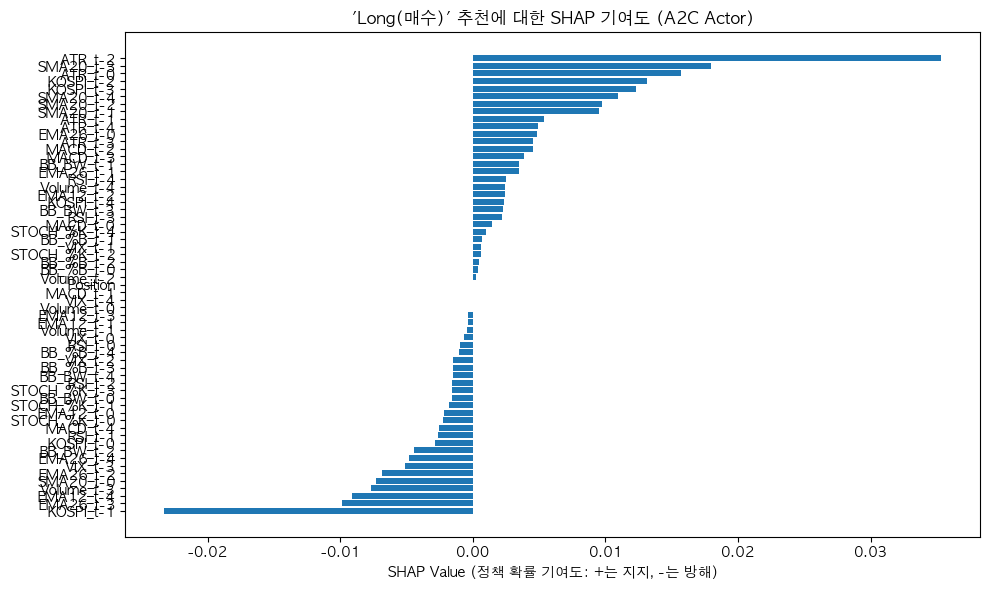


      [ 📱 리브리 AI 분석 결과 (삼성전자) ]

--- 1. AI 최종 신호 ---
    매수
    (예상 가치 V(s): 0.3237)

--- 2. 정책 확률 (Policy Probabilities) ---
    Long(매수)  : 0.5042
    Short(매도) : 0.1981
    Hold(관망)  : 0.2977

--- 3. AI 설명 (Top3 지표 근거) ---
  1. 'ATR' 지표 (평균 진폭(ATR, 변동성))가 정책상 '매수' 선택을 지지하는 방향으로 작용했습니다. (SHAP: +0.0353)
  2. 'SMA20' 지표 (중기 이동평균선(20일 단순이동평균))가 정책상 '매수' 선택을 지지하는 방향으로 작용했습니다. (SHAP: +0.0180)
  3. 'KOSPI' 지표 (시장 전체(KOSPI 지수) 흐름)가 정책상 '매수' 선택을 방해하는 방향으로 작용했습니다. (SHAP: -0.0233)

[디버그용 원본 출력]
[최종 추천]: Long(매수)
--- 전체 SHAP 값 상위 10개 ---
  ATR_t-2             : +0.0353 (지지)
  SMA20_t-3           : +0.0180 (지지)
  ATR_t-0             : +0.0157 (지지)
  KOSPI_t-2           : +0.0131 (지지)
  KOSPI_t-3           : +0.0123 (지지)
  SMA20_t-4           : +0.0109 (지지)
  SMA20_t-2           : +0.0097 (지지)
  SMA20_t-1           : +0.0095 (지지)
  ATR_t-1             : +0.0054 (지지)
  ATR_t-4             : +0.0049 (지지)


In [3]:
# --- 3. 셀: 추천 및 XAI 설명 (A2C explain.py) ---

import os
import yaml
import numpy as np
import shap
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import joblib

from data_utils import (
    download_data,
    add_indicators,
    train_test_split_last_10y_and_1y,  # 🔥 학습과 동일 분할
    FEATURES,
    build_state,
)
from ac_model import A2CAgent


# --- 상태(feature) 이름 생성 함수 ---
def get_feature_names_with_position(window_size: int):
    names = []
    for t in range(window_size):
        for f in FEATURES:
            names.append(f"{f}_t-{window_size-1-t}")
    names.append("Position")
    return names


# --- 지표별 한글 설명 매핑 ---
INDICATOR_DESC_KO = {
    "EMA12": "단기 추세(12일 지수이동평균)",
    "EMA26": "중기 추세(26일 지수이동평균)",
    "MACD": "추세 모멘텀(MACD 지표)",
    "Volume": "거래량 변화",
    "KOSPI": "시장 전체(KOSPI 지수) 흐름",
    "SMA20": "중기 이동평균선(20일 단순이동평균)",
    "RSI": "과매수·과매도 수준(RSI)",
    "STOCH_%K": "단기 모멘텀(Stochastic %K)",
    "VIX": "시장 변동성(VIX 지수)",
    "BB_%B": "볼린저 밴드 내 위치(%B)",
    "BB_BW": "볼린저 밴드 폭(변동성)",
    "ATR": "평균 진폭(ATR, 변동성)",
    "Position": "현재 포지션(보유 여부)",
}


# --- 추천 + SHAP 계산 ---
def get_recommendation_and_explanation(
    state: np.ndarray,
    agent: A2CAgent,
    explainer: shap.Explainer,
    feature_names: list,
    save_path: str,
    top_k: int = 3,
):
    # 1. 정책 확률 계산
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        policy_logits, _ = agent.ac_net(state_tensor)
        policy_probs = F.softmax(policy_logits, dim=-1).detach().cpu().numpy()[0]
        # 가치 함수 V(s)도 같이 뽑아서 "예상 가치"로 표기
        from ac_model import A2CAgent  # 이미 임포트 되어있지만 안전하게
    # value는 agent.get_value로 따로 계산
    with torch.no_grad():
        v_value = float(agent.get_value(state))

    action_idx = int(np.argmax(policy_probs))
    action_map = {0: "매수", 1: "매도", 2: "보유"}
    action_map_full = {0: "Long(매수)", 1: "Short(매도)", 2: "Hold(관망)"}
    recommendation_text = action_map[action_idx]
    recommendation_label = action_map_full[action_idx]

    # 2. SHAP 값 계산
    print("SHAP 값 계산 중 (A2C Actor 기준)...")
    shap_values_tensor = explainer.shap_values(state.reshape(1, -1))

    if isinstance(shap_values_tensor, list):
        shap_for_action = shap_values_tensor[action_idx][0]  # (state_dim,)
    else:
        shap_for_action = shap_values_tensor[0, :, action_idx]

    # 3. feature별 SHAP dict
    feature_shap = dict(zip(feature_names, shap_for_action))

    # 3-1. base feature 단위로 묶기(EMA12, VIX 등)
    aggregate = {}
    for name, val in feature_shap.items():
        if "_t-" in name:
            base = name.split("_t-")[0]
        else:
            base = name
        if base not in aggregate:
            aggregate[base] = {"sum_abs": 0.0, "best_val": val}
        aggregate[base]["sum_abs"] += abs(val)
        if abs(val) > abs(aggregate[base]["best_val"]):
            aggregate[base]["best_val"] = val

    sorted_base = sorted(aggregate.items(), key=lambda x: x[1]["sum_abs"], reverse=True)

    top_features = []
    for base, info in sorted_base[:top_k]:
        shap_val = info["best_val"]
        direction = "지지" if shap_val > 0 else "방해"
        desc = INDICATOR_DESC_KO.get(base, base)
        top_features.append(
            {
                "base": base,
                "shap": shap_val,
                "direction": direction,
                "description": desc,
            }
        )

    # 4. 전체 feature 단위 barh 그래프 저장
    plt.figure(figsize=(10, 6))
    order = np.argsort(shap_for_action)
    plt.barh([feature_names[i] for i in order], shap_for_action[order])
    plt.title(f"'{recommendation_label}' 추천에 대한 SHAP 기여도 (A2C Actor)")
    plt.xlabel("SHAP Value (정책 확률 기여도: +는 지지, -는 방해)")
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    plt.close()

    return recommendation_text, recommendation_label, policy_probs, v_value, feature_shap, top_features


def run_prediction():
    print("A2C 예측 및 SHAP 분석을 시작합니다...")

    # 1. 설정 로드
    with open("config.yaml", "r", encoding="utf-8") as f:
        cfg = yaml.safe_load(f)

    report_dir = cfg["report_dir"]
    scaler_path = os.path.join(report_dir, "scaler.joblib")
    model_path = cfg["model_path"]
    window_size = cfg["window_size"]
    model_cfg = cfg["model_cfg"]

    # 2. 데이터 로드 + 같은 방식으로 분할
    raw = download_data(
        cfg["ticker"],
        cfg["kospi_ticker"],
        cfg["vix_ticker"],
        cfg["start_date"],
        cfg["end_date"],
    )
    df = add_indicators(raw)
    train_df, test_df = train_test_split_last_10y_and_1y(
        df,
        train_years=10,
        backtest_days=365,
    )

    # 3. 스케일러 및 모델 로드
    try:
        scaler = joblib.load(scaler_path)
        print(f"Scaler 로드 완료: {scaler_path}")
    except FileNotFoundError:
        print(f"오류: {scaler_path} 찾을 수 없음. 2번 셀(학습)을 먼저 실행하세요.")
        return

    train_df[FEATURES] = scaler.transform(train_df[FEATURES])
    test_df[FEATURES] = scaler.transform(test_df[FEATURES])

    print(f"A2C 모델 로드 중: {model_path}")
    dummy_state_dim = len(FEATURES) * window_size + 1

    agent = A2CAgent(
        state_dim=dummy_state_dim,
        action_dim=3,
        hidden_dims=model_cfg.get("hidden_dims", [128, 128]),
        device=cfg.get("device", "cpu"),
    )
    agent.load(model_path)

    # 4. SHAP 배경 데이터
    print("SHAP 배경 데이터(훈련 샘플 일부) 생성 중...")
    bg_states = []
    bg_len = min(200 + window_size, len(train_df) - 1)
    for i in range(window_size - 1, bg_len):
        current_window = train_df.iloc[i - (window_size - 1) : i + 1]
        s = build_state(current_window, position_flag=0)
        bg_states.append(s)
    bg_states = np.array(bg_states, dtype=np.float32)
    bg_summary = shap.sample(bg_states, 100)

    def model_f(x):
        x_t = torch.tensor(x, dtype=torch.float32, device=cfg.get("device", "cpu"))
        policy_logits, _ = agent.ac_net(x_t)
        policy_probs = F.softmax(policy_logits, dim=-1)
        return policy_probs.detach().cpu().numpy()

    print("SHAP KernelExplainer 생성 중...")
    explainer = shap.KernelExplainer(model_f, bg_summary)
    feature_names = get_feature_names_with_position(window_size)
    print("[OK] SHAP 준비 완료")

    # 5. 예측 대상: 테스트 마지막 날 기준 (window_size만큼 과거 포함)
    target_idx = len(test_df) - 1  # 🔥 '오늘' = 테스트 마지막 날짜
    target_window = test_df.iloc[target_idx - (window_size - 1) : target_idx + 1]
    target_date = test_df.index[target_idx]

    current_position = 0  # 웹 서비스 기준: 기본은 미보유로 가정
    state_to_explain = build_state(target_window, current_position)

    save_path = os.path.join(report_dir, "prediction_explanation_a2c.png")
    print(f"\n기준 날짜(오늘 기준): {target_date.strftime('%Y-%m-%d')}")
    print(f"SHAP 그래프 저장 위치: {save_path}")

    rec_text, rec_label, probs, v_value, shap_all, top_feats = \
        get_recommendation_and_explanation(
            state_to_explain, agent, explainer, feature_names, save_path
        )

    # --- 6. 팀 리브리 스타일 출력 ---
    print("\n=============================================")
    print("      [ 📱 리브리 AI 분석 결과 (삼성전자) ]")
    print("=============================================\n")

    print("--- 1. AI 최종 신호 ---")
    print(f"    {rec_text}")
    print(f"    (예상 가치 V(s): {v_value:.4f})\n")

    print("--- 2. 정책 확률 (Policy Probabilities) ---")
    action_map = {0: "Long(매수)", 1: "Short(매도)", 2: "Hold(관망)"}
    print(f"    Long(매수)  : {probs[0]:.4f}")
    print(f"    Short(매도) : {probs[1]:.4f}")
    print(f"    Hold(관망)  : {probs[2]:.4f}\n")

    print("--- 3. AI 설명 (Top3 지표 근거) ---")
    for i, feat in enumerate(top_feats, start=1):
        base = feat["base"]
        shap_val = feat["shap"]
        direction = feat["direction"]
        desc = feat["description"]
        sign_txt = "지지" if direction == "지지" else "방해"
        print(f"  {i}. '{base}' 지표 ({desc})가 정책상 '{rec_text}' 선택을 {sign_txt}하는 방향으로 작용했습니다. "
              f"(SHAP: {shap_val:+.4f})")

    # 참고용 원래 심플 출력도 같이 남길 수도 있음
    print("\n[디버그용 원본 출력]")
    print(f"[최종 추천]: {rec_label}")
    print("--- 전체 SHAP 값 상위 10개 ---")
    sorted_explanation = sorted(
        shap_all.items(), key=lambda item: item[1], reverse=True
    )
    for feature, value in sorted_explanation[:10]:
        direction = "지지" if value > 0 else "방해"
        print(f"  {feature:<20}: {value:+.4f} ({direction})")


# --- 함수 실행 ---
run_prediction()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

========== [A2C Evaluation in Notebook] ==========
- Ticker             : 005930.KS
- KOSPI ticker       : ^KS11
- VIX ticker         : ^VIX
- 다운로드 구간      : 2010-11-26 ~ 2025-11-26
- window_size        : 5
- trade_penalty      : 0.001
- use_daily_unrealized: True
- device             : cpu

[1] 데이터 다운로드 및 지표 계산중 ...
    · 전체 데이터 기간: 2011-01-04 ~ 2025-11-25 (총 3541일)
[2] 오늘 기준 최근 10년 학습 + 최근 1년 테스트 구간 분할 ...
    · today(데이터 마지막 날짜): 2025-11-25
    · Train 기간: 2015-11-25 ~ 2024-11-22 (총 2135일)
    · Test  기간: 2024-11-25 ~ 2025-11-25 (총 233일)
[3] 스케일러 로드 및 테스트 구간 스케일링 ...
[4] TradingEnv 및 A2CAgent 로드 ...
    · 모델 로드 완료: a2c_samsung.pt

[5] 테스트 구간 백테스트 진행 ...
    · 총 스텝 수: 228 (거래일 기준)

[6] 백테스트 성능 지표 (r_t 기준) ...
    - 누적 수익률      : 89.63%
    - 일 평균 수익률    : 0.3035%
    - 일 수익률 변동성  : 2.1222%
    - 샤프 비율 (연환산): 2.270
    - 승률 (r_t > 0)    : 52.63% (120/228 일)
    - 최대 낙폭(MDD)    : -14.67%

[7] 일별 수익률 및 승률 시각화 ...


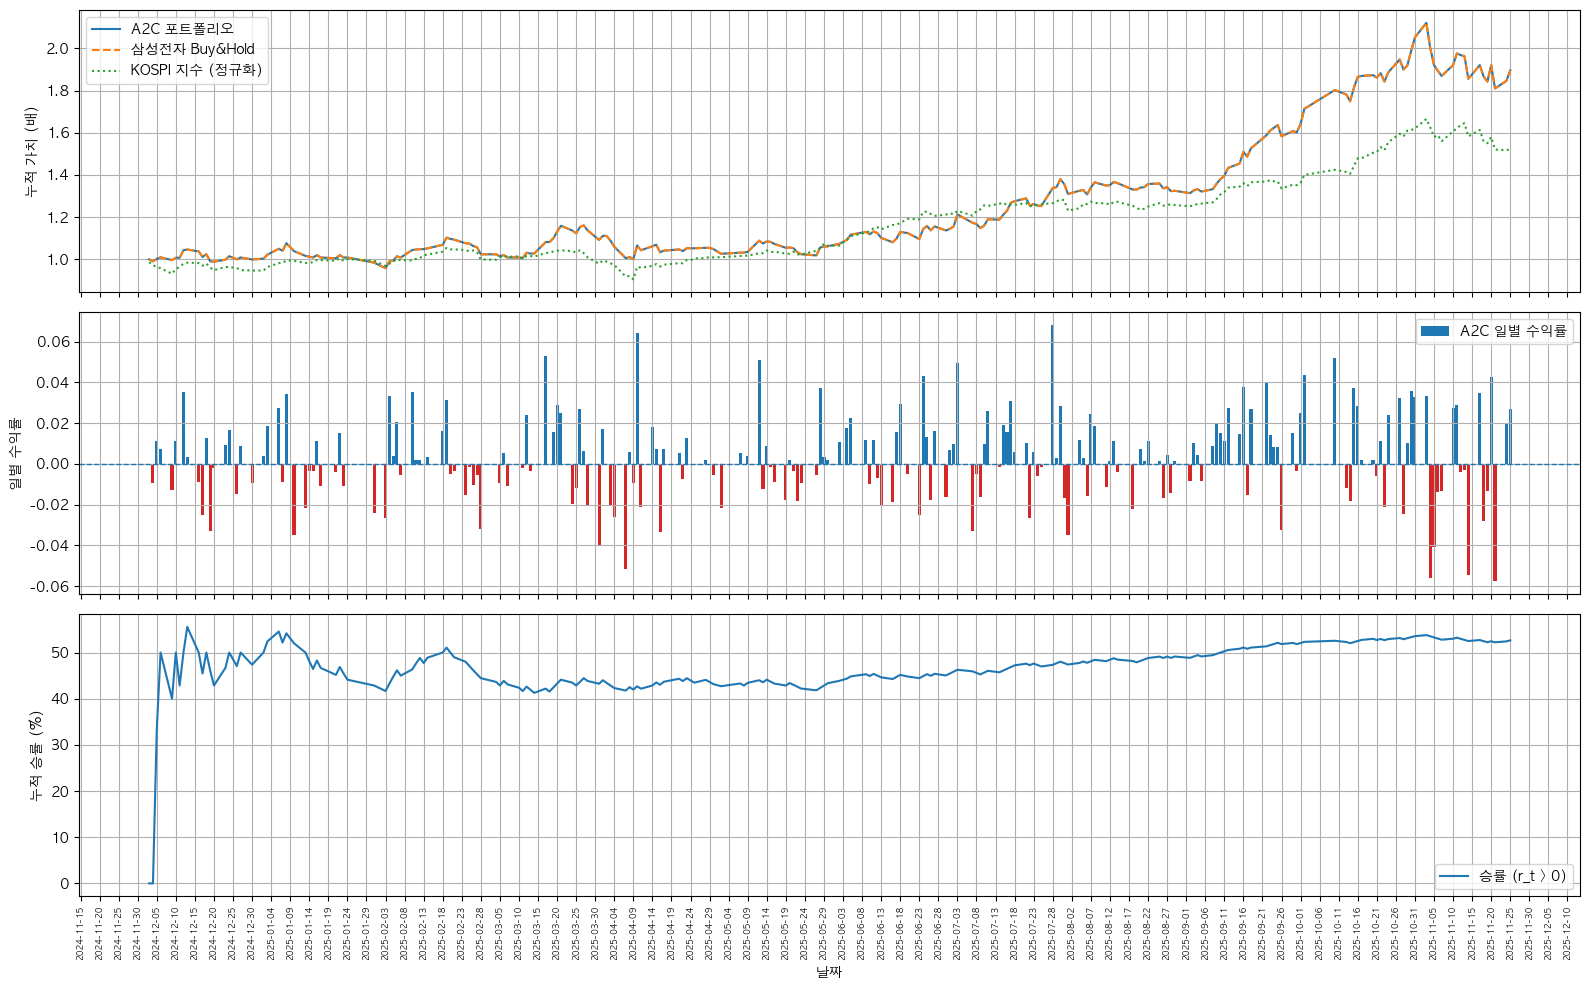

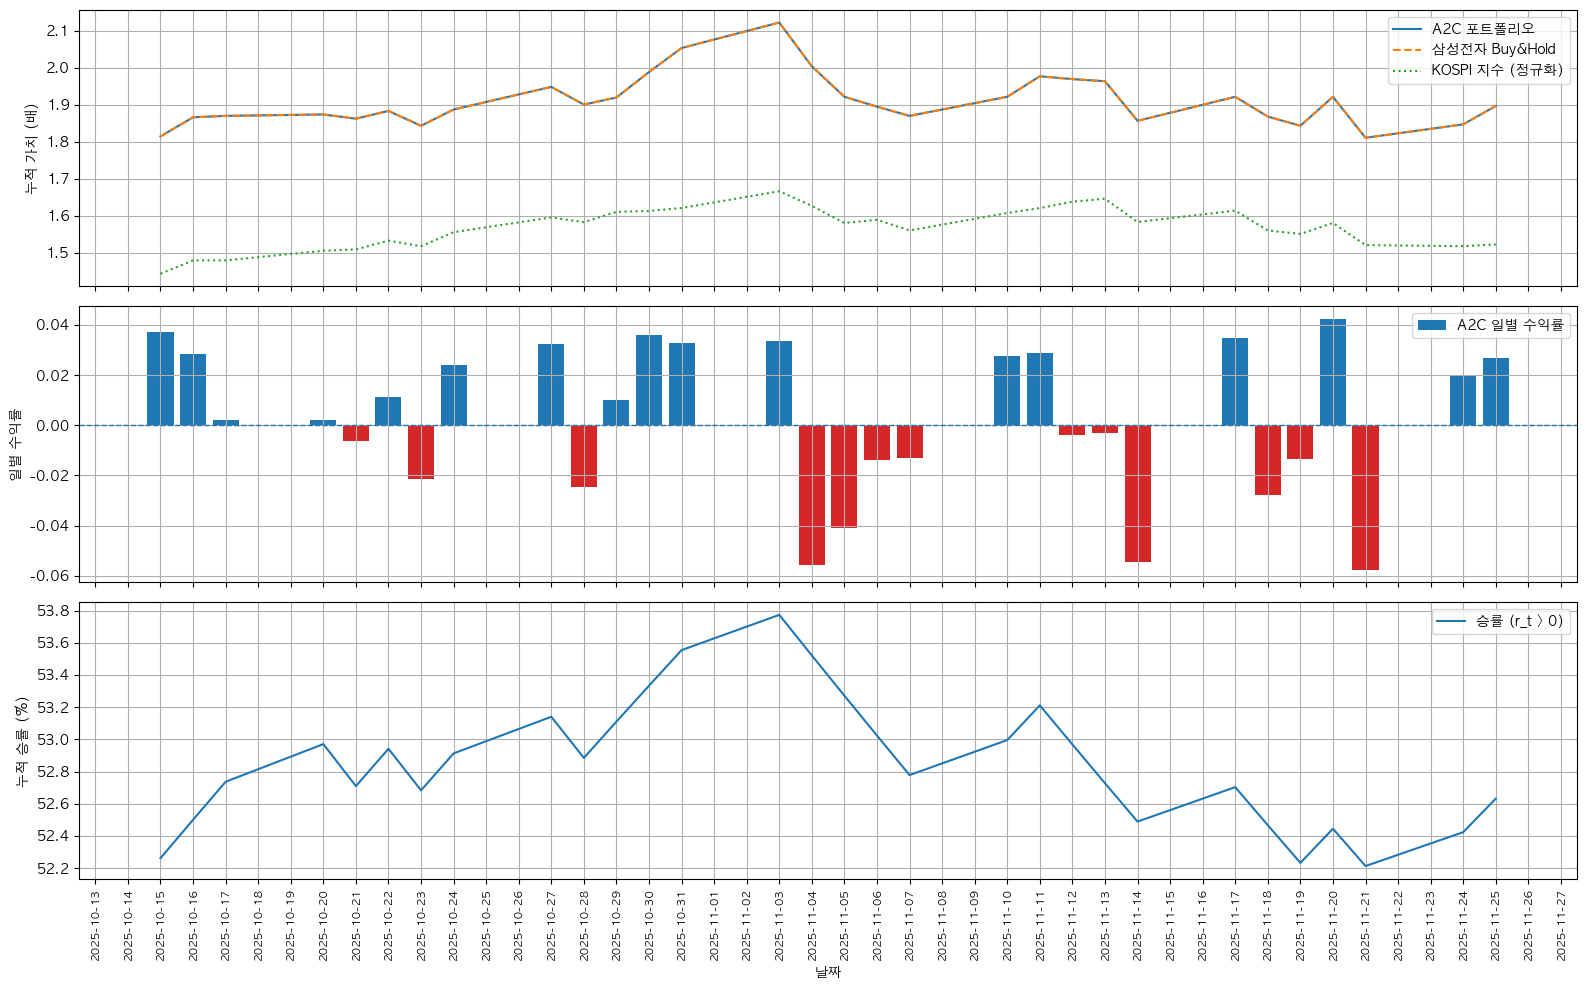

In [4]:
# A2C 백테스트 + 승률/수익률 시각화 셀
# (오늘 기준 최근 10년 학습 + 최근 1년 테스트 / 교수님 피드백 반영 버전)

import os
import yaml
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # ✅ 날짜 축 설정용

from ac_model import A2CAgent
from trading_env import TradingEnv
from data_utils import FEATURES, download_data, add_indicators

# -------------------------------------------
# 1. 백테스트 지표 계산 함수 (승률 정의 포함)
# -------------------------------------------
def compute_backtest_metrics(daily_returns: np.ndarray, risk_free_rate: float = 0.0) -> dict:
    """
    daily_returns: 포트폴리오 일별 수익률 r_t (예: 0.01 = 1%)

    승률 정의:
      - win_rate = (r_t > 0 인 날 수) / 전체 거래일 수
    """
    if len(daily_returns) == 0:
        return {
            "cum_return": 0.0,
            "mean_ret": 0.0,
            "vol": 0.0,
            "sharpe": 0.0,
            "win_rate": 0.0,
            "wins": 0,
            "days": 0,
            "mdd": 0.0,
        }

    equity = (1.0 + daily_returns).cumprod()
    cum_return = float(equity[-1] - 1.0)

    mean_ret = float(np.mean(daily_returns))
    vol = float(np.std(daily_returns))

    if vol > 0:
        sharpe = float((mean_ret - risk_free_rate) / vol * np.sqrt(252))
    else:
        sharpe = 0.0

    wins_mask = daily_returns > 0
    wins = int(wins_mask.sum())
    days = int(len(daily_returns))
    win_rate = wins / days if days > 0 else 0.0

    high_water_mark = np.maximum.accumulate(equity)
    drawdown = equity / high_water_mark - 1.0
    mdd = float(drawdown.min())

    return {
        "cum_return": cum_return,
        "mean_ret": mean_ret,
        "vol": vol,
        "sharpe": sharpe,
        "win_rate": win_rate,
        "wins": wins,
        "days": days,
        "mdd": mdd,
    }

# -------------------------------------------
# 2. 오늘 기준 최근 10년 / 최근 1년 분할
# -------------------------------------------
def split_last_10y_train_1y_test(df: pd.DataFrame):
    df = df.sort_index()

    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, errors="coerce")
    df = df[~df.index.isna()]

    today = df.index.max()
    test_start = today - pd.DateOffset(years=1)
    train_start = today - pd.DateOffset(years=10)

    train_df = df[(df.index >= train_start) & (df.index < test_start)]
    test_df = df[(df.index >= test_start) & (df.index <= today)]

    return train_df, test_df, today

# -------------------------------------------
# 3. 설정(config) 로드
# -------------------------------------------
with open("config.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

ticker = cfg.get("ticker", "005930.KS")
kospi_ticker = cfg.get("kospi_ticker", "^KS11")
vix_ticker = cfg.get("vix_ticker", "^VIX")

start_date = cfg.get("start_date", "2010-01-01")
end_date = cfg.get("end_date", None)

window_size = int(cfg.get("window_size", 30))

trade_penalty = float(cfg.get("trade_penalty", 0.001))
use_daily_unrealized = bool(cfg.get("use_daily_unrealized", True))
reward_cfg = cfg.get("reward", {})

model_path = cfg.get("model_path", "reports/a2c_samsung.pt")
report_dir = cfg.get("report_dir", "reports")
device = cfg.get("device", "cpu")

os.makedirs(report_dir, exist_ok=True)

print("========== [A2C Evaluation in Notebook] ==========")
print(f"- Ticker             : {ticker}")
print(f"- KOSPI ticker       : {kospi_ticker}")
print(f"- VIX ticker         : {vix_ticker}")
print(f"- 다운로드 구간      : {start_date} ~ {end_date}")
print(f"- window_size        : {window_size}")
print(f"- trade_penalty      : {trade_penalty}")
print(f"- use_daily_unrealized: {use_daily_unrealized}")
print(f"- device             : {device}\n")

# -------------------------------------------
# 4. 데이터 다운로드 & 지표 계산
# -------------------------------------------
print("[1] 데이터 다운로드 및 지표 계산중 ...")

df = download_data(
    ticker=ticker,
    kospi_ticker=kospi_ticker,
    vix_ticker=vix_ticker,
    start_date=start_date,
    end_date=end_date,
)
df = add_indicators(df)
df = df.dropna(subset=FEATURES + ["Close", "KOSPI"])

print(f"    · 전체 데이터 기간: {df.index.min().date()} ~ {df.index.max().date()} (총 {len(df)}일)")

# -------------------------------------------
# 5. 오늘 기준 최근 10년 / 최근 1년 분할
# -------------------------------------------
print("[2] 오늘 기준 최근 10년 학습 + 최근 1년 테스트 구간 분할 ...")
train_df, test_df, today = split_last_10y_train_1y_test(df)

if train_df.empty or test_df.empty:
    raise RuntimeError(
        f"[evaluation] train/test 데이터가 비어 있습니다. "
        f"len(train_df)={len(train_df)}, len(test_df)={len(test_df)}"
    )

print(f"    · today(데이터 마지막 날짜): {today.date()}")
print(f"    · Train 기간: {train_df.index.min().date()} ~ {train_df.index.max().date()} (총 {len(train_df)}일)")
print(f"    · Test  기간: {test_df.index.min().date()} ~ {test_df.index.max().date()} (총 {len(test_df)}일)")

# -------------------------------------------
# 6. 스케일러 & 테스트 구간 스케일링
# -------------------------------------------
print("[3] 스케일러 로드 및 테스트 구간 스케일링 ...")

scaler_path = os.path.join(report_dir, "scaler.joblib")
if not os.path.exists(scaler_path):
    raise FileNotFoundError(
        f"[evaluation] scaler.joblib이 없습니다. ({scaler_path})\n"
        f"train_a2c.py에서 학습 및 저장이 먼저 되어야 합니다."
    )

scaler = joblib.load(scaler_path)

test_indicators = test_df[FEATURES].values.astype(float)
test_scaled = scaler.transform(test_indicators)

test_df_scaled = test_df.copy()
test_df_scaled[FEATURES] = test_scaled

# -------------------------------------------
# 7. TradingEnv & A2CAgent 로드
# -------------------------------------------
print("[4] TradingEnv 및 A2CAgent 로드 ...")

env = TradingEnv(
    data=test_df_scaled,
    window_size=window_size,
    trade_penalty=trade_penalty,
    use_daily_unrealized=use_daily_unrealized,
    reward_cfg=reward_cfg,
)

state_dim = env.current_state_dim()
action_dim = 3  # 0=Long, 1=Short, 2=Hold

agent = A2CAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    device=device,
)

if not os.path.exists(model_path):
    raise FileNotFoundError(
        f"[evaluation] 학습된 모델 파일이 없습니다. ({model_path})\n"
        f"train_a2c.py에서 학습 및 모델 저장이 먼저 되어야 합니다."
    )

agent.load(model_path)
agent.epsilon = 0.0

print(f"    · 모델 로드 완료: {model_path}")

# -------------------------------------------
# 8. 백테스트 실행 (일별 r_t 기준)
# -------------------------------------------
print("\n[5] 테스트 구간 백테스트 진행 ...")

s = env.reset()
done = False

daily_returns = []
rewards = []
actions = []

while not done:
    a, _ = agent.act(s, deterministic=True)
    ns, r, done, info = env.step(a)

    r_t = float(info.get("r_t", 0.0))

    daily_returns.append(r_t)
    rewards.append(r)
    actions.append(a)

    s = ns if not done else s

daily_returns = np.array(daily_returns, dtype=float)
rewards = np.array(rewards, dtype=float)
actions = np.array(actions, dtype=int)

print(f"    · 총 스텝 수: {len(daily_returns)} (거래일 기준)")

# -------------------------------------------
# 9. 성능 지표 (승률 포함) 출력
# -------------------------------------------
print("\n[6] 백테스트 성능 지표 (r_t 기준) ...")
metrics = compute_backtest_metrics(daily_returns)

print(f"    - 누적 수익률      : {metrics['cum_return']*100:.2f}%")
print(f"    - 일 평균 수익률    : {metrics['mean_ret']*100:.4f}%")
print(f"    - 일 수익률 변동성  : {metrics['vol']*100:.4f}%")
print(f"    - 샤프 비율 (연환산): {metrics['sharpe']:.3f}")
print(
    f"    - 승률 (r_t > 0)    : "
    f"{metrics['win_rate']*100:.2f}% "
    f"({metrics['wins']}/{metrics['days']} 일)"
)
print(f"    - 최대 낙폭(MDD)    : {metrics['mdd']*100:.2f}%")

# -------------------------------------------
# 10. 수익률/승률 시각화 (전체 구간 + 최근 30일 확대)
# -------------------------------------------
print("\n[7] 일별 수익률 및 승률 시각화 ...")

port_rets = np.array(env.port_ret_hist, dtype=float)
mkt_rets_env = np.array(env.mkt_ret_hist, dtype=float)  # 필요하면 참고용
equity_curve = np.array(env.equity_curve, dtype=float)
buyhold_curve = np.array(env.buyhold_curve, dtype=float)

# ✅ 첫 트레이드 가능한 날부터의 날짜 (window_size일 이후)
dates = test_df.index[window_size:]
min_len = min(len(dates), len(port_rets))

dates = dates[-min_len:]
port_rets = port_rets[-min_len:]
equity_agent = equity_curve[-min_len:]
equity_bh = buyhold_curve[-min_len:]

# ✅ KOSPI는 원본 test_df 사용해서 "몇 배"로 정규화
kospi_price = test_df["KOSPI"].values.astype(float)
equity_kospi_full = kospi_price / kospi_price[0]
equity_kospi = equity_kospi_full[window_size:][-min_len:]

win_ret = port_rets > 0
cum_win_ret = np.cumsum(win_ret) / np.arange(1, len(win_ret) + 1)

# ---------- (1) 전체 테스트 구간 그래프 ----------
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

axes[0].plot(dates, equity_agent, label="A2C 포트폴리오")
axes[0].plot(dates, equity_bh, label="삼성전자 Buy&Hold", linestyle="--")
axes[0].plot(dates, equity_kospi, label="KOSPI 지수 (정규화)", linestyle=":")
axes[0].set_ylabel("누적 가치 (배)")
axes[0].legend()
axes[0].grid(True)

colors = ["tab:red" if r < 0 else "tab:blue" for r in port_rets]
axes[1].bar(dates, port_rets, label="A2C 일별 수익률", color=colors)
axes[1].axhline(0.0, linestyle="--", linewidth=1)
axes[1].set_ylabel("일별 수익률")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(dates, cum_win_ret * 100.0, label="승률 (r_t > 0)")
axes[2].set_ylabel("누적 승률 (%)")
axes[2].set_xlabel("날짜")
axes[2].legend()
axes[2].grid(True)

# x축 날짜 tick – 5일 간격
day_locator = mdates.DayLocator(interval=5)
day_formatter = mdates.DateFormatter("%Y-%m-%d")
for ax in axes:
    ax.xaxis.set_major_locator(day_locator)
    ax.xaxis.set_major_formatter(day_formatter)
plt.setp(axes[-1].get_xticklabels(), rotation=90, fontsize=6)

plt.tight_layout()
plt.show()

# ---------- (2) 최근 30거래일 확대 그래프 ----------
zoom_n = 30
if len(dates) >= zoom_n:
    z_dates = dates[-zoom_n:]
    z_port = port_rets[-zoom_n:]
    z_eq_agent = equity_agent[-zoom_n:]
    z_eq_bh = equity_bh[-zoom_n:]
    z_eq_kospi = equity_kospi[-zoom_n:]
    z_cum_win = cum_win_ret[-zoom_n:]

    fig2, axes2 = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

    axes2[0].plot(z_dates, z_eq_agent, label="A2C 포트폴리오")
    axes2[0].plot(z_dates, z_eq_bh, label="삼성전자 Buy&Hold", linestyle="--")
    axes2[0].plot(z_dates, z_eq_kospi, label="KOSPI 지수 (정규화)", linestyle=":")
    axes2[0].set_ylabel("누적 가치 (배)")
    axes2[0].legend()
    axes2[0].grid(True)

    colors_z = ["tab:red" if r < 0 else "tab:blue" for r in z_port]
    axes2[1].bar(z_dates, z_port, label="A2C 일별 수익률", color=colors_z)
    axes2[1].axhline(0.0, linestyle="--", linewidth=1)
    axes2[1].set_ylabel("일별 수익률")
    axes2[1].legend()
    axes2[1].grid(True)

    axes2[2].plot(z_dates, z_cum_win * 100.0, label="승률 (r_t > 0)")
    axes2[2].set_ylabel("누적 승률 (%)")
    axes2[2].set_xlabel("날짜")
    axes2[2].legend()
    axes2[2].grid(True)

    # 확대 그래프는 1일 간격으로 tick
    day_locator2 = mdates.DayLocator(interval=1)
    day_formatter2 = mdates.DateFormatter("%Y-%m-%d")
    for ax in axes2:
        ax.xaxis.set_major_locator(day_locator2)
        ax.xaxis.set_major_formatter(day_formatter2)
    plt.setp(axes2[-1].get_xticklabels(), rotation=90, fontsize=8)

    plt.tight_layout()
    plt.show()
else:
    print("    · 데이터가 30거래일보다 짧아서 확대 그래프는 생략합니다.")